### Kütüphaneleri yüklüyoruz.

In [221]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
from arch import arch_model
warnings.filterwarnings("ignore")

#### Verileri çekiyoruz.

In [222]:
evds=evdsAPI('5kQnRdxBC4')

In [223]:
# dolar kuru
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace = True)

usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

usd


TP_DK_USD_S_YTL
Tarih                      
2006-02-28         1.326535
2006-03-31         1.335139
2006-04-30         1.337345
2006-05-31         1.420659
2006-06-30         1.600536
...                     ...
2023-09-30        26.989448
2023-10-31        27.846114
2023-11-30        28.637082
2023-12-31        29.074857
2024-01-31        29.872909

[216 rows x 1 columns]

In [224]:
#TÜFE (EVDS'den çekildi)
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]
inflation=enf
inflation

Tarih     TÜFE
0     2006-2   123.84
1     2006-3   124.18
2     2006-4   125.84
3     2006-5   128.20
4     2006-6   128.63
..       ...      ...
210   2023-8  1614.31
211   2023-9  1691.04
212  2023-10  1749.11
213  2023-11  1806.50
214  2023-12  1859.38

[215 rows x 2 columns]

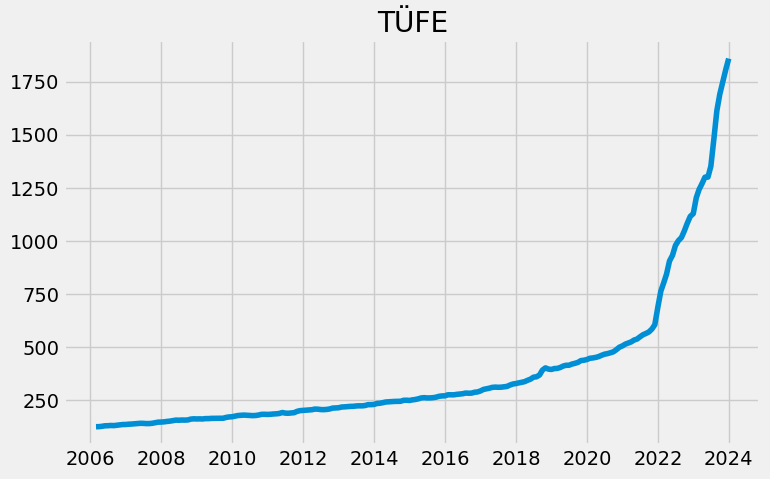

In [459]:
#enflasyon grafiğinin çizimi

dates=pd.date_range(start="2006-02-28",periods=len(enf) , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("TÜFE")
plt.plot(df)
plt.show()


In [226]:
# USD/TRY'yi float'a çeviri ve df6'ya tanımlama. 
df6=pd.DataFrame()
df6["USD/TRY"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TRY"]=df6["USD/TRY"].astype(float)
df6

USD/TRY
Tarih                
2006-02-28   1.326535
2006-03-31   1.335139
2006-04-30   1.337345
2006-05-31   1.420659
2006-06-30   1.600536
...               ...
2023-09-30  26.989448
2023-10-31  27.846114
2023-11-30  28.637082
2023-12-31  29.074857
2024-01-31  29.872909

[216 rows x 1 columns]

In [227]:
# M2 Para Arzı verisi

money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["M2 Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28',periods=len(money), freq='1M'))
money

M2 Para Arzi
2006-02-28      2.423895
2006-03-31      2.494857
2006-04-30      2.521919
2006-05-31      2.751947
2006-06-30      2.791388
...                  ...
2023-09-30    123.493100
2023-10-31    127.637895
2023-11-30    130.504631
2023-12-31    136.159887
2024-01-31    134.409988

[216 rows x 1 columns]

In [228]:
#İşsizlik verisi

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",periods=len(issizlik),freq="1M"))
issizlik

İşsizlik
2014-01-31       9.2
2014-02-28       9.5
2014-03-31       9.5
2014-04-30       9.7
2014-05-31       9.7
...              ...
2023-07-31       9.3
2023-08-31       9.1
2023-09-30       9.0
2023-10-31       8.5
2023-11-30       9.0

[119 rows x 1 columns]

In [229]:
#Toplam Kredi Hacmi

kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
dates=pd.date_range('2006-02-01',periods=len(kredi) , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi Hacmi"]
kredi["Kredi Hacmi"]=kredi["Kredi Hacmi"]/1e+08

df3=pd.DataFrame()
df3["Kredi Hacmi"]=kredi["Kredi Hacmi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28',periods=len(df3) , freq='1M'))
df3

Kredi Hacmi
2006-02-28     1.381847
2006-03-31     1.481222
2006-04-30     1.527510
2006-05-31     1.664881
2006-06-30     1.740395
...                 ...
2023-09-30   102.582870
2023-10-31   104.793503
2023-11-30   107.866144
2023-12-31   111.894756
2024-01-31   112.210989

[216 rows x 1 columns]

In [230]:
#TCMB Ağırlıklı Ortalama Fonlama Maliyeti (Politika Faizi)
#2011 yılına kadar veri gelmediği için aşağıda verilerin bir bölümü manuel girilmiştir.

pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
pfaiz



Tarih   Faiz
0     2006-2  17.50
1     2006-3  17.50
2     2006-4  17.50
3     2006-5  17.50
4     2006-6  17.50
..       ...    ...
211   2023-9  31.00
212  2023-10  33.00
213  2023-11  41.09
214  2023-12  42.50
215   2024-1  42.50

[216 rows x 2 columns]

In [231]:
#Index ataması yapıldı.

dates=pd.date_range('2006-02-28',periods=len(pfaiz) , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

Politika Faizi
TIME                      
2006-02-28           17.50
2006-03-31           17.50
2006-04-30           17.50
2006-05-31           17.50
2006-06-30           17.50
...                    ...
2023-09-30           31.00
2023-10-31           33.00
2023-11-30           41.09
2023-12-31           42.50
2024-01-31           42.50

[216 rows x 1 columns]

In [232]:
# Tüketici Kredisi (TL Üzerinden Acılan)(İhtiyaç+Taşıt+Konut) (Akım Veri) -- Kredi Faizi

kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del kfaiz["Tarih"]
del kfaiz["YEARWEEK"]
kfaiz=kfaiz.set_index(pd.date_range(start="2006-02-01",periods=len(kfaiz),freq="1W"))
kfaiz=kfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])
kfaiz.columns=["Kredi Faizi"]
kfaiz

Kredi Faizi
2006-02-28        17.02
2006-03-31        16.88
2006-04-30        15.84
2006-05-31        16.60
2006-06-30        20.35
...                 ...
2023-09-30        57.56
2023-10-31        58.43
2023-11-30        58.61
2023-12-31        58.16
2024-01-31        62.08

[216 rows x 1 columns]

In [233]:
brent=pd.read_excel("./BRENT.xls")
brent1=brent.iloc[0:,1].dropna(axis=0).astype(float)
brent1=pd.DataFrame(brent1)
brent1.columns=["BRENT"]
brent1=brent1.set_index(pd.date_range(start="2007-07-31",periods=len(brent1),freq="1M"))
brent1=brent1.resample('M').mean()
brent1

BRENT
2007-07-31  72.690
2007-08-31  79.170
2007-09-30  90.630
2007-10-31  88.260
2007-11-30  93.850
...            ...
2023-09-30  89.070
2023-10-31  82.830
2023-11-30  79.935
2023-12-31  77.040
2024-01-31  78.290

[199 rows x 1 columns]

In [234]:
#Sanayi Üretim Endeksi

sanayi=pd.read_excel("./sanayi uretim endeksi ve degisim oranlari (2015=100) - Kasim.xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

Sanayi
2005-02-28   57.747916
2005-03-31   57.058754
2005-04-30   57.685141
2005-05-31   58.226534
2005-06-30   58.022939
...                ...
2023-07-31  147.426310
2023-08-31  146.188629
2023-09-30  146.015076
2023-10-31  145.634666
2023-11-30  143.563781

[226 rows x 1 columns]

In [235]:
# 3 Aya Kadar Vadeli (TL Üzerinden Açılan Mevduatlar) (Akım %)
# Bankalarca Açılan Mevduatlara Uygulanan Ağırlıklı Ortalama Faiz Oranları (Akım %)


mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="03-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
#mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2024-01-01",freq="1M"))
del mfaiz["YEARWEEK"]
del mfaiz["Tarih"]
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-03",periods=len(mfaiz),freq="W"))
mfaiz=mfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])

mfaiz.columns=["Mevduat Faizi"]
mfaiz

Mevduat Faizi
2006-02-28          15.70
2006-03-31          14.84
2006-04-30          14.87
2006-05-31          14.84
2006-06-30          15.57
...                   ...
2023-09-30          42.74
2023-10-31          41.72
2023-11-30          46.07
2023-12-31          52.50
2024-01-31          51.29

[216 rows x 1 columns]

In [236]:
# Piyasa Katılımcıları Anketi - 12 Ay Sonrasının Yıllık TÜFE Beklentisi (%)- Medyan

from datetime import date
enf_tahmin=evds.get_data(["TP.BEK.S01.E.A"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_tahmin=enf_tahmin.set_index(pd.date_range(start="2013-06-30",periods=len(enf_tahmin),freq="1M"))
del enf_tahmin["Tarih"]
enf_tahmin.columns=["Enflasyon Tahmini"]
enf_tahmin

Enflasyon Tahmini
2013-06-30               6.20
2013-07-31               6.45
2013-08-31               6.45
2013-09-30               6.68
2013-10-31               6.61
...                       ...
2023-08-31              42.01
2023-09-30              44.94
2023-10-31              45.75
2023-11-30              44.07
2023-12-31              41.23

[127 rows x 1 columns]

In [237]:
# Hazine - İç Borç Stok Verileri

borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",periods=len(borc),freq="1M"))
borc.columns=["Borç"]
borc


Borç
2006-01-31  2.435600e+08
2006-02-28  2.464270e+08
2006-03-31  2.463600e+08
2006-04-30  2.466640e+08
2006-05-31  2.507320e+08
...                  ...
2023-07-31  2.643068e+09
2023-08-31  2.758965e+09
2023-09-30  2.859751e+09
2023-10-31  2.966763e+09
2023-11-30  3.086466e+09

[215 rows x 1 columns]

In [238]:
# TÜFE Bazlı Reel Efektif Döviz Kuru

redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",periods=len(redkt),freq="1M"))
redkt.columns=["REDKT"]
redkt

REDKT
2011-03-31  111.62
2011-04-30  114.17
2011-05-31  112.89
2011-06-30  108.98
2011-07-31  104.82
...            ...
2023-08-31   52.40
2023-09-30   55.53
2023-10-31   56.04
2023-11-30   55.25
2023-12-31   55.15

[154 rows x 1 columns]

#### Verileri birleştirme ve düzenleme yapıyoruz.

In [356]:
# verilerimizi tek tabloda topluyoruz. Döviz kuru ve Kredi Hacmin'deki gecikmelerden kaynaklı 3 aylık ve 2 aylık hareketli
# ortalama kullandık. Para arzı ve İç Borç Stoğunda da 1 aylık gecikme gördüğümüzden dolayı 1 ay kaydırdık.

# rolling -> hareketli ortalama
# pct_change -> Yüzdesel değişim (percentage change)

data=pd.DataFrame()
data["USD/TRY"]=df6["USD/TRY"][:-1].rolling(3).mean()
#data["USD/TRY"]=df6["USD/TRY"]
data["M2 Para Arzi"]=money["M2 Para Arzi"].shift(1)
data["BRENT"]=brent1["BRENT"].shift(2)
data["Sanayi"]=sanayi["Sanayi"]
data["Kredi Hacmi"]=df3["Kredi Hacmi"].rolling(2).mean()
#data["Kredi Hacmi"]=df3["Kredi Hacmi"]
data["Borç"]=(borc["Borç"]/1e+08).shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)

# buraya kadar olan verilerimizi yüzdesel değişim olarak değiştirdik. Sonraki verileri direkt gireceğiz.
# aşağıdaki veriler yüzdesel olduğu için yukarıdaki değişimi uygulamadık.

data["Enflasyon Tahmini"]=enf_tahmin
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
data["REDKT"]=redkt["REDKT"]
data=data.dropna(axis=0)
data=data[['USD/TRY','BRENT','Kredi Faizi','Sanayi', 'Enflasyon Tahmini','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi','TÜFE']]
data


USD/TRY      BRENT  Kredi Faizi    Sanayi  Enflasyon Tahmini  \
Tarih                                                                        
2014-01-31   3.732429  -1.499681        13.80  3.604096               7.12   
2014-02-28   3.033477   0.474339        15.54 -0.850238               7.25   
2014-03-31   2.465778  -1.987426        16.05  0.128936               7.37   
2014-04-30  -1.344724   2.509398        15.65 -0.863760               7.18   
2014-05-31  -1.859714  -1.201064        15.36 -1.367417               7.21   
...               ...        ...          ...       ...                ...   
2023-07-31  11.475241   3.082852        44.58 -0.446616              33.21   
2023-08-31  10.505114  14.232310        45.29 -0.839525              42.01   
2023-09-30   5.071342   1.519402        57.56 -0.118719              44.94   
2023-10-31   1.709911   9.728298        58.43 -0.260527              45.75   
2023-11-30   2.001541  -6.547057        58.61 -1.421973              44.07   

            M2 Para Arzi      Borç  Kredi Hacmi  Mevduat Faizi   REDKT  \
Tarih                                                                    
2014-01-31      3.375162 -0.584687     3.267877           8.85   95.75   
2014-02-28      1.804994  0.808574     1.451593          10.75   96.63   
2014-03-31      0.451349  0.193691     0.341852          11.65   97.25   
2014-04-30      0.796760  0.478162     0.129671          10.75  102.98   
2014-05-31     -0.362357  0.091080     0.468727          10.43  105.10   
...                  ...       ...          ...            ...     ...   
2023-07-31     15.146856  9.689321     5.675617          29.32   48.69   
2023-08-31      5.943431  2.618269     1.850455          30.76   52.40   
2023-09-30      4.764088  4.384930     2.080815          42.74   55.53   
2023-10-31      2.694232  3.653039     2.752662          41.72   56.04   
2023-11-30      3.356297  3.741984     2.547674          46.07   55.25   

            İşsizlik  Politika Faizi      TÜFE  
Tarih                                           
2014-01-31       9.2            9.96  1.978080  
2014-02-28       9.5           10.23  0.428192  
2014-03-31       9.5           10.27  1.125608  
2014-04-30       9.7           10.03  1.344970  
2014-05-31       9.7            9.53  0.395224  
...              ...             ...       ...  
2023-07-31       9.3           17.50  9.488824  
2023-08-31       9.1           23.50  9.086793  
2023-09-30       9.0           31.00  4.753114  
2023-10-31       8.5           33.00  3.433981  
2023-11-30       9.0           41.09  3.281097  

[119 rows x 13 columns]

In [240]:
features=['USD/TRY','BRENT','Kredi Faizi','Sanayi', 'Enflasyon Tahmini','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi','TÜFE']
train=data[features].iloc[:-3,:]
test=data[features].iloc[-3:,:]



In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [242]:
# train test boyutlarını belirliyoruz.

test_period = 3 
test_size = test_period  

train_data = data[:-test_size]
test_data = data[-test_size:]

# Bağımsız değişkenleri ve TÜFE'yi ayırdık.

X_train = train.drop(['TÜFE'], axis=1).values
y_train = train['TÜFE'].values
X_test = test.drop(['TÜFE'], axis=1).values
y_test = test['TÜFE'].values



##### Korelasyon kontrolü

In [243]:
cor_matrix=data.corr()
cor_matrix["TÜFE"].sort_values(ascending=False)

TÜFE                 1.000000
USD/TRY              0.720002
M2 Para Arzı         0.678249
Enflasyon Tahmini    0.562694
Kredi Hacmi          0.521658
Kredi Faizi          0.505576
Borç                 0.453026
Mevduat Faizi        0.416199
Politika Faizi       0.230164
BRENT                0.077997
Sanayi              -0.053535
İşsizlik            -0.200390
REDKT               -0.580310
Name: TÜFE, dtype: float64

<Axes: >

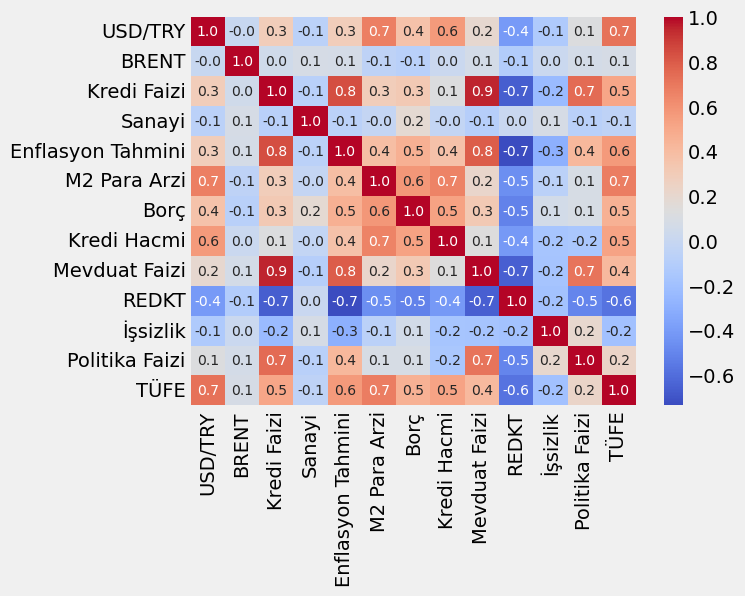

In [477]:
# Korelasyon matrisini hesaplayalım
korelasyon_matrisi = data.corr()

# Seaborn kütüphanesi ile ısı haritası (heatmap) grafiğini çizelim
sns.heatmap(korelasyon_matrisi, annot=True, cmap='coolwarm', linewidths=0, fmt=".1f",annot_kws={"size": 10})

LSTM için model hazırlıklarını yapıyoruz.

In [244]:
# LSTM için Kütüphaneleri import ediyoruz.

import tensorflow as tf
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import keras

# Rastgele sayı üreticisini ayarlıyoruz.
keras.utils.set_random_seed(1)

#Verileri normalize ediyoruz. (MinMaxScaler kullanıldı)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

#Modeli oluşturuyoruz.LSTM tabanlı bir derin öğrenme modeli tanımlar.
#Modelde bir LSTM katmanı ve ardından gelen üç tam bağlı katman (dense layer) bulunmaktadır.
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(X_train_scaled.shape[1],1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu'))
model.add(tf.keras.layers.Dense(1))

#Model derlenmesi. Kayıp fonksiyonu olarak ortalama karesel hata kullanıldı.
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')

# Overfitting olmaması için erken durdurma parametresini belirliyoruz. Eğer kayıp fonksiyonunda 25 kere ardarda ilerleme
# olmazsa model duracak. (epoch >= 50)
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

#Modeli eğitiyoruz.
model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])



Epoch 1/500
4/4 [==============================] - 2s 96ms/step - loss: 5.3316 - val_loss: 8.2782
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 2.4673 - val_loss: 0.0912
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0295 - val_loss: 0.0239
Epoch 4/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0174 - val_loss: 0.0152
Epoch 5/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0171 - val_loss: 0.0169
Epoch 6/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0167 - val_loss: 0.0165
Epoch 7/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0183 - val_loss: 0.0063
Epoch 8/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0170 - val_loss: 0.0037
Epoch 9/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0187 - val_loss: 0.0052
Epoch 10/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0227 - val_loss: 0.0168
Epoch 11/500
4/4 [=

### Modeldeki hiperparametre seçimi için Grid Search (Izgara Taraması) yapıyoruz.

In [245]:

# Burada ise modeldeki hiperparametrelerin optimizasyonu için Grid Search (Izgara taraması) yapacağız.
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import ParameterGrid


# Model fonksiyonunu tanımlayın
def create_model(neurons=128, activation='relu', optimizer='adam', epochs=100):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])
    return model


# Grid Search için hiperparametre kombinasyonlarını tanımlıyoruz.
param_grid = {
    'neurons': [64, 128],
    'activation': ['relu', 'tanh','selu','sigmoid','elu','gelu','linear'],
    'optimizer': ['adam', 'rmsprop','Adadelta','Adagrad','Adamax','Nadam','Ftrl'],
    'epochs': [500]
}
#Root Mean Squared Error -> ortalama Karekök sapması
#Grid Search algoritması çalıştırılmış ve en iyi hiperparametre seti ve buna karşılık gelen en küçük RMSE atanacak.

best_rmse = float('inf')
best_params = None

#Grid Search algoritması çalıştırılacak ve en iyi hiperparametre seti ve buna karşılık gelen en küçük RMSE atanacak.
for params in ParameterGrid(param_grid):
    model = create_model(neurons=params['neurons'], activation=params['activation'], optimizer=params['optimizer'], epochs=params['epochs'])
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = np.sqrt(mse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

#En iyi RMSE ve parametreleri yazdırıyoruz.
print("En iyi RMSE:", best_rmse)
print("En iyi parametreler:", best_params)
"""

1/1 [==============================] - 0s 164ms/step
En iyi RMSE: 0.04114048886694121
En iyi parametreler: {'activation': 'selu', 'epochs': 500, 'neurons': 64, 'optimizer': 'adam'}


In [246]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Modelinizi eğittikten sonra tahminlerimizi yapıyoruz.
y_pred = model.predict(X_test_scaled)

# Tahminleri gerçek değerlerle karşılaştırarak MSE hesaplıyoruz.
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")


1/1 [==============================] - 0s 24ms/step
Validation MSE: 0.0760930613728405
Validation RMSE: 0.27584970794409136


In [247]:
y_pred_original_scale = scaler.inverse_transform(y_pred)

# Tahmin edilen değerleri inceleyin
np.sqrt(mean_squared_error(y_test,y_pred_original_scale))

4.142823941876334

### Features seçimi yapıyoruz.

In [248]:
X=data[features]
y=data[["TÜFE"]]
scalerX = StandardScaler().fit(X)
scalery = StandardScaler().fit(y)
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
X_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)
y_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)
X_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)
y_test = pd.DataFrame(scalery.transform(y_test),y.index[-3:],columns=y.columns)

In [249]:

from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
features=['USD/TRY','BRENT','Kredi Faizi','Sanayi', 'Enflasyon Tahmini','M2 Para Arzi',
          'Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
best_mse=float("inf")
best_features=[]
for r in range(3,11):
   for combo in combinations(features, 7):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        model = sm.RLM(y_train, X_train_subset, M=sm.robust.norms.HuberT()).fit()
        y_pred=model.predict(X_test_subset)
        rmse1=np.sqrt(mean_squared_error(y_test,y_pred))
        

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_mse)


En iyi özellik kombinasyonu:
['USD/TRY', 'Kredi Faizi', 'M2 Para Arzı', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi', 'Politika Faizi']
En iyi RMSE değeri: 0.1217812434403094


### Features seçiminde olmasa da eklediğimiz değerler olacak. (Verilerin anlamlı olacağını düşünerek.)

### Farklı modeller ile tahminlerimizi yapıyoruz.

In [250]:
#en iyi öznitelik kombinasyonuna bazı öznitelikleri de ekleyerek lineer regresyon tahminliyoruz.

features = ['USD/TRY','Kredi Faizi','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
X = data[features]
y=data[["TÜFE"]]
X_train, X_test, y_train, y_test = X.iloc[:-3, :], X.iloc[-3:, :], y.iloc[:-3, :], y.iloc[-3:, :]
model = LinearRegression().fit(X_train, y_train)
pred = model.predict(X_test)
rmse=[]
rmse.append(np.sqrt(mean_squared_error(y_test, pred)))
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=pred

pred

array([[5.85098951],
       [4.86758433],
       [4.59585311]])

In [251]:
features = ['USD/TRY','Kredi Faizi','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())
results = model.fit()
pred=results.predict(X_test)
tahminler["Robust Regression"]=pred
rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

In [252]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TRY','Kredi Faizi','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
X = data[features]
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [253]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TRY','Kredi Faizi','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [254]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TRY','Kredi Faizi','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [255]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TRY','Kredi Faizi','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [256]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USD/TRY','Kredi Faizi','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train)

tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [257]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USD/TRY','Kredi Faizi','M2 Para Arzi','Borç','Kredi Hacmi','Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [258]:
tahminler["LSTM"]=y_pred_original_scale
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred_original_scale)))

In [259]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

RMSE
Lasso Regression     1.047050
Bayesian Regression  1.208949
Lars Regression      1.289590
Linear Regression    1.289590
SGD Regressor        1.403373
Gaussian Regression  1.475605
Kernel Regression    1.719237
Robust Regression    2.107989
LSTM                 4.142824

In [260]:
tahminler.index.strftime("%Y-%m")

Index(['2023-09', '2023-10', '2023-11'], dtype='object', name='Tarih')

In [261]:
tahminler=tahminler.set_index(pd.date_range(start="2023-09",periods=3,freq="M"))
tahminler.index=tahminler.index.strftime("%Y-%m")

<Axes: >

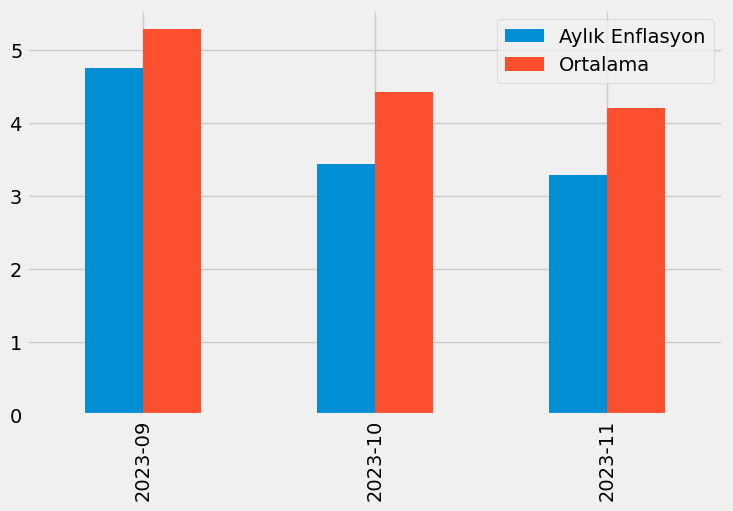

In [262]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
tahminler[["Aylık Enflasyon","Ortalama"]].plot(kind="bar",figsize=(8,5))

### Bağımsız değişkenlerimizin tahminlerini yapıyoruz. (exog prediction)

In [263]:
# Politika faizi için tahmin değil beklentilere yönelik manuel veri girişi yapıldı.

model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(28)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-11-30",end="2024-02-28",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40,40,40,40,40,40,40,40,37.5,35,35,35,35,35]
faiztahmin

Politika Faizi
2023-11-30       41.090000
2023-12-31       42.500000
2024-01-31       42.500000
2024-02-29       43.667857
2024-03-31       42.500000
2024-04-30       45.000000
2024-05-31       45.000000
2024-06-30       45.000000
2024-07-31       45.000000
2024-08-31       45.000000
2024-09-30       45.000000
2024-10-31       45.000000
2024-11-30       45.000000
2024-12-31       45.000000
2025-01-31       42.500000
2025-02-28       40.000000
2025-03-31       40.000000
2025-04-30       40.000000
2025-05-31       40.000000
2025-06-30       40.000000
2025-07-31       40.000000
2025-08-31       40.000000
2025-09-30       40.000000
2025-10-31       40.000000
2025-11-30       40.000000
2025-12-31       37.500000
2026-01-31       35.000000
2026-02-28       35.000000
2026-03-31       35.000000
2026-04-30       35.000000
2026-05-31       35.000000

In [264]:
#arima ile kredi faizinin gelecek verisini tahminliyoruz.

model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(26)
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2024-01-31",end="2024-01-31",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



Kredi Faizi
2024-01-31    62.080000
2024-02-29    62.487036
2024-03-31    63.739910
2024-04-30    63.140805
2024-05-31    63.980462
2024-06-30    63.245752
2024-07-31    64.009176
2024-08-31    63.268563
2024-09-30    64.006409
2024-10-31    63.278946
2024-11-30    63.999098
2024-12-31    63.287318
2025-01-31    63.991261
2025-02-28    63.295238
2025-03-31    63.983495
2025-04-30    63.302943
2025-05-31    63.975887
2025-06-30    63.310469
2025-07-31    63.968446
2025-08-31    63.317828
2025-09-30    63.961170
2025-10-31    63.325023
2025-11-30    63.954056
2025-12-31    63.332057
2026-01-31    63.947100
2026-02-28    63.338936
2026-03-31    63.940298

In [265]:
trainexog=kfaiz[47:-1]
trainexog

Kredi Faizi
2010-01-31        13.76
2010-02-28        13.36
2010-03-31        13.10
2010-04-30        13.18
2010-05-31        13.25
...                 ...
2023-08-31        45.29
2023-09-30        57.56
2023-10-31        58.43
2023-11-30        58.61
2023-12-31        58.16

[168 rows x 1 columns]

In [266]:
testexog=kfaiztahmin[4:]
testexog

Kredi Faizi
2024-05-31    63.980462
2024-06-30    63.245752
2024-07-31    64.009176
2024-08-31    63.268563
2024-09-30    64.006409
2024-10-31    63.278946
2024-11-30    63.999098
2024-12-31    63.287318
2025-01-31    63.991261
2025-02-28    63.295238
2025-03-31    63.983495
2025-04-30    63.302943
2025-05-31    63.975887
2025-06-30    63.310469
2025-07-31    63.968446
2025-08-31    63.317828
2025-09-30    63.961170
2025-10-31    63.325023
2025-11-30    63.954056
2025-12-31    63.332057
2026-01-31    63.947100
2026-02-28    63.338936
2026-03-31    63.940298

In [267]:
faiztahmin[5:]

Politika Faizi
2024-04-30            45.0
2024-05-31            45.0
2024-06-30            45.0
2024-07-31            45.0
2024-08-31            45.0
2024-09-30            45.0
2024-10-31            45.0
2024-11-30            45.0
2024-12-31            45.0
2025-01-31            42.5
2025-02-28            40.0
2025-03-31            40.0
2025-04-30            40.0
2025-05-31            40.0
2025-06-30            40.0
2025-07-31            40.0
2025-08-31            40.0
2025-09-30            40.0
2025-10-31            40.0
2025-11-30            40.0
2025-12-31            37.5
2026-01-31            35.0
2026-02-28            35.0
2026-03-31            35.0
2026-04-30            35.0
2026-05-31            35.0

In [268]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz[:],trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(26,X=faiztahmin[5:]))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-2:,0]},index=pd.date_range(start="2024-01-31",end="2024-01-31",freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin



Mevduat Faizi
2024-01-31      51.290000
2024-02-29      50.758418
2024-03-31      52.269808
2024-04-30      52.226070
2024-05-31      51.606011
2024-06-30      51.962263
2024-07-31      52.032439
2024-08-31      51.842460
2024-09-30      51.916006
2024-10-31      51.956895
2024-11-30      50.605823
2024-12-31      49.320110
2025-01-31      49.336537
2025-02-28      49.322581
2025-03-31      49.323182
2025-04-30      49.328800
2025-05-31      49.325485
2025-06-30      49.324897
2025-07-31      49.326629
2025-08-31      49.325937
2025-09-30      49.325576
2025-10-31      48.028591
2025-11-30      46.731000
2025-12-31      46.730853
2026-01-31      46.730982
2026-02-28      46.730974
2026-03-31      46.730924

In [269]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*brent1.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*brent1.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [270]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*brent1["BRENT"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


X
2007-07-31    94.630729
2007-08-31   102.791449
2007-09-30   117.002444
2007-10-31   108.990141
2007-11-30   112.283562
...                 ...
2023-09-30  2404.381183
2023-10-31  2271.014769
2023-11-30  2257.492114
2023-12-31  2223.063889
2024-01-31  2307.510309

[199 rows x 1 columns]

In [271]:
faiztahmin.columns=["Faiz"]


In [272]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [273]:
exog=pfaiz["Politika Faizi"].iloc[94:-3]
exog=np.array(exog).reshape(-1,1)

In [274]:
exogtest=faiztahmin.iloc[3:]
exogtest=np.array(exogtest).reshape(-1,1)

In [275]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

İşsizlik
2023-12-31  8.786814
2024-01-31  8.756800
2024-02-29  8.901400
2024-03-31  8.952587
2024-04-30  8.965938
2024-05-31  9.061040
2024-06-30  9.105634
2024-07-31  9.136871
2024-08-31  9.192203
2024-09-30  9.230379
2024-10-31  9.263083
2024-11-30  9.365130
2024-12-31  9.460653
2025-01-31  9.490318
2025-02-28  9.520910
2025-03-31  9.548476
2025-04-30  9.574230
2025-05-31  9.599389
2025-06-30  9.622767
2025-07-31  9.644787
2025-08-31  9.665872
2025-09-30  9.685691
2025-10-31  9.767461
2025-11-30  9.848303
2025-12-31  9.865104
2026-01-31  9.880995
2026-02-28  9.896057
2026-03-31  9.910298

In [276]:
from prophet import Prophet
df6.shape

(216, 1)

### Tahminlerimiz için hiperparametre seçimlerini yapıyoruz.

In [277]:
# her bir tahmin için bu şekilde parametre belirleyeceğiz.
"""
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,500)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6.index
    sn["y"]=df6.values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=14,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-14])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)


[I 2024-01-16 14:31:29,788] A new study created in memory with name: no-name-0dd0f343-b68d-4635-b3c6-332f60838e7d
14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:31:30,214] Trial 0 finished with value: 7.146238167703154 and parameters: {'changepoint_prior_scale': 9.570549910679615, 'changepoint_range': 0.4864059934339726, 'growth': 'linear', 'seasonality_prior_scale': 3.639682606658636, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 317.6708357033641}. Best is trial 0 with value: 7.146238167703154.
14:31:30 - cmdstanpy - INFO - Chain [1] start processing
14:31:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:31:30,638] Trial 1 finished with value: 11.04217241059389 and parameters: {'changepoint_prior_scale': 6.203082500827763, 'changepoint_range': 0.33420751381386105, 'growth': 'linear', 'seasonality_prior_scale': 4.472212209365438, 'n_changepoints

14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:31:42,459] Trial 16 finished with value: 0.3217811215400091 and parameters: {'changepoint_prior_scale': 2.891775520933125, 'changepoint_range': 0.871260902540316, 'growth': 'linear', 'seasonality_prior_scale': 0.44528570275141366, 'n_changepoints': 20, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 370.9449525500436}. Best is trial 10 with value: 0.13141274111250653.
14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:31:42,964] Trial 17 finished with value: 3.794882962361032 and parameters: {'changepoint_prior_scale': 1.4424478456591356, 'changepoint_range': 0.6460220222238439, 'growth': 'linear', 'seasonality_prior_scale': 2.4663078151997646, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 171.82046327088304}. Best is trial 10 

14:31:51 - cmdstanpy - INFO - Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:31:51,895] Trial 32 finished with value: 0.3443711358247842 and parameters: {'changepoint_prior_scale': 7.162716510650499, 'changepoint_range': 0.848945959168573, 'growth': 'linear', 'seasonality_prior_scale': 5.309268852952908, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 80.15605264233093}. Best is trial 10 with value: 0.13141274111250653.
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:31:52,420] Trial 33 finished with value: 0.28103936205459734 and parameters: {'changepoint_prior_scale': 8.270045939232626, 'changepoint_range': 0.93665872991342, 'growth': 'linear', 'seasonality_prior_scale': 4.175656590896169, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 44.05111514556462}. Best is trial 10 w

14:32:01 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:02,976] Trial 48 finished with value: 0.3214108388455206 and parameters: {'changepoint_prior_scale': 6.930703266027711, 'changepoint_range': 0.9086571137474996, 'growth': 'linear', 'seasonality_prior_scale': 9.98739185991491, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'cap': 99.21463142958437}. Best is trial 43 with value: 0.13054541709402884.
14:32:03 - cmdstanpy - INFO - Chain [1] start processing
14:32:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:03,440] Trial 49 finished with value: 9.489026344902593 and parameters: {'changepoint_prior_scale': 4.620160618685153, 'changepoint_range': 0.3671681927225938, 'growth': 'linear', 'seasonality_prior_scale': 6.018696864539126, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 223.87740046715876}. Best is trial 43 

14:32:11 - cmdstanpy - INFO - Chain [1] start processing
14:32:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:11,999] Trial 64 finished with value: 0.3156726991224622 and parameters: {'changepoint_prior_scale': 3.40999849952151, 'changepoint_range': 0.9063460909026791, 'growth': 'linear', 'seasonality_prior_scale': 8.838558466743464, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 40.88155084895766}. Best is trial 62 with value: 0.12290716642210765.
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:12,499] Trial 65 finished with value: 0.13755373895005485 and parameters: {'changepoint_prior_scale': 3.6359159518577635, 'changepoint_range': 0.9569622531560661, 'growth': 'linear', 'seasonality_prior_scale': 7.499552483718493, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 85.79015086876501}. Best is trial 6

14:32:20 - cmdstanpy - INFO - Chain [1] start processing
14:32:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:20,853] Trial 80 finished with value: 0.44247123992453574 and parameters: {'changepoint_prior_scale': 3.891868176602507, 'changepoint_range': 0.9156548349524927, 'growth': 'linear', 'seasonality_prior_scale': 9.552830937061731, 'n_changepoints': 10, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 67.52050849951132}. Best is trial 62 with value: 0.12290716642210765.
14:32:21 - cmdstanpy - INFO - Chain [1] start processing
14:32:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:21,448] Trial 81 finished with value: 0.13277389415956112 and parameters: {'changepoint_prior_scale': 1.968761464117259, 'changepoint_range': 0.9626237150071246, 'growth': 'linear', 'seasonality_prior_scale': 8.205951390481603, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 11.83906479153737}. Best is trial 

14:32:30 - cmdstanpy - INFO - Chain [1] start processing
14:32:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:30,448] Trial 96 finished with value: 0.18699720327594027 and parameters: {'changepoint_prior_scale': 3.6774220893488465, 'changepoint_range': 0.9654787744833891, 'growth': 'linear', 'seasonality_prior_scale': 6.564372365319066, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 52.64842484902808}. Best is trial 62 with value: 0.12290716642210765.
14:32:30 - cmdstanpy - INFO - Chain [1] start processing
14:32:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:30,876] Trial 97 finished with value: 2.704395785692215 and parameters: {'changepoint_prior_scale': 4.418823780560665, 'changepoint_range': 0.9355227947289168, 'growth': 'linear', 'seasonality_prior_scale': 7.148464570269671, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 45.557051904442325}. Best is trial 62

14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:39,455] Trial 112 finished with value: 0.3270015145152559 and parameters: {'changepoint_prior_scale': 5.534859231310472, 'changepoint_range': 0.9134865274923993, 'growth': 'linear', 'seasonality_prior_scale': 7.024942509799291, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 19.656865522355893}. Best is trial 62 with value: 0.12290716642210765.
14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:39,942] Trial 113 finished with value: 0.26076634658960274 and parameters: {'changepoint_prior_scale': 5.264057120128784, 'changepoint_range': 0.9318158936150449, 'growth': 'linear', 'seasonality_prior_scale': 6.7826737003822855, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 8.340481152446404}. Best is tri

14:32:48 - cmdstanpy - INFO - Chain [1] start processing
14:32:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:48,444] Trial 128 finished with value: 0.14453702204738977 and parameters: {'changepoint_prior_scale': 5.779342583839362, 'changepoint_range': 0.9448570885087981, 'growth': 'linear', 'seasonality_prior_scale': 6.597528280247168, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 28.648641567087537}. Best is trial 114 with value: 0.11452588748588094.
14:32:48 - cmdstanpy - INFO - Chain [1] start processing
14:32:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:48,908] Trial 129 finished with value: 11.514208093646651 and parameters: {'changepoint_prior_scale': 4.336642078490909, 'changepoint_range': 0.27022816203610006, 'growth': 'linear', 'seasonality_prior_scale': 7.114838137163173, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 58.422925310975344}. Best is tr

14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:56,828] Trial 144 finished with value: 0.3304786964968909 and parameters: {'changepoint_prior_scale': 1.6448065723152214, 'changepoint_range': 0.8914180026672806, 'growth': 'linear', 'seasonality_prior_scale': 8.338137970197593, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 70.37602212036137}. Best is trial 114 with value: 0.11452588748588094.
14:32:57 - cmdstanpy - INFO - Chain [1] start processing
14:32:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:32:57,342] Trial 145 finished with value: 0.13093303023303748 and parameters: {'changepoint_prior_scale': 2.563944132883647, 'changepoint_range': 0.9535615908353414, 'growth': 'linear', 'seasonality_prior_scale': 9.005698428395828, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 12.84700223273688}. Best is trial 1

14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:05,604] Trial 160 finished with value: 0.2602554740527062 and parameters: {'changepoint_prior_scale': 7.072398047650335, 'changepoint_range': 0.9308457153223596, 'growth': 'linear', 'seasonality_prior_scale': 9.90301790357134, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 453.34325632339653}. Best is trial 114 with value: 0.11452588748588094.
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:06,101] Trial 161 finished with value: 0.1863130872131311 and parameters: {'changepoint_prior_scale': 6.637058473539703, 'changepoint_range': 0.966471960930551, 'growth': 'linear', 'seasonality_prior_scale': 9.70003149985683, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 12.390756667775872}. Best is trial 114 

14:33:13 - cmdstanpy - INFO - Chain [1] start processing
14:33:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:13,872] Trial 176 finished with value: 0.2735517001217363 and parameters: {'changepoint_prior_scale': 6.174207406315378, 'changepoint_range': 0.9347219972276843, 'growth': 'linear', 'seasonality_prior_scale': 9.306137038997647, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 11.836208947122438}. Best is trial 114 with value: 0.11452588748588094.
14:33:14 - cmdstanpy - INFO - Chain [1] start processing
14:33:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:14,418] Trial 177 finished with value: 0.12654741162524494 and parameters: {'changepoint_prior_scale': 5.926566519159017, 'changepoint_range': 0.956834070713622, 'growth': 'linear', 'seasonality_prior_scale': 9.97710394943544, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 24.802738401724902}. Best is trial 11

14:33:23 - cmdstanpy - INFO - Chain [1] start processing
14:33:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:24,051] Trial 192 finished with value: 0.23090741952765567 and parameters: {'changepoint_prior_scale': 6.761735742460006, 'changepoint_range': 0.9388595305281819, 'growth': 'linear', 'seasonality_prior_scale': 9.979148237179068, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 29.150599791244073}. Best is trial 114 with value: 0.11452588748588094.
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:24,610] Trial 193 finished with value: 0.11462834611813028 and parameters: {'changepoint_prior_scale': 5.196788628680138, 'changepoint_range': 0.9542457022415477, 'growth': 'linear', 'seasonality_prior_scale': 9.774642469430216, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 44.301727157561686}. Best is trial

14:33:33 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:34,871] Trial 208 finished with value: 0.3318236101198998 and parameters: {'changepoint_prior_scale': 6.446549117112136, 'changepoint_range': 0.9189010704558349, 'growth': 'linear', 'seasonality_prior_scale': 9.629471137699952, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 21.10732163040831}. Best is trial 114 with value: 0.11452588748588094.
14:33:35 - cmdstanpy - INFO - Chain [1] start processing
14:33:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:35,343] Trial 209 finished with value: 0.2153891552608206 and parameters: {'changepoint_prior_scale': 6.969406444128499, 'changepoint_range': 0.971246078962261, 'growth': 'linear', 'seasonality_prior_scale': 9.331741589970544, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 11.81711342818706}. Best is trial 114 

14:33:44 - cmdstanpy - INFO - Chain [1] start processing
14:33:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:45,193] Trial 224 finished with value: 0.14901740186287113 and parameters: {'changepoint_prior_scale': 5.2064797736256985, 'changepoint_range': 0.9886346135792283, 'growth': 'linear', 'seasonality_prior_scale': 9.475998867141495, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 0.05667475036379166}. Best is trial 114 with value: 0.11452588748588094.
14:33:45 - cmdstanpy - INFO - Chain [1] start processing
14:33:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:45,730] Trial 225 finished with value: 6.733092714380803 and parameters: {'changepoint_prior_scale': 6.2940799867260795, 'changepoint_range': 0.5028457476138545, 'growth': 'linear', 'seasonality_prior_scale': 9.810143160463795, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 9.450352699074045}. Best is trial

14:33:54 - cmdstanpy - INFO - Chain [1] start processing
14:33:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:55,292] Trial 240 finished with value: 0.3087239547167904 and parameters: {'changepoint_prior_scale': 6.5158787581835975, 'changepoint_range': 0.9272141150625582, 'growth': 'linear', 'seasonality_prior_scale': 9.637226719735345, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 32.51101305011811}. Best is trial 114 with value: 0.11452588748588094.
14:33:55 - cmdstanpy - INFO - Chain [1] start processing
14:33:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:33:55,812] Trial 241 finished with value: 0.12166394474772264 and parameters: {'changepoint_prior_scale': 5.295780032803796, 'changepoint_range': 0.9558748155900954, 'growth': 'linear', 'seasonality_prior_scale': 9.821024590439443, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 15.772849393759538}. Best is trial 

14:34:04 - cmdstanpy - INFO - Chain [1] start processing
14:34:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:04,703] Trial 256 finished with value: 0.12266604713950884 and parameters: {'changepoint_prior_scale': 6.319076754074672, 'changepoint_range': 0.9522853192545235, 'growth': 'linear', 'seasonality_prior_scale': 9.596898066892091, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 37.8009337397317}. Best is trial 114 with value: 0.11452588748588094.
14:34:04 - cmdstanpy - INFO - Chain [1] start processing
14:34:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:05,230] Trial 257 finished with value: 0.29337735809613164 and parameters: {'changepoint_prior_scale': 6.2112147087581775, 'changepoint_range': 0.927023359662826, 'growth': 'linear', 'seasonality_prior_scale': 9.291135410164088, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 40.93045308437512}. Best is trial 11

14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:16,021] Trial 272 finished with value: 0.15235715631989283 and parameters: {'changepoint_prior_scale': 6.688422910414643, 'changepoint_range': 0.9816807659525257, 'growth': 'linear', 'seasonality_prior_scale': 8.595711216169866, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 53.378210132874095}. Best is trial 114 with value: 0.11452588748588094.
14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:16,501] Trial 273 finished with value: 0.12066824113543201 and parameters: {'changepoint_prior_scale': 6.480169984787237, 'changepoint_range': 0.989657701888948, 'growth': 'linear', 'seasonality_prior_scale': 8.85211791480996, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 52.75103370418499}. Best is tria

14:34:24 - cmdstanpy - INFO - Chain [1] start processing
14:34:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:25,118] Trial 288 finished with value: 0.12068406343724909 and parameters: {'changepoint_prior_scale': 7.178074789238584, 'changepoint_range': 0.9894533995298532, 'growth': 'linear', 'seasonality_prior_scale': 8.863366784619878, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 99.5515565687126}. Best is trial 114 with value: 0.11452588748588094.
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:25,691] Trial 289 finished with value: 0.1205022510662881 and parameters: {'changepoint_prior_scale': 7.657284602501659, 'changepoint_range': 0.9896191654711355, 'growth': 'linear', 'seasonality_prior_scale': 8.566071764967008, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 101.27537087227037}. Best is tria

14:34:33 - cmdstanpy - INFO - Chain [1] start processing
14:34:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:33,824] Trial 304 finished with value: 0.12073553354279841 and parameters: {'changepoint_prior_scale': 7.1467915858005915, 'changepoint_range': 0.9887628006860206, 'growth': 'linear', 'seasonality_prior_scale': 8.823001566669664, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 120.9281833079389}. Best is trial 114 with value: 0.11452588748588094.
14:34:34 - cmdstanpy - INFO - Chain [1] start processing
14:34:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:34,307] Trial 305 finished with value: 0.22907181124028486 and parameters: {'changepoint_prior_scale': 8.512449089391012, 'changepoint_range': 0.9725334630186154, 'growth': 'linear', 'seasonality_prior_scale': 8.644578442923347, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 95.76519593283696}. Best is tr

14:34:41 - cmdstanpy - INFO - Chain [1] start processing
14:34:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:42,104] Trial 320 finished with value: 0.1207441893494158 and parameters: {'changepoint_prior_scale': 7.535885561794625, 'changepoint_range': 0.9891135743131902, 'growth': 'linear', 'seasonality_prior_scale': 8.328912001538278, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 85.91512587722553}. Best is trial 114 with value: 0.11452588748588094.
14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:42,697] Trial 321 finished with value: 0.19414897729154137 and parameters: {'changepoint_prior_scale': 8.401047496120084, 'changepoint_range': 0.9659259291645513, 'growth': 'linear', 'seasonality_prior_scale': 8.673447383937786, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 111.32587719013347}. Best is tri

14:34:51 - cmdstanpy - INFO - Chain [1] start processing
14:34:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:52,067] Trial 336 finished with value: 0.22364261775402666 and parameters: {'changepoint_prior_scale': 7.195009174457696, 'changepoint_range': 0.9692260430257043, 'growth': 'linear', 'seasonality_prior_scale': 8.94806926652251, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 99.16712893032569}. Best is trial 114 with value: 0.11452588748588094.
14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:34:52,530] Trial 337 finished with value: 0.2405585016359328 and parameters: {'changepoint_prior_scale': 6.90064956313799, 'changepoint_range': 0.9682738004626247, 'growth': 'linear', 'seasonality_prior_scale': 8.644007418111878, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 106.9417966412522}. Best is trial 

14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:01,407] Trial 352 finished with value: 9.571108431960171 and parameters: {'changepoint_prior_scale': 6.573917472928902, 'changepoint_range': 0.9700888123638504, 'growth': 'linear', 'seasonality_prior_scale': 7.770399636114066, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 68.8527951638211}. Best is trial 114 with value: 0.11452588748588094.
14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:01,907] Trial 353 finished with value: 0.14702575764857084 and parameters: {'changepoint_prior_scale': 8.377907282281972, 'changepoint_range': 0.9551920842667841, 'growth': 'linear', 'seasonality_prior_scale': 8.687356884137602, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 118.35087481055196}. Best is trial 1

14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:09,744] Trial 368 finished with value: 1.1170786720075851 and parameters: {'changepoint_prior_scale': 8.193258157587934, 'changepoint_range': 0.929109929310241, 'growth': 'linear', 'seasonality_prior_scale': 8.777239818400218, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 136.03229797545907}. Best is trial 114 with value: 0.11452588748588094.
14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:10,233] Trial 369 finished with value: 0.6977801338812557 and parameters: {'changepoint_prior_scale': 6.640771981056031, 'changepoint_range': 0.971304094773395, 'growth': 'logistic', 'seasonality_prior_scale': 8.502813187108863, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 417.51294616540906}. Best is trial

14:35:19 - cmdstanpy - INFO - Chain [1] start processing
14:35:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:19,680] Trial 384 finished with value: 0.13286871437134157 and parameters: {'changepoint_prior_scale': 6.175409715978776, 'changepoint_range': 0.9545996594625239, 'growth': 'linear', 'seasonality_prior_scale': 8.68951868216513, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 125.95905305474487}. Best is trial 114 with value: 0.11452588748588094.
14:35:19 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:20,177] Trial 385 finished with value: 0.23659469637176175 and parameters: {'changepoint_prior_scale': 6.549828368710104, 'changepoint_range': 0.9719884072550918, 'growth': 'linear', 'seasonality_prior_scale': 8.307083185794706, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 82.3632277320137}. Best is tri

14:35:28 - cmdstanpy - INFO - Chain [1] start processing
14:35:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:28,496] Trial 400 finished with value: 2.7477807467208066 and parameters: {'changepoint_prior_scale': 8.779802558174186, 'changepoint_range': 0.7062109269871599, 'growth': 'linear', 'seasonality_prior_scale': 9.462740169789987, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 133.21367149313275}. Best is trial 114 with value: 0.11452588748588094.
14:35:28 - cmdstanpy - INFO - Chain [1] start processing
14:35:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:29,061] Trial 401 finished with value: 0.18093766973499312 and parameters: {'changepoint_prior_scale': 6.4471107107257755, 'changepoint_range': 0.9421751516360923, 'growth': 'linear', 'seasonality_prior_scale': 8.479826788645735, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 101.50652992279116}. Best is t

14:35:37 - cmdstanpy - INFO - Chain [1] start processing
14:35:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:38,872] Trial 416 finished with value: 0.12101971160708784 and parameters: {'changepoint_prior_scale': 6.164483225519529, 'changepoint_range': 0.9895979283643599, 'growth': 'linear', 'seasonality_prior_scale': 9.16569141864227, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 98.96283383953433}. Best is trial 114 with value: 0.11452588748588094.
14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:39,365] Trial 417 finished with value: 0.3236392583865239 and parameters: {'changepoint_prior_scale': 7.993594351658317, 'changepoint_range': 0.904149136200004, 'growth': 'linear', 'seasonality_prior_scale': 8.703528808114955, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 115.45347064791979}. Best is trial

14:35:47 - cmdstanpy - INFO - Chain [1] start processing
14:35:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:47,885] Trial 432 finished with value: 0.240606376977118 and parameters: {'changepoint_prior_scale': 7.448603384117983, 'changepoint_range': 0.9713884918739841, 'growth': 'linear', 'seasonality_prior_scale': 9.155062840093294, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 149.73364929979883}. Best is trial 114 with value: 0.11452588748588094.
14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:48,431] Trial 433 finished with value: 0.33467878944609525 and parameters: {'changepoint_prior_scale': 6.670037066498792, 'changepoint_range': 0.8835712908299947, 'growth': 'linear', 'seasonality_prior_scale': 7.994048903778755, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 78.28327116759287}. Best is tria

14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:56,562] Trial 448 finished with value: 0.23546219802344126 and parameters: {'changepoint_prior_scale': 8.07166001548212, 'changepoint_range': 0.9382680567857393, 'growth': 'linear', 'seasonality_prior_scale': 8.596886002811493, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 75.1329481309717}. Best is trial 114 with value: 0.11452588748588094.
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:35:57,060] Trial 449 finished with value: 0.4516381719783909 and parameters: {'changepoint_prior_scale': 6.111585266831745, 'changepoint_range': 0.9899228229695843, 'growth': 'linear', 'seasonality_prior_scale': 9.23715578927046, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 47.85006579285805}. Best is trial 1

14:36:05 - cmdstanpy - INFO - Chain [1] start processing
14:36:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:05,796] Trial 464 finished with value: 0.2407803630161857 and parameters: {'changepoint_prior_scale': 7.382391050344452, 'changepoint_range': 0.9720495662346001, 'growth': 'linear', 'seasonality_prior_scale': 9.3834570953212, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 158.31577491502554}. Best is trial 114 with value: 0.11452588748588094.
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:06,392] Trial 465 finished with value: 0.12085033349775356 and parameters: {'changepoint_prior_scale': 6.567190095787851, 'changepoint_range': 0.9894035462058263, 'growth': 'linear', 'seasonality_prior_scale': 8.246600883350075, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 16.694500314983078}. Best is tria

14:36:14 - cmdstanpy - INFO - Chain [1] start processing
14:36:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:14,662] Trial 480 finished with value: 0.2456333844134192 and parameters: {'changepoint_prior_scale': 7.163267879149793, 'changepoint_range': 0.9716058450501747, 'growth': 'linear', 'seasonality_prior_scale': 8.677142100451574, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 38.67096841083398}. Best is trial 114 with value: 0.11452588748588094.
14:36:14 - cmdstanpy - INFO - Chain [1] start processing
14:36:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:15,186] Trial 481 finished with value: 0.14298062560921476 and parameters: {'changepoint_prior_scale': 6.083143417672406, 'changepoint_range': 0.9550795275653663, 'growth': 'linear', 'seasonality_prior_scale': 9.821203808943153, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 142.10481743184135}. Best is tri

14:36:22 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:23,272] Trial 496 finished with value: 0.24368762680552922 and parameters: {'changepoint_prior_scale': 6.681736232125166, 'changepoint_range': 0.9389400460823418, 'growth': 'linear', 'seasonality_prior_scale': 9.052828820721686, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 198.59018163842825}. Best is trial 114 with value: 0.11452588748588094.
14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:23,851] Trial 497 finished with value: 0.11458867239372166 and parameters: {'changepoint_prior_scale': 6.3283698375654724, 'changepoint_range': 0.9558318063243403, 'growth': 'linear', 'seasonality_prior_scale': 9.566454211082123, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 213.9434431832925}. Best is tri

14:36:31 - cmdstanpy - INFO - Chain [1] start processing
14:36:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:32,064] Trial 512 finished with value: 0.23331531360284544 and parameters: {'changepoint_prior_scale': 7.049192055698777, 'changepoint_range': 0.9438605425209304, 'growth': 'linear', 'seasonality_prior_scale': 9.137535522906411, 'n_changepoints': 22, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 22.514513379763315}. Best is trial 114 with value: 0.11452588748588094.
14:36:32 - cmdstanpy - INFO - Chain [1] start processing
14:36:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:32,573] Trial 513 finished with value: 0.23107011987993417 and parameters: {'changepoint_prior_scale': 5.8563504908561805, 'changepoint_range': 0.9685408158536867, 'growth': 'linear', 'seasonality_prior_scale': 9.304997614582087, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 214.98950042785964}. Best is tri

14:36:41 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:42,251] Trial 528 finished with value: 0.28516365011615674 and parameters: {'changepoint_prior_scale': 6.245760395955571, 'changepoint_range': 0.9324697445209781, 'growth': 'linear', 'seasonality_prior_scale': 9.045832267943508, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 30.554447183087834}. Best is trial 114 with value: 0.11452588748588094.
14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:42,744] Trial 529 finished with value: 0.223486448145985 and parameters: {'changepoint_prior_scale': 6.499705004500276, 'changepoint_range': 0.9723250459249299, 'growth': 'linear', 'seasonality_prior_scale': 8.618237118558822, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 222.19491813221995}. Best is trial 1

14:36:50 - cmdstanpy - INFO - Chain [1] start processing
14:36:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:50,956] Trial 544 finished with value: 12.424244649523578 and parameters: {'changepoint_prior_scale': 5.815616083385109, 'changepoint_range': 0.22658978347442815, 'growth': 'linear', 'seasonality_prior_scale': 8.204562935582244, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 39.6213784461157}. Best is trial 114 with value: 0.11452588748588094.
14:36:51 - cmdstanpy - INFO - Chain [1] start processing
14:36:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:36:51,515] Trial 545 finished with value: 0.34707651534516004 and parameters: {'changepoint_prior_scale': 5.731022026585247, 'changepoint_range': 0.8509175365533407, 'growth': 'linear', 'seasonality_prior_scale': 8.440317441619914, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 60.90194874561573}. Best is tria

14:37:00 - cmdstanpy - INFO - Chain [1] start processing
14:37:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:00,573] Trial 560 finished with value: 0.26277074331058686 and parameters: {'changepoint_prior_scale': 6.020691239095755, 'changepoint_range': 0.989224691558899, 'growth': 'linear', 'seasonality_prior_scale': 9.989209113368762, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 214.9527643133405}. Best is trial 114 with value: 0.11452588748588094.
14:37:00 - cmdstanpy - INFO - Chain [1] start processing
14:37:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:01,132] Trial 561 finished with value: 0.1877054057232355 and parameters: {'changepoint_prior_scale': 6.707812558098037, 'changepoint_range': 0.9897100955406987, 'growth': 'linear', 'seasonality_prior_scale': 7.855982161563857, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'cap': 20.161900933045242}. Best is tr

14:37:09 - cmdstanpy - INFO - Chain [1] start processing
14:37:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:09,408] Trial 576 finished with value: 0.3255087494819589 and parameters: {'changepoint_prior_scale': 6.620093145479884, 'changepoint_range': 0.924344827839971, 'growth': 'linear', 'seasonality_prior_scale': 8.970175373702764, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 82.75826829401123}. Best is trial 114 with value: 0.11452588748588094.
14:37:09 - cmdstanpy - INFO - Chain [1] start processing
14:37:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:09,908] Trial 577 finished with value: 0.12663635025879902 and parameters: {'changepoint_prior_scale': 6.991349980139399, 'changepoint_range': 0.9552232172694803, 'growth': 'linear', 'seasonality_prior_scale': 8.159378400950642, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 127.28977767739597}. Best is trial 

14:37:19 - cmdstanpy - INFO - Chain [1] start processing
14:37:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:20,262] Trial 592 finished with value: 0.18089944175330502 and parameters: {'changepoint_prior_scale': 6.244830549862396, 'changepoint_range': 0.9441016848425774, 'growth': 'linear', 'seasonality_prior_scale': 9.650849591676364, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 133.705281602552}. Best is trial 114 with value: 0.11452588748588094.
14:37:20 - cmdstanpy - INFO - Chain [1] start processing
14:37:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:20,868] Trial 593 finished with value: 0.31772647656220443 and parameters: {'changepoint_prior_scale': 6.50059051697177, 'changepoint_range': 0.9046395561431261, 'growth': 'linear', 'seasonality_prior_scale': 8.212463476426466, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 48.07302249154603}. Best is trial 1

14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:31,707] Trial 608 finished with value: 0.17793185460206773 and parameters: {'changepoint_prior_scale': 8.143776892889184, 'changepoint_range': 0.9430350856255167, 'growth': 'linear', 'seasonality_prior_scale': 9.685270196284014, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 42.81996029891239}. Best is trial 114 with value: 0.11452588748588094.
14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:32,240] Trial 609 finished with value: 1.2511654711668374 and parameters: {'changepoint_prior_scale': 7.537576633442322, 'changepoint_range': 0.771077640159852, 'growth': 'linear', 'seasonality_prior_scale': 9.542104564329227, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 53.37423786690148}. Best is trial 1

14:37:40 - cmdstanpy - INFO - Chain [1] start processing
14:37:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:40,669] Trial 624 finished with value: 0.12263022501312992 and parameters: {'changepoint_prior_scale': 7.950039444082749, 'changepoint_range': 0.9535518893368486, 'growth': 'linear', 'seasonality_prior_scale': 9.68439275587734, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 22.951001147008377}. Best is trial 114 with value: 0.11452588748588094.
14:37:40 - cmdstanpy - INFO - Chain [1] start processing
14:37:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:41,224] Trial 625 finished with value: 0.12169364215518207 and parameters: {'changepoint_prior_scale': 8.467902525427958, 'changepoint_range': 0.955879283511381, 'growth': 'linear', 'seasonality_prior_scale': 9.324540557325486, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 62.10520884873943}. Best is tria

14:37:49 - cmdstanpy - INFO - Chain [1] start processing
14:37:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:50,304] Trial 640 finished with value: 0.17984411106292952 and parameters: {'changepoint_prior_scale': 8.618383439183884, 'changepoint_range': 0.9714564784065947, 'growth': 'logistic', 'seasonality_prior_scale': 9.784392868826894, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 33.22477772221182}. Best is trial 114 with value: 0.11452588748588094.
14:37:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:50,909] Trial 641 finished with value: 0.12655271484798514 and parameters: {'changepoint_prior_scale': 8.626629172649741, 'changepoint_range': 0.9541895642905144, 'growth': 'linear', 'seasonality_prior_scale': 9.792028484716598, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 15.12963719007963}. Best is t

14:37:58 - cmdstanpy - INFO - Chain [1] start processing
14:37:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:59,006] Trial 656 finished with value: 0.31391290608009015 and parameters: {'changepoint_prior_scale': 8.499123579702141, 'changepoint_range': 0.8675087093437764, 'growth': 'linear', 'seasonality_prior_scale': 9.837457468201368, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 9.892436328131089}. Best is trial 114 with value: 0.11452588748588094.
14:37:59 - cmdstanpy - INFO - Chain [1] start processing
14:37:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:37:59,525] Trial 657 finished with value: 0.2850615564415338 and parameters: {'changepoint_prior_scale': 8.202931040315685, 'changepoint_range': 0.9319228748450851, 'growth': 'linear', 'seasonality_prior_scale': 9.474178423259737, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 0.5836243714712701}. Best is tri

14:38:07 - cmdstanpy - INFO - Chain [1] start processing
14:38:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:07,656] Trial 672 finished with value: 0.24669187854000693 and parameters: {'changepoint_prior_scale': 8.819854107538282, 'changepoint_range': 0.9742414972959361, 'growth': 'linear', 'seasonality_prior_scale': 9.676503240641628, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 51.48402786913792}. Best is trial 114 with value: 0.11452588748588094.
14:38:07 - cmdstanpy - INFO - Chain [1] start processing
14:38:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:09,490] Trial 673 finished with value: 0.1488038254916779 and parameters: {'changepoint_prior_scale': 8.463429418582747, 'changepoint_range': 0.9562816938463887, 'growth': 'linear', 'seasonality_prior_scale': 9.347383886652711, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 37.717050423526615}. Best is tria

14:38:19 - cmdstanpy - INFO - Chain [1] start processing
14:38:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:20,015] Trial 688 finished with value: 0.19179123896043318 and parameters: {'changepoint_prior_scale': 8.535447280353427, 'changepoint_range': 0.967394745678244, 'growth': 'linear', 'seasonality_prior_scale': 9.6754794035834, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 39.84023473188641}. Best is trial 114 with value: 0.11452588748588094.
14:38:20 - cmdstanpy - INFO - Chain [1] start processing
14:38:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:20,515] Trial 689 finished with value: 0.24665565134034168 and parameters: {'changepoint_prior_scale': 8.794362056309895, 'changepoint_range': 0.9745239488165116, 'growth': 'linear', 'seasonality_prior_scale': 9.85309984750699, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 230.90402493006894}. Best is trial 

14:38:30 - cmdstanpy - INFO - Chain [1] start processing
14:38:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:30,512] Trial 704 finished with value: 0.12074633040880013 and parameters: {'changepoint_prior_scale': 6.278342589400094, 'changepoint_range': 0.9899771720338876, 'growth': 'linear', 'seasonality_prior_scale': 9.40750289995427, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 64.58333362967122}. Best is trial 114 with value: 0.11452588748588094.
14:38:30 - cmdstanpy - INFO - Chain [1] start processing
14:38:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:31,045] Trial 705 finished with value: 0.27328328258030377 and parameters: {'changepoint_prior_scale': 5.861964769351931, 'changepoint_range': 0.930852915604733, 'growth': 'linear', 'seasonality_prior_scale': 9.784044491452667, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 431.27689020040884}. Best is tri

14:38:39 - cmdstanpy - INFO - Chain [1] start processing
14:38:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:40,072] Trial 720 finished with value: 0.31233944383370876 and parameters: {'changepoint_prior_scale': 8.48399150828075, 'changepoint_range': 0.9052013786617064, 'growth': 'linear', 'seasonality_prior_scale': 9.66985638229337, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 161.6455655045928}. Best is trial 114 with value: 0.11452588748588094.
14:38:40 - cmdstanpy - INFO - Chain [1] start processing
14:38:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:40,592] Trial 721 finished with value: 0.23044997491902108 and parameters: {'changepoint_prior_scale': 5.049242332876575, 'changepoint_range': 0.9684217177988136, 'growth': 'linear', 'seasonality_prior_scale': 9.999678946795216, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 0.5750170855351087}. Best is tria

14:38:49 - cmdstanpy - INFO - Chain [1] start processing
14:38:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:50,261] Trial 736 finished with value: 11.346110914620665 and parameters: {'changepoint_prior_scale': 7.905794868698882, 'changepoint_range': 0.9433173967119265, 'growth': 'logistic', 'seasonality_prior_scale': 9.984871128193355, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 11.27013321513175}. Best is trial 114 with value: 0.11452588748588094.
14:38:50 - cmdstanpy - INFO - Chain [1] start processing
14:38:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:38:50,822] Trial 737 finished with value: 1.610433647281034 and parameters: {'changepoint_prior_scale': 6.361973871994976, 'changepoint_range': 0.7529874172282197, 'growth': 'linear', 'seasonality_prior_scale': 9.983328607275183, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 46.810704664619905}. Best is tri

14:39:00 - cmdstanpy - INFO - Chain [1] start processing
14:39:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:00,640] Trial 752 finished with value: 0.22362384703780908 and parameters: {'changepoint_prior_scale': 8.289097349274536, 'changepoint_range': 0.9742468967519817, 'growth': 'linear', 'seasonality_prior_scale': 9.98178484644309, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 0.09155004224000152}. Best is trial 114 with value: 0.11452588748588094.
14:39:00 - cmdstanpy - INFO - Chain [1] start processing
14:39:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:01,320] Trial 753 finished with value: 0.11458586509529996 and parameters: {'changepoint_prior_scale': 6.670398988120328, 'changepoint_range': 0.9560910409603455, 'growth': 'linear', 'seasonality_prior_scale': 9.084232682677964, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 17.664771900499133}. Best is tri

14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:12,317] Trial 768 finished with value: 0.24679125850075434 and parameters: {'changepoint_prior_scale': 8.35850612836847, 'changepoint_range': 0.9726490954127383, 'growth': 'linear', 'seasonality_prior_scale': 9.995714835602115, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 53.467221226359705}. Best is trial 114 with value: 0.11452588748588094.
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:12,873] Trial 769 finished with value: 0.3260758257423953 and parameters: {'changepoint_prior_scale': 9.134065946153328, 'changepoint_range': 0.8787106178500884, 'growth': 'linear', 'seasonality_prior_scale': 7.306094922648406, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 15.650696334624893}. Best is tri

14:39:21 - cmdstanpy - INFO - Chain [1] start processing
14:39:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:21,707] Trial 784 finished with value: 0.14881841001746487 and parameters: {'changepoint_prior_scale': 6.331949812027397, 'changepoint_range': 0.9899598804542414, 'growth': 'linear', 'seasonality_prior_scale': 9.996630904159877, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 167.56107106545684}. Best is trial 114 with value: 0.11452588748588094.
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:22,293] Trial 785 finished with value: 0.2441634879308655 and parameters: {'changepoint_prior_scale': 6.8376770973976, 'changepoint_range': 0.9566224666065629, 'growth': 'linear', 'seasonality_prior_scale': 9.374991503990426, 'n_changepoints': 10, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 23.76832389706781}. Best is trial 1

14:39:30 - cmdstanpy - INFO - Chain [1] start processing
14:39:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:31,126] Trial 800 finished with value: 0.3336860310386922 and parameters: {'changepoint_prior_scale': 8.309947802241897, 'changepoint_range': 0.9893251380855435, 'growth': 'linear', 'seasonality_prior_scale': 9.24197565733032, 'n_changepoints': 19, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 31.44906072389718}. Best is trial 114 with value: 0.11452588748588094.
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:31,819] Trial 801 finished with value: 0.11464008467221454 and parameters: {'changepoint_prior_scale': 6.133217846458894, 'changepoint_range': 0.9581051587607252, 'growth': 'linear', 'seasonality_prior_scale': 9.771300650281978, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 206.53731371053746}. Best is trial 

14:39:42 - cmdstanpy - INFO - Chain [1] start processing
14:39:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:43,113] Trial 816 finished with value: 0.13382571409300684 and parameters: {'changepoint_prior_scale': 6.134972590897513, 'changepoint_range': 0.9611162932858514, 'growth': 'linear', 'seasonality_prior_scale': 9.748522507620407, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 202.19869480264705}. Best is trial 114 with value: 0.11452588748588094.
14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:43,750] Trial 817 finished with value: 0.3254824153153773 and parameters: {'changepoint_prior_scale': 5.865321676654601, 'changepoint_range': 0.9291642958348935, 'growth': 'linear', 'seasonality_prior_scale': 9.491243237448554, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 190.15164435960438}. Best is tr

14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:54,043] Trial 832 finished with value: 0.1550501458618647 and parameters: {'changepoint_prior_scale': 5.321774890301396, 'changepoint_range': 0.9500893557991535, 'growth': 'linear', 'seasonality_prior_scale': 9.996536444520556, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 341.5864281566164}. Best is trial 114 with value: 0.11452588748588094.
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:39:54,759] Trial 833 finished with value: 6.349409042072508 and parameters: {'changepoint_prior_scale': 5.792817092814929, 'changepoint_range': 0.5216564529126562, 'growth': 'linear', 'seasonality_prior_scale': 9.482458250767714, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 358.9991823310029}. Best is trial 

14:40:04 - cmdstanpy - INFO - Chain [1] start processing
14:40:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:04,757] Trial 848 finished with value: 0.33300921456716953 and parameters: {'changepoint_prior_scale': 5.360441765479074, 'changepoint_range': 0.9220895815790835, 'growth': 'linear', 'seasonality_prior_scale': 9.332796395467152, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 377.7158160078599}. Best is trial 114 with value: 0.11452588748588094.
14:40:04 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:05,302] Trial 849 finished with value: 0.2113564125624282 and parameters: {'changepoint_prior_scale': 4.859167353226828, 'changepoint_range': 0.941772887317196, 'growth': 'linear', 'seasonality_prior_scale': 9.802201597528454, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 10.939772705290878}. Best is tria

14:40:13 - cmdstanpy - INFO - Chain [1] start processing
14:40:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:13,584] Trial 864 finished with value: 0.3089809503209626 and parameters: {'changepoint_prior_scale': 5.802947459346652, 'changepoint_range': 0.9267844221591814, 'growth': 'linear', 'seasonality_prior_scale': 9.81478263951502, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 275.8945699941196}. Best is trial 114 with value: 0.11452588748588094.
14:40:13 - cmdstanpy - INFO - Chain [1] start processing
14:40:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:14,163] Trial 865 finished with value: 0.26370597939973145 and parameters: {'changepoint_prior_scale': 5.65893909918704, 'changepoint_range': 0.974385489878132, 'growth': 'linear', 'seasonality_prior_scale': 9.996789059590636, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 460.0062105250831}. Best is trial 1

14:40:21 - cmdstanpy - INFO - Chain [1] start processing
14:40:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:22,342] Trial 880 finished with value: 0.28055621845651907 and parameters: {'changepoint_prior_scale': 5.72202728859911, 'changepoint_range': 0.9730867839705596, 'growth': 'linear', 'seasonality_prior_scale': 9.735180702979756, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 462.4051585029523}. Best is trial 114 with value: 0.11452588748588094.
14:40:22 - cmdstanpy - INFO - Chain [1] start processing
14:40:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:23,027] Trial 881 finished with value: 1.0804274633901412 and parameters: {'changepoint_prior_scale': 6.4011072681393975, 'changepoint_range': 0.9115847568405193, 'growth': 'linear', 'seasonality_prior_scale': 9.643673997256316, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 21.143730915261045}. Best is tria

14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:33,506] Trial 896 finished with value: 0.13375001471663037 and parameters: {'changepoint_prior_scale': 6.506518435905201, 'changepoint_range': 0.9606092844915674, 'growth': 'linear', 'seasonality_prior_scale': 6.185091679017545, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 18.305914278289794}. Best is trial 114 with value: 0.11452588748588094.
14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:34,316] Trial 897 finished with value: 0.3365382487917528 and parameters: {'changepoint_prior_scale': 5.8914450770689495, 'changepoint_range': 0.8805346918745712, 'growth': 'linear', 'seasonality_prior_scale': 9.519110129513074, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 27.049725692404024}. Best is t

14:40:44 - cmdstanpy - INFO - Chain [1] start processing
14:40:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:44,708] Trial 912 finished with value: 12.344911072127864 and parameters: {'changepoint_prior_scale': 6.1326206530286225, 'changepoint_range': 0.23076842203163206, 'growth': 'linear', 'seasonality_prior_scale': 7.404265470855741, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 41.95251725398079}. Best is trial 114 with value: 0.11452588748588094.
14:40:45 - cmdstanpy - INFO - Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:45,370] Trial 913 finished with value: 0.1878906090362713 and parameters: {'changepoint_prior_scale': 6.437327990901632, 'changepoint_range': 0.9899583117687204, 'growth': 'linear', 'seasonality_prior_scale': 9.6689797410845, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 368.8874417520746}. Best is tria

14:40:54 - cmdstanpy - INFO - Chain [1] start processing
14:40:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:54,402] Trial 928 finished with value: 0.33277639301276446 and parameters: {'changepoint_prior_scale': 5.843041360693762, 'changepoint_range': 0.9187142565628686, 'growth': 'linear', 'seasonality_prior_scale': 9.488290546323132, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 336.77238716419055}. Best is trial 114 with value: 0.11452588748588094.
14:40:54 - cmdstanpy - INFO - Chain [1] start processing
14:40:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:40:54,862] Trial 929 finished with value: 0.14494716668299856 and parameters: {'changepoint_prior_scale': 5.341883824432448, 'changepoint_range': 0.9533385968932191, 'growth': 'linear', 'seasonality_prior_scale': 9.282893569990312, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 26.395742189137078}. Best is t

14:41:03 - cmdstanpy - INFO - Chain [1] start processing
14:41:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:03,583] Trial 944 finished with value: 0.24349966046988683 and parameters: {'changepoint_prior_scale': 6.1379621866609515, 'changepoint_range': 0.9396677650104476, 'growth': 'linear', 'seasonality_prior_scale': 9.497375353397963, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 469.1597153670287}. Best is trial 114 with value: 0.11452588748588094.
14:41:03 - cmdstanpy - INFO - Chain [1] start processing
14:41:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:04,124] Trial 945 finished with value: 0.21696946053022767 and parameters: {'changepoint_prior_scale': 6.860341053187555, 'changepoint_range': 0.9427124425833389, 'growth': 'linear', 'seasonality_prior_scale': 9.777257912294798, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 37.2178507218854}. Best is tri

14:41:12 - cmdstanpy - INFO - Chain [1] start processing
14:41:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:12,459] Trial 960 finished with value: 0.24377330526850136 and parameters: {'changepoint_prior_scale': 5.886163607792536, 'changepoint_range': 0.9354694352319134, 'growth': 'linear', 'seasonality_prior_scale': 9.463759877213064, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 43.67997771126407}. Best is trial 114 with value: 0.11452588748588094.
14:41:12 - cmdstanpy - INFO - Chain [1] start processing
14:41:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:12,946] Trial 961 finished with value: 0.11456270270158014 and parameters: {'changepoint_prior_scale': 5.595947439610399, 'changepoint_range': 0.9566808422755397, 'growth': 'linear', 'seasonality_prior_scale': 9.095270042121419, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 23.792923663494673}. Best is tr

14:41:20 - cmdstanpy - INFO - Chain [1] start processing
14:41:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:20,327] Trial 976 finished with value: 0.31290408175077106 and parameters: {'changepoint_prior_scale': 4.727138964427056, 'changepoint_range': 0.9056984725059067, 'growth': 'linear', 'seasonality_prior_scale': 9.4234883386664, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 198.5782552651431}. Best is trial 114 with value: 0.11452588748588094.
14:41:20 - cmdstanpy - INFO - Chain [1] start processing
14:41:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:20,798] Trial 977 finished with value: 11.04338189804422 and parameters: {'changepoint_prior_scale': 5.055274654984466, 'changepoint_range': 0.2933107248401909, 'growth': 'linear', 'seasonality_prior_scale': 8.961149295125747, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 48.77185356864088}. Best is trial 1

14:41:28 - cmdstanpy - INFO - Chain [1] start processing
14:41:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:30,272] Trial 992 finished with value: 0.21129819782656792 and parameters: {'changepoint_prior_scale': 4.551499395102179, 'changepoint_range': 0.9414266293975592, 'growth': 'linear', 'seasonality_prior_scale': 1.7571960575825059, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 7.748225002220046}. Best is trial 114 with value: 0.11452588748588094.
14:41:30 - cmdstanpy - INFO - Chain [1] start processing
14:41:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:30,812] Trial 993 finished with value: 0.3330091996211845 and parameters: {'changepoint_prior_scale': 4.623733295285193, 'changepoint_range': 0.9238143910082407, 'growth': 'linear', 'seasonality_prior_scale': 3.9955892974048406, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 44.98473750744046}. Best is tr

In [278]:
#study.best_params

{'changepoint_prior_scale': 6.44871887392297,
 'changepoint_range': 0.9542620498877878,
 'growth': 'linear',
 'seasonality_prior_scale': 7.773069233159523,
 'n_changepoints': 23,
 'yearly_seasonality': 'auto',
 'weekly_seasonality': True,
 'cap': 27.131780676851655}

In [279]:
sn=pd.DataFrame()
sn["ds"]=df6.index
sn["y"]=df6.values
sn["cap"]=150.9119563160208
prophet=Prophet(growth="logistic",changepoint_prior_scale=7.28628863023809,changepoint_range=0.959153526745665,seasonality_prior_scale=2.4334912570682072,n_changepoints=22,yearly_seasonality=True,weekly_seasonality='auto')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=29.629550355942357
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])


14:41:33 - cmdstanpy - INFO - Chain [1] start processing
14:41:34 - cmdstanpy - INFO - Chain [1] done processing


In [280]:
usdtahmin=(predictions["yhat"][-14:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-02-29    1.496202
2024-03-31    7.105242
2024-04-30    6.830571
2024-05-31    6.182434
2024-06-30    3.828187
2024-07-31    2.834391
2024-08-31    4.715990
2024-09-30    4.407601
2024-10-31    4.310414
2024-11-30    4.413022
2024-12-31    4.996121
2025-01-31    1.760443
2025-02-28    2.406855
Name: yhat, dtype: float64

In [281]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TRY"]
usdtahmin1=pd.concat([df6.iloc[-6:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-08-30", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

USD/TRY
2023-08-31  26.999127
2023-09-30  26.989448
2023-10-31  27.846114
2023-11-30  28.637082
2023-12-31  29.074857
2024-01-31  29.872909
2024-02-29  30.319868
2024-03-31  32.474168
2024-04-30  34.692339
2024-05-31  36.837170
2024-06-30  38.247365
2024-07-31  39.331445
2024-08-31  41.186312
2024-09-30  43.001640
2024-10-31  44.855189
2024-11-30  46.834659
2024-12-31  49.174575
2025-01-31  50.040265
2025-02-28  51.244662

In [282]:
#bURADA
"""
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'm':trial.suggest_int('m',0,180),
                'cap':trial.suggest_int('cap',1,1000)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=brent1[params["m"]:-12].index
    sn["y"]=brent1[params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(brent1["BRENT"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=1000)

[I 2024-01-16 14:41:34,252] A new study created in memory with name: no-name-ca5f348b-c346-46e4-b178-cf9087979a9c
14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:41:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:39,014] Trial 0 finished with value: 2577.923514161958 and parameters: {'changepoint_prior_scale': 4.056572983245231, 'changepoint_range': 0.7883584870413259, 'growth': 'logistic', 'm': 104, 'cap': 514}. Best is trial 0 with value: 2577.923514161958.
14:41:39 - cmdstanpy - INFO - Chain [1] start processing
14:41:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:41:39,421] Trial 1 finished with value: 1886.4735148918191 and parameters: {'changepoint_prior_scale': 4.829902987159956, 'changepoint_range': 0.6081619892978941, 'growth': 'logistic', 'm': 80, 'cap': 319}. Best is trial 1 with value: 1886.4735148918191.
14:41:39 - cmdstanpy - INFO - Chain [1] start processing
14:41:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2

14:42:20 - cmdstanpy - INFO - Chain [1] start processing
14:42:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:20,581] Trial 21 finished with value: 130.85775634134362 and parameters: {'changepoint_prior_scale': 5.560042212098978, 'changepoint_range': 0.4564948447897796, 'growth': 'linear', 'm': 60, 'cap': 384}. Best is trial 18 with value: 120.29959469858147.
14:42:20 - cmdstanpy - INFO - Chain [1] start processing
14:42:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:21,073] Trial 22 finished with value: 141.18643092313303 and parameters: {'changepoint_prior_scale': 5.371061266132763, 'changepoint_range': 0.4414677744993561, 'growth': 'linear', 'm': 35, 'cap': 401}. Best is trial 18 with value: 120.29959469858147.
14:42:21 - cmdstanpy - INFO - Chain [1] start processing
14:42:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:21,672] Trial 23 finished with value: 3099.6181948687395 and parameters: {'changepoint_prior_scal

14:42:32 - cmdstanpy - INFO - Chain [1] start processing
14:42:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:32,880] Trial 43 finished with value: 139.4211869599535 and parameters: {'changepoint_prior_scale': 7.167263129892791, 'changepoint_range': 0.5051512295397271, 'growth': 'linear', 'm': 16, 'cap': 709}. Best is trial 26 with value: 45.26880637326287.
14:42:33 - cmdstanpy - INFO - Chain [1] start processing
14:42:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:33,287] Trial 44 finished with value: 111.03538454707176 and parameters: {'changepoint_prior_scale': 7.123016140438574, 'changepoint_range': 0.401473163614898, 'growth': 'linear', 'm': 35, 'cap': 873}. Best is trial 26 with value: 45.26880637326287.
14:42:33 - cmdstanpy - INFO - Chain [1] start processing
14:42:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:34,103] Trial 45 finished with value: 936.1667116730192 and parameters: {'changepoint_prior_scale': 8

14:42:43 - cmdstanpy - INFO - Chain [1] start processing
14:42:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:43,435] Trial 65 finished with value: 146.92768883782102 and parameters: {'changepoint_prior_scale': 9.64231059015083, 'changepoint_range': 0.4376400657669561, 'growth': 'linear', 'm': 38, 'cap': 848}. Best is trial 26 with value: 45.26880637326287.
14:42:43 - cmdstanpy - INFO - Chain [1] start processing
14:42:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:43,829] Trial 66 finished with value: 136.0970567706276 and parameters: {'changepoint_prior_scale': 9.962478398941517, 'changepoint_range': 0.3586945914367362, 'growth': 'linear', 'm': 53, 'cap': 990}. Best is trial 26 with value: 45.26880637326287.
14:42:43 - cmdstanpy - INFO - Chain [1] start processing
14:42:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:44,249] Trial 67 finished with value: 135.0558092264769 and parameters: {'changepoint_prior_scale': 8

14:42:56 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:57,244] Trial 87 finished with value: 215.03619430073763 and parameters: {'changepoint_prior_scale': 8.530974503352025, 'changepoint_range': 0.27675419154372427, 'growth': 'logistic', 'm': 33, 'cap': 667}. Best is trial 26 with value: 45.26880637326287.
14:42:57 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:57,639] Trial 88 finished with value: 142.1790301414824 and parameters: {'changepoint_prior_scale': 3.959717928875615, 'changepoint_range': 0.38745912721010906, 'growth': 'linear', 'm': 50, 'cap': 631}. Best is trial 26 with value: 45.26880637326287.
14:42:57 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:42:57,979] Trial 89 finished with value: 988.252196565305 and parameters: {'changepoint_prior_scale

14:43:06 - cmdstanpy - INFO - Chain [1] start processing
14:43:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:07,033] Trial 109 finished with value: 182.24341233725167 and parameters: {'changepoint_prior_scale': 7.5984645241399, 'changepoint_range': 0.26604431339855644, 'growth': 'linear', 'm': 35, 'cap': 457}. Best is trial 26 with value: 45.26880637326287.
14:43:07 - cmdstanpy - INFO - Chain [1] start processing
14:43:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:07,476] Trial 110 finished with value: 377.4520581267936 and parameters: {'changepoint_prior_scale': 7.282764325340433, 'changepoint_range': 0.23385918217597115, 'growth': 'linear', 'm': 30, 'cap': 430}. Best is trial 26 with value: 45.26880637326287.
14:43:07 - cmdstanpy - INFO - Chain [1] start processing
14:43:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:07,880] Trial 111 finished with value: 178.078526078748 and parameters: {'changepoint_prior_scale'

[I 2024-01-16 14:43:17,692] Trial 130 finished with value: 141.7527444690155 and parameters: {'changepoint_prior_scale': 6.954457804244106, 'changepoint_range': 0.4408073259252743, 'growth': 'linear', 'm': 36, 'cap': 308}. Best is trial 122 with value: 36.74464818387678.
14:43:17 - cmdstanpy - INFO - Chain [1] start processing
14:43:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:18,251] Trial 131 finished with value: 37.79105659922062 and parameters: {'changepoint_prior_scale': 9.11981459362539, 'changepoint_range': 0.4564892257184732, 'growth': 'linear', 'm': 0, 'cap': 94}. Best is trial 122 with value: 36.74464818387678.
14:43:18 - cmdstanpy - INFO - Chain [1] start processing
14:43:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:18,802] Trial 132 finished with value: 80.53251633438349 and parameters: {'changepoint_prior_scale': 8.977020542844818, 'changepoint_range': 0.4848772582007692, 'growth': 'linear', 'm': 2, 'cap': 121}. Best is tri

14:43:32 - cmdstanpy - INFO - Chain [1] start processing
14:43:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:32,360] Trial 152 finished with value: 97.36783787488487 and parameters: {'changepoint_prior_scale': 8.567229659121699, 'changepoint_range': 0.4642207511758975, 'growth': 'linear', 'm': 12, 'cap': 93}. Best is trial 122 with value: 36.74464818387678.
14:43:32 - cmdstanpy - INFO - Chain [1] start processing
14:43:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:32,923] Trial 153 finished with value: 46.454738487083226 and parameters: {'changepoint_prior_scale': 7.802983275321058, 'changepoint_range': 0.42991488319811694, 'growth': 'linear', 'm': 7, 'cap': 215}. Best is trial 122 with value: 36.74464818387678.
14:43:33 - cmdstanpy - INFO - Chain [1] start processing
14:43:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:33,354] Trial 154 finished with value: 103.75746225367992 and parameters: {'changepoint_prior_sca

[I 2024-01-16 14:43:43,025] Trial 173 finished with value: 83.28163119179925 and parameters: {'changepoint_prior_scale': 9.187768403278762, 'changepoint_range': 0.44212111605198756, 'growth': 'linear', 'm': 16, 'cap': 175}. Best is trial 122 with value: 36.74464818387678.
14:43:43 - cmdstanpy - INFO - Chain [1] start processing
14:43:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:43,545] Trial 174 finished with value: 157.67001919570023 and parameters: {'changepoint_prior_scale': 9.770797921288608, 'changepoint_range': 0.37437233732134384, 'growth': 'linear', 'm': 10, 'cap': 126}. Best is trial 122 with value: 36.74464818387678.
14:43:43 - cmdstanpy - INFO - Chain [1] start processing
14:43:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:43,924] Trial 175 finished with value: 237.06887435135982 and parameters: {'changepoint_prior_scale': 9.337766766468368, 'changepoint_range': 0.4256663851796598, 'growth': 'linear', 'm': 87, 'cap': 110}. Bes

14:43:54 - cmdstanpy - INFO - Chain [1] start processing
14:43:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:55,265] Trial 195 finished with value: 46.103532779406834 and parameters: {'changepoint_prior_scale': 9.48191047498958, 'changepoint_range': 0.42959551321450473, 'growth': 'logistic', 'm': 14, 'cap': 139}. Best is trial 122 with value: 36.74464818387678.
14:43:55 - cmdstanpy - INFO - Chain [1] start processing
14:43:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:55,908] Trial 196 finished with value: 49.57957092839124 and parameters: {'changepoint_prior_scale': 9.683991260514462, 'changepoint_range': 0.43241746828026895, 'growth': 'logistic', 'm': 13, 'cap': 142}. Best is trial 122 with value: 36.74464818387678.
14:43:56 - cmdstanpy - INFO - Chain [1] start processing
14:43:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:43:56,621] Trial 197 finished with value: 57.381493409608396 and parameters: {'changepoint_pri

[I 2024-01-16 14:44:08,426] Trial 216 finished with value: 83.70252277553922 and parameters: {'changepoint_prior_scale': 9.97128901303863, 'changepoint_range': 0.3778438568075286, 'growth': 'logistic', 'm': 19, 'cap': 139}. Best is trial 122 with value: 36.74464818387678.
14:44:08 - cmdstanpy - INFO - Chain [1] start processing
14:44:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:08,948] Trial 217 finished with value: 70.89091520045622 and parameters: {'changepoint_prior_scale': 9.367109073376792, 'changepoint_range': 0.4328359854057619, 'growth': 'linear', 'm': 3, 'cap': 120}. Best is trial 122 with value: 36.74464818387678.
14:44:09 - cmdstanpy - INFO - Chain [1] start processing
14:44:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:09,413] Trial 218 finished with value: 57.17227146369236 and parameters: {'changepoint_prior_scale': 8.910246139352532, 'changepoint_range': 0.3933777493539514, 'growth': 'linear', 'm': 16, 'cap': 416}. Best is

14:44:19 - cmdstanpy - INFO - Chain [1] start processing
14:44:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:19,635] Trial 238 finished with value: 91.54917131115832 and parameters: {'changepoint_prior_scale': 4.707363267013114, 'changepoint_range': 0.4524736612553128, 'growth': 'linear', 'm': 16, 'cap': 78}. Best is trial 122 with value: 36.74464818387678.
14:44:19 - cmdstanpy - INFO - Chain [1] start processing
14:44:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:20,046] Trial 239 finished with value: 87.36243075231658 and parameters: {'changepoint_prior_scale': 9.733693881486392, 'changepoint_range': 0.43917717015629304, 'growth': 'linear', 'm': 19, 'cap': 36}. Best is trial 122 with value: 36.74464818387678.
14:44:20 - cmdstanpy - INFO - Chain [1] start processing
14:44:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:20,556] Trial 240 finished with value: 116.51223722315564 and parameters: {'changepoint_prior_scal

[I 2024-01-16 14:44:30,049] Trial 259 finished with value: 48.579552920979104 and parameters: {'changepoint_prior_scale': 9.140657675327265, 'changepoint_range': 0.41194968458952136, 'growth': 'linear', 'm': 17, 'cap': 69}. Best is trial 122 with value: 36.74464818387678.
14:44:30 - cmdstanpy - INFO - Chain [1] start processing
14:44:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:30,505] Trial 260 finished with value: 111.11349971330277 and parameters: {'changepoint_prior_scale': 9.002117161537829, 'changepoint_range': 0.4836175545299846, 'growth': 'linear', 'm': 10, 'cap': 103}. Best is trial 122 with value: 36.74464818387678.
14:44:30 - cmdstanpy - INFO - Chain [1] start processing
14:44:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:31,010] Trial 261 finished with value: 39.69224929030694 and parameters: {'changepoint_prior_scale': 4.819621050459122, 'changepoint_range': 0.3964589445440891, 'growth': 'linear', 'm': 21, 'cap': 29}. Best i

14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:41,395] Trial 281 finished with value: 110.00361925227492 and parameters: {'changepoint_prior_scale': 4.856190119056703, 'changepoint_range': 0.4669286434743215, 'growth': 'linear', 'm': 17, 'cap': 39}. Best is trial 122 with value: 36.74464818387678.
14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:41,779] Trial 282 finished with value: 132.5191437263529 and parameters: {'changepoint_prior_scale': 1.5353168060180193, 'changepoint_range': 0.39034054252825207, 'growth': 'linear', 'm': 58, 'cap': 102}. Best is trial 122 with value: 36.74464818387678.
14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:42,239] Trial 283 finished with value: 113.85451175790733 and parameters: {'changepoint_prior_s

[I 2024-01-16 14:44:51,429] Trial 302 finished with value: 105.00630259267996 and parameters: {'changepoint_prior_scale': 4.731825808189862, 'changepoint_range': 0.4603865708956484, 'growth': 'linear', 'm': 17, 'cap': 484}. Best is trial 122 with value: 36.74464818387678.
14:44:51 - cmdstanpy - INFO - Chain [1] start processing
14:44:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:51,901] Trial 303 finished with value: 236.9963305276817 and parameters: {'changepoint_prior_scale': 9.59000905077465, 'changepoint_range': 0.679044865233295, 'growth': 'linear', 'm': 11, 'cap': 67}. Best is trial 122 with value: 36.74464818387678.
14:44:52 - cmdstanpy - INFO - Chain [1] start processing
14:44:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:44:52,627] Trial 304 finished with value: 1677.232824811239 and parameters: {'changepoint_prior_scale': 7.977115892213605, 'changepoint_range': 0.38307841653777885, 'growth': 'linear', 'm': 123, 'cap': 1}. Best is t

14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:02,280] Trial 324 finished with value: 99.67970059965819 and parameters: {'changepoint_prior_scale': 8.071918897144972, 'changepoint_range': 0.44818130753786956, 'growth': 'linear', 'm': 20, 'cap': 90}. Best is trial 122 with value: 36.74464818387678.
14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:02,761] Trial 325 finished with value: 48.75085356057889 and parameters: {'changepoint_prior_scale': 6.502592914612266, 'changepoint_range': 0.36817723437376876, 'growth': 'linear', 'm': 25, 'cap': 66}. Best is trial 122 with value: 36.74464818387678.
14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:03,226] Trial 326 finished with value: 142.0850706293484 and parameters: {'changepoint_prior_scal

14:45:13 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:15,122] Trial 346 finished with value: 49.67987377824826 and parameters: {'changepoint_prior_scale': 8.90167400174061, 'changepoint_range': 0.4305994555503599, 'growth': 'linear', 'm': 13, 'cap': 70}. Best is trial 122 with value: 36.74464818387678.
14:45:15 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:15,548] Trial 347 finished with value: 47.01520739176711 and parameters: {'changepoint_prior_scale': 8.661069144349241, 'changepoint_range': 0.3956314338725526, 'growth': 'linear', 'm': 18, 'cap': 144}. Best is trial 122 with value: 36.74464818387678.
14:45:15 - cmdstanpy - INFO - Chain [1] start processing
14:45:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:16,108] Trial 348 finished with value: 69.43224691322011 and parameters: {'changepoint_prior_scale'

[I 2024-01-16 14:45:30,389] Trial 367 finished with value: 54.50431128160494 and parameters: {'changepoint_prior_scale': 5.099101214413308, 'changepoint_range': 0.4121340535983662, 'growth': 'linear', 'm': 20, 'cap': 57}. Best is trial 122 with value: 36.74464818387678.
14:45:30 - cmdstanpy - INFO - Chain [1] start processing
14:45:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:30,863] Trial 368 finished with value: 2430.8090948264357 and parameters: {'changepoint_prior_scale': 5.881177246723535, 'changepoint_range': 0.8944361629952053, 'growth': 'linear', 'm': 7, 'cap': 91}. Best is trial 122 with value: 36.74464818387678.
14:45:31 - cmdstanpy - INFO - Chain [1] start processing
14:45:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:31,312] Trial 369 finished with value: 125.77564626751946 and parameters: {'changepoint_prior_scale': 4.898362980628909, 'changepoint_range': 0.46514042359685737, 'growth': 'linear', 'm': 24, 'cap': 168}. Best is

14:45:40 - cmdstanpy - INFO - Chain [1] start processing
14:45:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:41,450] Trial 389 finished with value: 583.5004282028735 and parameters: {'changepoint_prior_scale': 9.201038043300374, 'changepoint_range': 0.40524352634294275, 'growth': 'logistic', 'm': 140, 'cap': 47}. Best is trial 122 with value: 36.74464818387678.
14:45:41 - cmdstanpy - INFO - Chain [1] start processing
14:45:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:42,163] Trial 390 finished with value: 81.31182313241526 and parameters: {'changepoint_prior_scale': 8.887911364591046, 'changepoint_range': 0.04992974345883666, 'growth': 'logistic', 'm': 92, 'cap': 80}. Best is trial 122 with value: 36.74464818387678.
14:45:42 - cmdstanpy - INFO - Chain [1] start processing
14:45:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:45:43,767] Trial 391 finished with value: 99.27511433995384 and parameters: {'changepoint_prior

[I 2024-01-16 14:46:04,609] Trial 410 finished with value: 1723.3408599352624 and parameters: {'changepoint_prior_scale': 5.1416186725249835, 'changepoint_range': 0.4626250301836447, 'growth': 'logistic', 'm': 1, 'cap': 19}. Best is trial 122 with value: 36.74464818387678.
14:46:04 - cmdstanpy - INFO - Chain [1] start processing
14:46:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:05,145] Trial 411 finished with value: 82.886242380885 and parameters: {'changepoint_prior_scale': 8.407241129749563, 'changepoint_range': 0.4779818990759308, 'growth': 'linear', 'm': 4, 'cap': 46}. Best is trial 122 with value: 36.74464818387678.
14:46:05 - cmdstanpy - INFO - Chain [1] start processing
14:46:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:05,698] Trial 412 finished with value: 79.49978113221967 and parameters: {'changepoint_prior_scale': 7.955624078137759, 'changepoint_range': 0.4551654950170751, 'growth': 'linear', 'm': 9, 'cap': 82}. Best is tri

14:46:16 - cmdstanpy - INFO - Chain [1] start processing
14:46:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:16,689] Trial 432 finished with value: 104.34851069306109 and parameters: {'changepoint_prior_scale': 9.436792612402396, 'changepoint_range': 0.44685841038879753, 'growth': 'linear', 'm': 22, 'cap': 85}. Best is trial 122 with value: 36.74464818387678.
14:46:16 - cmdstanpy - INFO - Chain [1] start processing
14:46:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:17,120] Trial 433 finished with value: 126.90329660305223 and parameters: {'changepoint_prior_scale': 7.721132485473499, 'changepoint_range': 0.4268812444304127, 'growth': 'linear', 'm': 34, 'cap': 17}. Best is trial 122 with value: 36.74464818387678.
14:46:17 - cmdstanpy - INFO - Chain [1] start processing
14:46:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:17,640] Trial 434 finished with value: 68.56827904729113 and parameters: {'changepoint_prior_sca

14:46:28 - cmdstanpy - INFO - Chain [1] start processing
14:46:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:29,325] Trial 454 finished with value: 130.68161686733814 and parameters: {'changepoint_prior_scale': 7.972961904840393, 'changepoint_range': 0.5255154827667257, 'growth': 'linear', 'm': 4, 'cap': 46}. Best is trial 442 with value: 35.80009665541653.
14:46:29 - cmdstanpy - INFO - Chain [1] start processing
14:46:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:29,828] Trial 455 finished with value: 73.26405878380392 and parameters: {'changepoint_prior_scale': 8.783459373273846, 'changepoint_range': 0.4665054284211441, 'growth': 'linear', 'm': 6, 'cap': 56}. Best is trial 442 with value: 35.80009665541653.
14:46:30 - cmdstanpy - INFO - Chain [1] start processing
14:46:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:30,399] Trial 456 finished with value: 44.67783431151877 and parameters: {'changepoint_prior_scale':

14:46:40 - cmdstanpy - INFO - Chain [1] start processing
14:46:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:41,083] Trial 476 finished with value: 49.015334260107785 and parameters: {'changepoint_prior_scale': 8.639522391071534, 'changepoint_range': 0.45443898027979474, 'growth': 'linear', 'm': 4, 'cap': 30}. Best is trial 463 with value: 35.62163677907971.
14:46:41 - cmdstanpy - INFO - Chain [1] start processing
14:46:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:41,783] Trial 477 finished with value: 56.22317486894806 and parameters: {'changepoint_prior_scale': 8.965380993247766, 'changepoint_range': 0.4438522316557731, 'growth': 'linear', 'm': 0, 'cap': 61}. Best is trial 463 with value: 35.62163677907971.
14:46:42 - cmdstanpy - INFO - Chain [1] start processing
14:46:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:42,473] Trial 478 finished with value: 71.77266347400399 and parameters: {'changepoint_prior_scale'

14:46:57 - cmdstanpy - INFO - Chain [1] start processing
14:46:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:57,647] Trial 498 finished with value: 104.4568783389692 and parameters: {'changepoint_prior_scale': 8.894919014643856, 'changepoint_range': 0.4893633898099038, 'growth': 'linear', 'm': 7, 'cap': 105}. Best is trial 463 with value: 35.62163677907971.
14:46:57 - cmdstanpy - INFO - Chain [1] start processing
14:46:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:58,422] Trial 499 finished with value: 38.61670960895719 and parameters: {'changepoint_prior_scale': 8.9671399129909, 'changepoint_range': 0.4365067856206474, 'growth': 'linear', 'm': 6, 'cap': 99}. Best is trial 463 with value: 35.62163677907971.
14:46:58 - cmdstanpy - INFO - Chain [1] start processing
14:46:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:46:59,193] Trial 500 finished with value: 90.24757852738708 and parameters: {'changepoint_prior_scale': 9

14:47:13 - cmdstanpy - INFO - Chain [1] start processing
14:47:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:47:13,607] Trial 520 finished with value: 80.07291950416747 and parameters: {'changepoint_prior_scale': 8.611247343616878, 'changepoint_range': 0.478777065271351, 'growth': 'linear', 'm': 3, 'cap': 113}. Best is trial 463 with value: 35.62163677907971.
14:47:13 - cmdstanpy - INFO - Chain [1] start processing
14:47:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:47:14,530] Trial 521 finished with value: 51.158148227416326 and parameters: {'changepoint_prior_scale': 9.098382286296806, 'changepoint_range': 0.43670397098202757, 'growth': 'linear', 'm': 10, 'cap': 82}. Best is trial 463 with value: 35.62163677907971.
14:47:14 - cmdstanpy - INFO - Chain [1] start processing
14:47:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:47:15,390] Trial 522 finished with value: 57.868252759048126 and parameters: {'changepoint_prior_scal

14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:47:30,483] Trial 542 finished with value: 86.32017938941583 and parameters: {'changepoint_prior_scale': 9.257438260596375, 'changepoint_range': 0.49045766451414197, 'growth': 'linear', 'm': 0, 'cap': 529}. Best is trial 463 with value: 35.62163677907971.
14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:47:31,102] Trial 543 finished with value: 37.52964704933523 and parameters: {'changepoint_prior_scale': 8.960717591551107, 'changepoint_range': 0.4637705499416248, 'growth': 'linear', 'm': 0, 'cap': 682}. Best is trial 463 with value: 35.62163677907971.
14:47:31 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:47:31,783] Trial 544 finished with value: 59.881775476604496 and parameters: {'changepoint_prior_scal

14:47:48 - cmdstanpy - INFO - Chain [1] start processing
14:47:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:47:49,406] Trial 564 finished with value: 79.98608922999206 and parameters: {'changepoint_prior_scale': 9.339337474695444, 'changepoint_range': 0.4838117803385829, 'growth': 'linear', 'm': 0, 'cap': 744}. Best is trial 463 with value: 35.62163677907971.
14:47:49 - cmdstanpy - INFO - Chain [1] start processing
14:47:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:47:50,048] Trial 565 finished with value: 133.32906510516432 and parameters: {'changepoint_prior_scale': 9.109730575934593, 'changepoint_range': 0.5503333701993376, 'growth': 'linear', 'm': 5, 'cap': 674}. Best is trial 463 with value: 35.62163677907971.
14:47:50 - cmdstanpy - INFO - Chain [1] start processing
14:47:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:47:50,770] Trial 566 finished with value: 46.466104453075594 and parameters: {'changepoint_prior_scal

14:48:03 - cmdstanpy - INFO - Chain [1] start processing
14:48:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:03,817] Trial 586 finished with value: 46.85125330618988 and parameters: {'changepoint_prior_scale': 9.486325560706707, 'changepoint_range': 0.4531700163180863, 'growth': 'linear', 'm': 0, 'cap': 593}. Best is trial 463 with value: 35.62163677907971.
14:48:04 - cmdstanpy - INFO - Chain [1] start processing
14:48:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:04,353] Trial 587 finished with value: 141.58075101988223 and parameters: {'changepoint_prior_scale': 8.592289245888296, 'changepoint_range': 0.43479327019002856, 'growth': 'linear', 'm': 45, 'cap': 692}. Best is trial 463 with value: 35.62163677907971.
14:48:04 - cmdstanpy - INFO - Chain [1] start processing
14:48:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:05,002] Trial 588 finished with value: 72.09901717852753 and parameters: {'changepoint_prior_sca

14:48:19 - cmdstanpy - INFO - Chain [1] start processing
14:48:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:20,606] Trial 608 finished with value: 112.57736701026982 and parameters: {'changepoint_prior_scale': 8.535060972798746, 'changepoint_range': 0.5112297276061013, 'growth': 'linear', 'm': 4, 'cap': 736}. Best is trial 463 with value: 35.62163677907971.
14:48:20 - cmdstanpy - INFO - Chain [1] start processing
14:48:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:21,367] Trial 609 finished with value: 36.08147637285701 and parameters: {'changepoint_prior_scale': 8.946291903441375, 'changepoint_range': 0.4437801780626813, 'growth': 'linear', 'm': 7, 'cap': 727}. Best is trial 463 with value: 35.62163677907971.
14:48:21 - cmdstanpy - INFO - Chain [1] start processing
14:48:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:22,086] Trial 610 finished with value: 48.702018371109894 and parameters: {'changepoint_prior_scal

[I 2024-01-16 14:48:36,924] Trial 629 finished with value: 56.65817220655071 and parameters: {'changepoint_prior_scale': 9.25996871639331, 'changepoint_range': 0.4354100800231999, 'growth': 'linear', 'm': 4, 'cap': 563}. Best is trial 463 with value: 35.62163677907971.
14:48:37 - cmdstanpy - INFO - Chain [1] start processing
14:48:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:37,549] Trial 630 finished with value: 144.9318574797636 and parameters: {'changepoint_prior_scale': 9.03337042734408, 'changepoint_range': 0.5311546280523458, 'growth': 'linear', 'm': 9, 'cap': 926}. Best is trial 463 with value: 35.62163677907971.
14:48:37 - cmdstanpy - INFO - Chain [1] start processing
14:48:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:38,611] Trial 631 finished with value: 389.36194428509276 and parameters: {'changepoint_prior_scale': 8.536572287390232, 'changepoint_range': 0.412345710922968, 'growth': 'linear', 'm': 97, 'cap': 591}. Best is tri

14:48:53 - cmdstanpy - INFO - Chain [1] start processing
14:48:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:53,503] Trial 651 finished with value: 70.9825085991218 and parameters: {'changepoint_prior_scale': 7.938337262949379, 'changepoint_range': 0.4316205423716617, 'growth': 'linear', 'm': 3, 'cap': 635}. Best is trial 463 with value: 35.62163677907971.
14:48:53 - cmdstanpy - INFO - Chain [1] start processing
14:48:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:54,170] Trial 652 finished with value: 60.42680952628832 and parameters: {'changepoint_prior_scale': 8.485086556770263, 'changepoint_range': 0.40718379235677143, 'growth': 'linear', 'm': 13, 'cap': 654}. Best is trial 463 with value: 35.62163677907971.
14:48:54 - cmdstanpy - INFO - Chain [1] start processing
14:48:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:48:54,797] Trial 653 finished with value: 133.74682464396986 and parameters: {'changepoint_prior_scal

14:49:06 - cmdstanpy - INFO - Chain [1] start processing
14:49:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:07,416] Trial 673 finished with value: 39.13195295390036 and parameters: {'changepoint_prior_scale': 9.142505262176105, 'changepoint_range': 0.42784961727627246, 'growth': 'linear', 'm': 10, 'cap': 64}. Best is trial 463 with value: 35.62163677907971.
14:49:07 - cmdstanpy - INFO - Chain [1] start processing
14:49:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:07,944] Trial 674 finished with value: 85.15176887077335 and parameters: {'changepoint_prior_scale': 8.213316446917709, 'changepoint_range': 0.4502477595727101, 'growth': 'linear', 'm': 13, 'cap': 74}. Best is trial 463 with value: 35.62163677907971.
14:49:08 - cmdstanpy - INFO - Chain [1] start processing
14:49:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:08,649] Trial 675 finished with value: 92.76107422355896 and parameters: {'changepoint_prior_scale

14:49:22 - cmdstanpy - INFO - Chain [1] start processing
14:49:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:22,679] Trial 695 finished with value: 98.51835224088235 and parameters: {'changepoint_prior_scale': 8.731064411150744, 'changepoint_range': 0.47631172500021085, 'growth': 'linear', 'm': 9, 'cap': 325}. Best is trial 682 with value: 35.20702599528507.
14:49:23 - cmdstanpy - INFO - Chain [1] start processing
14:49:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:23,479] Trial 696 finished with value: 70.38769254455008 and parameters: {'changepoint_prior_scale': 8.490344408119356, 'changepoint_range': 0.4328818625903571, 'growth': 'linear', 'm': 3, 'cap': 572}. Best is trial 682 with value: 35.20702599528507.
14:49:23 - cmdstanpy - INFO - Chain [1] start processing
14:49:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:24,157] Trial 697 finished with value: 57.505244109826805 and parameters: {'changepoint_prior_scal

[I 2024-01-16 14:49:36,112] Trial 716 finished with value: 34.82725723519567 and parameters: {'changepoint_prior_scale': 8.356485446360438, 'changepoint_range': 0.44854060721085903, 'growth': 'linear', 'm': 3, 'cap': 17}. Best is trial 716 with value: 34.82725723519567.
14:49:36 - cmdstanpy - INFO - Chain [1] start processing
14:49:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:36,678] Trial 717 finished with value: 136.16651346140296 and parameters: {'changepoint_prior_scale': 8.253469903211297, 'changepoint_range': 0.42139205514594896, 'growth': 'linear', 'm': 65, 'cap': 294}. Best is trial 716 with value: 34.82725723519567.
14:49:36 - cmdstanpy - INFO - Chain [1] start processing
14:49:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:37,314] Trial 718 finished with value: 63.43748050711866 and parameters: {'changepoint_prior_scale': 8.029339029378102, 'changepoint_range': 0.4430261189728525, 'growth': 'linear', 'm': 10, 'cap': 1}. Best is 

14:49:49 - cmdstanpy - INFO - Chain [1] start processing
14:49:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:49,949] Trial 738 finished with value: 2995.920107611509 and parameters: {'changepoint_prior_scale': 8.724064412723395, 'changepoint_range': 0.8267680761528078, 'growth': 'linear', 'm': 7, 'cap': 597}. Best is trial 716 with value: 34.82725723519567.
14:49:50 - cmdstanpy - INFO - Chain [1] start processing
14:49:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:50,497] Trial 739 finished with value: 82.0986399736942 and parameters: {'changepoint_prior_scale': 8.464117059407103, 'changepoint_range': 0.40258248690805226, 'growth': 'linear', 'm': 11, 'cap': 637}. Best is trial 716 with value: 34.82725723519567.
14:49:50 - cmdstanpy - INFO - Chain [1] start processing
14:49:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:49:51,117] Trial 740 finished with value: 45.64318981457532 and parameters: {'changepoint_prior_scale

14:50:02 - cmdstanpy - INFO - Chain [1] start processing
14:50:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:02,464] Trial 760 finished with value: 67.61661554714597 and parameters: {'changepoint_prior_scale': 7.791205474507486, 'changepoint_range': 0.47100483948967403, 'growth': 'linear', 'm': 3, 'cap': 137}. Best is trial 716 with value: 34.82725723519567.
14:50:02 - cmdstanpy - INFO - Chain [1] start processing
14:50:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:03,049] Trial 761 finished with value: 89.50895706141358 and parameters: {'changepoint_prior_scale': 9.008474384306037, 'changepoint_range': 0.4085614307990738, 'growth': 'linear', 'm': 7, 'cap': 44}. Best is trial 716 with value: 34.82725723519567.
14:50:03 - cmdstanpy - INFO - Chain [1] start processing
14:50:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:03,697] Trial 762 finished with value: 63.523249758455414 and parameters: {'changepoint_prior_scale

14:50:29 - cmdstanpy - INFO - Chain [1] start processing
14:50:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:29,679] Trial 782 finished with value: 37.43150699065689 and parameters: {'changepoint_prior_scale': 9.41593085759274, 'changepoint_range': 0.46184207278157563, 'growth': 'linear', 'm': 0, 'cap': 173}. Best is trial 716 with value: 34.82725723519567.
14:50:30 - cmdstanpy - INFO - Chain [1] start processing
14:50:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:30,454] Trial 783 finished with value: 67.75964333934256 and parameters: {'changepoint_prior_scale': 1.758425437738956, 'changepoint_range': 0.4815845007206619, 'growth': 'linear', 'm': 3, 'cap': 300}. Best is trial 716 with value: 34.82725723519567.
14:50:30 - cmdstanpy - INFO - Chain [1] start processing
14:50:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:31,614] Trial 784 finished with value: 50.65579226098965 and parameters: {'changepoint_prior_scale'

14:50:43 - cmdstanpy - INFO - Chain [1] start processing
14:50:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:44,207] Trial 804 finished with value: 113.43562594597132 and parameters: {'changepoint_prior_scale': 8.515211784373395, 'changepoint_range': 0.4920588981970375, 'growth': 'linear', 'm': 9, 'cap': 359}. Best is trial 716 with value: 34.82725723519567.
14:50:44 - cmdstanpy - INFO - Chain [1] start processing
14:50:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:44,717] Trial 805 finished with value: 80.30939911600252 and parameters: {'changepoint_prior_scale': 9.246411555611092, 'changepoint_range': 0.4193647230593266, 'growth': 'linear', 'm': 6, 'cap': 595}. Best is trial 716 with value: 34.82725723519567.
14:50:44 - cmdstanpy - INFO - Chain [1] start processing
14:50:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:45,226] Trial 806 finished with value: 46.8708282756478 and parameters: {'changepoint_prior_scale'

14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:50:57,196] Trial 826 finished with value: 98.2323319779915 and parameters: {'changepoint_prior_scale': 8.04791149867669, 'changepoint_range': 0.472922746900395, 'growth': 'linear', 'm': 9, 'cap': 69}. Best is trial 716 with value: 34.82725723519567.
14:50:57 - cmdstanpy - INFO - Chain [1] start processing
14:51:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:10,706] Trial 827 finished with value: 4065.2418531167204 and parameters: {'changepoint_prior_scale': 6.948406280924422, 'changepoint_range': 0.43445126978727683, 'growth': 'linear', 'm': 150, 'cap': 24}. Best is trial 716 with value: 34.82725723519567.
14:51:10 - cmdstanpy - INFO - Chain [1] start processing
14:51:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:11,355] Trial 828 finished with value: 156.45149605367845 and parameters: {'changepoint_prior_scale'

14:51:22 - cmdstanpy - INFO - Chain [1] start processing
14:51:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:22,873] Trial 848 finished with value: 45.751618245643044 and parameters: {'changepoint_prior_scale': 8.081723678016562, 'changepoint_range': 0.44830071963934615, 'growth': 'linear', 'm': 6, 'cap': 59}. Best is trial 716 with value: 34.82725723519567.
14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:23,441] Trial 849 finished with value: 81.08521678803332 and parameters: {'changepoint_prior_scale': 7.692922754623253, 'changepoint_range': 0.42398532846036385, 'growth': 'linear', 'm': 4, 'cap': 26}. Best is trial 716 with value: 34.82725723519567.
14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:23,941] Trial 850 finished with value: 100.77065562564599 and parameters: {'changepoint_prior_scal

14:51:36 - cmdstanpy - INFO - Chain [1] start processing
14:51:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:36,867] Trial 870 finished with value: 90.4462797241523 and parameters: {'changepoint_prior_scale': 8.306312049698949, 'changepoint_range': 0.4635769650079734, 'growth': 'linear', 'm': 11, 'cap': 54}. Best is trial 716 with value: 34.82725723519567.
14:51:37 - cmdstanpy - INFO - Chain [1] start processing
14:51:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:37,363] Trial 871 finished with value: 131.76923021164717 and parameters: {'changepoint_prior_scale': 9.013127864902028, 'changepoint_range': 0.4174692976091483, 'growth': 'linear', 'm': 56, 'cap': 81}. Best is trial 716 with value: 34.82725723519567.
14:51:37 - cmdstanpy - INFO - Chain [1] start processing
14:51:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:37,850] Trial 872 finished with value: 138.1414397058663 and parameters: {'changepoint_prior_scale'

14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:50,138] Trial 892 finished with value: 110.83157482784156 and parameters: {'changepoint_prior_scale': 8.354168528057519, 'changepoint_range': 0.48194908575080847, 'growth': 'linear', 'm': 10, 'cap': 492}. Best is trial 716 with value: 34.82725723519567.
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:50,738] Trial 893 finished with value: 91.79237189978335 and parameters: {'changepoint_prior_scale': 8.799432992103906, 'changepoint_range': 0.4187034428730343, 'growth': 'linear', 'm': 3, 'cap': 19}. Best is trial 716 with value: 34.82725723519567.
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:51:51,366] Trial 894 finished with value: 58.25192969896227 and parameters: {'changepoint_prior_scal

[I 2024-01-16 14:52:04,414] Trial 913 finished with value: 80.51715187369078 and parameters: {'changepoint_prior_scale': 8.721120842179952, 'changepoint_range': 0.4281948994986152, 'growth': 'linear', 'm': 3, 'cap': 515}. Best is trial 716 with value: 34.82725723519567.
14:52:04 - cmdstanpy - INFO - Chain [1] start processing
14:52:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:05,010] Trial 914 finished with value: 57.50787202744894 and parameters: {'changepoint_prior_scale': 8.189688352527483, 'changepoint_range': 0.4483200096954701, 'growth': 'linear', 'm': 0, 'cap': 320}. Best is trial 716 with value: 34.82725723519567.
14:52:05 - cmdstanpy - INFO - Chain [1] start processing
14:52:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:05,564] Trial 915 finished with value: 82.14222844577897 and parameters: {'changepoint_prior_scale': 9.072791193417821, 'changepoint_range': 0.406538243978969, 'growth': 'linear', 'm': 10, 'cap': 471}. Best is tr

14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:17,152] Trial 935 finished with value: 96.79460951220271 and parameters: {'changepoint_prior_scale': 7.604214746902844, 'changepoint_range': 0.46435067457241086, 'growth': 'linear', 'm': 12, 'cap': 381}. Best is trial 716 with value: 34.82725723519567.
14:52:18 - cmdstanpy - INFO - Chain [1] start processing
14:52:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:18,855] Trial 936 finished with value: 80.43037741413254 and parameters: {'changepoint_prior_scale': 8.005286051254997, 'changepoint_range': 0.4106717334564716, 'growth': 'logistic', 'm': 8, 'cap': 450}. Best is trial 716 with value: 34.82725723519567.
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:19,428] Trial 937 finished with value: 57.33265633397522 and parameters: {'changepoint_prior_sc

[I 2024-01-16 14:52:30,342] Trial 956 finished with value: 36.9979758143601 and parameters: {'changepoint_prior_scale': 8.390816822663156, 'changepoint_range': 0.4448917839149749, 'growth': 'linear', 'm': 6, 'cap': 457}. Best is trial 716 with value: 34.82725723519567.
14:52:30 - cmdstanpy - INFO - Chain [1] start processing
14:52:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:30,921] Trial 957 finished with value: 40.020399509535025 and parameters: {'changepoint_prior_scale': 8.038303818767965, 'changepoint_range': 0.4140445849595644, 'growth': 'linear', 'm': 13, 'cap': 442}. Best is trial 716 with value: 34.82725723519567.
14:52:31 - cmdstanpy - INFO - Chain [1] start processing
14:52:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:31,439] Trial 958 finished with value: 77.09535919765047 and parameters: {'changepoint_prior_scale': 8.205530135735827, 'changepoint_range': 0.42973734672441743, 'growth': 'linear', 'm': 17, 'cap': 470}. Best is

14:52:42 - cmdstanpy - INFO - Chain [1] start processing
14:52:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:43,296] Trial 978 finished with value: 40.95720843916637 and parameters: {'changepoint_prior_scale': 8.439437699617564, 'changepoint_range': 0.4181178900452515, 'growth': 'linear', 'm': 13, 'cap': 468}. Best is trial 716 with value: 34.82725723519567.
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
14:52:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:43,938] Trial 979 finished with value: 47.56586904101486 and parameters: {'changepoint_prior_scale': 8.228862530471547, 'changepoint_range': 0.46733446311240273, 'growth': 'linear', 'm': 0, 'cap': 369}. Best is trial 716 with value: 34.82725723519567.
14:52:44 - cmdstanpy - INFO - Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 14:52:44,547] Trial 980 finished with value: 63.91343124201841 and parameters: {'changepoint_prior_scal

[I 2024-01-16 14:52:55,623] Trial 999 finished with value: 73.09000229013436 and parameters: {'changepoint_prior_scale': 8.129741007299625, 'changepoint_range': 0.47488034596825673, 'growth': 'linear', 'm': 3, 'cap': 324}. Best is trial 716 with value: 34.82725723519567.


In [283]:
#study.best_params

{'changepoint_prior_scale': 8.356485446360438,
 'changepoint_range': 0.44854060721085903,
 'growth': 'linear',
 'm': 3,
 'cap': 17}

In [284]:
sn=pd.DataFrame()
sn["ds"]=brent1[51:].index
sn["y"]=brent1[51:].values
sn["cap"]=65
prophet=Prophet(growth="linear",changepoint_prior_scale=8.913462020288748,changepoint_range=0.21022904399560893)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=65
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] done processing


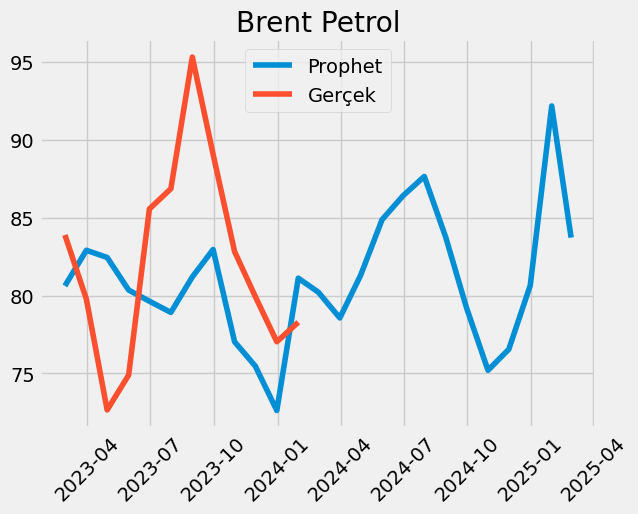

In [285]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-25:],label="Prophet")
plt.plot(brent1["BRENT"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [288]:
"""
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping

train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli optimize etmek için kullanılabilecek farklı parametre kombinasyonlarını deneme
layer_units = [64, 128]  # LSTM katmanındaki nöron sayısı
dense_units = [16,32,64,128]  # Yoğun katmandaki nöron sayısı
activations = ['relu', 'tanh','sigmoid','elu','selu']  # Aktivasyon fonksiyonları
learning_rates = [0.001, 0.01]  # Öğrenme hızı
optimizers = ['adam', 'sgd']  # Optimizer'lar

best_mse = float('inf')
best_model = None

for lstm_units in layer_units:
    for dense_unit in dense_units:
        for activation in activations:
            for learning_rate in learning_rates:
                for optimizer_name in optimizers:
                    try:
                        # Modeli oluşturma
                        model = Sequential()
                        model.add(LSTM(units=lstm_units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
                        model.add(Dense(units=dense_unit, activation=activation))
                        model.add(Dense(units=1))
                        
                        # Optimizer'ı ve learning rate'i ayarlama
                        if optimizer_name == 'adam':
                            optimizer = Adam(learning_rate=learning_rate)
                        elif optimizer_name == 'sgd':
                            optimizer = SGD(learning_rate=learning_rate)  # SGD için gerekirse import etmeyi unutmayın
                        
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        
                        # Modeli eğitme ve early stopping uygulama
                        model.fit(X_train, y_train, epochs=250, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)
                        
                        # Modeli değerlendirme
                        y_pred = model.predict(X_test)
                        mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))
                        
                        # En iyi modeli güncelleme
                        if mse < best_mse:
                            best_mse = mse
                            best_model = model
                    except Exception as e:
                        print(f'Hata oluştu: {e}')

# En iyi modelin MSE değerini ve kullanılan optimizer'ı yazdırma
print(f'En İyi Modelin Ortalama Kare Hatası (MSE): {best_mse}')
if best_model is not None:
    print(f'En İyi Modelde Kullanılan Optimizer: {best_model.optimizer.get_config()["name"]}')    

Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu:

In [289]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(brent1)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
keras.utils.set_random_seed(7)
model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/100
10/10 [==============================] - 1s 32ms/step - loss: 0.0746 - val_loss: 0.0861
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0214 - val_loss: 0.0249
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0111 - val_loss: 0.0395
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0274
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0061 - val_loss: 0.0252
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0053 - val_loss: 0.0220
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0278
Epoch 8/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 0.0259
Epoch 9/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 0.0219
Epoch 10/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0279
E

1/1 [==============================] - 0s 199ms/step


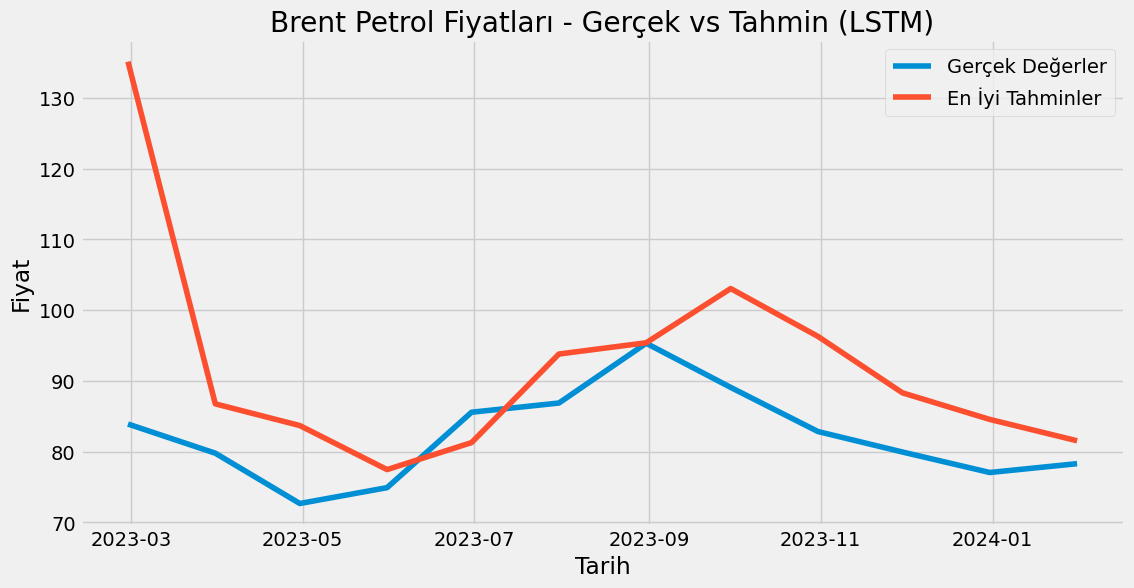

In [290]:
pred=scaler.inverse_transform(model.predict(X_test))
plt.figure(figsize=(12, 6))
plt.plot(brent1.index[-len(y_test):], scaler.inverse_transform(y_test), label='Gerçek Değerler')
plt.plot(brent1.index[-len(y_test):], pred, label='En İyi Tahminler')
plt.title('Brent Petrol Fiyatları - Gerçek vs Tahmin (LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

In [292]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(brent1)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [293]:
# generate the input and output sequences
n_lookback = 25  # length of input sequences (lookback period)
n_forecast = 25  # length of output sequences (forecast period)
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)
keras.utils.set_random_seed(0)
# fit the model
model = Sequential()
model.add(LSTM(units=128, activation='selu', return_sequences=True, input_shape=(n_lookback, 1)))
model.add(Dense(units=128, activation='selu'))  # Dense katmanı eklendi
model.add(Dense(units=1))  # Çıkış birimi sayısını 1 olarak değiştirildi

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=16, verbose=1)

# generate the forecasts
X_ = y[-n_lookback:]  # last available input sequence
#X_ = X_.reshape(1, n_lookback, 1)

# Tahmin yaparken çıkış şeklini düzenle
Y_ = model.predict(X_).reshape(1, n_forecast)

# Orijinal ölçekleme işlemi
Y_ = scaler.inverse_transform(Y_)

print(Y_)



Epoch 1/100
9/9 [==============================] - 1s 9ms/step - loss: 0.0842
Epoch 2/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0394
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0353
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0328
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0329
Epoch 6/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0328
Epoch 7/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0329
Epoch 8/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0312
Epoch 9/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0328
Epoch 10/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0331
Epoch 11/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0295
Epoch 12/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0296
Epoch 13/100
9/9 [==============================] - 0s 9ms

In [294]:
Y_=np.array(Y_).reshape(-1,1)

In [295]:
future=pd.DataFrame()
future["BRENT"]=brent1["BRENT"]
Y_=pd.DataFrame(Y_)
Y_.columns=["BRENT"]
Y_=Y_.set_index(pd.date_range(start="2024-01-31",periods=25,freq="M"))
future=pd.concat([future,Y_],axis=0)
future

BRENT
2007-07-31  72.690000
2007-08-31  79.170000
2007-09-30  90.630000
2007-10-31  88.260000
2007-11-30  93.850000
...               ...
2025-09-30  76.272758
2025-10-31  74.981384
2025-11-30  74.374557
2025-12-31  73.748215
2026-01-31  74.020340

[224 rows x 1 columns]

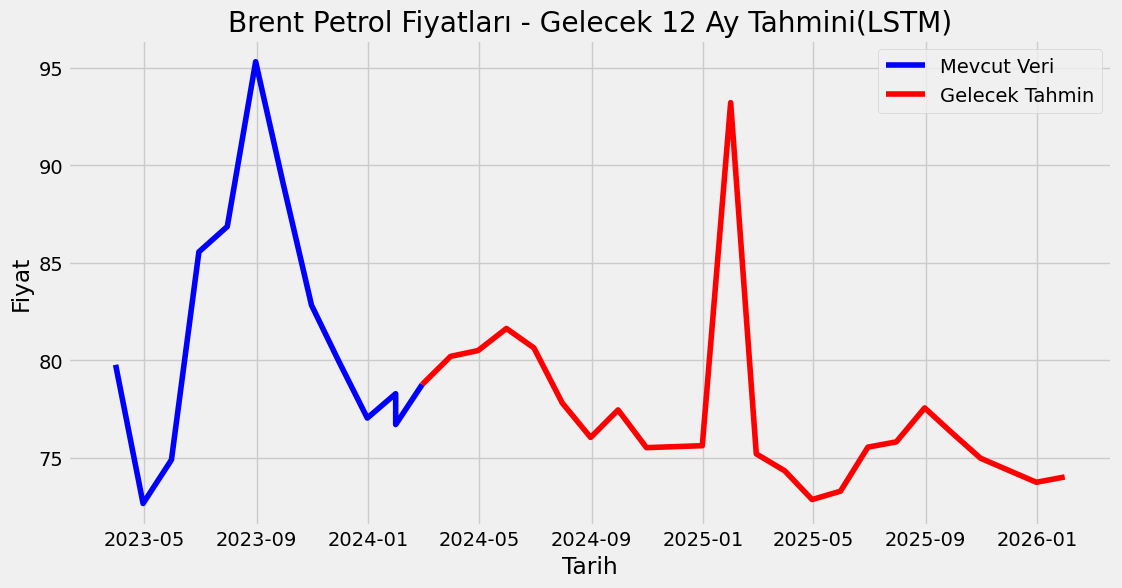

In [296]:
plt.figure(figsize=(12, 6))
#plt.plot(pred,label='Test Tahmini',color='green')
plt.plot(future["BRENT"][-36:-23], label='Mevcut Veri',color='blue')
plt.plot(future["BRENT"][-24:] ,label='Gelecek Tahmin',color='red')
plt.title('Brent Petrol Fiyatları - Gelecek 12 Ay Tahmini(LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


In [298]:
"""
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.0001,0.9999),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400),
                'm':trial.suggest_int('m',0,105)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_tahmin[params["m"]:].index
    sn["y"]=enf_tahmin[params["m"]:].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

[I 2024-01-16 15:07:58,371] A new study created in memory with name: no-name-3eb603d6-cfdf-4044-9914-56b01192d150
15:07:58 - cmdstanpy - INFO - Chain [1] start processing
15:08:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:08:05,659] Trial 0 finished with value: 1.7103786672920433e-07 and parameters: {'changepoint_prior_scale': 2.633247271624936, 'changepoint_range': 0.25592451160263396, 'growth': 'linear', 'seasonality_prior_scale': 8.408572691780765, 'n_changepoints': 19, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 328.13652773099824, 'm': 101}. Best is trial 0 with value: 1.7103786672920433e-07.
15:08:05 - cmdstanpy - INFO - Chain [1] start processing
15:08:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:08:06,064] Trial 1 finished with value: 8.817071699457653 and parameters: {'changepoint_prior_scale': 9.863401033175299, 'changepoint_range': 0.7863826404390447, 'growth': 'linear', 'seasonality_prior_scale': 1.2561839753892

15:09:06 - cmdstanpy - INFO - Chain [1] start processing
15:09:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:09:14,750] Trial 16 finished with value: 0.0038587595434928248 and parameters: {'changepoint_prior_scale': 8.210987687084751, 'changepoint_range': 0.6226792868095974, 'growth': 'logistic', 'seasonality_prior_scale': 4.618438932989478, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 353.33809761993814, 'm': 89}. Best is trial 5 with value: 8.601611355323828e-08.
15:09:14 - cmdstanpy - INFO - Chain [1] start processing
15:09:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:09:15,368] Trial 17 finished with value: 1.8346675186171137 and parameters: {'changepoint_prior_scale': 5.602020503236328, 'changepoint_range': 0.8911890762535953, 'growth': 'logistic', 'seasonality_prior_scale': 5.9917312608048645, 'n_changepoints': 39, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 258.876493847257

15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:11:41,289] Trial 32 finished with value: 1.3726127933508748e-08 and parameters: {'changepoint_prior_scale': 8.327337405486931, 'changepoint_range': 0.808636362892212, 'growth': 'logistic', 'seasonality_prior_scale': 2.306642122582256, 'n_changepoints': 35, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 356.5653751508059, 'm': 105}. Best is trial 19 with value: 6.673222807886297e-09.
15:11:41 - cmdstanpy - INFO - Chain [1] start processing
15:12:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:12:11,389] Trial 33 finished with value: 2.7227413202810693e-07 and parameters: {'changepoint_prior_scale': 8.147558607743981, 'changepoint_range': 0.8206187013985499, 'growth': 'logistic', 'seasonality_prior_scale': 2.3846683823571797, 'n_changepoints': 37, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 280.40001028

15:13:41 - cmdstanpy - INFO - Chain [1] start processing
15:13:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:13:41,453] Trial 48 finished with value: 2.466313663974744 and parameters: {'changepoint_prior_scale': 6.360978413897723, 'changepoint_range': 0.8375757975560942, 'growth': 'linear', 'seasonality_prior_scale': 3.917462255231598, 'n_changepoints': 28, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 322.9335292873045, 'm': 4}. Best is trial 19 with value: 6.673222807886297e-09.
15:13:41 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:14:03,055] Trial 49 finished with value: 8.359806950348736e-08 and parameters: {'changepoint_prior_scale': 9.51844213377499, 'changepoint_range': 0.9340836051084728, 'growth': 'logistic', 'seasonality_prior_scale': 1.2941148936380882, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 183.38050904794392, 'm':

15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:18:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:18:15,908] Trial 64 finished with value: 1.442822627043673e-07 and parameters: {'changepoint_prior_scale': 5.397832754751883, 'changepoint_range': 0.6689358995592395, 'growth': 'logistic', 'seasonality_prior_scale': 0.5238433212656577, 'n_changepoints': 30, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 362.5840557641864, 'm': 91}. Best is trial 51 with value: 9.659886431490222e-10.
15:18:16 - cmdstanpy - INFO - Chain [1] start processing
15:18:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:18:36,188] Trial 65 finished with value: 3.04411166462203e-08 and parameters: {'changepoint_prior_scale': 4.489555674970978, 'changepoint_range': 0.48551446471395326, 'growth': 'logistic', 'seasonality_prior_scale': 1.6219966980817793, 'n_changepoints': 36, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 319.1316969802

15:21:23 - cmdstanpy - INFO - Chain [1] start processing
15:21:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:21:25,086] Trial 80 finished with value: 0.008620863857667136 and parameters: {'changepoint_prior_scale': 6.591510298949435, 'changepoint_range': 0.8708718871975393, 'growth': 'linear', 'seasonality_prior_scale': 3.2903246947503924, 'n_changepoints': 26, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'cap': 328.99890274150755, 'm': 83}. Best is trial 51 with value: 9.659886431490222e-10.
15:21:25 - cmdstanpy - INFO - Chain [1] start processing
15:21:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:21:38,605] Trial 81 finished with value: 8.152084853745049e-08 and parameters: {'changepoint_prior_scale': 7.321801733358594, 'changepoint_range': 0.4987151658164582, 'growth': 'logistic', 'seasonality_prior_scale': 1.0431484702532414, 'n_changepoints': 31, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 311.741935445

15:23:53 - cmdstanpy - INFO - Chain [1] start processing
15:24:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:24:17,987] Trial 96 finished with value: 9.409939380627405e-08 and parameters: {'changepoint_prior_scale': 9.69109209370935, 'changepoint_range': 0.8441102229828734, 'growth': 'logistic', 'seasonality_prior_scale': 7.545577919288575, 'n_changepoints': 34, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 345.47601140873945, 'm': 96}. Best is trial 51 with value: 9.659886431490222e-10.
15:24:18 - cmdstanpy - INFO - Chain [1] start processing
15:24:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:24:18,407] Trial 97 finished with value: 21.02361554537668 and parameters: {'changepoint_prior_scale': 6.5127280471248215, 'changepoint_range': 0.23197234146314896, 'growth': 'linear', 'seasonality_prior_scale': 0.0023148927562689284, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 378.990392471054

15:27:00 - cmdstanpy - INFO - Chain [1] start processing
15:27:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:27:26,236] Trial 112 finished with value: 6.165961567633941e-08 and parameters: {'changepoint_prior_scale': 9.24591302785552, 'changepoint_range': 0.7966311230605083, 'growth': 'logistic', 'seasonality_prior_scale': 1.1407849952043652, 'n_changepoints': 19, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 235.21683692990558, 'm': 103}. Best is trial 51 with value: 9.659886431490222e-10.
15:27:26 - cmdstanpy - INFO - Chain [1] start processing
15:27:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:27:45,748] Trial 113 finished with value: 3.587893270041359e-08 and parameters: {'changepoint_prior_scale': 9.76219585993369, 'changepoint_range': 0.7737668720057066, 'growth': 'logistic', 'seasonality_prior_scale': 0.894690459952723, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 253.50566142

15:30:28 - cmdstanpy - INFO - Chain [1] start processing
15:30:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:30:52,005] Trial 128 finished with value: 6.447322935978755e-08 and parameters: {'changepoint_prior_scale': 8.266470845549547, 'changepoint_range': 0.8269473692540227, 'growth': 'logistic', 'seasonality_prior_scale': 0.9733278362009672, 'n_changepoints': 20, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 247.78082399764435, 'm': 100}. Best is trial 51 with value: 9.659886431490222e-10.
15:30:52 - cmdstanpy - INFO - Chain [1] start processing
15:31:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:31:16,806] Trial 129 finished with value: 1.39582709784022e-09 and parameters: {'changepoint_prior_scale': 8.801991113197323, 'changepoint_range': 0.8857168665534871, 'growth': 'logistic', 'seasonality_prior_scale': 0.1844667333898442, 'n_changepoints': 35, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 355.79387207

15:36:35 - cmdstanpy - INFO - Chain [1] start processing
15:37:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:37:02,265] Trial 144 finished with value: 2.1562940816433475e-09 and parameters: {'changepoint_prior_scale': 9.23428582199123, 'changepoint_range': 0.9680283531612159, 'growth': 'logistic', 'seasonality_prior_scale': 0.15269031630174978, 'n_changepoints': 42, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 355.6429245113873, 'm': 103}. Best is trial 143 with value: 2.7332374069118985e-10.
15:37:02 - cmdstanpy - INFO - Chain [1] start processing
15:37:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:37:31,697] Trial 145 finished with value: 1.1635684439480411e-07 and parameters: {'changepoint_prior_scale': 9.24629984580539, 'changepoint_range': 0.9837829651192318, 'growth': 'logistic', 'seasonality_prior_scale': 0.2157674115585756, 'n_changepoints': 39, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 355.522

[I 2024-01-16 15:42:47,578] Trial 159 finished with value: 9.494129767552706e-07 and parameters: {'changepoint_prior_scale': 9.040939086812605, 'changepoint_range': 0.859794047906479, 'growth': 'logistic', 'seasonality_prior_scale': 0.3209192500118988, 'n_changepoints': 35, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 346.0396442342405, 'm': 95}. Best is trial 143 with value: 2.7332374069118985e-10.
15:42:47 - cmdstanpy - INFO - Chain [1] start processing
15:43:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:43:15,928] Trial 160 finished with value: 7.005025034661889e-09 and parameters: {'changepoint_prior_scale': 9.697846488188576, 'changepoint_range': 0.976587348312877, 'growth': 'logistic', 'seasonality_prior_scale': 1.1268218906551442, 'n_changepoints': 44, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 354.2703955584106, 'm': 103}. Best is trial 143 with value: 2.7332374069118985e-10.
15:43:16 - cmdstanpy - INFO - Chain [1] 

15:47:47 - cmdstanpy - INFO - Chain [1] start processing
15:48:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:48:01,746] Trial 175 finished with value: 4.256048982358858e-09 and parameters: {'changepoint_prior_scale': 9.176324319688218, 'changepoint_range': 0.7143296999540755, 'growth': 'logistic', 'seasonality_prior_scale': 0.4487105290094506, 'n_changepoints': 39, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 258.6503692903369, 'm': 105}. Best is trial 143 with value: 2.7332374069118985e-10.
15:48:01 - cmdstanpy - INFO - Chain [1] start processing
15:48:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:48:15,978] Trial 176 finished with value: 5.990055845623154e-09 and parameters: {'changepoint_prior_scale': 9.174192697200294, 'changepoint_range': 0.7114082360122157, 'growth': 'logistic', 'seasonality_prior_scale': 0.36600229219649294, 'n_changepoints': 39, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 369.257

15:52:06 - cmdstanpy - INFO - Chain [1] start processing
15:52:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:52:32,225] Trial 191 finished with value: 2.760160780329411e-09 and parameters: {'changepoint_prior_scale': 9.163503184643154, 'changepoint_range': 0.8292716978621015, 'growth': 'logistic', 'seasonality_prior_scale': 0.5211941851681955, 'n_changepoints': 36, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 265.2412054209386, 'm': 103}. Best is trial 143 with value: 2.7332374069118985e-10.
15:52:32 - cmdstanpy - INFO - Chain [1] start processing
15:52:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:52:56,125] Trial 192 finished with value: 3.5035912574425507e-08 and parameters: {'changepoint_prior_scale': 9.333379919888817, 'changepoint_range': 0.8084778685364921, 'growth': 'logistic', 'seasonality_prior_scale': 0.2533513495840438, 'n_changepoints': 36, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 247.292

15:57:05 - cmdstanpy - INFO - Chain [1] start processing
15:57:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:57:28,532] Trial 207 finished with value: 6.7430952901441845e-09 and parameters: {'changepoint_prior_scale': 9.8220889375281, 'changepoint_range': 0.6518435708412265, 'growth': 'logistic', 'seasonality_prior_scale': 0.2064485775651555, 'n_changepoints': 34, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 389.92466006469465, 'm': 103}. Best is trial 143 with value: 2.7332374069118985e-10.
15:57:28 - cmdstanpy - INFO - Chain [1] start processing
15:57:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 15:57:32,654] Trial 208 finished with value: 0.012917126846507258 and parameters: {'changepoint_prior_scale': 9.185596333592002, 'changepoint_range': 0.7612377607303099, 'growth': 'logistic', 'seasonality_prior_scale': 0.43246094876851543, 'n_changepoints': 37, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 362.1412

16:01:30 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:01:56,257] Trial 223 finished with value: 4.795285334050657e-09 and parameters: {'changepoint_prior_scale': 9.638272905687343, 'changepoint_range': 0.879655281269778, 'growth': 'logistic', 'seasonality_prior_scale': 0.38780510967293946, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 365.68875474198614, 'm': 103}. Best is trial 143 with value: 2.7332374069118985e-10.
16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:02:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:02:16,094] Trial 224 finished with value: 2.2711748810995142e-07 and parameters: {'changepoint_prior_scale': 4.829235099194455, 'changepoint_range': 0.8343544110985786, 'growth': 'logistic', 'seasonality_prior_scale': 0.00942432402441698, 'n_changepoints': 40, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 354.8

16:06:04 - cmdstanpy - INFO - Chain [1] start processing
16:06:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:06:24,367] Trial 239 finished with value: 2.1257348445457236e-08 and parameters: {'changepoint_prior_scale': 9.6094761198201, 'changepoint_range': 0.6892761810382709, 'growth': 'logistic', 'seasonality_prior_scale': 0.9607724561835997, 'n_changepoints': 46, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 376.79529331980643, 'm': 102}. Best is trial 143 with value: 2.7332374069118985e-10.
16:06:24 - cmdstanpy - INFO - Chain [1] start processing
16:06:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:06:40,331] Trial 240 finished with value: 2.663939245109871e-07 and parameters: {'changepoint_prior_scale': 8.45895204422683, 'changepoint_range': 0.6449327123717999, 'growth': 'logistic', 'seasonality_prior_scale': 0.3257572693838458, 'n_changepoints': 37, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 384.75182

In [299]:
model=auto_arima(enf_tahmin,trace=False,information_criterion='aic',seasonal=True,m=5)
enf_tahmintahmin1=model.predict(25)
enf_tahmintahmin1=pd.DataFrame(enf_tahmintahmin1)
enf_tahmintahmin1.columns=["Enflasyon Tahmini"]
row=pd.DataFrame({"Enflasyon Tahmini":enf_tahmin.iloc[-1:,0]},index=pd.date_range(start="2023-12-30",periods=1,freq="1M"))
enf_tahmintahmin1=pd.concat([row,enf_tahmintahmin1],axis=0)
enf_tahmintahmin1


Enflasyon Tahmini
2023-12-31          41.230000
2024-01-31          41.532711
2024-02-29          41.589358
2024-03-31          40.620016
2024-04-30          40.040023
2024-05-31          40.040366
2024-06-30          42.708126
2024-07-31          43.618352
2024-08-31          43.303038
2024-09-30          42.686887
2024-10-31          42.302020
2024-11-30          44.413303
2024-12-31          45.091588
2025-01-31          44.755840
2025-02-28          44.186582
2025-03-31          43.833745
2025-04-30          45.660181
2025-05-31          46.244782
2025-06-30          45.949879
2025-07-31          45.453205
2025-08-31          45.145479
2025-09-30          46.733536
2025-10-31          47.241734
2025-11-30          46.985110
2025-12-31          46.553061
2026-01-31          46.285381

In [300]:
((usdtahmin1[2:].pct_change(periods=1)*100).dropna())

USD/TRY
2023-11-30  2.840498
2023-12-31  1.528701
2024-01-31  2.744818
2024-02-29  1.496202
2024-03-31  7.105242
2024-04-30  6.830571
2024-05-31  6.182434
2024-06-30  3.828187
2024-07-31  2.834391
2024-08-31  4.715990
2024-09-30  4.407601
2024-10-31  4.310414
2024-11-30  4.413022
2024-12-31  4.996121
2025-01-31  1.760443
2025-02-28  2.406855

In [301]:
((future[-29:-11].pct_change(periods=1)*100).dropna())

BRENT
2023-11-30  -3.495110
2023-12-31  -3.621693
2024-01-31   1.622534
2024-01-31  -2.022524
2024-02-29   2.682850
2024-03-31   1.827366
2024-04-30   0.369513
2024-05-31   1.405682
2024-06-30  -1.216219
2024-07-31  -3.503683
2024-08-31  -2.271672
2024-09-30   1.857499
2024-10-31  -2.498592
2024-11-30   0.065805
2024-12-31   0.065772
2025-01-31  23.257664
2025-02-28 -19.318980

In [303]:
"""
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["M2 Para Arzi"].index
    sn["y"]=money["M2 Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["M2 Para Arzi"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-01-16 16:12:19,556] A new study created in memory with name: no-name-762aeb8b-95eb-4068-9b6c-31ef30d67abb
16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:12:20,055] Trial 0 finished with value: 109.11863802222658 and parameters: {'changepoint_prior_scale': 7.45283869409814, 'changepoint_range': 0.589183721688542, 'growth': 'linear', 'seasonality_prior_scale': 1.2682163890956313, 'n_changepoints': 40, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 0 with value: 109.11863802222658.
16:12:20 - cmdstanpy - INFO - Chain [1] start processing
16:12:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:12:20,542] Trial 1 finished with value: 239.5337842113133 and parameters: {'changepoint_prior_scale': 1.981689901281108, 'changepoint_range': 0.3031876981647761, 'growth': 'linear', 'seasonality_prior_scale': 8.103558895746913, 'n_changepoints': 7, 'yearly_seasonality':

16:12:27 - cmdstanpy - INFO - Chain [1] start processing
16:12:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:12:27,720] Trial 17 finished with value: 2.755062513926273 and parameters: {'changepoint_prior_scale': 6.219187122744357, 'changepoint_range': 0.8976356988098331, 'growth': 'linear', 'seasonality_prior_scale': 3.6457534253635933, 'n_changepoints': 12, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 17 with value: 2.755062513926273.
16:12:27 - cmdstanpy - INFO - Chain [1] start processing
16:12:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:12:28,216] Trial 18 finished with value: 3.4205940867128017 and parameters: {'changepoint_prior_scale': 6.227873826124978, 'changepoint_range': 0.864651169339957, 'growth': 'linear', 'seasonality_prior_scale': 3.2777227262675463, 'n_changepoints': 30, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 17 with value: 2.755062513926273.
16:12:28 - cmdstanpy -

16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:12:40,679] Trial 34 finished with value: 24.597389666901822 and parameters: {'changepoint_prior_scale': 7.482781565223724, 'changepoint_range': 0.7807056458460592, 'growth': 'linear', 'seasonality_prior_scale': 1.5454098399744045, 'n_changepoints': 44, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 31 with value: 2.1935701277635995.
16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:12:41,282] Trial 35 finished with value: 7.9180050087918525 and parameters: {'changepoint_prior_scale': 8.797175114289619, 'changepoint_range': 0.8343422254733387, 'growth': 'linear', 'seasonality_prior_scale': 2.5120146136902353, 'n_changepoints': 32, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 31 with value: 2.1935701277635995.
16:12:41 - cmdstan

16:12:50 - cmdstanpy - INFO - Chain [1] start processing
16:12:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:12:51,461] Trial 51 finished with value: 2.389591456565523 and parameters: {'changepoint_prior_scale': 9.375157444381017, 'changepoint_range': 0.894826421331645, 'growth': 'linear', 'seasonality_prior_scale': 8.45663261929208, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 48 with value: 2.1920372650835867.
16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:12:51,977] Trial 52 finished with value: 2.206935806886274 and parameters: {'changepoint_prior_scale': 3.163116999165466, 'changepoint_range': 0.8995144938343477, 'growth': 'linear', 'seasonality_prior_scale': 7.074239254564732, 'n_changepoints': 30, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 48 with value: 2.1920372650835867.
16:12:52 - cmdstanpy - INFO 

16:12:59 - cmdstanpy - INFO - Chain [1] start processing
16:13:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:00,175] Trial 68 finished with value: 2.190840461165134 and parameters: {'changepoint_prior_scale': 3.5458250970046343, 'changepoint_range': 0.8986504141548216, 'growth': 'linear', 'seasonality_prior_scale': 8.229511637496508, 'n_changepoints': 32, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 68 with value: 2.190840461165134.
16:13:00 - cmdstanpy - INFO - Chain [1] start processing
16:13:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:01,620] Trial 69 finished with value: 308.5150037183411 and parameters: {'changepoint_prior_scale': 3.41103172620623, 'changepoint_range': 0.10943138775462175, 'growth': 'linear', 'seasonality_prior_scale': 8.49414146530354, 'n_changepoints': 32, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 68 with value: 2.190840461165134.
16:13:01 - cmdstanpy - IN

16:13:11 - cmdstanpy - INFO - Chain [1] start processing
16:13:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:12,040] Trial 85 finished with value: 7.748186899716425 and parameters: {'changepoint_prior_scale': 4.767156786348167, 'changepoint_range': 0.8340574830785075, 'growth': 'linear', 'seasonality_prior_scale': 1.114459982304396, 'n_changepoints': 36, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 68 with value: 2.190840461165134.
16:13:12 - cmdstanpy - INFO - Chain [1] start processing
16:13:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:12,616] Trial 86 finished with value: 16.841004248381108 and parameters: {'changepoint_prior_scale': 7.260899460829541, 'changepoint_range': 0.8076950660426013, 'growth': 'linear', 'seasonality_prior_scale': 7.1883958095328175, 'n_changepoints': 32, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 68 with value: 2.190840461165134.
16:13:12 - cmdstanpy -

16:13:22 - cmdstanpy - INFO - Chain [1] start processing
16:13:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:22,854] Trial 102 finished with value: 2.56580624296181 and parameters: {'changepoint_prior_scale': 5.147210823159086, 'changepoint_range': 0.8831204856181061, 'growth': 'linear', 'seasonality_prior_scale': 8.852784002151818, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:13:23 - cmdstanpy - INFO - Chain [1] start processing
16:13:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:23,380] Trial 103 finished with value: 229.37059636982025 and parameters: {'changepoint_prior_scale': 4.002199081503385, 'changepoint_range': 0.31965392175849416, 'growth': 'linear', 'seasonality_prior_scale': 9.36094430079409, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:13:23 - cmdstanpy - INF

16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:32,537] Trial 119 finished with value: 2.2577206000918113 and parameters: {'changepoint_prior_scale': 5.602998577463927, 'changepoint_range': 0.8986100072873643, 'growth': 'linear', 'seasonality_prior_scale': 7.577562307705903, 'n_changepoints': 32, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 98 with value: 2.122358234367448.
16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:33,099] Trial 120 finished with value: 6.022632534626785 and parameters: {'changepoint_prior_scale': 4.97202078336229, 'changepoint_range': 0.8454469212493477, 'growth': 'linear', 'seasonality_prior_scale': 5.384174381971292, 'n_changepoints': 29, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:13:33 - cmdstanpy - I

16:13:42 - cmdstanpy - INFO - Chain [1] start processing
16:13:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:42,751] Trial 136 finished with value: 2.8284188232571665 and parameters: {'changepoint_prior_scale': 2.2547589207187713, 'changepoint_range': 0.8706280590652689, 'growth': 'linear', 'seasonality_prior_scale': 8.872213226804417, 'n_changepoints': 26, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:13:42 - cmdstanpy - INFO - Chain [1] start processing
16:13:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:43,380] Trial 137 finished with value: 6.041454558098884 and parameters: {'changepoint_prior_scale': 3.060797465821148, 'changepoint_range': 0.8432678159183797, 'growth': 'linear', 'seasonality_prior_scale': 8.561586968213524, 'n_changepoints': 28, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:13:43 - cmdstanpy - I

16:13:51 - cmdstanpy - INFO - Chain [1] start processing
16:13:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:52,128] Trial 153 finished with value: 2.3059938151411097 and parameters: {'changepoint_prior_scale': 3.898396018732069, 'changepoint_range': 0.8967187788940856, 'growth': 'linear', 'seasonality_prior_scale': 8.931149962906916, 'n_changepoints': 30, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:13:52 - cmdstanpy - INFO - Chain [1] start processing
16:13:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:13:52,657] Trial 154 finished with value: 2.8255322410500487 and parameters: {'changepoint_prior_scale': 2.2955275325878066, 'changepoint_range': 0.8748532286086672, 'growth': 'linear', 'seasonality_prior_scale': 8.394203639069731, 'n_changepoints': 29, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:13:52 - cmdstanpy - 

16:14:00 - cmdstanpy - INFO - Chain [1] start processing
16:14:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:01,012] Trial 170 finished with value: 3.0182846229305547 and parameters: {'changepoint_prior_scale': 5.2703198757797, 'changepoint_range': 0.8739335507868423, 'growth': 'linear', 'seasonality_prior_scale': 9.0187438157795, 'n_changepoints': 28, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:14:01 - cmdstanpy - INFO - Chain [1] start processing
16:14:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:01,538] Trial 171 finished with value: 2.5822106569343473 and parameters: {'changepoint_prior_scale': 5.662038741154825, 'changepoint_range': 0.8854537985556087, 'growth': 'linear', 'seasonality_prior_scale': 7.7461490424494714, 'n_changepoints': 29, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:14:01 - cmdstanpy - INF

16:14:10 - cmdstanpy - INFO - Chain [1] start processing
16:14:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:11,089] Trial 187 finished with value: 147.46849924461407 and parameters: {'changepoint_prior_scale': 3.980306391443656, 'changepoint_range': 0.5103790057244526, 'growth': 'linear', 'seasonality_prior_scale': 6.7773337787479715, 'n_changepoints': 26, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:14:11 - cmdstanpy - INFO - Chain [1] start processing
16:14:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:12,572] Trial 188 finished with value: 2.71089502488347 and parameters: {'changepoint_prior_scale': 4.218894285574925, 'changepoint_range': 0.8816064750749086, 'growth': 'linear', 'seasonality_prior_scale': 7.436902276348976, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 98 with value: 2.122358234367448.
16:14:12 - cmdstanpy -

16:14:20 - cmdstanpy - INFO - Chain [1] start processing
16:14:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:20,726] Trial 204 finished with value: 2.179136198557377 and parameters: {'changepoint_prior_scale': 4.997062737681675, 'changepoint_range': 0.8998030636956296, 'growth': 'linear', 'seasonality_prior_scale': 9.14130528801808, 'n_changepoints': 28, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:14:20 - cmdstanpy - INFO - Chain [1] start processing
16:14:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:21,302] Trial 205 finished with value: 2.672726445212121 and parameters: {'changepoint_prior_scale': 4.9405846955579635, 'changepoint_range': 0.8829632424623216, 'growth': 'linear', 'seasonality_prior_scale': 9.19223516264235, 'n_changepoints': 29, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:14:21 - cmdstanpy - INFO

16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:32,564] Trial 221 finished with value: 2.158881170528139 and parameters: {'changepoint_prior_scale': 4.020644355812632, 'changepoint_range': 0.8993402503045901, 'growth': 'linear', 'seasonality_prior_scale': 7.297144321046338, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:33,197] Trial 222 finished with value: 2.139682046942168 and parameters: {'changepoint_prior_scale': 3.719255718173641, 'changepoint_range': 0.8996864833238036, 'growth': 'linear', 'seasonality_prior_scale': 7.3202899753832495, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 98 with value: 2.122358234367448.
16:14:33 - cmdstanpy - IN

16:14:42 - cmdstanpy - INFO - Chain [1] start processing
16:14:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:42,391] Trial 238 finished with value: 2.3298619591779133 and parameters: {'changepoint_prior_scale': 4.896742720608887, 'changepoint_range': 0.8969807092970478, 'growth': 'linear', 'seasonality_prior_scale': 7.3087745159294535, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 235 with value: 2.114729865401754.
16:14:42 - cmdstanpy - INFO - Chain [1] start processing
16:14:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:43,110] Trial 239 finished with value: 2.096233674620976 and parameters: {'changepoint_prior_scale': 7.683534416224841, 'changepoint_range': 0.8996084235307331, 'growth': 'linear', 'seasonality_prior_scale': 7.871320961507836, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 239 with value: 2.096233674620976.
16:14:43 - cmdstanpy -

16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:54,557] Trial 255 finished with value: 2.5410088760439558 and parameters: {'changepoint_prior_scale': 9.921074171558663, 'changepoint_range': 0.8702332090076956, 'growth': 'linear', 'seasonality_prior_scale': 7.008117192577832, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:14:55,126] Trial 256 finished with value: 2.116416987238429 and parameters: {'changepoint_prior_scale': 7.065490075700824, 'changepoint_range': 0.8995980853094877, 'growth': 'linear', 'seasonality_prior_scale': 7.356735165941371, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:14:55 - cmdstanpy - 

16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:06,193] Trial 272 finished with value: 2.4993239230154836 and parameters: {'changepoint_prior_scale': 7.181118797824129, 'changepoint_range': 0.8823534695308098, 'growth': 'linear', 'seasonality_prior_scale': 7.04167004787374, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:15:06 - cmdstanpy - INFO - Chain [1] start processing
16:15:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:06,777] Trial 273 finished with value: 2.125959713647836 and parameters: {'changepoint_prior_scale': 6.694488435959154, 'changepoint_range': 0.8996071327119822, 'growth': 'linear', 'seasonality_prior_scale': 7.123763300774653, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:15:07 - cmdstanpy - I

16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:16,638] Trial 289 finished with value: 69.86231013959166 and parameters: {'changepoint_prior_scale': 7.104294066763626, 'changepoint_range': 0.6728137935667833, 'growth': 'linear', 'seasonality_prior_scale': 6.670044778462767, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 250 with value: 2.050049093516566.
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:17,246] Trial 290 finished with value: 2.0912231624215325 and parameters: {'changepoint_prior_scale': 6.4451823556544685, 'changepoint_range': 0.8999966373727196, 'growth': 'linear', 'seasonality_prior_scale': 6.537244110842806, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:15:17 - cmdstanpy 

16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:27,479] Trial 306 finished with value: 2.1159368103863128 and parameters: {'changepoint_prior_scale': 7.073004171068683, 'changepoint_range': 0.8998979671153173, 'growth': 'linear', 'seasonality_prior_scale': 6.8284490922726855, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:28,064] Trial 307 finished with value: 2.4695710566019082 and parameters: {'changepoint_prior_scale': 7.174649200426197, 'changepoint_range': 0.8846949639311367, 'growth': 'linear', 'seasonality_prior_scale': 6.882012511169238, 'n_changepoints': 46, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:15:29 - cmdstanpy 

16:15:39 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:40,429] Trial 323 finished with value: 2.558730638213064 and parameters: {'changepoint_prior_scale': 6.791411438863265, 'changepoint_range': 0.8824694277922445, 'growth': 'linear', 'seasonality_prior_scale': 6.690955597772693, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:41,068] Trial 324 finished with value: 2.083428225384236 and parameters: {'changepoint_prior_scale': 9.686317764411458, 'changepoint_range': 0.8995379314907708, 'growth': 'linear', 'seasonality_prior_scale': 5.2331191302538995, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:15:41 - cmdstanpy - 

16:15:50 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:51,108] Trial 340 finished with value: 2.4928384019397956 and parameters: {'changepoint_prior_scale': 7.210940029912907, 'changepoint_range': 0.8847352014918936, 'growth': 'linear', 'seasonality_prior_scale': 6.765370329680179, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:15:51 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:15:51,761] Trial 341 finished with value: 5.794810914596384 and parameters: {'changepoint_prior_scale': 6.869697419356822, 'changepoint_range': 0.8469259263123353, 'growth': 'linear', 'seasonality_prior_scale': 7.175239216433005, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:15:51 - cmdstanpy - 

16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:02,612] Trial 357 finished with value: 5.7964864568205785 and parameters: {'changepoint_prior_scale': 7.606791354247017, 'changepoint_range': 0.8471877730630754, 'growth': 'linear', 'seasonality_prior_scale': 7.011892152721827, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:03,181] Trial 358 finished with value: 2.1912973067383152 and parameters: {'changepoint_prior_scale': 6.507124402069909, 'changepoint_range': 0.8995893971692783, 'growth': 'linear', 'seasonality_prior_scale': 6.208236537661682, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 250 with value: 2.050049093516566.
16:16:03 - cmdstanpy 

16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:14,188] Trial 374 finished with value: 2.188328068530609 and parameters: {'changepoint_prior_scale': 7.4291524658676575, 'changepoint_range': 0.8995136429798772, 'growth': 'linear', 'seasonality_prior_scale': 6.8728992412992005, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 250 with value: 2.050049093516566.
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:14,843] Trial 375 finished with value: 2.452076433461324 and parameters: {'changepoint_prior_scale': 9.66990503105872, 'changepoint_range': 0.8749542299096456, 'growth': 'linear', 'seasonality_prior_scale': 7.238512745753775, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:16:15 - cmdstanpy 

16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:25,483] Trial 391 finished with value: 2.5277333119546634 and parameters: {'changepoint_prior_scale': 6.71763891253112, 'changepoint_range': 0.8768190122518871, 'growth': 'linear', 'seasonality_prior_scale': 6.015983102931104, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:16:25 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:27,099] Trial 392 finished with value: 2.390871113332813 and parameters: {'changepoint_prior_scale': 8.006699801916126, 'changepoint_range': 0.8863686373385016, 'growth': 'linear', 'seasonality_prior_scale': 6.304644419616377, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:16:27 - cmdstanpy - I

16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:36,820] Trial 408 finished with value: 2.475432943535099 and parameters: {'changepoint_prior_scale': 9.488847632221418, 'changepoint_range': 0.8745840942863337, 'growth': 'linear', 'seasonality_prior_scale': 7.625242799225276, 'n_changepoints': 46, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:37,395] Trial 409 finished with value: 2.4127687778902223 and parameters: {'changepoint_prior_scale': 7.255089615297996, 'changepoint_range': 0.8843068518100492, 'growth': 'linear', 'seasonality_prior_scale': 4.670056659424167, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:16:37 - cmdstanpy - 

16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:48,430] Trial 425 finished with value: 4.852764838300444 and parameters: {'changepoint_prior_scale': 7.5198671773244286, 'changepoint_range': 0.8539578752642014, 'growth': 'linear', 'seasonality_prior_scale': 6.072625803039578, 'n_changepoints': 19, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:49,073] Trial 426 finished with value: 2.0681898210463916 and parameters: {'changepoint_prior_scale': 8.44799430127688, 'changepoint_range': 0.8998100116283485, 'growth': 'linear', 'seasonality_prior_scale': 6.40335657734431, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:16:49 - cmdstanpy - I

16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:16:59,808] Trial 442 finished with value: 2.6661395913392565 and parameters: {'changepoint_prior_scale': 8.146410045993365, 'changepoint_range': 0.8693337475845083, 'growth': 'linear', 'seasonality_prior_scale': 5.970003218891324, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:00,402] Trial 443 finished with value: 77.64063719476174 and parameters: {'changepoint_prior_scale': 8.823443768532591, 'changepoint_range': 0.653743591074922, 'growth': 'linear', 'seasonality_prior_scale': 5.751630769206839, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 250 with value: 2.050049093516566.
16:17:00 - cmdstanpy -

16:17:11 - cmdstanpy - INFO - Chain [1] start processing
16:17:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:11,576] Trial 459 finished with value: 2.393327494325694 and parameters: {'changepoint_prior_scale': 8.866456435939531, 'changepoint_range': 0.8849139246314784, 'growth': 'linear', 'seasonality_prior_scale': 5.8541609970963835, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:11 - cmdstanpy - INFO - Chain [1] start processing
16:17:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:12,246] Trial 460 finished with value: 2.4096308419538737 and parameters: {'changepoint_prior_scale': 8.61864823915969, 'changepoint_range': 0.8858918443931891, 'growth': 'linear', 'seasonality_prior_scale': 5.948293270566729, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:12 - cmdstanpy - 

16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:22,389] Trial 476 finished with value: 2.465161057541584 and parameters: {'changepoint_prior_scale': 9.46438405563587, 'changepoint_range': 0.8850941631148821, 'growth': 'linear', 'seasonality_prior_scale': 6.327334309079972, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:23,062] Trial 477 finished with value: 2.0616439198841485 and parameters: {'changepoint_prior_scale': 8.813547451862632, 'changepoint_range': 0.8994478232711454, 'growth': 'linear', 'seasonality_prior_scale': 5.795409875832947, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:23 - cmdstanpy - I

16:17:33 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:33,420] Trial 493 finished with value: 2.8762886558999434 and parameters: {'changepoint_prior_scale': 9.12901311367324, 'changepoint_range': 0.8728868809064779, 'growth': 'linear', 'seasonality_prior_scale': 5.618252023548977, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:33 - cmdstanpy - INFO - Chain [1] start processing
16:17:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:34,163] Trial 494 finished with value: 2.3851194584018116 and parameters: {'changepoint_prior_scale': 8.538031621095136, 'changepoint_range': 0.8874962263436708, 'growth': 'linear', 'seasonality_prior_scale': 5.969418585585656, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:34 - cmdstanpy - 

16:17:43 - cmdstanpy - INFO - Chain [1] start processing
16:17:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:44,119] Trial 510 finished with value: 2.4574953302440297 and parameters: {'changepoint_prior_scale': 9.183411772293699, 'changepoint_range': 0.886127072284407, 'growth': 'linear', 'seasonality_prior_scale': 6.300897531730959, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:44,736] Trial 511 finished with value: 2.5179161207872602 and parameters: {'changepoint_prior_scale': 9.650581054146336, 'changepoint_range': 0.8719377609020357, 'growth': 'linear', 'seasonality_prior_scale': 6.106295656162248, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:44 - cmdstanpy - 

16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:56,838] Trial 527 finished with value: 2.114863738841873 and parameters: {'changepoint_prior_scale': 8.501676462420889, 'changepoint_range': 0.8995610196167295, 'growth': 'linear', 'seasonality_prior_scale': 6.394038275910359, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:57 - cmdstanpy - INFO - Chain [1] start processing
16:17:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:17:57,555] Trial 528 finished with value: 2.484731840170079 and parameters: {'changepoint_prior_scale': 9.018858083161742, 'changepoint_range': 0.8732753989578472, 'growth': 'linear', 'seasonality_prior_scale': 5.589284104520467, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:17:57 - cmdstanpy - I

16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:07,439] Trial 544 finished with value: 2.3828444396040394 and parameters: {'changepoint_prior_scale': 8.213581478192987, 'changepoint_range': 0.8863456926191607, 'growth': 'linear', 'seasonality_prior_scale': 4.877216819655461, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:08,145] Trial 545 finished with value: 2.0747918718076086 and parameters: {'changepoint_prior_scale': 8.93034582112773, 'changepoint_range': 0.8993101214448405, 'growth': 'linear', 'seasonality_prior_scale': 6.0912225205223125, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:08 - cmdstanpy -

16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:19,119] Trial 561 finished with value: 3.1739228395054773 and parameters: {'changepoint_prior_scale': 8.493566631694687, 'changepoint_range': 0.866459371349441, 'growth': 'linear', 'seasonality_prior_scale': 6.294490557044537, 'n_changepoints': 45, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:19,837] Trial 562 finished with value: 2.0514131691291775 and parameters: {'changepoint_prior_scale': 9.287126370689752, 'changepoint_range': 0.8999173871997601, 'growth': 'linear', 'seasonality_prior_scale': 6.113162495566196, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:20 - cmdstanpy -

16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:32,766] Trial 578 finished with value: 2.06311245607216 and parameters: {'changepoint_prior_scale': 9.702089732604163, 'changepoint_range': 0.899847615831675, 'growth': 'linear', 'seasonality_prior_scale': 5.756256565110068, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:33,724] Trial 579 finished with value: 2.4044732259833665 and parameters: {'changepoint_prior_scale': 9.990782527439116, 'changepoint_range': 0.8844273923628566, 'growth': 'linear', 'seasonality_prior_scale': 5.975835215646672, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:34 - cmdstanpy - IN

16:18:46 - cmdstanpy - INFO - Chain [1] start processing
16:18:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:46,950] Trial 595 finished with value: 11.264558903462383 and parameters: {'changepoint_prior_scale': 9.392756691658358, 'changepoint_range': 0.8232992612497794, 'growth': 'linear', 'seasonality_prior_scale': 5.715864863661238, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:47 - cmdstanpy - INFO - Chain [1] start processing
16:18:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:47,652] Trial 596 finished with value: 2.1038522442339236 and parameters: {'changepoint_prior_scale': 8.892777226863062, 'changepoint_range': 0.8999419021201903, 'growth': 'linear', 'seasonality_prior_scale': 6.456056185949725, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:47 - cmdstanpy -

16:18:58 - cmdstanpy - INFO - Chain [1] start processing
16:18:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:58,983] Trial 612 finished with value: 2.07585160311531 and parameters: {'changepoint_prior_scale': 9.527585134173233, 'changepoint_range': 0.8992867767748237, 'growth': 'linear', 'seasonality_prior_scale': 6.199251601600466, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:18:59,577] Trial 613 finished with value: 2.1595044087306294 and parameters: {'changepoint_prior_scale': 9.817246737233194, 'changepoint_range': 0.8991810578415943, 'growth': 'linear', 'seasonality_prior_scale': 6.0913320751622715, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:18:59 - cmdstanpy - 

16:19:11 - cmdstanpy - INFO - Chain [1] start processing
16:19:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:12,031] Trial 629 finished with value: 2.3901443696587994 and parameters: {'changepoint_prior_scale': 8.507203780489307, 'changepoint_range': 0.8843894914117898, 'growth': 'linear', 'seasonality_prior_scale': 5.543882029675406, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:12 - cmdstanpy - INFO - Chain [1] start processing
16:19:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:12,680] Trial 630 finished with value: 2.089551150466111 and parameters: {'changepoint_prior_scale': 9.070358331276324, 'changepoint_range': 0.899843545806347, 'growth': 'linear', 'seasonality_prior_scale': 5.950966249341906, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:12 - cmdstanpy - I

16:19:23 - cmdstanpy - INFO - Chain [1] start processing
16:19:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:23,994] Trial 646 finished with value: 2.3203130359523034 and parameters: {'changepoint_prior_scale': 9.447600403236542, 'changepoint_range': 0.8861971713141549, 'growth': 'linear', 'seasonality_prior_scale': 5.83045033990687, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:24,713] Trial 647 finished with value: 12.424919756158452 and parameters: {'changepoint_prior_scale': 9.969252188236204, 'changepoint_range': 0.8152589747641339, 'growth': 'linear', 'seasonality_prior_scale': 6.153553250715084, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:24 - cmdstanpy - 

16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:34,748] Trial 663 finished with value: 2.3932900331931726 and parameters: {'changepoint_prior_scale': 9.056641977022942, 'changepoint_range': 0.8860544825280394, 'growth': 'linear', 'seasonality_prior_scale': 6.6458622817631055, 'n_changepoints': 47, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:35,334] Trial 664 finished with value: 2.390414474493352 and parameters: {'changepoint_prior_scale': 9.530235004289052, 'changepoint_range': 0.885095509051868, 'growth': 'linear', 'seasonality_prior_scale': 6.380909063239487, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:35 - cmdstanpy 

16:19:44 - cmdstanpy - INFO - Chain [1] start processing
16:19:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:45,065] Trial 680 finished with value: 2.503858719017134 and parameters: {'changepoint_prior_scale': 9.624723968536383, 'changepoint_range': 0.8860580419205041, 'growth': 'linear', 'seasonality_prior_scale': 6.063139826389261, 'n_changepoints': 44, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:46 - cmdstanpy - INFO - Chain [1] start processing
16:19:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:46,748] Trial 681 finished with value: 5.074890845173531 and parameters: {'changepoint_prior_scale': 9.309366024022882, 'changepoint_range': 0.849026778025289, 'growth': 'linear', 'seasonality_prior_scale': 6.381192448771704, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:46 - cmdstanpy - IN

16:19:56 - cmdstanpy - INFO - Chain [1] start processing
16:19:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:57,403] Trial 697 finished with value: 2.4367664731929812 and parameters: {'changepoint_prior_scale': 9.068488062081933, 'changepoint_range': 0.8735798586176778, 'growth': 'linear', 'seasonality_prior_scale': 6.009460612824071, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:57 - cmdstanpy - INFO - Chain [1] start processing
16:19:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:19:58,046] Trial 698 finished with value: 2.429644370170437 and parameters: {'changepoint_prior_scale': 9.458361448961625, 'changepoint_range': 0.8856462311177103, 'growth': 'linear', 'seasonality_prior_scale': 6.491694489211871, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:19:58 - cmdstanpy - 

16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:08,378] Trial 714 finished with value: 2.4674408880841034 and parameters: {'changepoint_prior_scale': 8.737659561466481, 'changepoint_range': 0.8722470335389615, 'growth': 'linear', 'seasonality_prior_scale': 6.417468133568998, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:20:08 - cmdstanpy - INFO - Chain [1] start processing
16:20:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:09,036] Trial 715 finished with value: 2.53254283005758 and parameters: {'changepoint_prior_scale': 9.745854468417276, 'changepoint_range': 0.8850155687456976, 'growth': 'linear', 'seasonality_prior_scale': 6.0949759134859685, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 250 with value: 2.050049093516566.
16:20:09 - cmdstanpy 

16:20:18 - cmdstanpy - INFO - Chain [1] start processing
16:20:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:18,923] Trial 731 finished with value: 2.422614269131307 and parameters: {'changepoint_prior_scale': 9.78386848030143, 'changepoint_range': 0.874033113819978, 'growth': 'linear', 'seasonality_prior_scale': 5.773992392207703, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:20:19 - cmdstanpy - INFO - Chain [1] start processing
16:20:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:19,603] Trial 732 finished with value: 2.333357800443125 and parameters: {'changepoint_prior_scale': 9.59609268389489, 'changepoint_range': 0.8861074446726407, 'growth': 'linear', 'seasonality_prior_scale': 5.508670630320147, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:20:19 - cmdstanpy - INFO

16:20:30 - cmdstanpy - INFO - Chain [1] start processing
16:20:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:31,108] Trial 748 finished with value: 16.388969606246544 and parameters: {'changepoint_prior_scale': 9.731263513328317, 'changepoint_range': 0.8076450400441755, 'growth': 'linear', 'seasonality_prior_scale': 5.160111769708216, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:31,635] Trial 749 finished with value: 3.7204894735991276 and parameters: {'changepoint_prior_scale': 9.513626678327014, 'changepoint_range': 0.8642987742069572, 'growth': 'linear', 'seasonality_prior_scale': 5.507597258788657, 'n_changepoints': 15, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:20:31 - cmdstanpy -

16:20:42 - cmdstanpy - INFO - Chain [1] start processing
16:20:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:43,377] Trial 765 finished with value: 2.458824069466997 and parameters: {'changepoint_prior_scale': 9.34089459582519, 'changepoint_range': 0.8845287980284112, 'growth': 'linear', 'seasonality_prior_scale': 4.998818932132721, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:20:43 - cmdstanpy - INFO - Chain [1] start processing
16:20:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:43,967] Trial 766 finished with value: 5.18468509205553 and parameters: {'changepoint_prior_scale': 9.648209241774431, 'changepoint_range': 0.8498494351849053, 'growth': 'linear', 'seasonality_prior_scale': 5.466421109038221, 'n_changepoints': 48, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:20:44 - cmdstanpy - IN

16:20:56 - cmdstanpy - INFO - Chain [1] start processing
16:20:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:56,893] Trial 782 finished with value: 2.1116075551791753 and parameters: {'changepoint_prior_scale': 9.000706947583218, 'changepoint_range': 0.899711657799089, 'growth': 'linear', 'seasonality_prior_scale': 4.137004240085384, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:20:57,821] Trial 783 finished with value: 2.442950120663972 and parameters: {'changepoint_prior_scale': 9.191771273898116, 'changepoint_range': 0.8853538120526422, 'growth': 'linear', 'seasonality_prior_scale': 4.387255888677117, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:20:58 - cmdstanpy - I

16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:08,828] Trial 799 finished with value: 13.720926542028291 and parameters: {'changepoint_prior_scale': 9.66239312019044, 'changepoint_range': 0.843765217483878, 'growth': 'linear', 'seasonality_prior_scale': 5.556027475612009, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:09,496] Trial 800 finished with value: 2.078885700208786 and parameters: {'changepoint_prior_scale': 9.273263773555584, 'changepoint_range': 0.8998095804055614, 'growth': 'linear', 'seasonality_prior_scale': 5.866181908849629, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:09 - cmdstanpy - I

16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:22,569] Trial 816 finished with value: 2.0787034672169584 and parameters: {'changepoint_prior_scale': 8.852826917922537, 'changepoint_range': 0.8998827167214566, 'growth': 'linear', 'seasonality_prior_scale': 6.076575725419835, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:23,338] Trial 817 finished with value: 7.494503102149521 and parameters: {'changepoint_prior_scale': 9.2396964049709, 'changepoint_range': 0.835209426809633, 'growth': 'linear', 'seasonality_prior_scale': 5.5731448256882405, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:23 - cmdstanpy - IN

16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:34,252] Trial 833 finished with value: 3.737911091199286 and parameters: {'changepoint_prior_scale': 9.320379406176341, 'changepoint_range': 0.8585225852349653, 'growth': 'linear', 'seasonality_prior_scale': 6.2820679191886075, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:34 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:34,822] Trial 834 finished with value: 2.084559978058316 and parameters: {'changepoint_prior_scale': 8.882863270248832, 'changepoint_range': 0.8998768968207663, 'growth': 'linear', 'seasonality_prior_scale': 4.626319520497074, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:35 - cmdstanpy - 

16:21:44 - cmdstanpy - INFO - Chain [1] start processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:44,514] Trial 850 finished with value: 3.7459479098850483 and parameters: {'changepoint_prior_scale': 8.700011308855295, 'changepoint_range': 0.8592454065865994, 'growth': 'linear', 'seasonality_prior_scale': 6.425107639648617, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:44 - cmdstanpy - INFO - Chain [1] start processing
16:21:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:45,101] Trial 851 finished with value: 2.4529152628859117 and parameters: {'changepoint_prior_scale': 9.61521002405273, 'changepoint_range': 0.8871944706271344, 'growth': 'linear', 'seasonality_prior_scale': 5.668007819254712, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:45 - cmdstanpy - 

16:21:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:56,088] Trial 867 finished with value: 2.0517296280874247 and parameters: {'changepoint_prior_scale': 9.759369543989557, 'changepoint_range': 0.899964570858905, 'growth': 'linear', 'seasonality_prior_scale': 5.293579586390766, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:21:56,758] Trial 868 finished with value: 2.464394476453146 and parameters: {'changepoint_prior_scale': 9.779985678392842, 'changepoint_range': 0.8745321333537661, 'growth': 'linear', 'seasonality_prior_scale': 5.198225070333692, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:21:57 - cmdstanpy - I

16:22:06 - cmdstanpy - INFO - Chain [1] start processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:06,720] Trial 884 finished with value: 2.459000144977525 and parameters: {'changepoint_prior_scale': 9.36550652705685, 'changepoint_range': 0.8750791289156098, 'growth': 'linear', 'seasonality_prior_scale': 4.730239400949003, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:22:06 - cmdstanpy - INFO - Chain [1] start processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:07,256] Trial 885 finished with value: 2.457483496523608 and parameters: {'changepoint_prior_scale': 9.566527806284025, 'changepoint_range': 0.8856682536366774, 'growth': 'linear', 'seasonality_prior_scale': 5.498217751657239, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:22:07 - cmdstanpy - IN

16:22:16 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:17,208] Trial 901 finished with value: 3.6578253803401783 and parameters: {'changepoint_prior_scale': 9.3891300682617, 'changepoint_range': 0.857915248052304, 'growth': 'linear', 'seasonality_prior_scale': 4.239247089999872, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:17,737] Trial 902 finished with value: 2.1477251611583648 and parameters: {'changepoint_prior_scale': 9.806653542499818, 'changepoint_range': 0.8997364843620161, 'growth': 'linear', 'seasonality_prior_scale': 5.435799529581447, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 250 with value: 2.050049093516566.
16:22:17 - cmdstanpy - I

16:22:29 - cmdstanpy - INFO - Chain [1] start processing
16:22:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:29,552] Trial 918 finished with value: 196.34228383769715 and parameters: {'changepoint_prior_scale': 9.836509537536424, 'changepoint_range': 0.3987272515951288, 'growth': 'linear', 'seasonality_prior_scale': 4.659320840284009, 'n_changepoints': 50, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:22:29 - cmdstanpy - INFO - Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:30,136] Trial 919 finished with value: 2.4900167147739647 and parameters: {'changepoint_prior_scale': 9.425597002678188, 'changepoint_range': 0.8853790684043484, 'growth': 'linear', 'seasonality_prior_scale': 5.1251355220541654, 'n_changepoints': 46, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 250 with value: 2.050049093516566.
16:22:30 - cmds

16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:40,216] Trial 935 finished with value: 2.39105493011167 and parameters: {'changepoint_prior_scale': 9.436709488837954, 'changepoint_range': 0.8855524545131502, 'growth': 'linear', 'seasonality_prior_scale': 4.478419941533419, 'n_changepoints': 47, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:22:40 - cmdstanpy - INFO - Chain [1] start processing
16:22:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:40,918] Trial 936 finished with value: 2.069285511045908 and parameters: {'changepoint_prior_scale': 9.636483545537205, 'changepoint_range': 0.899996342860514, 'growth': 'linear', 'seasonality_prior_scale': 4.869945353502857, 'n_changepoints': 48, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:22:41 - cmdstanpy -

16:22:51 - cmdstanpy - INFO - Chain [1] start processing
16:22:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:51,256] Trial 952 finished with value: 3.430864099037446 and parameters: {'changepoint_prior_scale': 9.748505088452672, 'changepoint_range': 0.8998731509908819, 'growth': 'linear', 'seasonality_prior_scale': 4.756078936189287, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:22:51 - cmdstanpy - INFO - Chain [1] start processing
16:22:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:22:51,909] Trial 953 finished with value: 3.1030669319171524 and parameters: {'changepoint_prior_scale': 9.41680975756177, 'changepoint_range': 0.864570918315922, 'growth': 'linear', 'seasonality_prior_scale': 4.966164469212321, 'n_changepoints': 49, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:22:52 - cmdstanpy -

16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:23:01,942] Trial 969 finished with value: 2.396163064362304 and parameters: {'changepoint_prior_scale': 9.81623340026097, 'changepoint_range': 0.8855365986882043, 'growth': 'linear', 'seasonality_prior_scale': 3.656671309527878, 'n_changepoints': 50, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:23:02 - cmdstanpy - INFO - Chain [1] start processing
16:23:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:23:02,626] Trial 970 finished with value: 2.4428958345621026 and parameters: {'changepoint_prior_scale': 9.603660719704292, 'changepoint_range': 0.870460942079522, 'growth': 'linear', 'seasonality_prior_scale': 3.9182947497503253, 'n_changepoints': 50, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:23:02 - cmdstanpy

16:23:15 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:23:15,494] Trial 986 finished with value: 2.131176717846454 and parameters: {'changepoint_prior_scale': 9.995342303013924, 'changepoint_range': 0.8996759162244018, 'growth': 'linear', 'seasonality_prior_scale': 3.0044451850487706, 'n_changepoints': 47, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 250 with value: 2.050049093516566.
16:23:15 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:23:15,986] Trial 987 finished with value: 4.223132024058248 and parameters: {'changepoint_prior_scale': 9.258499187553387, 'changepoint_range': 0.8651642672088152, 'growth': 'linear', 'seasonality_prior_scale': 3.440091602956427, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 250 with value: 2.050049093516566.
16:23:16 - cmdstan

In [304]:
#study.best_params

{'changepoint_prior_scale': 8.92753809968324,
 'changepoint_range': 0.8989212926307761,
 'growth': 'linear',
 'seasonality_prior_scale': 7.60750554016878,
 'n_changepoints': 50,
 'yearly_seasonality': True,
 'weekly_seasonality': True}

In [305]:
sn=pd.DataFrame()
sn["ds"]=money["M2 Para Arzi"].index
sn["y"]=money["M2 Para Arzi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=8.92753809968324,changepoint_range=0.8989212926307761,growth='linear',seasonality_prior_scale=7.60750554016878,n_changepoints=50,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing


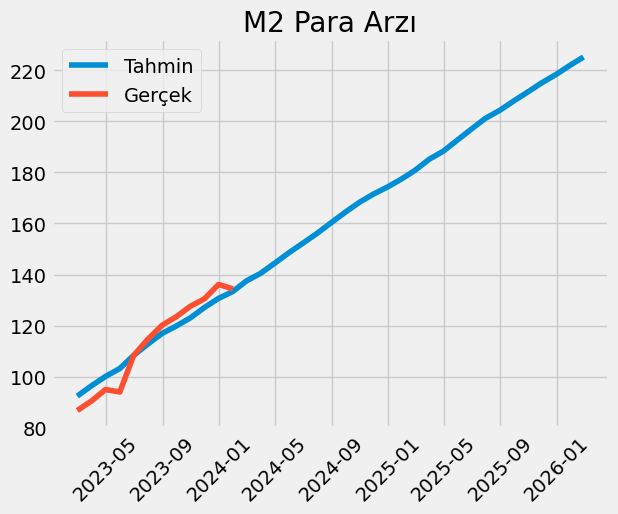

In [306]:
plt.title("M2 Para Arzi")
plt.plot(predictions["yhat"][-37:],label="Tahmin")
plt.plot(money["M2 Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [307]:
paraarzitahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(25)
paraarzitahmin

ds
2024-02-29    3.067546
2024-03-31    2.194656
2024-04-30    2.755649
2024-05-31    2.863431
2024-06-30    2.493815
2024-07-31    2.549936
2024-08-31    2.705147
2024-09-30    2.520250
2024-10-31    2.381551
2024-11-30    1.892465
2024-12-31    1.647509
2025-01-31    1.837237
2025-02-28    1.831110
2025-03-31    2.415642
2025-04-30    1.665644
2025-05-31    2.345872
2025-06-30    2.207873
2025-07-31    2.181381
2025-08-31    1.550620
2025-09-30    1.776525
2025-10-31    1.721710
2025-11-30    1.685024
2025-12-31    1.515789
2026-01-31    1.682348
2026-02-28    1.401048
Name: yhat, dtype: float64

In [308]:
paraarzitahmin1 = []
result = money.iloc[-1,0]
for i in range(len(paraarzitahmin)):
    result *= (1 + paraarzitahmin[i] / 100)
    paraarzitahmin1.append(result)

paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["M2 Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(paraarzitahmin1), freq="1M"))
row=pd.DataFrame({"M2 Para Arzi":money.iloc[-4:,0]},index=pd.date_range(start="2023-09-30",periods=4,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
paraarzitahmin1

M2 Para Arzi
2023-09-30           NaN
2023-10-31    127.637895
2023-11-30    130.504631
2023-12-31    136.159887
2024-01-31    138.533076
2024-02-29    141.573401
2024-03-31    145.474667
2024-04-30    149.640233
2024-05-31    153.371983
2024-06-30    157.282870
2024-07-31    161.537603
2024-08-31    165.608755
2024-09-30    169.552811
2024-10-31    172.761540
2024-11-30    175.607802
2024-12-31    178.834135
2025-01-31    182.108784
2025-02-28    186.507880
2025-03-31    189.614437
2025-04-30    194.062549
2025-05-31    198.347202
2025-06-30    202.673911
2025-07-31    205.816614
2025-08-31    209.472998
2025-09-30    213.079514
2025-10-31    216.669956
2025-11-30    219.954215
2025-12-31    223.654610
2026-01-31    226.788119

In [309]:
"""
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-01-16 16:25:48,315] A new study created in memory with name: no-name-6587eea3-cc7f-4d10-8f84-da6d4b35a8f7
16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:25:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:25:48,681] Trial 0 finished with value: 3.213852959451945e+17 and parameters: {'changepoint_prior_scale': 0.5985034718442455, 'changepoint_range': 0.7200488407164114, 'growth': 'linear', 'seasonality_prior_scale': 9.920141450912118, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 97, 'cap': 78.89773567365093}. Best is trial 0 with value: 3.213852959451945e+17.
16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:25:49,132] Trial 1 finished with value: 6.292246864191383e+18 and parameters: {'changepoint_prior_scale': 2.479444985782062, 'changepoint_range': 0.10552449526180929, 'growth': 'logistic', 'seasonality_prior_scale': 8.824019190

[I 2024-01-16 16:25:54,963] Trial 15 finished with value: 8.232348925444837e+17 and parameters: {'changepoint_prior_scale': 2.0173530527901313, 'changepoint_range': 0.6342870122916078, 'growth': 'linear', 'seasonality_prior_scale': 4.79035974571067, 'n_changepoints': 15, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 8, 'cap': 120.22461240906524}. Best is trial 11 with value: 2.3931391625971594e+17.
16:25:55 - cmdstanpy - INFO - Chain [1] start processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:25:55,443] Trial 16 finished with value: 1.1068606753120969e+18 and parameters: {'changepoint_prior_scale': 3.7199221334015435, 'changepoint_range': 0.43172007380134675, 'growth': 'linear', 'seasonality_prior_scale': 3.0266714866694624, 'n_changepoints': 9, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 38, 'cap': 49.94285548966306}. Best is trial 11 with value: 2.3931391625971594e+17.
16:25:55 - cmdstanpy - INFO - Chain [1] star

16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:04,895] Trial 31 finished with value: 2.0378269068605456e+17 and parameters: {'changepoint_prior_scale': 0.8178297127377399, 'changepoint_range': 0.854812265590551, 'growth': 'linear', 'seasonality_prior_scale': 5.823610821679897, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 85, 'cap': 175.90508515602613}. Best is trial 31 with value: 2.0378269068605456e+17.
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:05,634] Trial 32 finished with value: 2.260095224941742e+17 and parameters: {'changepoint_prior_scale': 0.713011333203162, 'changepoint_range': 0.7786803072911288, 'growth': 'linear', 'seasonality_prior_scale': 6.825468813968577, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 108, 'cap': 181.9014

16:26:15 - cmdstanpy - INFO - Chain [1] start processing
16:26:15 - cmdstanpy - INFO - Chain [1] done processing
16:26:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:15 - cmdstanpy - INFO - Chain [1] start processing
16:26:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:15,824] Trial 45 finished with value: 6.260729211132515e+18 and parameters: {'changepoint_prior_scale': 1.8682985124921498, 'changepoint_range': 0.8480130173678414, 'growth': 'logistic', 'seasonality_prior_scale': 6.827986825255125, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 96, 'cap': 185.16234873116116}. Best is trial 31 with value: 2.0378269068605456e+17.
16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:16,397] Trial 46 finished with value: 1.4314798033024502e+18 an

16:26:25 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:26,007] Trial 60 finished with value: 1.5450371468527117e+17 and parameters: {'changepoint_prior_scale': 2.3912751464803392, 'changepoint_range': 0.874448919145185, 'growth': 'linear', 'seasonality_prior_scale': 9.304832709955924, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 93, 'cap': 134.21958133998328}. Best is trial 58 with value: 1.5317154158630768e+17.
16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:26,539] Trial 61 finished with value: 1.5467035516399798e+17 and parameters: {'changepoint_prior_scale': 2.3428993087387773, 'changepoint_range': 0.8787175832568287, 'growth': 'linear', 'seasonality_prior_scale': 9.300635763022504, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 92, 'cap': 133.156

16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:36,516] Trial 76 finished with value: 3.557179178688131e+17 and parameters: {'changepoint_prior_scale': 2.900516264294534, 'changepoint_range': 0.832768868920356, 'growth': 'linear', 'seasonality_prior_scale': 8.778529655192699, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 75, 'cap': 142.86954403727196}. Best is trial 63 with value: 1.2571489071547e+17.
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:37,129] Trial 77 finished with value: 3.729599336366127e+17 and parameters: {'changepoint_prior_scale': 3.2564682056685514, 'changepoint_range': 0.8194655622956651, 'growth': 'linear', 'seasonality_prior_scale': 8.323716548627331, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 80, 'cap': 131.115461321

16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:46,509] Trial 92 finished with value: 2.2319444239030998e+17 and parameters: {'changepoint_prior_scale': 4.064104134455483, 'changepoint_range': 0.8528185616470346, 'growth': 'linear', 'seasonality_prior_scale': 9.529966519512897, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 86, 'cap': 25.739604527598495}. Best is trial 90 with value: 1.2109700874673365e+17.
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:47,135] Trial 93 finished with value: 1.513086222380353e+17 and parameters: {'changepoint_prior_scale': 3.4248300997801504, 'changepoint_range': 0.8783983301496602, 'growth': 'linear', 'seasonality_prior_scale': 9.620394982152998, 'n_changepoints': 12, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 84, 'cap': 1.40703447

16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:55,609] Trial 108 finished with value: 2.3665347709543232e+17 and parameters: {'changepoint_prior_scale': 3.4446857615020114, 'changepoint_range': 0.8288873822631077, 'growth': 'linear', 'seasonality_prior_scale': 9.822315033460486, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 88, 'cap': 122.98212155971686}. Best is trial 102 with value: 1.1605954884758533e+17.
16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:26:56,085] Trial 109 finished with value: 1.1610640078227653e+17 and parameters: {'changepoint_prior_scale': 1.9867330079452166, 'changepoint_range': 0.8999478280793475, 'growth': 'linear', 'seasonality_prior_scale': 9.480375601816482, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 91, 'cap': 63

16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:04,461] Trial 124 finished with value: 1.4238852707136742e+17 and parameters: {'changepoint_prior_scale': 1.8074769760756129, 'changepoint_range': 0.8993344125434176, 'growth': 'linear', 'seasonality_prior_scale': 9.302128266554138, 'n_changepoints': 10, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 70, 'cap': 73.3587977724675}. Best is trial 102 with value: 1.1605954884758533e+17.
16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:05,009] Trial 125 finished with value: 2.5262925660865885e+17 and parameters: {'changepoint_prior_scale': 2.111090569715979, 'changepoint_range': 0.8577965299702137, 'growth': 'linear', 'seasonality_prior_scale': 9.68384021311063, 'n_changepoints': 11, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 72, 'cap': 49.49

16:27:13 - cmdstanpy - INFO - Chain [1] start processing
16:27:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:13,490] Trial 140 finished with value: 3.589399803202888e+17 and parameters: {'changepoint_prior_scale': 3.671332335742899, 'changepoint_range': 0.8301222884285362, 'growth': 'linear', 'seasonality_prior_scale': 7.652047019759067, 'n_changepoints': 11, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 71, 'cap': 89.81481760145402}. Best is trial 102 with value: 1.1605954884758533e+17.
16:27:13 - cmdstanpy - INFO - Chain [1] start processing
16:27:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:13,947] Trial 141 finished with value: 1.6741372939794032e+17 and parameters: {'changepoint_prior_scale': 3.54549532020006, 'changepoint_range': 0.881817923065169, 'growth': 'linear', 'seasonality_prior_scale': 9.809591118346976, 'n_changepoints': 12, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 76, 'cap': 62.1486

16:27:21 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:22,192] Trial 156 finished with value: 1.254693370737904e+17 and parameters: {'changepoint_prior_scale': 2.6412082708875264, 'changepoint_range': 0.885771438549679, 'growth': 'linear', 'seasonality_prior_scale': 8.972531633827613, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 90, 'cap': 100.52792899780067}. Best is trial 152 with value: 1.1576631765236603e+17.
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:22,757] Trial 157 finished with value: 2.510650749705897e+17 and parameters: {'changepoint_prior_scale': 2.6752084842839974, 'changepoint_range': 0.8370389483018132, 'growth': 'linear', 'seasonality_prior_scale': 4.428724767878997, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 90, 'cap': 93.100

16:27:30 - cmdstanpy - INFO - Chain [1] start processing
16:27:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:31,226] Trial 172 finished with value: 2.0974962672040208e+17 and parameters: {'changepoint_prior_scale': 2.6245413859535294, 'changepoint_range': 0.8548140809729566, 'growth': 'linear', 'seasonality_prior_scale': 8.092271763928562, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 99, 'cap': 139.78009460774396}. Best is trial 171 with value: 1.047361548720148e+17.
16:27:31 - cmdstanpy - INFO - Chain [1] start processing
16:27:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:31,657] Trial 173 finished with value: 1.0361631342146901e+17 and parameters: {'changepoint_prior_scale': 2.713285702113135, 'changepoint_range': 0.8993555594239923, 'growth': 'linear', 'seasonality_prior_scale': 9.664735014820447, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 102, 'cap': 137.

16:27:38 - cmdstanpy - INFO - Chain [1] start processing
16:27:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:38,724] Trial 188 finished with value: 1.3022421219193378e+17 and parameters: {'changepoint_prior_scale': 2.3695003306409705, 'changepoint_range': 0.8714041178312492, 'growth': 'linear', 'seasonality_prior_scale': 9.636649409575567, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 109, 'cap': 145.46665693367945}. Best is trial 181 with value: 9.064560042654859e+16.
16:27:38 - cmdstanpy - INFO - Chain [1] start processing
16:27:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:39,183] Trial 189 finished with value: 1.9944042998087613e+17 and parameters: {'changepoint_prior_scale': 2.5114812797081134, 'changepoint_range': 0.8518400170758907, 'growth': 'linear', 'seasonality_prior_scale': 9.508721209412535, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 104, 'cap': 15

16:27:47 - cmdstanpy - INFO - Chain [1] start processing
16:27:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:47,760] Trial 204 finished with value: 1.2580374425476053e+17 and parameters: {'changepoint_prior_scale': 2.4334642687266888, 'changepoint_range': 0.8690774622151407, 'growth': 'linear', 'seasonality_prior_scale': 9.27416863787599, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 108, 'cap': 130.91337601696674}. Best is trial 181 with value: 9.064560042654859e+16.
16:27:47 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:48,277] Trial 205 finished with value: 9.066110457377686e+16 and parameters: {'changepoint_prior_scale': 2.6809378489937967, 'changepoint_range': 0.899248612332954, 'growth': 'linear', 'seasonality_prior_scale': 9.390526844931733, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 105, 'cap': 151.5

16:27:55 - cmdstanpy - INFO - Chain [1] start processing
16:27:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:56,154] Trial 220 finished with value: 1.351208428008515e+17 and parameters: {'changepoint_prior_scale': 2.813179387504109, 'changepoint_range': 0.8828338547641497, 'growth': 'linear', 'seasonality_prior_scale': 8.98210033783984, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 103, 'cap': 150.74687665351885}. Best is trial 181 with value: 9.064560042654859e+16.
16:27:56 - cmdstanpy - INFO - Chain [1] start processing
16:27:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:27:56,634] Trial 221 finished with value: 1.2546738989202656e+17 and parameters: {'changepoint_prior_scale': 3.0263353897454786, 'changepoint_range': 0.8978305998076652, 'growth': 'linear', 'seasonality_prior_scale': 9.328156795859966, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 97, 'cap': 163.16

16:28:04 - cmdstanpy - INFO - Chain [1] start processing
16:28:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:04,452] Trial 236 finished with value: 9.263037411290773e+16 and parameters: {'changepoint_prior_scale': 2.652811111405029, 'changepoint_range': 0.8993978675198204, 'growth': 'linear', 'seasonality_prior_scale': 8.202046389034614, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 108, 'cap': 161.34058209816146}. Best is trial 181 with value: 9.064560042654859e+16.
16:28:04 - cmdstanpy - INFO - Chain [1] start processing
16:28:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:04,960] Trial 237 finished with value: 9.261273805129909e+16 and parameters: {'changepoint_prior_scale': 2.6964701222123324, 'changepoint_range': 0.8999297950845295, 'growth': 'linear', 'seasonality_prior_scale': 8.424083295969801, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 108, 'cap': 170.2

16:28:12 - cmdstanpy - INFO - Chain [1] start processing
16:28:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:12,888] Trial 252 finished with value: 1.1752000391294034e+17 and parameters: {'changepoint_prior_scale': 2.624142876807411, 'changepoint_range': 0.8998998112646897, 'growth': 'linear', 'seasonality_prior_scale': 8.482192213761987, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 107, 'cap': 159.12875575800302}. Best is trial 181 with value: 9.064560042654859e+16.
16:28:13 - cmdstanpy - INFO - Chain [1] start processing
16:28:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:13,487] Trial 253 finished with value: 7.136912965791372e+17 and parameters: {'changepoint_prior_scale': 2.6670598924468885, 'changepoint_range': 0.30378224856923003, 'growth': 'linear', 'seasonality_prior_scale': 8.213568173490202, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 167

16:28:22 - cmdstanpy - INFO - Chain [1] start processing
16:28:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:23,054] Trial 268 finished with value: 3.568468291788813e+18 and parameters: {'changepoint_prior_scale': 2.683487472584365, 'changepoint_range': 0.8852190113287018, 'growth': 'logistic', 'seasonality_prior_scale': 7.950099660590658, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 108, 'cap': 164.07784498046783}. Best is trial 181 with value: 9.064560042654859e+16.
16:28:23 - cmdstanpy - INFO - Chain [1] start processing
16:28:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:23,675] Trial 269 finished with value: 1.7128640570230352e+17 and parameters: {'changepoint_prior_scale': 2.890498156079243, 'changepoint_range': 0.8694533307591137, 'growth': 'linear', 'seasonality_prior_scale': 8.534618886742741, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 156

16:28:31 - cmdstanpy - INFO - Chain [1] start processing
16:28:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:31,637] Trial 284 finished with value: 1.2736698008036267e+17 and parameters: {'changepoint_prior_scale': 2.6214834687036883, 'changepoint_range': 0.8710536631504755, 'growth': 'linear', 'seasonality_prior_scale': 8.528894443069317, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 156.4995899764218}. Best is trial 181 with value: 9.064560042654859e+16.
16:28:31 - cmdstanpy - INFO - Chain [1] start processing
16:28:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:32,177] Trial 285 finished with value: 1.1811493814271125e+17 and parameters: {'changepoint_prior_scale': 2.5083031150051887, 'changepoint_range': 0.8865052620290208, 'growth': 'linear', 'seasonality_prior_scale': 8.747147050037384, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 105, 'cap': 160

16:28:41 - cmdstanpy - INFO - Chain [1] start processing
16:28:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:41,620] Trial 300 finished with value: 3.8403191459039264e+17 and parameters: {'changepoint_prior_scale': 2.608890743194787, 'changepoint_range': 0.8592790186277419, 'growth': 'linear', 'seasonality_prior_scale': 8.08467921609112, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 17, 'cap': 146.91165211915313}. Best is trial 181 with value: 9.064560042654859e+16.
16:28:41 - cmdstanpy - INFO - Chain [1] start processing
16:28:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:42,151] Trial 301 finished with value: 1.1812533854861483e+17 and parameters: {'changepoint_prior_scale': 2.857305339598992, 'changepoint_range': 0.886376758324581, 'growth': 'linear', 'seasonality_prior_scale': 8.395550825627922, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 106, 'cap': 167.63683

16:28:49 - cmdstanpy - INFO - Chain [1] start processing
16:28:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:49,668] Trial 316 finished with value: 9.054961696132962e+16 and parameters: {'changepoint_prior_scale': 2.5466868284992557, 'changepoint_range': 0.8993552110921419, 'growth': 'linear', 'seasonality_prior_scale': 8.098069413174228, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 104, 'cap': 148.13063574581207}. Best is trial 316 with value: 9.054961696132962e+16.
16:28:49 - cmdstanpy - INFO - Chain [1] start processing
16:28:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:50,191] Trial 317 finished with value: 1.2645155974568902e+17 and parameters: {'changepoint_prior_scale': 2.5567958496134797, 'changepoint_range': 0.8731406623848087, 'growth': 'linear', 'seasonality_prior_scale': 8.054195313701156, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 104, 'cap': 148

16:28:57 - cmdstanpy - INFO - Chain [1] start processing
16:28:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:57,941] Trial 332 finished with value: 9.308221823682357e+16 and parameters: {'changepoint_prior_scale': 2.6850106065708945, 'changepoint_range': 0.8987418046737834, 'growth': 'linear', 'seasonality_prior_scale': 7.803529680772625, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 161.25155718704372}. Best is trial 316 with value: 9.054961696132962e+16.
16:28:58 - cmdstanpy - INFO - Chain [1] start processing
16:28:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:28:58,412] Trial 333 finished with value: 1.5597231362164723e+17 and parameters: {'changepoint_prior_scale': 2.780393414618414, 'changepoint_range': 0.8436453562820944, 'growth': 'linear', 'seasonality_prior_scale': 7.8572429014137715, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 154

16:29:05 - cmdstanpy - INFO - Chain [1] start processing
16:29:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:05,555] Trial 348 finished with value: 1.702008063233261e+17 and parameters: {'changepoint_prior_scale': 2.592380080824486, 'changepoint_range': 0.8603970499571284, 'growth': 'linear', 'seasonality_prior_scale': 8.895331431481193, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 106, 'cap': 158.42116204038263}. Best is trial 316 with value: 9.054961696132962e+16.
16:29:05 - cmdstanpy - INFO - Chain [1] start processing
16:29:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:06,063] Trial 349 finished with value: 1.0388863112717954e+17 and parameters: {'changepoint_prior_scale': 2.689365621388593, 'changepoint_range': 0.8875650753142076, 'growth': 'linear', 'seasonality_prior_scale': 8.589818943109721, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 108, 'cap': 153.43

16:29:14 - cmdstanpy - INFO - Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:14,485] Trial 364 finished with value: 9.475895846568373e+16 and parameters: {'changepoint_prior_scale': 3.006814594834269, 'changepoint_range': 0.8997473879157606, 'growth': 'linear', 'seasonality_prior_scale': 8.043268124917422, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 104, 'cap': 157.71917262198767}. Best is trial 359 with value: 9.039206446328059e+16.
16:29:14 - cmdstanpy - INFO - Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:14,927] Trial 365 finished with value: 2.3007236075272525e+17 and parameters: {'changepoint_prior_scale': 3.266619675073951, 'changepoint_range': 0.8427557923641188, 'growth': 'linear', 'seasonality_prior_scale': 7.774624477527747, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 100, 'cap': 144.6

16:29:22 - cmdstanpy - INFO - Chain [1] start processing
16:29:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:22,473] Trial 379 finished with value: 5.3192355192817235e+17 and parameters: {'changepoint_prior_scale': 2.986781161640369, 'changepoint_range': 0.4965476188959994, 'growth': 'linear', 'seasonality_prior_scale': 7.329819103918819, 'n_changepoints': 6, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 106, 'cap': 165.8744836454053}. Best is trial 375 with value: 9.038824422178555e+16.
16:29:22 - cmdstanpy - INFO - Chain [1] start processing
16:29:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:22,876] Trial 380 finished with value: 1.8747724076340739e+18 and parameters: {'changepoint_prior_scale': 2.9394969618467703, 'changepoint_range': 0.11294723418097657, 'growth': 'linear', 'seasonality_prior_scale': 7.357309437933646, 'n_changepoints': 15, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 12, 'cap': 15

16:29:29 - cmdstanpy - INFO - Chain [1] start processing
16:29:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:30,258] Trial 395 finished with value: 3.629587311645888e+17 and parameters: {'changepoint_prior_scale': 3.2432289399459333, 'changepoint_range': 0.88341186232059, 'growth': 'linear', 'seasonality_prior_scale': 8.968521849997273, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 0, 'cap': 137.90187708116576}. Best is trial 375 with value: 9.038824422178555e+16.
16:29:30 - cmdstanpy - INFO - Chain [1] start processing
16:29:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:30,683] Trial 396 finished with value: 1.05925061335626e+17 and parameters: {'changepoint_prior_scale': 3.0274578308084505, 'changepoint_range': 0.899715726260307, 'growth': 'linear', 'seasonality_prior_scale': 9.014890710649674, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 99, 'cap': 143.7457736

16:29:39 - cmdstanpy - INFO - Chain [1] start processing
16:29:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:39,930] Trial 411 finished with value: 1.3833169398998349e+17 and parameters: {'changepoint_prior_scale': 3.066890484610131, 'changepoint_range': 0.8725713398930888, 'growth': 'linear', 'seasonality_prior_scale': 9.263888232168387, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 101, 'cap': 137.33406788216234}. Best is trial 375 with value: 9.038824422178555e+16.
16:29:40 - cmdstanpy - INFO - Chain [1] start processing
16:29:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:40,509] Trial 412 finished with value: 1.1795869531336133e+17 and parameters: {'changepoint_prior_scale': 3.306242442817116, 'changepoint_range': 0.8844178887165307, 'growth': 'linear', 'seasonality_prior_scale': 6.3812964337441205, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 105, 'cap': 145.

16:29:47 - cmdstanpy - INFO - Chain [1] start processing
16:29:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:47,769] Trial 427 finished with value: 1.6140763675239702e+17 and parameters: {'changepoint_prior_scale': 2.8706101920483604, 'changepoint_range': 0.8509706989631118, 'growth': 'linear', 'seasonality_prior_scale': 9.97012726179377, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 104, 'cap': 141.88916603321533}. Best is trial 375 with value: 9.038824422178555e+16.
16:29:47 - cmdstanpy - INFO - Chain [1] start processing
16:29:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:48,184] Trial 428 finished with value: 1.1878824268103507e+17 and parameters: {'changepoint_prior_scale': 2.771223824156069, 'changepoint_range': 0.8856088475850316, 'growth': 'linear', 'seasonality_prior_scale': 2.20298135552111, 'n_changepoints': 6, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 102, 'cap': 155.05

16:29:55 - cmdstanpy - INFO - Chain [1] start processing
16:29:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:56,002] Trial 443 finished with value: 1.3944384863905886e+17 and parameters: {'changepoint_prior_scale': 2.412215449383441, 'changepoint_range': 0.8585947133067146, 'growth': 'linear', 'seasonality_prior_scale': 8.732137365713946, 'n_changepoints': 7, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 107, 'cap': 134.76547033089986}. Best is trial 375 with value: 9.038824422178555e+16.
16:29:56 - cmdstanpy - INFO - Chain [1] start processing
16:29:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:29:56,365] Trial 444 finished with value: 4.50816155542924e+17 and parameters: {'changepoint_prior_scale': 2.6560912928413676, 'changepoint_range': 0.6209242632969912, 'growth': 'linear', 'seasonality_prior_scale': 8.525964004073586, 'n_changepoints': 6, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 102, 'cap': 140.2

16:30:02 - cmdstanpy - INFO - Chain [1] start processing
16:30:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:03,121] Trial 459 finished with value: 1.48219196273939e+17 and parameters: {'changepoint_prior_scale': 2.7258103720435556, 'changepoint_range': 0.8623585688643153, 'growth': 'linear', 'seasonality_prior_scale': 1.0942275707727753, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 108, 'cap': 164.13167170819838}. Best is trial 375 with value: 9.038824422178555e+16.
16:30:03 - cmdstanpy - INFO - Chain [1] start processing
16:30:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:03,630] Trial 460 finished with value: 1.3910027848269371e+17 and parameters: {'changepoint_prior_scale': 2.6049611108604322, 'changepoint_range': 0.8852880594412059, 'growth': 'linear', 'seasonality_prior_scale': 9.650325111173084, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 102, 'cap': 137

16:30:11 - cmdstanpy - INFO - Chain [1] start processing
16:30:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:12,060] Trial 475 finished with value: 1.2849119086534278e+17 and parameters: {'changepoint_prior_scale': 2.7363529942557254, 'changepoint_range': 0.883047375580478, 'growth': 'linear', 'seasonality_prior_scale': 9.59390441485448, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 108, 'cap': 162.56526474199217}. Best is trial 375 with value: 9.038824422178555e+16.
16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:12,454] Trial 476 finished with value: 9.891817002293248e+16 and parameters: {'changepoint_prior_scale': 2.3437559647862476, 'changepoint_range': 0.8997827650971368, 'growth': 'linear', 'seasonality_prior_scale': 9.089875950932528, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 105, 'cap': 178.2

16:30:20 - cmdstanpy - INFO - Chain [1] start processing
16:30:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:20,516] Trial 491 finished with value: 1.1822548900542456e+17 and parameters: {'changepoint_prior_scale': 2.416305940528005, 'changepoint_range': 0.8836825159049995, 'growth': 'linear', 'seasonality_prior_scale': 4.875836506899237, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 106, 'cap': 146.35912453876531}. Best is trial 375 with value: 9.038824422178555e+16.
16:30:20 - cmdstanpy - INFO - Chain [1] start processing
16:30:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:20,950] Trial 492 finished with value: 1.1679310707139947e+17 and parameters: {'changepoint_prior_scale': 2.8949706565556643, 'changepoint_range': 0.8864744891393869, 'growth': 'linear', 'seasonality_prior_scale': 9.667083334667575, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 103, 'cap': 153

16:30:29 - cmdstanpy - INFO - Chain [1] start processing
16:30:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:29,770] Trial 507 finished with value: 1.1723720713194682e+17 and parameters: {'changepoint_prior_scale': 2.8215341417316577, 'changepoint_range': 0.8733576193959289, 'growth': 'linear', 'seasonality_prior_scale': 9.311213781796733, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 130.99284548233535}. Best is trial 375 with value: 9.038824422178555e+16.
16:30:30 - cmdstanpy - INFO - Chain [1] start processing
16:30:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:30,328] Trial 508 finished with value: 1.336267923847755e+17 and parameters: {'changepoint_prior_scale': 2.7111983996438593, 'changepoint_range': 0.8841170524372319, 'growth': 'linear', 'seasonality_prior_scale': 3.586684405610424, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 105, 'cap': 113

16:30:37 - cmdstanpy - INFO - Chain [1] start processing
16:30:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:38,236] Trial 523 finished with value: 1.7910494853607555e+17 and parameters: {'changepoint_prior_scale': 2.9249509064388888, 'changepoint_range': 0.852324053257572, 'growth': 'linear', 'seasonality_prior_scale': 7.672476587564221, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 107, 'cap': 170.33210177806873}. Best is trial 375 with value: 9.038824422178555e+16.
16:30:38 - cmdstanpy - INFO - Chain [1] start processing
16:30:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:38,951] Trial 524 finished with value: 1.5342220211908765e+17 and parameters: {'changepoint_prior_scale': 2.765069571496957, 'changepoint_range': 0.8704086212482327, 'growth': 'linear', 'seasonality_prior_scale': 9.051018257625984, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 104, 'cap': 134.

16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:47,235] Trial 539 finished with value: 1.1906208789981419e+17 and parameters: {'changepoint_prior_scale': 4.7827912026791335, 'changepoint_range': 0.8998640719098618, 'growth': 'linear', 'seasonality_prior_scale': 2.4757692029762564, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 101, 'cap': 162.46540132533138}. Best is trial 375 with value: 9.038824422178555e+16.
16:30:47 - cmdstanpy - INFO - Chain [1] start processing
16:30:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:47,720] Trial 540 finished with value: 1.258159257517501e+17 and parameters: {'changepoint_prior_scale': 2.759047612933935, 'changepoint_range': 0.873433779692596, 'growth': 'linear', 'seasonality_prior_scale': 7.883128028192465, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 107, 'cap': 155.

16:30:54 - cmdstanpy - INFO - Chain [1] start processing
16:30:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:55,139] Trial 555 finished with value: 1.0510145235267e+17 and parameters: {'changepoint_prior_scale': 2.8978778207687137, 'changepoint_range': 0.8849803096382364, 'growth': 'linear', 'seasonality_prior_scale': 8.149014121647443, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 174.05768526338065}. Best is trial 375 with value: 9.038824422178555e+16.
16:30:55 - cmdstanpy - INFO - Chain [1] start processing
16:30:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:30:55,529] Trial 556 finished with value: 1.0380812914987072e+17 and parameters: {'changepoint_prior_scale': 2.717792785933422, 'changepoint_range': 0.8996250051193886, 'growth': 'linear', 'seasonality_prior_scale': 9.243763158115165, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 103, 'cap': 107.58

16:31:02 - cmdstanpy - INFO - Chain [1] start processing
16:31:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:03,335] Trial 571 finished with value: 1.171756061768514e+17 and parameters: {'changepoint_prior_scale': 3.135202310337496, 'changepoint_range': 0.8727927045084318, 'growth': 'linear', 'seasonality_prior_scale': 9.527322712620283, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 158.82797057750523}. Best is trial 375 with value: 9.038824422178555e+16.
16:31:03 - cmdstanpy - INFO - Chain [1] start processing
16:31:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:03,886] Trial 572 finished with value: 1.6999462916318506e+17 and parameters: {'changepoint_prior_scale': 2.323283782138291, 'changepoint_range': 0.8455700010368521, 'growth': 'linear', 'seasonality_prior_scale': 8.449119713033392, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 106, 'cap': 166.1

16:31:10 - cmdstanpy - INFO - Chain [1] start processing
16:31:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:10,873] Trial 586 finished with value: 9.844992778896994e+16 and parameters: {'changepoint_prior_scale': 3.204353038499608, 'changepoint_range': 0.8998608667972189, 'growth': 'linear', 'seasonality_prior_scale': 8.951626717549184, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 105, 'cap': 148.38426464233706}. Best is trial 375 with value: 9.038824422178555e+16.
16:31:11 - cmdstanpy - INFO - Chain [1] start processing
16:31:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:11,424] Trial 587 finished with value: 1.275899309211212e+17 and parameters: {'changepoint_prior_scale': 2.9456798890139364, 'changepoint_range': 0.8714824905716874, 'growth': 'linear', 'seasonality_prior_scale': 8.795008398704661, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 106, 'cap': 159.33

16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:18,965] Trial 602 finished with value: 4.08310331863133e+17 and parameters: {'changepoint_prior_scale': 2.9232929635773606, 'changepoint_range': 0.7338030566765478, 'growth': 'linear', 'seasonality_prior_scale': 9.363727020610327, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 108, 'cap': 157.41805814989553}. Best is trial 375 with value: 9.038824422178555e+16.
16:31:19 - cmdstanpy - INFO - Chain [1] start processing
16:31:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:19,451] Trial 603 finished with value: 1.0380418387825221e+17 and parameters: {'changepoint_prior_scale': 2.809990849941259, 'changepoint_range': 0.8998964166686896, 'growth': 'linear', 'seasonality_prior_scale': 7.166290503509874, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 103, 'cap': 148.72

16:31:27 - cmdstanpy - INFO - Chain [1] start processing
16:31:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:27,841] Trial 618 finished with value: 1.1729203522820232e+17 and parameters: {'changepoint_prior_scale': 2.5776243701888704, 'changepoint_range': 0.8726651758754643, 'growth': 'linear', 'seasonality_prior_scale': 8.203708070572022, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 163.18036487619165}. Best is trial 375 with value: 9.038824422178555e+16.
16:31:28 - cmdstanpy - INFO - Chain [1] start processing
16:31:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:28,267] Trial 619 finished with value: 3.608931084282386e+18 and parameters: {'changepoint_prior_scale': 2.7991006815767476, 'changepoint_range': 0.8994564977073596, 'growth': 'logistic', 'seasonality_prior_scale': 8.766329984619135, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 100, 'cap': 1

16:31:35 - cmdstanpy - INFO - Chain [1] start processing
16:31:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:35,808] Trial 634 finished with value: 1.1729226155809242e+17 and parameters: {'changepoint_prior_scale': 2.584058274614358, 'changepoint_range': 0.8734193608930917, 'growth': 'linear', 'seasonality_prior_scale': 9.413219643656062, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 110, 'cap': 118.06431140784386}. Best is trial 375 with value: 9.038824422178555e+16.
16:31:36 - cmdstanpy - INFO - Chain [1] start processing
16:31:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:36,314] Trial 635 finished with value: 1.337184779307422e+17 and parameters: {'changepoint_prior_scale': 2.4789818669185673, 'changepoint_range': 0.8849398184905674, 'growth': 'linear', 'seasonality_prior_scale': 8.453659533570747, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 105, 'cap': 170.

16:31:43 - cmdstanpy - INFO - Chain [1] start processing
16:31:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:43,631] Trial 650 finished with value: 2.1929097058942182e+17 and parameters: {'changepoint_prior_scale': 2.915178384935802, 'changepoint_range': 0.8595465312651981, 'growth': 'linear', 'seasonality_prior_scale': 8.723660896497572, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 101, 'cap': 104.8273741525736}. Best is trial 375 with value: 9.038824422178555e+16.
16:31:43 - cmdstanpy - INFO - Chain [1] start processing
16:31:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:44,191] Trial 651 finished with value: 1.5328383239802794e+17 and parameters: {'changepoint_prior_scale': 3.220177630817396, 'changepoint_range': 0.8729763807403731, 'growth': 'linear', 'seasonality_prior_scale': 8.29234846697744, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 104, 'cap': 157.34

16:31:52 - cmdstanpy - INFO - Chain [1] start processing
16:31:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:52,631] Trial 666 finished with value: 1.300767433409847e+17 and parameters: {'changepoint_prior_scale': 2.7946509055062903, 'changepoint_range': 0.8718114779761211, 'growth': 'linear', 'seasonality_prior_scale': 7.9055076612216535, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 108, 'cap': 143.79515880209954}. Best is trial 375 with value: 9.038824422178555e+16.
16:31:52 - cmdstanpy - INFO - Chain [1] start processing
16:31:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:31:53,161] Trial 667 finished with value: 9.475513374695656e+16 and parameters: {'changepoint_prior_scale': 3.023003690882431, 'changepoint_range': 0.8996426877742991, 'growth': 'linear', 'seasonality_prior_scale': 8.548463999002504, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 104, 'cap': 15

16:32:00 - cmdstanpy - INFO - Chain [1] start processing
16:32:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:00,584] Trial 682 finished with value: 1.2364131548134822e+17 and parameters: {'changepoint_prior_scale': 2.937808944989405, 'changepoint_range': 0.8638044577143569, 'growth': 'linear', 'seasonality_prior_scale': 8.174030086299528, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 55, 'cap': 164.05272089878383}. Best is trial 678 with value: 6.662270776892327e+16.
16:32:00 - cmdstanpy - INFO - Chain [1] start processing
16:32:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:01,056] Trial 683 finished with value: 6.3645068926432936e+16 and parameters: {'changepoint_prior_scale': 2.7932077304952485, 'changepoint_range': 0.8857448687158908, 'growth': 'linear', 'seasonality_prior_scale': 8.04494950529231, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 46, 'cap': 169.

16:32:09 - cmdstanpy - INFO - Chain [1] start processing
16:32:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:10,065] Trial 698 finished with value: 1.137730776026928e+17 and parameters: {'changepoint_prior_scale': 2.9592903131465924, 'changepoint_range': 0.8738578954396653, 'growth': 'linear', 'seasonality_prior_scale': 7.863496522156892, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 44, 'cap': 175.0098120089284}. Best is trial 683 with value: 6.3645068926432936e+16.
16:32:10 - cmdstanpy - INFO - Chain [1] start processing
16:32:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:10,511] Trial 699 finished with value: 1.876416922310992e+17 and parameters: {'changepoint_prior_scale': 3.1208477809147093, 'changepoint_range': 0.8399340154594007, 'growth': 'linear', 'seasonality_prior_scale': 8.040067596971815, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 49, 'cap': 180.

16:32:17 - cmdstanpy - INFO - Chain [1] start processing
16:32:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:17,508] Trial 714 finished with value: 1.1772328754784395e+17 and parameters: {'changepoint_prior_scale': 3.3395186433555173, 'changepoint_range': 0.8663402567186081, 'growth': 'linear', 'seasonality_prior_scale': 7.5307906588553974, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 49, 'cap': 186.4811337888763}. Best is trial 683 with value: 6.3645068926432936e+16.
16:32:17 - cmdstanpy - INFO - Chain [1] start processing
16:32:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:17,988] Trial 715 finished with value: 2.6961310086444246e+17 and parameters: {'changepoint_prior_scale': 3.2007934212795632, 'changepoint_range': 0.8381736998047952, 'growth': 'linear', 'seasonality_prior_scale': 7.279329650236729, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 52, 'cap': 1

16:32:25 - cmdstanpy - INFO - Chain [1] start processing
16:32:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:26,022] Trial 730 finished with value: 6.4666815502206424e+16 and parameters: {'changepoint_prior_scale': 3.422600411299746, 'changepoint_range': 0.8847495527206081, 'growth': 'linear', 'seasonality_prior_scale': 7.389349106820561, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 48, 'cap': 179.93657088799807}. Best is trial 683 with value: 6.3645068926432936e+16.
16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:26,565] Trial 731 finished with value: 9.140402177351382e+17 and parameters: {'changepoint_prior_scale': 3.712065299064365, 'changepoint_range': 0.5502571770833364, 'growth': 'linear', 'seasonality_prior_scale': 7.49608098143248, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 43, 'cap': 189.1

16:32:35 - cmdstanpy - INFO - Chain [1] start processing
16:32:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:35,879] Trial 746 finished with value: 1.46062911765667e+17 and parameters: {'changepoint_prior_scale': 3.484553874891968, 'changepoint_range': 0.8846223492911602, 'growth': 'linear', 'seasonality_prior_scale': 7.451806256913152, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 48, 'cap': 170.77697430198162}. Best is trial 683 with value: 6.3645068926432936e+16.
16:32:36 - cmdstanpy - INFO - Chain [1] start processing
16:32:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:37,278] Trial 747 finished with value: 6.988104247260893e+17 and parameters: {'changepoint_prior_scale': 3.541714828721574, 'changepoint_range': 0.610977465591297, 'growth': 'linear', 'seasonality_prior_scale': 7.308791460703698, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 55, 'cap': 172.779

16:32:44 - cmdstanpy - INFO - Chain [1] start processing
16:32:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:44,647] Trial 762 finished with value: 1.6930880072045597e+17 and parameters: {'changepoint_prior_scale': 3.8692936248285457, 'changepoint_range': 0.8503882978053399, 'growth': 'linear', 'seasonality_prior_scale': 7.425409062069323, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 48, 'cap': 195.67835106025947}. Best is trial 683 with value: 6.3645068926432936e+16.
16:32:44 - cmdstanpy - INFO - Chain [1] start processing
16:32:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:45,148] Trial 763 finished with value: 3.3359521946879635e+17 and parameters: {'changepoint_prior_scale': 3.525355058756066, 'changepoint_range': 0.8078476996236592, 'growth': 'linear', 'seasonality_prior_scale': 7.540954361633698, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 43, 'cap': 198.

16:32:51 - cmdstanpy - INFO - Chain [1] start processing
16:32:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:52,034] Trial 778 finished with value: 6.260728749554167e+18 and parameters: {'changepoint_prior_scale': 3.5532027106204436, 'changepoint_range': 0.88445568304938, 'growth': 'logistic', 'seasonality_prior_scale': 7.758159120016412, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 35, 'cap': 187.75896495112482}. Best is trial 683 with value: 6.3645068926432936e+16.
16:32:52 - cmdstanpy - INFO - Chain [1] start processing
16:32:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:32:52,551] Trial 779 finished with value: 9.55966977121398e+16 and parameters: {'changepoint_prior_scale': 3.4457724909322858, 'changepoint_range': 0.874701621011961, 'growth': 'linear', 'seasonality_prior_scale': 7.450283330934125, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 44, 'cap': 183.3

16:33:01 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:01,305] Trial 794 finished with value: 2.229448651834866e+17 and parameters: {'changepoint_prior_scale': 3.5227000864631703, 'changepoint_range': 0.824632376473553, 'growth': 'linear', 'seasonality_prior_scale': 7.498194227276813, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 52, 'cap': 187.50914741734204}. Best is trial 783 with value: 5.441167691327215e+16.
16:33:01 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:01,777] Trial 795 finished with value: 1.2534682278792827e+17 and parameters: {'changepoint_prior_scale': 3.526441671852489, 'changepoint_range': 0.8584220081545351, 'growth': 'linear', 'seasonality_prior_scale': 7.311678339644847, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 57, 'cap': 184.9

16:33:16 - cmdstanpy - INFO - Chain [1] start processing
16:33:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:16,641] Trial 810 finished with value: 1.168272557396407e+17 and parameters: {'changepoint_prior_scale': 3.3534438458546916, 'changepoint_range': 0.8653486735282147, 'growth': 'linear', 'seasonality_prior_scale': 7.208967240874693, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 48, 'cap': 187.07127423433894}. Best is trial 783 with value: 5.441167691327215e+16.
16:33:16 - cmdstanpy - INFO - Chain [1] start processing
16:33:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:17,068] Trial 811 finished with value: 9.724460980913592e+16 and parameters: {'changepoint_prior_scale': 3.2894542423944357, 'changepoint_range': 0.873378311143952, 'growth': 'linear', 'seasonality_prior_scale': 7.442214952487289, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 46, 'cap': 170.6

16:33:23 - cmdstanpy - INFO - Chain [1] start processing
16:33:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:23,735] Trial 826 finished with value: 1.925588436701281e+17 and parameters: {'changepoint_prior_scale': 3.9149246052032605, 'changepoint_range': 0.8707910055888768, 'growth': 'linear', 'seasonality_prior_scale': 7.416373635389611, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 41, 'cap': 181.09024797594523}. Best is trial 783 with value: 5.441167691327215e+16.
16:33:24 - cmdstanpy - INFO - Chain [1] start processing
16:33:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:24,232] Trial 827 finished with value: 2.029866240632106e+17 and parameters: {'changepoint_prior_scale': 3.6426105395476727, 'changepoint_range': 0.8424670924762192, 'growth': 'linear', 'seasonality_prior_scale': 6.671257950861633, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 42, 'cap': 185.94

16:33:30 - cmdstanpy - INFO - Chain [1] start processing
16:33:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:30,996] Trial 842 finished with value: 1.2143748377596133e+17 and parameters: {'changepoint_prior_scale': 3.431602549262867, 'changepoint_range': 0.8619557598391715, 'growth': 'linear', 'seasonality_prior_scale': 7.524218636183201, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 53, 'cap': 182.77108338522177}. Best is trial 783 with value: 5.441167691327215e+16.
16:33:31 - cmdstanpy - INFO - Chain [1] start processing
16:33:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:31,406] Trial 843 finished with value: 5.6582476399363464e+16 and parameters: {'changepoint_prior_scale': 3.773390487778883, 'changepoint_range': 0.8845393590907561, 'growth': 'linear', 'seasonality_prior_scale': 7.117656754346493, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 58, 'cap': 190.

16:33:37 - cmdstanpy - INFO - Chain [1] start processing
16:33:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:38,004] Trial 858 finished with value: 6.260728730542264e+18 and parameters: {'changepoint_prior_scale': 3.856488168794139, 'changepoint_range': 0.8736612195200487, 'growth': 'logistic', 'seasonality_prior_scale': 6.857740447739834, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 60, 'cap': 191.61768011498103}. Best is trial 783 with value: 5.441167691327215e+16.
16:33:38 - cmdstanpy - INFO - Chain [1] start processing
16:33:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:38,397] Trial 859 finished with value: 2.30222846464524e+17 and parameters: {'changepoint_prior_scale': 3.9611025234407347, 'changepoint_range': 0.8555390635967407, 'growth': 'linear', 'seasonality_prior_scale': 7.204746244360777, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 57, 'cap': 188.

16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:47,516] Trial 874 finished with value: 9.644397796293765e+16 and parameters: {'changepoint_prior_scale': 3.7350111371561443, 'changepoint_range': 0.8638164438989561, 'growth': 'linear', 'seasonality_prior_scale': 7.350146657854592, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 64, 'cap': 189.29624950476656}. Best is trial 783 with value: 5.441167691327215e+16.
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:48,028] Trial 875 finished with value: 2.4590633995802902e+17 and parameters: {'changepoint_prior_scale': 4.277830095022701, 'changepoint_range': 0.8420722551632064, 'growth': 'linear', 'seasonality_prior_scale': 6.950116470050642, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 58, 'cap': 181.

16:33:54 - cmdstanpy - INFO - Chain [1] start processing
16:33:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:55,182] Trial 889 finished with value: 8.231629547330021e+16 and parameters: {'changepoint_prior_scale': 3.700008704854086, 'changepoint_range': 0.8785698854550676, 'growth': 'linear', 'seasonality_prior_scale': 7.311918242784653, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 49, 'cap': 178.57735247306186}. Best is trial 783 with value: 5.441167691327215e+16.
16:33:55 - cmdstanpy - INFO - Chain [1] start processing
16:33:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:33:55,670] Trial 890 finished with value: 1.6654388989888093e+17 and parameters: {'changepoint_prior_scale': 3.7504633264123264, 'changepoint_range': 0.882688039401837, 'growth': 'linear', 'seasonality_prior_scale': 6.5294368040462585, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 49, 'cap': 196.

16:34:05 - cmdstanpy - INFO - Chain [1] start processing
16:34:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:34:05,859] Trial 905 finished with value: 2.28122070264964e+17 and parameters: {'changepoint_prior_scale': 4.053887683658697, 'changepoint_range': 0.8622791417966994, 'growth': 'linear', 'seasonality_prior_scale': 7.84449554220073, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 40, 'cap': 176.93633030298943}. Best is trial 783 with value: 5.441167691327215e+16.
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:34:06,325] Trial 906 finished with value: 1.218404982803447e+18 and parameters: {'changepoint_prior_scale': 3.979253687223406, 'changepoint_range': 0.42906822707459963, 'growth': 'linear', 'seasonality_prior_scale': 7.657514130106567, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 40, 'cap': 183.3492744

16:34:13 - cmdstanpy - INFO - Chain [1] start processing
16:34:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:34:14,103] Trial 920 finished with value: 1.5592957822076003e+17 and parameters: {'changepoint_prior_scale': 3.854359098540345, 'changepoint_range': 0.8861193484078365, 'growth': 'linear', 'seasonality_prior_scale': 7.844519209860766, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 40, 'cap': 175.04099295723913}. Best is trial 783 with value: 5.441167691327215e+16.
16:34:14 - cmdstanpy - INFO - Chain [1] start processing
16:34:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:34:14,611] Trial 921 finished with value: 1.186715281819145e+17 and parameters: {'changepoint_prior_scale': 3.713723303257146, 'changepoint_range': 0.8695262208658292, 'growth': 'linear', 'seasonality_prior_scale': 7.466668424740921, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 46, 'cap': 179.439

16:34:33 - cmdstanpy - INFO - Chain [1] start processing
16:34:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:34:34,533] Trial 936 finished with value: 1.8856840520987184e+17 and parameters: {'changepoint_prior_scale': 3.6199619895509247, 'changepoint_range': 0.8451687500096986, 'growth': 'linear', 'seasonality_prior_scale': 7.426451825995116, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 46, 'cap': 178.3064653027104}. Best is trial 783 with value: 5.441167691327215e+16.
16:34:34 - cmdstanpy - INFO - Chain [1] start processing
16:34:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:34:35,487] Trial 937 finished with value: 6.286290074871318e+18 and parameters: {'changepoint_prior_scale': 3.437191938096406, 'changepoint_range': 0.8885340033331622, 'growth': 'logistic', 'seasonality_prior_scale': 7.915476955306991, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 41, 'cap': 172.32

16:34:47 - cmdstanpy - INFO - Chain [1] start processing
16:34:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:34:47,816] Trial 952 finished with value: 1.1512848780868712e+17 and parameters: {'changepoint_prior_scale': 3.477979723968699, 'changepoint_range': 0.8998088293069064, 'growth': 'linear', 'seasonality_prior_scale': 7.227746122675844, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 51, 'cap': 192.6693589063652}. Best is trial 783 with value: 5.441167691327215e+16.
16:34:48 - cmdstanpy - INFO - Chain [1] start processing
16:34:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:34:48,437] Trial 953 finished with value: 1.3561203680991662e+17 and parameters: {'changepoint_prior_scale': 3.4391418761825796, 'changepoint_range': 0.8598513106584972, 'growth': 'linear', 'seasonality_prior_scale': 6.997554536591955, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 47, 'cap': 185.5836

16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:35:00,913] Trial 968 finished with value: 3.8444051416477464e+16 and parameters: {'changepoint_prior_scale': 3.4450153966597137, 'changepoint_range': 0.8988624907921843, 'growth': 'linear', 'seasonality_prior_scale': 5.951805994371879, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 51, 'cap': 197.867979072754}. Best is trial 967 with value: 3.836037870491548e+16.
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:35:01,531] Trial 969 finished with value: 1.150522500261719e+17 and parameters: {'changepoint_prior_scale': 3.4309688829297915, 'changepoint_range': 0.8963868561445544, 'growth': 'linear', 'seasonality_prior_scale': 5.750794350625321, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 51, 'cap': 199.49005

16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:35:11,322] Trial 983 finished with value: 3.83900507773505e+16 and parameters: {'changepoint_prior_scale': 3.3497990084670453, 'changepoint_range': 0.8988513718591896, 'growth': 'linear', 'seasonality_prior_scale': 5.7579964293106185, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 50, 'cap': 195.77502162934292}. Best is trial 967 with value: 3.836037870491548e+16.
16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:35:11,926] Trial 984 finished with value: 3.841517828851025e+16 and parameters: {'changepoint_prior_scale': 3.317693048655187, 'changepoint_range': 0.8975079852309036, 'growth': 'linear', 'seasonality_prior_scale': 5.448215675040631, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 50, 'cap': 195.46704

16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:35:21,586] Trial 998 finished with value: 1.6334428867936525e+17 and parameters: {'changepoint_prior_scale': 3.169010217378852, 'changepoint_range': 0.8984561619885362, 'growth': 'linear', 'seasonality_prior_scale': 5.506134535117292, 'n_changepoints': 22, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 59, 'cap': 199.27563439267868}. Best is trial 987 with value: 2.6939800964107252e+16.
16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:35:22,315] Trial 999 finished with value: 2.9686493717799892e+16 and parameters: {'changepoint_prior_scale': 3.249989120843323, 'changepoint_range': 0.8983209235614834, 'growth': 'linear', 'seasonality_prior_scale': 5.8154575939285404, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 58, 'cap': 195.2

In [310]:
#study.best_params

{'changepoint_prior_scale': 3.239230389449465,
 'changepoint_range': 0.8994922942942231,
 'growth': 'linear',
 'seasonality_prior_scale': 5.6671313607406235,
 'n_changepoints': 1,
 'yearly_seasonality': False,
 'weekly_seasonality': True,
 'm': 54,
 'cap': 195.5202182801811}

In [312]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"][103:].index
sn["y"]=borc["Borç"][103:].values
sn["cap"]=195.5202182801811
prophet=Prophet(changepoint_prior_scale=3.239230389449465,changepoint_range=0.8994922942942231,growth='linear',seasonality_prior_scale=5.6671313607406235,n_changepoints=1,
               yearly_seasonality = False, weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=26,freq="M")
future_dates["cap"]=195.5202182801811
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

16:38:47 - cmdstanpy - INFO - Chain [1] start processing
16:38:47 - cmdstanpy - INFO - Chain [1] done processing


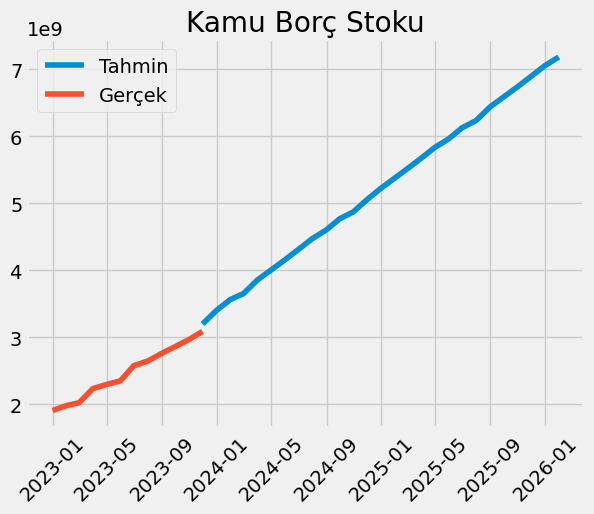

In [313]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][-27:],label="Tahmin")
plt.plot(borc["Borç"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [314]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(26)
borctahmin

ds
2023-12-31    6.359560
2024-01-31    4.789370
2024-02-29    2.466437
2024-03-31    5.568672
2024-04-30    3.810680
2024-05-31    3.824920
2024-06-30    3.710144
2024-07-31    3.779894
2024-08-31    2.884047
2024-09-30    3.621177
2024-10-31    2.238208
2024-11-30    3.709421
2024-12-31    3.351894
2025-01-31    2.929813
2025-02-28    2.598385
2025-03-31    2.872640
2025-04-30    2.793279
2025-05-31    2.210597
2025-06-30    2.793889
2025-07-31    1.740769
2025-08-31    3.260525
2025-09-30    2.281072
2025-10-31    2.323837
2025-11-30    2.287172
2025-12-31    2.362587
2026-01-31    1.827606
Name: yhat, dtype: float64

In [315]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2023-12-30", periods=len(borctahmin1), freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-08-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

Borç
2023-08-31  2.758965e+09
2023-09-30  2.859751e+09
2023-10-31  2.966763e+09
2023-11-30  3.086466e+09
2023-12-31  3.282752e+09
2024-01-31  3.439975e+09
2024-02-29  3.524820e+09
2024-03-31  3.721106e+09
2024-04-30  3.862905e+09
2024-05-31  4.010658e+09
2024-06-30  4.159459e+09
2024-07-31  4.316683e+09
2024-08-31  4.441178e+09
2024-09-30  4.602001e+09
2024-10-31  4.705003e+09
2024-11-30  4.879531e+09
2024-12-31  5.043088e+09
2025-01-31  5.190841e+09
2025-02-28  5.325719e+09
2025-03-31  5.478708e+09
2025-04-30  5.631744e+09
2025-05-31  5.756239e+09
2025-06-30  5.917062e+09
2025-07-31  6.020064e+09
2025-08-31  6.216350e+09
2025-09-30  6.358149e+09
2025-10-31  6.505902e+09
2025-11-30  6.654703e+09
2025-12-31  6.811927e+09
2026-01-31  6.936422e+09

In [316]:
"""
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi Hacmi"][params["m"]:-12].index
    sn["y"]=df3["Kredi Hacmi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3["Kredi Hacmi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-01-16 16:39:14,356] A new study created in memory with name: no-name-a48b6ac9-2a00-46be-a1ed-926fc6a34a89
16:39:14 - cmdstanpy - INFO - Chain [1] start processing
16:39:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:39:16,381] Trial 0 finished with value: 1532.5468673002879 and parameters: {'changepoint_prior_scale': 3.229263896525784, 'changepoint_range': 0.20211488171504205, 'growth': 'linear', 'seasonality_prior_scale': 2.01510928925222, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 106, 'cap': 387.72581385741387}. Best is trial 0 with value: 1532.5468673002879.
16:39:16 - cmdstanpy - INFO - Chain [1] start processing
16:39:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:39:16,756] Trial 1 finished with value: 179.13942774918476 and parameters: {'changepoint_prior_scale': 3.967724623979486, 'changepoint_range': 0.36762390300758985, 'growth': 'linear', 'seasonality_prior_scale': 0.8127981589144017,

16:39:28 - cmdstanpy - INFO - Chain [1] start processing
16:39:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:39:29,027] Trial 16 finished with value: 528.9253621991901 and parameters: {'changepoint_prior_scale': 2.2891510670292448, 'changepoint_range': 0.667105311696456, 'growth': 'logistic', 'seasonality_prior_scale': 8.170637895768207, 'n_changepoints': 15, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 101, 'cap': 106.44603974919784}. Best is trial 14 with value: 11.405524529290892.
16:39:29 - cmdstanpy - INFO - Chain [1] start processing
16:39:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:39:30,628] Trial 17 finished with value: 309.54337838544166 and parameters: {'changepoint_prior_scale': 3.4366951101788947, 'changepoint_range': 0.46548574390760955, 'growth': 'logistic', 'seasonality_prior_scale': 8.846601516827546, 'n_changepoints': 16, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 121, 'cap': 223.600

16:39:56 - cmdstanpy - INFO - Chain [1] start processing
16:39:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:39:56,965] Trial 32 finished with value: 71.02577357798175 and parameters: {'changepoint_prior_scale': 2.149525509988399, 'changepoint_range': 0.797951527209792, 'growth': 'logistic', 'seasonality_prior_scale': 8.965277188557652, 'n_changepoints': 10, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 166, 'cap': 209.12852737809442}. Best is trial 14 with value: 11.405524529290892.
16:39:57 - cmdstanpy - INFO - Chain [1] start processing
16:39:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:39:57,437] Trial 33 finished with value: 199.33704218651224 and parameters: {'changepoint_prior_scale': 1.5923976232969572, 'changepoint_range': 0.6187403886717937, 'growth': 'logistic', 'seasonality_prior_scale': 8.35794945545332, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 135, 'cap': 162.288141392

16:40:07 - cmdstanpy - INFO - Chain [1] start processing
16:40:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:40:12,400] Trial 48 finished with value: 119.56110097392998 and parameters: {'changepoint_prior_scale': 2.7209606072548107, 'changepoint_range': 0.5609424999575997, 'growth': 'linear', 'seasonality_prior_scale': 8.482665589390344, 'n_changepoints': 15, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 177, 'cap': 112.87404058220439}. Best is trial 42 with value: 3.9414563127349838.
16:40:12 - cmdstanpy - INFO - Chain [1] start processing
16:40:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:40:12,807] Trial 49 finished with value: 88.74068811356803 and parameters: {'changepoint_prior_scale': 1.9097781680111783, 'changepoint_range': 0.6972198521844676, 'growth': 'logistic', 'seasonality_prior_scale': 1.211661767498296, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 121, 'cap': 275.799111672

16:40:23 - cmdstanpy - INFO - Chain [1] start processing
16:40:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:40:24,684] Trial 64 finished with value: 3.6347568798037666 and parameters: {'changepoint_prior_scale': 4.906620034385852, 'changepoint_range': 0.702714741760383, 'growth': 'logistic', 'seasonality_prior_scale': 6.4518468691429405, 'n_changepoints': 13, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 137, 'cap': 397.0799579692496}. Best is trial 55 with value: 3.2335673608599045.
16:40:24 - cmdstanpy - INFO - Chain [1] start processing
16:40:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:40:25,353] Trial 65 finished with value: 11.40896041663318 and parameters: {'changepoint_prior_scale': 4.98699556216019, 'changepoint_range': 0.6993763584548195, 'growth': 'logistic', 'seasonality_prior_scale': 7.0013316072615055, 'n_changepoints': 11, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 130, 'cap': 399.82153179

16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:40:38,502] Trial 80 finished with value: 134.4688832687544 and parameters: {'changepoint_prior_scale': 3.4793662548593765, 'changepoint_range': 0.7762934166281078, 'growth': 'linear', 'seasonality_prior_scale': 4.524553411357822, 'n_changepoints': 12, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 111, 'cap': 367.21789532918433}. Best is trial 55 with value: 3.2335673608599045.
16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:40:39,057] Trial 81 finished with value: 3.6344652495287075 and parameters: {'changepoint_prior_scale': 4.875795797228514, 'changepoint_range': 0.7073086862418599, 'growth': 'logistic', 'seasonality_prior_scale': 7.145485154410991, 'n_changepoints': 13, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 137, 'cap': 396.85209961

16:40:52 - cmdstanpy - INFO - Chain [1] start processing
16:40:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:40:52,778] Trial 96 finished with value: 3.9857844433708904 and parameters: {'changepoint_prior_scale': 4.588169114407691, 'changepoint_range': 0.8811226185378849, 'growth': 'logistic', 'seasonality_prior_scale': 7.21890797952642, 'n_changepoints': 10, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 95, 'cap': 343.09903299668576}. Best is trial 95 with value: 3.1128756431855353.
16:40:53 - cmdstanpy - INFO - Chain [1] start processing
16:40:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:40:53,709] Trial 97 finished with value: 87.47039104531615 and parameters: {'changepoint_prior_scale': 4.1895026245144535, 'changepoint_range': 0.8061334009419929, 'growth': 'linear', 'seasonality_prior_scale': 8.018627291789446, 'n_changepoints': 9, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 116, 'cap': 313.173573940243

16:41:05 - cmdstanpy - INFO - Chain [1] start processing
16:41:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:06,254] Trial 112 finished with value: 3.4718874858117506 and parameters: {'changepoint_prior_scale': 4.471400516233177, 'changepoint_range': 0.7801895855378134, 'growth': 'logistic', 'seasonality_prior_scale': 6.988212848303934, 'n_changepoints': 12, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 135, 'cap': 372.0640446934541}. Best is trial 95 with value: 3.1128756431855353.
16:41:06 - cmdstanpy - INFO - Chain [1] start processing
16:41:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:06,834] Trial 113 finished with value: 3.730046530229185 and parameters: {'changepoint_prior_scale': 4.453500692122481, 'changepoint_range': 0.7758674319070826, 'growth': 'logistic', 'seasonality_prior_scale': 8.412517735464059, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 134, 'cap': 367.7564375

16:41:19 - cmdstanpy - INFO - Chain [1] start processing
16:41:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:19,652] Trial 128 finished with value: 4.398929270213174 and parameters: {'changepoint_prior_scale': 3.5148370813788885, 'changepoint_range': 0.805675631911014, 'growth': 'logistic', 'seasonality_prior_scale': 8.242336762653562, 'n_changepoints': 10, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 110, 'cap': 317.86780501290036}. Best is trial 95 with value: 3.1128756431855353.
16:41:19 - cmdstanpy - INFO - Chain [1] start processing
16:41:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:20,500] Trial 129 finished with value: 7.837467592211866 and parameters: {'changepoint_prior_scale': 3.6621758968888307, 'changepoint_range': 0.867469140031604, 'growth': 'logistic', 'seasonality_prior_scale': 8.061682315070728, 'n_changepoints': 9, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 115, 'cap': 347.8442571

16:41:30 - cmdstanpy - INFO - Chain [1] start processing
16:41:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:31,088] Trial 144 finished with value: 4.267558959992112 and parameters: {'changepoint_prior_scale': 3.9690343763453284, 'changepoint_range': 0.7382979664693922, 'growth': 'logistic', 'seasonality_prior_scale': 7.811835383946135, 'n_changepoints': 10, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 130, 'cap': 352.87159913516683}. Best is trial 95 with value: 3.1128756431855353.
16:41:31 - cmdstanpy - INFO - Chain [1] start processing
16:41:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:31,581] Trial 145 finished with value: 4.05960368080084 and parameters: {'changepoint_prior_scale': 3.740060580619248, 'changepoint_range': 0.7169420541735441, 'growth': 'logistic', 'seasonality_prior_scale': 7.310882816832271, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 137, 'cap': 325.345009814

16:41:41 - cmdstanpy - INFO - Chain [1] start processing
16:41:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:41,366] Trial 160 finished with value: 3.1341420858818743 and parameters: {'changepoint_prior_scale': 3.1886745447398113, 'changepoint_range': 0.8168354361179074, 'growth': 'logistic', 'seasonality_prior_scale': 9.393212213083494, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 119, 'cap': 307.2227035565011}. Best is trial 95 with value: 3.1128756431855353.
16:41:41 - cmdstanpy - INFO - Chain [1] start processing
16:41:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:41,857] Trial 161 finished with value: 3.5865719735406647 and parameters: {'changepoint_prior_scale': 3.13908742656238, 'changepoint_range': 0.8062833345605802, 'growth': 'logistic', 'seasonality_prior_scale': 9.253910879434338, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 119, 'cap': 305.6656753

16:41:52 - cmdstanpy - INFO - Chain [1] start processing
16:41:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:52,398] Trial 176 finished with value: 3.1004769987372556 and parameters: {'changepoint_prior_scale': 2.281467272819925, 'changepoint_range': 0.8589161965123767, 'growth': 'logistic', 'seasonality_prior_scale': 9.826109424565107, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 100, 'cap': 302.7409286244442}. Best is trial 169 with value: 3.0875533186596695.
16:41:52 - cmdstanpy - INFO - Chain [1] start processing
16:41:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:52,858] Trial 177 finished with value: 3.1413951856591793 and parameters: {'changepoint_prior_scale': 2.314252423119655, 'changepoint_range': 0.8676536445062135, 'growth': 'logistic', 'seasonality_prior_scale': 9.821314867269454, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 96, 'cap': 299.7041226322990

16:41:59 - cmdstanpy - INFO - Chain [1] start processing
16:41:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:41:59,648] Trial 192 finished with value: 2.868695839601877 and parameters: {'changepoint_prior_scale': 2.6066824878010393, 'changepoint_range': 0.899711670590892, 'growth': 'logistic', 'seasonality_prior_scale': 9.862638175749876, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 81, 'cap': 262.8355421039292}. Best is trial 192 with value: 2.868695839601877.
16:41:59 - cmdstanpy - INFO - Chain [1] start processing
16:41:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:00,077] Trial 193 finished with value: 2.9165598850457095 and parameters: {'changepoint_prior_scale': 2.5713671577106973, 'changepoint_range': 0.8983985332303643, 'growth': 'logistic', 'seasonality_prior_scale': 9.852139401307289, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 77, 'cap': 271.49182492951485}

16:42:07 - cmdstanpy - INFO - Chain [1] start processing
16:42:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:07,743] Trial 208 finished with value: 4.247050209569108 and parameters: {'changepoint_prior_scale': 2.5520039411874915, 'changepoint_range': 0.8825465216940448, 'growth': 'logistic', 'seasonality_prior_scale': 9.240006362572432, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 77, 'cap': 281.76911946546863}. Best is trial 192 with value: 2.868695839601877.
16:42:07 - cmdstanpy - INFO - Chain [1] start processing
16:42:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:08,143] Trial 209 finished with value: 2.974801206728267 and parameters: {'changepoint_prior_scale': 1.9005898546477225, 'changepoint_range': 0.8997794704977591, 'growth': 'logistic', 'seasonality_prior_scale': 9.768096432854719, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 89, 'cap': 269.6290082307284}

16:42:15 - cmdstanpy - INFO - Chain [1] start processing
16:42:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:15,757] Trial 224 finished with value: 3.1109388573389025 and parameters: {'changepoint_prior_scale': 1.974506484861219, 'changepoint_range': 0.8855074361993075, 'growth': 'logistic', 'seasonality_prior_scale': 9.389413049632212, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 94, 'cap': 273.545099619518}. Best is trial 192 with value: 2.868695839601877.
16:42:15 - cmdstanpy - INFO - Chain [1] start processing
16:42:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:16,155] Trial 225 finished with value: 2.949078344715072 and parameters: {'changepoint_prior_scale': 1.7049451294817088, 'changepoint_range': 0.8980904991756015, 'growth': 'logistic', 'seasonality_prior_scale': 9.70730622851495, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 79, 'cap': 263.1771607458363}. B

16:42:25 - cmdstanpy - INFO - Chain [1] start processing
16:42:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:25,594] Trial 240 finished with value: 3.2838972763363494 and parameters: {'changepoint_prior_scale': 1.888683404097415, 'changepoint_range': 0.8690877553466058, 'growth': 'logistic', 'seasonality_prior_scale': 9.527294816967276, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 92, 'cap': 287.0473197099173}. Best is trial 192 with value: 2.868695839601877.
16:42:25 - cmdstanpy - INFO - Chain [1] start processing
16:42:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:26,045] Trial 241 finished with value: 3.0607302368358087 and parameters: {'changepoint_prior_scale': 1.695661062425192, 'changepoint_range': 0.8995499558737241, 'growth': 'logistic', 'seasonality_prior_scale': 9.703665291347688, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 89, 'cap': 274.9629492184811}.

16:42:33 - cmdstanpy - INFO - Chain [1] start processing
16:42:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:34,270] Trial 256 finished with value: 3.161837225799904 and parameters: {'changepoint_prior_scale': 1.749430303822801, 'changepoint_range': 0.8991942742534632, 'growth': 'logistic', 'seasonality_prior_scale': 9.997702415038926, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 83, 'cap': 260.19792002032585}. Best is trial 192 with value: 2.868695839601877.
16:42:34 - cmdstanpy - INFO - Chain [1] start processing
16:42:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:34,721] Trial 257 finished with value: 3.059947793292178 and parameters: {'changepoint_prior_scale': 2.6288274421130455, 'changepoint_range': 0.8837314506783048, 'growth': 'logistic', 'seasonality_prior_scale': 9.79796556428394, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 91, 'cap': 286.48727394147454}.

16:42:42 - cmdstanpy - INFO - Chain [1] start processing
16:42:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:42,978] Trial 272 finished with value: 3.3375115422557413 and parameters: {'changepoint_prior_scale': 1.7985757467837218, 'changepoint_range': 0.899641676389992, 'growth': 'logistic', 'seasonality_prior_scale': 9.77745090255759, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 83, 'cap': 251.68337923630486}. Best is trial 192 with value: 2.868695839601877.
16:42:43 - cmdstanpy - INFO - Chain [1] start processing
16:42:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:43,441] Trial 273 finished with value: 9.717343971256037 and parameters: {'changepoint_prior_scale': 2.0153929042049, 'changepoint_range': 0.8604720542636994, 'growth': 'logistic', 'seasonality_prior_scale': 9.562860246332406, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 88, 'cap': 260.82042509018225}. B

16:42:51 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:52,210] Trial 288 finished with value: 12.455513867110405 and parameters: {'changepoint_prior_scale': 2.4655362773220846, 'changepoint_range': 0.8510857176744592, 'growth': 'logistic', 'seasonality_prior_scale': 9.28695024491281, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 87, 'cap': 279.9798808824526}. Best is trial 192 with value: 2.868695839601877.
16:42:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:42:52,699] Trial 289 finished with value: 8.931100682633996 and parameters: {'changepoint_prior_scale': 1.9393658683726387, 'changepoint_range': 0.8714777119435134, 'growth': 'logistic', 'seasonality_prior_scale': 9.683635133388856, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 78, 'cap': 255.86065283639863}

16:43:00 - cmdstanpy - INFO - Chain [1] start processing
16:43:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:00,489] Trial 304 finished with value: 8.941560813352535 and parameters: {'changepoint_prior_scale': 2.2669188414321915, 'changepoint_range': 0.8844081135262547, 'growth': 'logistic', 'seasonality_prior_scale': 9.609545579024958, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 75, 'cap': 227.50425122659334}. Best is trial 192 with value: 2.868695839601877.
16:43:00 - cmdstanpy - INFO - Chain [1] start processing
16:43:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:00,961] Trial 305 finished with value: 5.289590438257529 and parameters: {'changepoint_prior_scale': 1.9422320091735406, 'changepoint_range': 0.8651348558156118, 'growth': 'logistic', 'seasonality_prior_scale': 9.800512396057293, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 84, 'cap': 274.0538819705939}

16:43:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:09,749] Trial 319 finished with value: 4.275827814112473 and parameters: {'changepoint_prior_scale': 2.482443804428274, 'changepoint_range': 0.8745227969188623, 'growth': 'logistic', 'seasonality_prior_scale': 9.526317380409047, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 86, 'cap': 267.5066665195217}. Best is trial 192 with value: 2.868695839601877.
16:43:09 - cmdstanpy - INFO - Chain [1] start processing
16:43:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:11,214] Trial 320 finished with value: 4.493284466559791 and parameters: {'changepoint_prior_scale': 1.748010003468567, 'changepoint_range': 0.8874273481441098, 'growth': 'logistic', 'seasonality_prior_scale': 9.807399575705704, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 83, 'cap': 258.36466677439904}. Best is trial 192 with value: 2.868695839601877.
16:43:11

16:43:18 - cmdstanpy - INFO - Chain [1] start processing
16:43:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:18,543] Trial 335 finished with value: 8.877487967593474 and parameters: {'changepoint_prior_scale': 2.022221381524806, 'changepoint_range': 0.8578911950734097, 'growth': 'logistic', 'seasonality_prior_scale': 9.638088595238841, 'n_changepoints': 18, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 103, 'cap': 256.44658882290986}. Best is trial 192 with value: 2.868695839601877.
16:43:18 - cmdstanpy - INFO - Chain [1] start processing
16:43:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:19,038] Trial 336 finished with value: 3.1200957983661017 and parameters: {'changepoint_prior_scale': 1.6706139035894112, 'changepoint_range': 0.8861336138441135, 'growth': 'logistic', 'seasonality_prior_scale': 9.843288561703478, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 88, 'cap': 269.286281761149

16:43:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:26,639] Trial 350 finished with value: 2.9924385179882127 and parameters: {'changepoint_prior_scale': 2.013959783992847, 'changepoint_range': 0.8733113742201648, 'growth': 'logistic', 'seasonality_prior_scale': 9.78638151090318, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 101, 'cap': 287.6350984249683}. Best is trial 192 with value: 2.868695839601877.
16:43:26 - cmdstanpy - INFO - Chain [1] start processing
16:43:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:27,095] Trial 351 finished with value: 4.82977519494095 and parameters: {'changepoint_prior_scale': 1.9100061959785306, 'changepoint_range': 0.853677176281886, 'growth': 'logistic', 'seasonality_prior_scale': 9.151309173591297, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 101, 'cap': 288.490931679642}. Best is trial 192 with value: 2.868695839601877.
16:43:27 

16:43:34 - cmdstanpy - INFO - Chain [1] start processing
16:43:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:35,197] Trial 366 finished with value: 2.9432623136917457 and parameters: {'changepoint_prior_scale': 2.093459459322589, 'changepoint_range': 0.8792976891380246, 'growth': 'logistic', 'seasonality_prior_scale': 9.55113961169806, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 109, 'cap': 278.2457399046363}. Best is trial 192 with value: 2.868695839601877.
16:43:35 - cmdstanpy - INFO - Chain [1] start processing
16:43:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:35,644] Trial 367 finished with value: 6.2216591969881465 and parameters: {'changepoint_prior_scale': 2.120304146931769, 'changepoint_range': 0.8537946095199316, 'growth': 'logistic', 'seasonality_prior_scale': 9.458429311092237, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 96, 'cap': 273.87806242218716}

16:43:46 - cmdstanpy - INFO - Chain [1] start processing
16:43:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:46,873] Trial 382 finished with value: 45.29942801029899 and parameters: {'changepoint_prior_scale': 2.375017061703536, 'changepoint_range': 0.8617408280815831, 'growth': 'linear', 'seasonality_prior_scale': 4.3212284016384785, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 108, 'cap': 262.76477368962026}. Best is trial 368 with value: 2.7926609548967605.
16:43:47 - cmdstanpy - INFO - Chain [1] start processing
16:43:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:47,483] Trial 383 finished with value: 6.196413321624367 and parameters: {'changepoint_prior_scale': 1.9956949983759993, 'changepoint_range': 0.8832568220108337, 'growth': 'logistic', 'seasonality_prior_scale': 8.884375309761506, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 115, 'cap': 274.19142733025

16:43:55 - cmdstanpy - INFO - Chain [1] start processing
16:43:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:55,951] Trial 398 finished with value: 3.7025377985158987 and parameters: {'changepoint_prior_scale': 2.1155998372030895, 'changepoint_range': 0.8316064833424686, 'growth': 'logistic', 'seasonality_prior_scale': 8.657085975971986, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 117, 'cap': 274.0846824513496}. Best is trial 391 with value: 2.5891899688708278.
16:43:56 - cmdstanpy - INFO - Chain [1] start processing
16:43:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:43:56,574] Trial 399 finished with value: 6.980823512641478 and parameters: {'changepoint_prior_scale': 0.4111934319276527, 'changepoint_range': 0.8596196053814267, 'growth': 'logistic', 'seasonality_prior_scale': 8.664993523036026, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 115, 'cap': 265.53217060300

16:44:06 - cmdstanpy - INFO - Chain [1] start processing
16:44:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:06,353] Trial 414 finished with value: 3.151993647516937 and parameters: {'changepoint_prior_scale': 1.3943632802409072, 'changepoint_range': 0.8832113399998841, 'growth': 'logistic', 'seasonality_prior_scale': 9.002877219145073, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 120, 'cap': 267.63265754501333}. Best is trial 391 with value: 2.5891899688708278.
16:44:06 - cmdstanpy - INFO - Chain [1] start processing
16:44:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:06,865] Trial 415 finished with value: 5.481566498410931 and parameters: {'changepoint_prior_scale': 1.9748258913219658, 'changepoint_range': 0.8561679978319813, 'growth': 'logistic', 'seasonality_prior_scale': 8.848733518061625, 'n_changepoints': 5, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 111, 'cap': 232.7104304805

16:44:20 - cmdstanpy - INFO - Chain [1] start processing
16:44:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:20,784] Trial 430 finished with value: 414.3509371214277 and parameters: {'changepoint_prior_scale': 2.277493989283453, 'changepoint_range': 0.45310193205406224, 'growth': 'logistic', 'seasonality_prior_scale': 9.472799777173009, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 112, 'cap': 244.9066817317155}. Best is trial 391 with value: 2.5891899688708278.
16:44:21 - cmdstanpy - INFO - Chain [1] start processing
16:44:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:21,416] Trial 431 finished with value: 2.841935425506174 and parameters: {'changepoint_prior_scale': 2.4197844657894287, 'changepoint_range': 0.8493765399214224, 'growth': 'logistic', 'seasonality_prior_scale': 8.68101544258542, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 121, 'cap': 272.8077329549684

16:44:40 - cmdstanpy - INFO - Chain [1] start processing
16:44:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:40,596] Trial 446 finished with value: 2.967591521437887 and parameters: {'changepoint_prior_scale': 2.4839434347207323, 'changepoint_range': 0.8217877940675731, 'growth': 'logistic', 'seasonality_prior_scale': 8.401952024830846, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 124, 'cap': 265.07091629203677}. Best is trial 391 with value: 2.5891899688708278.
16:44:40 - cmdstanpy - INFO - Chain [1] start processing
16:44:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:41,081] Trial 447 finished with value: 421.9619831525021 and parameters: {'changepoint_prior_scale': 2.3660721968236493, 'changepoint_range': 0.3763338112141077, 'growth': 'logistic', 'seasonality_prior_scale': 8.719026229133261, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 120, 'cap': 259.20718653609

16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:49,149] Trial 462 finished with value: 4.669136649488021 and parameters: {'changepoint_prior_scale': 2.723446286102983, 'changepoint_range': 0.8310690557721443, 'growth': 'logistic', 'seasonality_prior_scale': 5.520028072270351, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 121, 'cap': 246.9942990551463}. Best is trial 391 with value: 2.5891899688708278.
16:44:49 - cmdstanpy - INFO - Chain [1] start processing
16:44:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:49,687] Trial 463 finished with value: 10.583210452161024 and parameters: {'changepoint_prior_scale': 2.7703906713222852, 'changepoint_range': 0.8830690615895719, 'growth': 'linear', 'seasonality_prior_scale': 4.752011355828701, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 125, 'cap': 270.74931450918}. 

16:44:57 - cmdstanpy - INFO - Chain [1] start processing
16:44:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:57,725] Trial 478 finished with value: 3.0283363464850415 and parameters: {'changepoint_prior_scale': 2.676465184226145, 'changepoint_range': 0.8875357237977239, 'growth': 'logistic', 'seasonality_prior_scale': 4.141956868498444, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 113, 'cap': 273.4044681539354}. Best is trial 391 with value: 2.5891899688708278.
16:44:57 - cmdstanpy - INFO - Chain [1] start processing
16:44:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:44:58,212] Trial 479 finished with value: 3.073629072467705 and parameters: {'changepoint_prior_scale': 2.5169955123988603, 'changepoint_range': 0.8614368540389141, 'growth': 'logistic', 'seasonality_prior_scale': 3.8835767987409193, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 121, 'cap': 276.25265023099

16:45:06 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:07,157] Trial 494 finished with value: 3.3830125151640504 and parameters: {'changepoint_prior_scale': 2.625928520689617, 'changepoint_range': 0.8628005385711602, 'growth': 'logistic', 'seasonality_prior_scale': 4.6435866628736875, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 120, 'cap': 256.29524356893575}. Best is trial 391 with value: 2.5891899688708278.
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:07,781] Trial 495 finished with value: 2.604048494447689 and parameters: {'changepoint_prior_scale': 2.6957263971446355, 'changepoint_range': 0.8758525026980626, 'growth': 'logistic', 'seasonality_prior_scale': 4.986727127744004, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 124, 'cap': 247.42994060

16:45:16 - cmdstanpy - INFO - Chain [1] start processing
16:45:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:16,407] Trial 510 finished with value: 2.953934319259973 and parameters: {'changepoint_prior_scale': 2.820687654281196, 'changepoint_range': 0.8129949507360358, 'growth': 'logistic', 'seasonality_prior_scale': 5.182707947559189, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 142, 'cap': 239.35728281859588}. Best is trial 501 with value: 2.4150167522589805.
16:45:16 - cmdstanpy - INFO - Chain [1] start processing
16:45:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:16,967] Trial 511 finished with value: 3.250676536716878 and parameters: {'changepoint_prior_scale': 2.7063819916935103, 'changepoint_range': 0.8306410264756643, 'growth': 'logistic', 'seasonality_prior_scale': 4.955270817897067, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 131, 'cap': 243.716345119644

16:45:27 - cmdstanpy - INFO - Chain [1] start processing
16:45:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:28,869] Trial 526 finished with value: 6.018715875469052 and parameters: {'changepoint_prior_scale': 2.9312169588433603, 'changepoint_range': 0.7938142801809593, 'growth': 'logistic', 'seasonality_prior_scale': 5.256866917688043, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 143, 'cap': 205.39423796515544}. Best is trial 514 with value: 2.054341990659122.
16:45:29 - cmdstanpy - INFO - Chain [1] start processing
16:45:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:29,938] Trial 527 finished with value: 24.282625315391837 and parameters: {'changepoint_prior_scale': 2.8857505451233227, 'changepoint_range': 0.8174450878787591, 'growth': 'logistic', 'seasonality_prior_scale': 4.888274855615173, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 145, 'cap': 223.31539668909

16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:42,326] Trial 542 finished with value: 3.5063322760025026 and parameters: {'changepoint_prior_scale': 3.297616098936974, 'changepoint_range': 0.7788030994009807, 'growth': 'logistic', 'seasonality_prior_scale': 5.808101618573343, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 152, 'cap': 209.12423917666356}. Best is trial 514 with value: 2.054341990659122.
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:42,861] Trial 543 finished with value: 2.772231468622811 and parameters: {'changepoint_prior_scale': 3.135126886141608, 'changepoint_range': 0.789905492031206, 'growth': 'logistic', 'seasonality_prior_scale': 5.2452388761544295, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 150, 'cap': 215.4672705886684

16:45:51 - cmdstanpy - INFO - Chain [1] start processing
16:45:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:51,926] Trial 558 finished with value: 3.468157351626345 and parameters: {'changepoint_prior_scale': 3.326779179363871, 'changepoint_range': 0.7967174645175279, 'growth': 'logistic', 'seasonality_prior_scale': 5.196057169449578, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 143, 'cap': 226.43206988385617}. Best is trial 514 with value: 2.054341990659122.
16:45:52 - cmdstanpy - INFO - Chain [1] start processing
16:45:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:45:52,547] Trial 559 finished with value: 8.916362792075661 and parameters: {'changepoint_prior_scale': 3.025768954290108, 'changepoint_range': 0.7622809959670703, 'growth': 'logistic', 'seasonality_prior_scale': 4.8710763412578, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 139, 'cap': 219.61241028483408}.

16:46:01 - cmdstanpy - INFO - Chain [1] start processing
16:46:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:01,590] Trial 574 finished with value: 23.363219023217855 and parameters: {'changepoint_prior_scale': 2.904878048340068, 'changepoint_range': 0.8248177528057345, 'growth': 'logistic', 'seasonality_prior_scale': 4.70292028340149, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 143, 'cap': 222.0848635269097}. Best is trial 572 with value: 2.0313118521806843.
16:46:01 - cmdstanpy - INFO - Chain [1] start processing
16:46:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:02,271] Trial 575 finished with value: 4.939598687562526 and parameters: {'changepoint_prior_scale': 2.859034787968261, 'changepoint_range': 0.8065200019029766, 'growth': 'logistic', 'seasonality_prior_scale': 4.464694422507232, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 141, 'cap': 206.976182272524}.

16:46:10 - cmdstanpy - INFO - Chain [1] start processing
16:46:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:11,144] Trial 590 finished with value: 2.6969292651669505 and parameters: {'changepoint_prior_scale': 2.643335993367474, 'changepoint_range': 0.8324730336711754, 'growth': 'logistic', 'seasonality_prior_scale': 4.349225251672103, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 134, 'cap': 233.36542719586046}. Best is trial 572 with value: 2.0313118521806843.
16:46:11 - cmdstanpy - INFO - Chain [1] start processing
16:46:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:11,725] Trial 591 finished with value: 2.7325420526716235 and parameters: {'changepoint_prior_scale': 2.604098530694547, 'changepoint_range': 0.8324484709294766, 'growth': 'logistic', 'seasonality_prior_scale': 4.2348417924111965, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 133, 'cap': 235.0164316677

16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:20,961] Trial 606 finished with value: 2.4945195377481335 and parameters: {'changepoint_prior_scale': 2.971256645483759, 'changepoint_range': 0.8029673793685514, 'growth': 'logistic', 'seasonality_prior_scale': 4.058333174640564, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 145, 'cap': 221.4997107050412}. Best is trial 572 with value: 2.0313118521806843.
16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:21,438] Trial 607 finished with value: 8.718002216699082 and parameters: {'changepoint_prior_scale': 2.9693407158484537, 'changepoint_range': 0.8037741937751229, 'growth': 'logistic', 'seasonality_prior_scale': 3.9835819556835657, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 147, 'cap': 214.28461235452

16:46:29 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:30,138] Trial 622 finished with value: 2.517480458194498 and parameters: {'changepoint_prior_scale': 3.048710492162343, 'changepoint_range': 0.7685555610828068, 'growth': 'logistic', 'seasonality_prior_scale': 4.399398333010345, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 145, 'cap': 207.04946885034678}. Best is trial 618 with value: 2.0286826719846442.
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:30,665] Trial 623 finished with value: 5.322296757377482 and parameters: {'changepoint_prior_scale': 2.8910108964113017, 'changepoint_range': 0.7914221011271919, 'growth': 'logistic', 'seasonality_prior_scale': 4.637164516769761, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 139, 'cap': 216.821184117202

16:46:37 - cmdstanpy - INFO - Chain [1] start processing
16:46:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:38,059] Trial 638 finished with value: 3.401409537106772 and parameters: {'changepoint_prior_scale': 2.7389764075658967, 'changepoint_range': 0.7871194045420218, 'growth': 'logistic', 'seasonality_prior_scale': 4.855629916502957, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 155, 'cap': 200.44410483536012}. Best is trial 618 with value: 2.0286826719846442.
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:38,469] Trial 639 finished with value: 5.462940323727785 and parameters: {'changepoint_prior_scale': 3.0481694333415548, 'changepoint_range': 0.8349464886049727, 'growth': 'logistic', 'seasonality_prior_scale': 4.556568294830753, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 144, 'cap': 215.2342967646

16:46:47 - cmdstanpy - INFO - Chain [1] start processing
16:46:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:47,839] Trial 654 finished with value: 3.742545416397657 and parameters: {'changepoint_prior_scale': 3.2565422232493435, 'changepoint_range': 0.772571010930288, 'growth': 'logistic', 'seasonality_prior_scale': 4.2716923360157235, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 151, 'cap': 222.7643061970161}. Best is trial 618 with value: 2.0286826719846442.
16:46:48 - cmdstanpy - INFO - Chain [1] start processing
16:46:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:46:48,375] Trial 655 finished with value: 2.123023436238782 and parameters: {'changepoint_prior_scale': 2.9584356669846557, 'changepoint_range': 0.8129927800935222, 'growth': 'logistic', 'seasonality_prior_scale': 4.760548825593474, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 145, 'cap': 238.906570624812

16:47:10 - cmdstanpy - INFO - Chain [1] start processing
16:47:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:47:10,865] Trial 670 finished with value: 3.6935990082638086 and parameters: {'changepoint_prior_scale': 3.351594831329046, 'changepoint_range': 0.7756801336767974, 'growth': 'logistic', 'seasonality_prior_scale': 4.996111148544529, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 143, 'cap': 242.33409219347166}. Best is trial 618 with value: 2.0286826719846442.
16:47:11 - cmdstanpy - INFO - Chain [1] start processing
16:47:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:47:11,356] Trial 671 finished with value: 4.789175260094935 and parameters: {'changepoint_prior_scale': 3.600884068993458, 'changepoint_range': 0.755502221651036, 'growth': 'logistic', 'seasonality_prior_scale': 4.841256428842969, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 154, 'cap': 242.7296457123086

16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:47:21,148] Trial 686 finished with value: 3.5210578092571905 and parameters: {'changepoint_prior_scale': 3.201185059030093, 'changepoint_range': 0.7994086190258327, 'growth': 'logistic', 'seasonality_prior_scale': 4.592455407270406, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 144, 'cap': 213.31781791369906}. Best is trial 618 with value: 2.0286826719846442.
16:47:21 - cmdstanpy - INFO - Chain [1] start processing
16:47:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:47:21,702] Trial 687 finished with value: 2.092573629271783 and parameters: {'changepoint_prior_scale': 3.045241790027178, 'changepoint_range': 0.8370947055137588, 'growth': 'logistic', 'seasonality_prior_scale': 4.421535426364626, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 149, 'cap': 200.303153843010

16:47:31 - cmdstanpy - INFO - Chain [1] start processing
16:47:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:47:31,977] Trial 702 finished with value: 27.95586683610991 and parameters: {'changepoint_prior_scale': 3.1411380692891737, 'changepoint_range': 0.8148264843732647, 'growth': 'linear', 'seasonality_prior_scale': 4.147506088307403, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 149, 'cap': 224.54175215895654}. Best is trial 618 with value: 2.0286826719846442.
16:47:32 - cmdstanpy - INFO - Chain [1] start processing
16:47:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:47:32,527] Trial 703 finished with value: 4.9065630387209085 and parameters: {'changepoint_prior_scale': 3.0189623627971214, 'changepoint_range': 0.797022811433968, 'growth': 'logistic', 'seasonality_prior_scale': 4.596251788468007, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 142, 'cap': 209.862267269210

16:47:51 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:47:51,442] Trial 718 finished with value: 25.391940806908213 and parameters: {'changepoint_prior_scale': 3.311916542987507, 'changepoint_range': 0.8149169453653734, 'growth': 'logistic', 'seasonality_prior_scale': 4.496823887644474, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 146, 'cap': 229.28154373292983}. Best is trial 618 with value: 2.0286826719846442.
16:47:51 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:47:52,001] Trial 719 finished with value: 6.521677199149682 and parameters: {'changepoint_prior_scale': 3.4202915122822826, 'changepoint_range': 0.7873417654322673, 'growth': 'logistic', 'seasonality_prior_scale': 4.361908849142536, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 139, 'cap': 209.20039489756

16:47:59 - cmdstanpy - INFO - Chain [1] start processing
16:47:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:47:59,904] Trial 734 finished with value: 2.9998720323523433 and parameters: {'changepoint_prior_scale': 3.0016998793758525, 'changepoint_range': 0.8380964374145852, 'growth': 'logistic', 'seasonality_prior_scale': 3.7487133604069167, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 136, 'cap': 227.06858793807487}. Best is trial 618 with value: 2.0286826719846442.
16:48:00 - cmdstanpy - INFO - Chain [1] start processing
16:48:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:48:00,505] Trial 735 finished with value: 2.86111697679884 and parameters: {'changepoint_prior_scale': 3.1022176085886, 'changepoint_range': 0.843362148094015, 'growth': 'logistic', 'seasonality_prior_scale': 3.5352400762303517, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 139, 'cap': 234.24375778065

16:48:20 - cmdstanpy - INFO - Chain [1] start processing
16:48:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:48:20,414] Trial 750 finished with value: 59.23658360081379 and parameters: {'changepoint_prior_scale': 3.021790470955109, 'changepoint_range': 0.6944530554741716, 'growth': 'logistic', 'seasonality_prior_scale': 3.597863357897508, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 134, 'cap': 238.0159794344622}. Best is trial 618 with value: 2.0286826719846442.
16:48:20 - cmdstanpy - INFO - Chain [1] start processing
16:48:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:48:21,027] Trial 751 finished with value: 2.2213327958068882 and parameters: {'changepoint_prior_scale': 0.9166262962290752, 'changepoint_range': 0.8234555738317312, 'growth': 'logistic', 'seasonality_prior_scale': 3.7855646960515843, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 146, 'cap': 237.49962909849

16:48:30 - cmdstanpy - INFO - Chain [1] start processing
16:48:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:48:31,056] Trial 766 finished with value: 257.8248217794624 and parameters: {'changepoint_prior_scale': 0.7412759667782662, 'changepoint_range': 0.4536095491135541, 'growth': 'logistic', 'seasonality_prior_scale': 2.626423657460143, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 131, 'cap': 239.76426750536524}. Best is trial 618 with value: 2.0286826719846442.
16:48:31 - cmdstanpy - INFO - Chain [1] start processing
16:48:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:48:31,541] Trial 767 finished with value: 276.8844196674811 and parameters: {'changepoint_prior_scale': 0.6418022194089461, 'changepoint_range': 0.3553844012990332, 'growth': 'logistic', 'seasonality_prior_scale': 2.430702753345808, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 141, 'cap': 239.8414314610

16:48:41 - cmdstanpy - INFO - Chain [1] start processing
16:48:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:48:41,411] Trial 782 finished with value: 4.755441667770582 and parameters: {'changepoint_prior_scale': 0.7571495393315237, 'changepoint_range': 0.8125413335919881, 'growth': 'logistic', 'seasonality_prior_scale': 3.4120161396932804, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 144, 'cap': 251.86248374181127}. Best is trial 618 with value: 2.0286826719846442.
16:48:41 - cmdstanpy - INFO - Chain [1] start processing
16:48:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:48:41,949] Trial 783 finished with value: 365.4653814079318 and parameters: {'changepoint_prior_scale': 0.6607375911196726, 'changepoint_range': 0.8436881496990767, 'growth': 'logistic', 'seasonality_prior_scale': 3.149996846526448, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 140, 'cap': 85.419769289

16:48:50 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:48:51,281] Trial 798 finished with value: 2.4059054447664026 and parameters: {'changepoint_prior_scale': 0.40247884407614365, 'changepoint_range': 0.8490638769872892, 'growth': 'logistic', 'seasonality_prior_scale': 2.4815531698115123, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 131, 'cap': 230.59860635667732}. Best is trial 793 with value: 1.9704093404046905.
16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:48:51,770] Trial 799 finished with value: 733.2081647421516 and parameters: {'changepoint_prior_scale': 0.1482020182836854, 'changepoint_range': 0.2329500373839753, 'growth': 'linear', 'seasonality_prior_scale': 2.6032732100893563, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 150, 'cap': 228.28781

16:49:00 - cmdstanpy - INFO - Chain [1] start processing
16:49:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:00,437] Trial 814 finished with value: 4.3190667896064365 and parameters: {'changepoint_prior_scale': 0.3696309745539679, 'changepoint_range': 0.8178075744166637, 'growth': 'logistic', 'seasonality_prior_scale': 0.03447894196767015, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 136, 'cap': 236.77893097246633}. Best is trial 793 with value: 1.9704093404046905.
16:49:00 - cmdstanpy - INFO - Chain [1] start processing
16:49:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:01,078] Trial 815 finished with value: 2.6576608048493298 and parameters: {'changepoint_prior_scale': 0.29476267711947884, 'changepoint_range': 0.8131077673403021, 'growth': 'logistic', 'seasonality_prior_scale': 0.5793070116996389, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 142, 'cap': 226.8

16:49:10 - cmdstanpy - INFO - Chain [1] start processing
16:49:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:11,083] Trial 830 finished with value: 4.659044136533568 and parameters: {'changepoint_prior_scale': 0.6056300913225873, 'changepoint_range': 0.8505119045918016, 'growth': 'logistic', 'seasonality_prior_scale': 3.0366726145287455, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 139, 'cap': 250.05576442478207}. Best is trial 793 with value: 1.9704093404046905.
16:49:11 - cmdstanpy - INFO - Chain [1] start processing
16:49:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:11,652] Trial 831 finished with value: 2.116157260457857 and parameters: {'changepoint_prior_scale': 0.49847437239233605, 'changepoint_range': 0.8273953161568388, 'growth': 'logistic', 'seasonality_prior_scale': 3.2871536266692654, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 143, 'cap': 236.8489

16:49:20 - cmdstanpy - INFO - Chain [1] start processing
16:49:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:33,776] Trial 846 finished with value: 54.25467739135147 and parameters: {'changepoint_prior_scale': 0.3660838945718595, 'changepoint_range': 0.8325963022165396, 'growth': 'logistic', 'seasonality_prior_scale': 0.3628028701571868, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 177, 'cap': 243.6867597903623}. Best is trial 793 with value: 1.9704093404046905.
16:49:33 - cmdstanpy - INFO - Chain [1] start processing
16:49:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:34,243] Trial 847 finished with value: 3.1503759551746318 and parameters: {'changepoint_prior_scale': 0.5216849125275203, 'changepoint_range': 0.8520621517242295, 'growth': 'logistic', 'seasonality_prior_scale': 1.8600784683656044, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 130, 'cap': 256.063

16:49:48 - cmdstanpy - INFO - Chain [1] start processing
16:49:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:48,418] Trial 862 finished with value: 141.46118557273394 and parameters: {'changepoint_prior_scale': 0.20154026669618563, 'changepoint_range': 0.5039322077531514, 'growth': 'logistic', 'seasonality_prior_scale': 0.25362655827961295, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 146, 'cap': 255.67933649681916}. Best is trial 793 with value: 1.9704093404046905.
16:49:48 - cmdstanpy - INFO - Chain [1] start processing
16:49:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:48,993] Trial 863 finished with value: 3.3553807416219605 and parameters: {'changepoint_prior_scale': 0.5804633131789185, 'changepoint_range': 0.8358698379660514, 'growth': 'logistic', 'seasonality_prior_scale': 0.396888519415999, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 134, 'cap': 251.09

16:49:57 - cmdstanpy - INFO - Chain [1] start processing
16:49:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:57,564] Trial 878 finished with value: 561.4068737443118 and parameters: {'changepoint_prior_scale': 0.04974646598501109, 'changepoint_range': 0.839049593775274, 'growth': 'logistic', 'seasonality_prior_scale': 0.7891023402305153, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 135, 'cap': 233.29086237098966}. Best is trial 793 with value: 1.9704093404046905.
16:49:57 - cmdstanpy - INFO - Chain [1] start processing
16:49:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:49:59,445] Trial 879 finished with value: 2.3558747992655347 and parameters: {'changepoint_prior_scale': 0.2213499391481788, 'changepoint_range': 0.8299820532504584, 'growth': 'logistic', 'seasonality_prior_scale': 0.38156103037900363, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 140, 'cap': 221.652

16:50:09 - cmdstanpy - INFO - Chain [1] start processing
16:50:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:09,767] Trial 894 finished with value: 2.140090062668078 and parameters: {'changepoint_prior_scale': 0.3781788884695363, 'changepoint_range': 0.8270540482492702, 'growth': 'logistic', 'seasonality_prior_scale': 2.834803669170145, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 140, 'cap': 246.45017953328892}. Best is trial 886 with value: 1.9295431462348167.
16:50:10 - cmdstanpy - INFO - Chain [1] start processing
16:50:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:10,431] Trial 895 finished with value: 2.3645941891073003 and parameters: {'changepoint_prior_scale': 0.2213617238369459, 'changepoint_range': 0.8413552321887566, 'growth': 'logistic', 'seasonality_prior_scale': 1.582439386545786, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 132, 'cap': 231.531178

16:50:18 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:19,286] Trial 910 finished with value: 208.3962637148907 and parameters: {'changepoint_prior_scale': 0.6381164236450331, 'changepoint_range': 0.8093472738470675, 'growth': 'logistic', 'seasonality_prior_scale': 3.110151935928166, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 172, 'cap': 249.43742860135396}. Best is trial 886 with value: 1.9295431462348167.
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:19,871] Trial 911 finished with value: 2.5908650499924466 and parameters: {'changepoint_prior_scale': 0.2827433598152156, 'changepoint_range': 0.8283319786750049, 'growth': 'logistic', 'seasonality_prior_scale': 3.360725478550258, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 134, 'cap': 241.035087

16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:28,637] Trial 926 finished with value: 3.2672274277400315 and parameters: {'changepoint_prior_scale': 0.28682674988939044, 'changepoint_range': 0.7962385508818486, 'growth': 'logistic', 'seasonality_prior_scale': 1.919142503630607, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 161, 'cap': 215.5821346800678}. Best is trial 886 with value: 1.9295431462348167.
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:30,644] Trial 927 finished with value: 25.25568335050289 and parameters: {'changepoint_prior_scale': 0.444760440366667, 'changepoint_range': 0.8177499740006073, 'growth': 'logistic', 'seasonality_prior_scale': 1.4754875937712737, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 150, 'cap': 247.585708

16:50:43 - cmdstanpy - INFO - Chain [1] start processing
16:50:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:43,755] Trial 942 finished with value: 2.9118939588846544 and parameters: {'changepoint_prior_scale': 0.5042105042535089, 'changepoint_range': 0.8589083565912609, 'growth': 'logistic', 'seasonality_prior_scale': 0.6486680704657375, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 147, 'cap': 240.19221415626674}. Best is trial 886 with value: 1.9295431462348167.
16:50:44 - cmdstanpy - INFO - Chain [1] start processing
16:50:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:44,388] Trial 943 finished with value: 3.5085121686974805 and parameters: {'changepoint_prior_scale': 0.12293903901476555, 'changepoint_range': 0.8395790972619336, 'growth': 'logistic', 'seasonality_prior_scale': 2.005135239786325, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 134, 'cap': 225.528

16:50:53 - cmdstanpy - INFO - Chain [1] start processing
16:50:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:54,266] Trial 958 finished with value: 97.40659493398182 and parameters: {'changepoint_prior_scale': 0.09217380640169033, 'changepoint_range': 0.864057727510768, 'growth': 'logistic', 'seasonality_prior_scale': 0.4032676876385329, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 152, 'cap': 236.3627984242843}. Best is trial 948 with value: 1.9274244369435303.
16:50:54 - cmdstanpy - INFO - Chain [1] start processing
16:50:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:50:54,850] Trial 959 finished with value: 2.457957837490335 and parameters: {'changepoint_prior_scale': 0.32382404090155004, 'changepoint_range': 0.8366898775444788, 'growth': 'logistic', 'seasonality_prior_scale': 1.1953873426376864, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 138, 'cap': 243.40171

16:51:04 - cmdstanpy - INFO - Chain [1] start processing
16:51:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:51:04,614] Trial 974 finished with value: 3.357749827343007 and parameters: {'changepoint_prior_scale': 0.6433858102424016, 'changepoint_range': 0.7978027212146449, 'growth': 'logistic', 'seasonality_prior_scale': 1.57335073368436, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 153, 'cap': 225.38792527768334}. Best is trial 948 with value: 1.9274244369435303.
16:51:04 - cmdstanpy - INFO - Chain [1] start processing
16:51:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:51:05,244] Trial 975 finished with value: 3.546150454161305 and parameters: {'changepoint_prior_scale': 0.7691011945030337, 'changepoint_range': 0.7807435692554675, 'growth': 'logistic', 'seasonality_prior_scale': 2.025930806401435, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 146, 'cap': 216.78671637

16:51:16 - cmdstanpy - INFO - Chain [1] start processing
16:51:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:51:16,535] Trial 990 finished with value: 71.69297719865547 and parameters: {'changepoint_prior_scale': 0.6440023875536891, 'changepoint_range': 0.7963632092237918, 'growth': 'linear', 'seasonality_prior_scale': 0.04654732891257485, 'n_changepoints': 19, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 128, 'cap': 200.5009007534748}. Best is trial 948 with value: 1.9274244369435303.
16:51:16 - cmdstanpy - INFO - Chain [1] start processing
16:51:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 16:51:17,115] Trial 991 finished with value: 2.7728959776183664 and parameters: {'changepoint_prior_scale': 0.7420355624700354, 'changepoint_range': 0.8446977114343506, 'growth': 'logistic', 'seasonality_prior_scale': 1.4063063325804661, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 143, 'cap': 236.32166

In [317]:
#study.best_params

{'changepoint_prior_scale': 0.4284505369324902,
 'changepoint_range': 0.8425866673304192,
 'growth': 'logistic',
 'seasonality_prior_scale': 0.7176886026878879,
 'n_changepoints': 2,
 'yearly_seasonality': 'auto',
 'weekly_seasonality': True,
 'm': 146,
 'cap': 223.92650947922604}

In [319]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi Hacmi"][150:].index
sn["y"]=df3["Kredi Hacmi"][150:].values
sn["cap"]=223.92650947922604
prophet=Prophet(changepoint_prior_scale=0.4284505369324902,changepoint_range=0.8425866673304192,growth='logistic',seasonality_prior_scale=0.7176886026878879,n_changepoints=2,yearly_seasonality='auto',weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=223.92650947922604
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

17:06:48 - cmdstanpy - INFO - Chain [1] start processing
17:06:50 - cmdstanpy - INFO - Chain [1] done processing


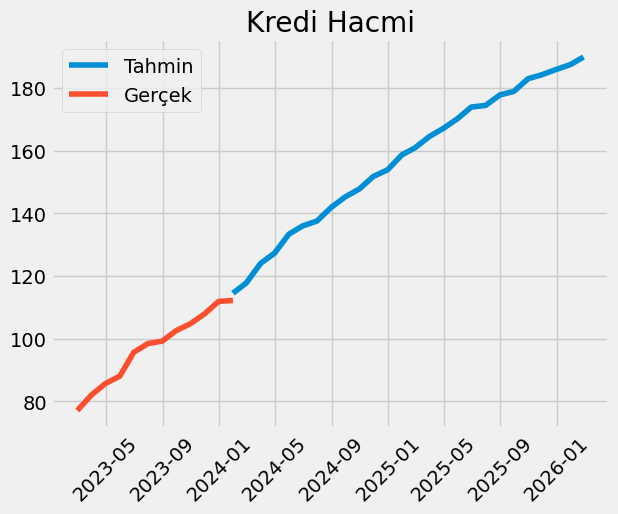

In [320]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(df3["Kredi Hacmi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [321]:
kreditahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(25)
kreditahmin

ds
2024-02-29    2.868389
2024-03-31    5.297859
2024-04-30    2.597207
2024-05-31    4.762220
2024-06-30    1.995263
2024-07-31    1.146786
2024-08-31    3.177710
2024-09-30    2.339994
2024-10-31    1.751668
2024-11-30    2.685380
2024-12-31    1.406555
2025-01-31    3.105118
2025-02-28    1.392382
2025-03-31    2.229997
2025-04-30    1.563786
2025-05-31    1.864303
2025-06-30    2.199529
2025-07-31    0.298800
2025-08-31    1.917210
2025-09-30    0.628309
2025-10-31    2.266093
2025-11-30    0.697634
2025-12-31    0.919860
2026-01-31    0.835158
2026-02-28    1.277716
Name: yhat, dtype: float64

In [322]:
kreditahmin1 = []
result = df3.iloc[-1,0]
for i in range(len(kreditahmin)):
    result *= (1 + kreditahmin[i] / 100)
    kreditahmin1.append(result)

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi Hacmi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi Hacmi":df3.iloc[-3:,0]},index=pd.date_range(start="2023-10-30",periods=3,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

Kredi Hacmi
2023-10-31          NaN
2023-11-30   107.866144
2023-12-31   111.894756
2024-01-31   115.429637
2024-02-29   121.544937
2024-03-31   124.701711
2024-04-30   130.640281
2024-05-31   133.246898
2024-06-30   134.774955
2024-07-31   139.057712
2024-08-31   142.311654
2024-09-30   144.804482
2024-10-31   148.693033
2024-11-30   150.784483
2024-12-31   155.466519
2025-01-31   157.631207
2025-02-28   161.146379
2025-03-31   163.666363
2025-04-30   166.717601
2025-05-31   170.384604
2025-06-30   170.893713
2025-07-31   174.170104
2025-08-31   175.264431
2025-09-30   179.236086
2025-10-31   180.486498
2025-11-30   182.146722
2025-12-31   183.667935
2026-01-31   186.014690

In [323]:
"""
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-01-16 17:07:19,103] A new study created in memory with name: no-name-9f9a939e-f995-456a-877b-e0f307f0fc77
17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:07:19,563] Trial 0 finished with value: 2296.231670730798 and parameters: {'changepoint_prior_scale': 3.5766117097026022, 'changepoint_range': 0.7064418125041662, 'growth': 'logistic', 'seasonality_prior_scale': 7.839090487370091, 'n_changepoints': 18, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 56.51631055896949}. Best is trial 0 with value: 2296.231670730798.
17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:07:19,993] Trial 1 finished with value: 31.063629737909924 and parameters: {'changepoint_prior_scale': 8.11777344271896, 'changepoint_range': 0.3877426938861499, 'growth': 'linear', 'seasonality_prior_scale': 4.779556703615615, 'n_changepoi

17:07:29 - cmdstanpy - INFO - Chain [1] start processing
17:07:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:07:29,434] Trial 16 finished with value: 16.68415313725483 and parameters: {'changepoint_prior_scale': 5.932937637160267, 'changepoint_range': 0.7507023602520848, 'growth': 'logistic', 'seasonality_prior_scale': 4.121363153906977, 'n_changepoints': 13, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 215.78214926669565}. Best is trial 16 with value: 16.68415313725483.
17:07:29 - cmdstanpy - INFO - Chain [1] start processing
17:07:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:07:29,972] Trial 17 finished with value: 18.082292937640027 and parameters: {'changepoint_prior_scale': 5.331081688426685, 'changepoint_range': 0.7660607557906087, 'growth': 'logistic', 'seasonality_prior_scale': 4.411365850953476, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 226.70947340625418}. Best is trial 16

17:07:39 - cmdstanpy - INFO - Chain [1] start processing
17:07:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:07:40,787] Trial 32 finished with value: 15.529643982614317 and parameters: {'changepoint_prior_scale': 3.1532816919136755, 'changepoint_range': 0.8965739605926454, 'growth': 'logistic', 'seasonality_prior_scale': 5.168201809150673, 'n_changepoints': 18, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 140.99613517474364}. Best is trial 26 with value: 12.16741355381704.
17:07:40 - cmdstanpy - INFO - Chain [1] start processing
17:07:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:07:41,323] Trial 33 finished with value: 12.605387289857111 and parameters: {'changepoint_prior_scale': 1.5555105727928025, 'changepoint_range': 0.8728004853887693, 'growth': 'logistic', 'seasonality_prior_scale': 5.072342259237464, 'n_changepoints': 18, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 145.0789915621097}. Best is t

17:07:50 - cmdstanpy - INFO - Chain [1] start processing
17:07:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:07:50,352] Trial 48 finished with value: 18.257491240613984 and parameters: {'changepoint_prior_scale': 0.3765401380795624, 'changepoint_range': 0.7378943418384456, 'growth': 'linear', 'seasonality_prior_scale': 2.3957626504846923, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 0.7548830439566021}. Best is trial 45 with value: 8.775280508458076.
17:07:50 - cmdstanpy - INFO - Chain [1] start processing
17:07:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:07:50,870] Trial 49 finished with value: 10.064398976056651 and parameters: {'changepoint_prior_scale': 1.8558731634605699, 'changepoint_range': 0.8464989086919039, 'growth': 'linear', 'seasonality_prior_scale': 0.3358937769598198, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 78.12006178605859}. Best is trial

17:08:08 - cmdstanpy - INFO - Chain [1] start processing
17:08:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:09,338] Trial 64 finished with value: 8.601884026208175 and parameters: {'changepoint_prior_scale': 0.6355655931166744, 'changepoint_range': 0.8525375118248261, 'growth': 'linear', 'seasonality_prior_scale': 0.9712462019710479, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 21.85386810004295}. Best is trial 64 with value: 8.601884026208175.
17:08:09 - cmdstanpy - INFO - Chain [1] start processing
17:08:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:10,035] Trial 65 finished with value: 16.103717233958516 and parameters: {'changepoint_prior_scale': 0.7114340547419387, 'changepoint_range': 0.8234915577977682, 'growth': 'linear', 'seasonality_prior_scale': 1.2596849057747466, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 14.616069923790768}. Best is trial 

17:08:20 - cmdstanpy - INFO - Chain [1] start processing
17:08:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:20,578] Trial 80 finished with value: 22.28224425514818 and parameters: {'changepoint_prior_scale': 1.0516718163941925, 'changepoint_range': 0.735532873882158, 'growth': 'linear', 'seasonality_prior_scale': 1.4434902896990591, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 52.341509124134866}. Best is trial 64 with value: 8.601884026208175.
17:08:20 - cmdstanpy - INFO - Chain [1] start processing
17:08:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:22,128] Trial 81 finished with value: 7.541307475394119 and parameters: {'changepoint_prior_scale': 2.0486891681024173, 'changepoint_range': 0.8523232302336501, 'growth': 'linear', 'seasonality_prior_scale': 2.2646737398481007, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 26.83254233409901}. Best is trial 81 

17:08:31 - cmdstanpy - INFO - Chain [1] start processing
17:08:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:32,232] Trial 96 finished with value: 7.530371368467865 and parameters: {'changepoint_prior_scale': 1.6312668928150498, 'changepoint_range': 0.8841740766822895, 'growth': 'linear', 'seasonality_prior_scale': 3.9025522035148663, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 325.70173328029176}. Best is trial 96 with value: 7.530371368467865.
17:08:32 - cmdstanpy - INFO - Chain [1] start processing
17:08:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:32,785] Trial 97 finished with value: 9.066325564926744 and parameters: {'changepoint_prior_scale': 1.5187947719222148, 'changepoint_range': 0.8979362110180125, 'growth': 'linear', 'seasonality_prior_scale': 4.130304827540449, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 331.15588926594484}. Best is trial 9

17:08:43 - cmdstanpy - INFO - Chain [1] start processing
17:08:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:43,556] Trial 112 finished with value: 25.791821457618394 and parameters: {'changepoint_prior_scale': 1.510556952251196, 'changepoint_range': 0.5773022446202796, 'growth': 'linear', 'seasonality_prior_scale': 3.8752117437912204, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 304.8250305083678}. Best is trial 103 with value: 7.12265319076448.
17:08:43 - cmdstanpy - INFO - Chain [1] start processing
17:08:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:44,187] Trial 113 finished with value: 8.676362423652865 and parameters: {'changepoint_prior_scale': 1.964265288498358, 'changepoint_range': 0.8569259401866766, 'growth': 'linear', 'seasonality_prior_scale': 4.553951856445229, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 398.53766016056005}. Best is trial 1

17:08:53 - cmdstanpy - INFO - Chain [1] start processing
17:08:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:53,451] Trial 128 finished with value: 8.011343756483182 and parameters: {'changepoint_prior_scale': 1.1538407895553293, 'changepoint_range': 0.8883726403172183, 'growth': 'linear', 'seasonality_prior_scale': 4.9640375035084485, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 341.0890891783595}. Best is trial 103 with value: 7.12265319076448.
17:08:53 - cmdstanpy - INFO - Chain [1] start processing
17:08:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:08:53,950] Trial 129 finished with value: 12.705994124221519 and parameters: {'changepoint_prior_scale': 1.4165505893501062, 'changepoint_range': 0.8320798529030661, 'growth': 'linear', 'seasonality_prior_scale': 5.5433191836237246, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 389.8482092078304}. Best is trial 103

17:09:04 - cmdstanpy - INFO - Chain [1] start processing
17:09:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:04,607] Trial 144 finished with value: 7.867611396000326 and parameters: {'changepoint_prior_scale': 1.830696496469662, 'changepoint_range': 0.886011410838443, 'growth': 'linear', 'seasonality_prior_scale': 5.010054517450179, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 361.1032696363781}. Best is trial 103 with value: 7.12265319076448.
17:09:04 - cmdstanpy - INFO - Chain [1] start processing
17:09:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:05,112] Trial 145 finished with value: 9.973628588089277 and parameters: {'changepoint_prior_scale': 1.2544639112185587, 'changepoint_range': 0.8590204481600932, 'growth': 'linear', 'seasonality_prior_scale': 5.686749959852019, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 378.0752358316325}. Best is trial 103 with

17:09:14 - cmdstanpy - INFO - Chain [1] start processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:15,375] Trial 160 finished with value: 8.769253089165781 and parameters: {'changepoint_prior_scale': 1.4692347378345552, 'changepoint_range': 0.8510269629858914, 'growth': 'logistic', 'seasonality_prior_scale': 5.193774639619155, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 393.35167415066223}. Best is trial 103 with value: 7.12265319076448.
17:09:15 - cmdstanpy - INFO - Chain [1] start processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:15,946] Trial 161 finished with value: 7.442370787026875 and parameters: {'changepoint_prior_scale': 1.5816155645898582, 'changepoint_range': 0.8856509755132432, 'growth': 'linear', 'seasonality_prior_scale': 3.835602633881404, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 375.5561275214777}. Best is trial 1

17:09:24 - cmdstanpy - INFO - Chain [1] start processing
17:09:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:25,474] Trial 176 finished with value: 7.5054475971844585 and parameters: {'changepoint_prior_scale': 1.1881794601726734, 'changepoint_range': 0.8863855124717813, 'growth': 'linear', 'seasonality_prior_scale': 3.5817354138955815, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 385.0575922591036}. Best is trial 168 with value: 7.079636153288823.
17:09:25 - cmdstanpy - INFO - Chain [1] start processing
17:09:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:26,027] Trial 177 finished with value: 14.4687106067453 and parameters: {'changepoint_prior_scale': 2.155579047880669, 'changepoint_range': 0.8305703817186099, 'growth': 'linear', 'seasonality_prior_scale': 4.874795383593021, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 367.74693401033693}. Best is trial 168 

17:09:34 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:35,187] Trial 192 finished with value: 10.3929645567704 and parameters: {'changepoint_prior_scale': 1.20694662037841, 'changepoint_range': 0.8673028909045374, 'growth': 'linear', 'seasonality_prior_scale': 4.191681014794694, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 259.65746346357867}. Best is trial 168 with value: 7.079636153288823.
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:35,688] Trial 193 finished with value: 7.714924298206469 and parameters: {'changepoint_prior_scale': 0.9086501636977266, 'changepoint_range': 0.8865440181645481, 'growth': 'linear', 'seasonality_prior_scale': 4.417409233441432, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 363.2537272000165}. Best is trial 168 wit

17:09:44 - cmdstanpy - INFO - Chain [1] start processing
17:09:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:44,862] Trial 208 finished with value: 10.169839372427385 and parameters: {'changepoint_prior_scale': 1.0873304122402951, 'changepoint_range': 0.899343181913879, 'growth': 'linear', 'seasonality_prior_scale': 5.4237059247433965, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 340.537359372153}. Best is trial 199 with value: 7.024689328461734.
17:09:45 - cmdstanpy - INFO - Chain [1] start processing
17:09:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:45,406] Trial 209 finished with value: 8.772988097882786 and parameters: {'changepoint_prior_scale': 1.6836755648679007, 'changepoint_range': 0.8780914515476506, 'growth': 'linear', 'seasonality_prior_scale': 5.273304016615909, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 368.27249272053}. Best is trial 199 wit

17:09:53 - cmdstanpy - INFO - Chain [1] start processing
17:09:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:54,717] Trial 224 finished with value: 7.430860995319243 and parameters: {'changepoint_prior_scale': 1.552851392825363, 'changepoint_range': 0.8849638974453325, 'growth': 'linear', 'seasonality_prior_scale': 2.7964757763417856, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 387.1453386695148}. Best is trial 199 with value: 7.024689328461734.
17:09:54 - cmdstanpy - INFO - Chain [1] start processing
17:09:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:09:55,216] Trial 225 finished with value: 9.887265436764991 and parameters: {'changepoint_prior_scale': 1.7697660394765584, 'changepoint_range': 0.8739080068764051, 'growth': 'linear', 'seasonality_prior_scale': 2.799733256845802, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 390.0246067495241}. Best is trial 199 w

17:10:05 - cmdstanpy - INFO - Chain [1] start processing
17:10:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:05,282] Trial 240 finished with value: 10.499431299339497 and parameters: {'changepoint_prior_scale': 0.7244698401601419, 'changepoint_range': 0.898588478774886, 'growth': 'linear', 'seasonality_prior_scale': 3.6149283900126177, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 390.722734529989}. Best is trial 199 with value: 7.024689328461734.
17:10:05 - cmdstanpy - INFO - Chain [1] start processing
17:10:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:05,817] Trial 241 finished with value: 7.428336924924699 and parameters: {'changepoint_prior_scale': 1.3512549739818431, 'changepoint_range': 0.885137229307837, 'growth': 'linear', 'seasonality_prior_scale': 3.1900189564662242, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 381.3047213568229}. Best is trial 199 w

17:10:15 - cmdstanpy - INFO - Chain [1] start processing
17:10:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:16,792] Trial 256 finished with value: 9.011491070201377 and parameters: {'changepoint_prior_scale': 1.0523046861977652, 'changepoint_range': 0.8786762801089552, 'growth': 'linear', 'seasonality_prior_scale': 2.8397896384670807, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 375.5096594469835}. Best is trial 199 with value: 7.024689328461734.
17:10:16 - cmdstanpy - INFO - Chain [1] start processing
17:10:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:17,405] Trial 257 finished with value: 11.006536305602916 and parameters: {'changepoint_prior_scale': 1.637737156253713, 'changepoint_range': 0.8685224662782909, 'growth': 'logistic', 'seasonality_prior_scale': 6.236170982357947, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 366.28296728551305}. Best is trial 1

17:10:25 - cmdstanpy - INFO - Chain [1] start processing
17:10:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:26,207] Trial 272 finished with value: 30.46996294274943 and parameters: {'changepoint_prior_scale': 1.730310536336729, 'changepoint_range': 0.8787945410293102, 'growth': 'linear', 'seasonality_prior_scale': 7.985534876028712, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 354.05864034038524}. Best is trial 199 with value: 7.024689328461734.
17:10:26 - cmdstanpy - INFO - Chain [1] start processing
17:10:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:26,733] Trial 273 finished with value: 7.519767596243638 and parameters: {'changepoint_prior_scale': 1.3446932778066705, 'changepoint_range': 0.8452779017055156, 'growth': 'linear', 'seasonality_prior_scale': 3.837810969498131, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 387.13548127918034}. Best is trial 199 w

17:10:37 - cmdstanpy - INFO - Chain [1] start processing
17:10:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:37,706] Trial 288 finished with value: 10.190125306636686 and parameters: {'changepoint_prior_scale': 2.067417181456909, 'changepoint_range': 0.8620983325886473, 'growth': 'linear', 'seasonality_prior_scale': 6.416149809957052, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 343.32546630167167}. Best is trial 199 with value: 7.024689328461734.
17:10:37 - cmdstanpy - INFO - Chain [1] start processing
17:10:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:39,195] Trial 289 finished with value: 9.696072465645194 and parameters: {'changepoint_prior_scale': 8.744483800958731, 'changepoint_range': 0.8743583150596004, 'growth': 'linear', 'seasonality_prior_scale': 7.313773036531957, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 328.8387371184408}. Best is trial 199 w

17:10:49 - cmdstanpy - INFO - Chain [1] start processing
17:10:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:49,751] Trial 304 finished with value: 11.153892453780905 and parameters: {'changepoint_prior_scale': 5.112287856863399, 'changepoint_range': 0.8685990333594088, 'growth': 'linear', 'seasonality_prior_scale': 6.435219978056889, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 387.71512794279863}. Best is trial 199 with value: 7.024689328461734.
17:10:49 - cmdstanpy - INFO - Chain [1] start processing
17:10:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:50,332] Trial 305 finished with value: 7.283748014403582 and parameters: {'changepoint_prior_scale': 5.547232257732885, 'changepoint_range': 0.8864986052229358, 'growth': 'linear', 'seasonality_prior_scale': 6.572318205610562, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 383.78917273966186}. Best is trial 

17:10:59 - cmdstanpy - INFO - Chain [1] start processing
17:10:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:59,335] Trial 320 finished with value: 7.291816953507254 and parameters: {'changepoint_prior_scale': 7.276664422492537, 'changepoint_range': 0.8494834711328264, 'growth': 'linear', 'seasonality_prior_scale': 6.2264194716518935, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 379.95610543397856}. Best is trial 199 with value: 7.024689328461734.
17:10:59 - cmdstanpy - INFO - Chain [1] start processing
17:10:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:10:59,809] Trial 321 finished with value: 24.958709281618784 and parameters: {'changepoint_prior_scale': 6.315669401984937, 'changepoint_range': 0.6066658156621791, 'growth': 'linear', 'seasonality_prior_scale': 6.770689989897377, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 389.14203747303026}. Best is trial

17:11:07 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:07,977] Trial 336 finished with value: 9.052495851179199 and parameters: {'changepoint_prior_scale': 6.926647786957079, 'changepoint_range': 0.8846740106254086, 'growth': 'linear', 'seasonality_prior_scale': 4.254893456408806, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 391.7479729286523}. Best is trial 199 with value: 7.024689328461734.
17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:08,530] Trial 337 finished with value: 9.385628972596948 and parameters: {'changepoint_prior_scale': 6.650988146359481, 'changepoint_range': 0.8728637537859982, 'growth': 'linear', 'seasonality_prior_scale': 4.925780065682745, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 360.41908232616237}. Best is trial 19

17:11:17 - cmdstanpy - INFO - Chain [1] start processing
17:11:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:18,845] Trial 352 finished with value: 8.557521990743213 and parameters: {'changepoint_prior_scale': 5.97948452462864, 'changepoint_range': 0.8561703883888531, 'growth': 'linear', 'seasonality_prior_scale': 6.170245205759944, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 399.9628794603294}. Best is trial 199 with value: 7.024689328461734.
17:11:19 - cmdstanpy - INFO - Chain [1] start processing
17:11:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:19,483] Trial 353 finished with value: 8.57115334968681 and parameters: {'changepoint_prior_scale': 4.523162673358134, 'changepoint_range': 0.8577641521553475, 'growth': 'linear', 'seasonality_prior_scale': 6.813782508072951, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 367.55221341390745}. Best is trial 199 

17:11:29 - cmdstanpy - INFO - Chain [1] start processing
17:11:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:29,455] Trial 368 finished with value: 16.386381178260667 and parameters: {'changepoint_prior_scale': 7.294637549742359, 'changepoint_range': 0.7485318840208126, 'growth': 'linear', 'seasonality_prior_scale': 4.926571104530889, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 366.03092127554373}. Best is trial 199 with value: 7.024689328461734.
17:11:29 - cmdstanpy - INFO - Chain [1] start processing
17:11:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:30,020] Trial 369 finished with value: 7.2732676664015115 and parameters: {'changepoint_prior_scale': 7.68502024734351, 'changepoint_range': 0.8477719210197727, 'growth': 'linear', 'seasonality_prior_scale': 5.035601693078309, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 369.46013521862255}. Best is trial 

17:11:38 - cmdstanpy - INFO - Chain [1] start processing
17:11:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:39,009] Trial 384 finished with value: 10.927492039035993 and parameters: {'changepoint_prior_scale': 7.533188380979302, 'changepoint_range': 0.8658467194200316, 'growth': 'linear', 'seasonality_prior_scale': 6.267636424334334, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 371.00753320743297}. Best is trial 199 with value: 7.024689328461734.
17:11:39 - cmdstanpy - INFO - Chain [1] start processing
17:11:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:39,477] Trial 385 finished with value: 7.442977286542206 and parameters: {'changepoint_prior_scale': 8.950214343754505, 'changepoint_range': 0.8517131200766903, 'growth': 'linear', 'seasonality_prior_scale': 5.456785332695033, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 340.56894168717685}. Best is trial 

17:11:46 - cmdstanpy - INFO - Chain [1] start processing
17:11:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:48,311] Trial 400 finished with value: 7.279816437850679 and parameters: {'changepoint_prior_scale': 7.1629917115356445, 'changepoint_range': 0.8468362197657225, 'growth': 'linear', 'seasonality_prior_scale': 5.433044978813983, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 241.5583224338127}. Best is trial 199 with value: 7.024689328461734.
17:11:48 - cmdstanpy - INFO - Chain [1] start processing
17:11:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:48,847] Trial 401 finished with value: 15.783645789329542 and parameters: {'changepoint_prior_scale': 6.915275784626872, 'changepoint_range': 0.8211423600197724, 'growth': 'linear', 'seasonality_prior_scale': 5.913603224331699, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 257.9473710548892}. Best is trial 1

17:11:59 - cmdstanpy - INFO - Chain [1] start processing
17:11:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:11:59,913] Trial 416 finished with value: 10.113954602896623 and parameters: {'changepoint_prior_scale': 7.868122482461019, 'changepoint_range': 0.8741484012160192, 'growth': 'linear', 'seasonality_prior_scale': 2.848837702233902, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 287.33854404543854}. Best is trial 199 with value: 7.024689328461734.
17:12:00 - cmdstanpy - INFO - Chain [1] start processing
17:12:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:00,339] Trial 417 finished with value: 25.203171918183354 and parameters: {'changepoint_prior_scale': 6.839275699294117, 'changepoint_range': 0.628855424578986, 'growth': 'linear', 'seasonality_prior_scale': 6.451679527171882, 'n_changepoints': 16, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 200.34162560405116}. Best is trial

17:12:08 - cmdstanpy - INFO - Chain [1] start processing
17:12:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:09,211] Trial 432 finished with value: 7.233374383573794 and parameters: {'changepoint_prior_scale': 4.0609633069331545, 'changepoint_range': 0.8855158125137927, 'growth': 'linear', 'seasonality_prior_scale': 4.979604506486237, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 332.2290662263112}. Best is trial 429 with value: 6.949790771835797.
17:12:09 - cmdstanpy - INFO - Chain [1] start processing
17:12:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:09,662] Trial 433 finished with value: 7.241939758187333 and parameters: {'changepoint_prior_scale': 3.9988353860528605, 'changepoint_range': 0.8873316136510947, 'growth': 'linear', 'seasonality_prior_scale': 4.951771138492622, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 318.8566386207865}. Best is trial 4

17:12:17 - cmdstanpy - INFO - Chain [1] start processing
17:12:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:18,004] Trial 448 finished with value: 9.414141009730992 and parameters: {'changepoint_prior_scale': 4.116994844404288, 'changepoint_range': 0.8749857427130546, 'growth': 'linear', 'seasonality_prior_scale': 4.693417923282809, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 320.7883911903497}. Best is trial 435 with value: 6.933366505586282.
17:12:18 - cmdstanpy - INFO - Chain [1] start processing
17:12:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:18,502] Trial 449 finished with value: 7.241420873874986 and parameters: {'changepoint_prior_scale': 4.319661461931679, 'changepoint_range': 0.8854245840035293, 'growth': 'linear', 'seasonality_prior_scale': 4.877354137190601, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 312.2424986539215}. Best is trial 435

17:12:26 - cmdstanpy - INFO - Chain [1] start processing
17:12:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:27,002] Trial 464 finished with value: 10.336044972636065 and parameters: {'changepoint_prior_scale': 4.43717341684923, 'changepoint_range': 0.8691776573310412, 'growth': 'linear', 'seasonality_prior_scale': 4.589095946200138, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 311.7289109610978}. Best is trial 435 with value: 6.933366505586282.
17:12:27 - cmdstanpy - INFO - Chain [1] start processing
17:12:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:27,503] Trial 465 finished with value: 10.990772108506565 and parameters: {'changepoint_prior_scale': 4.394239023526792, 'changepoint_range': 0.8782313002514509, 'growth': 'linear', 'seasonality_prior_scale': 4.820483769147305, 'n_changepoints': 20, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 305.0220196280104}. Best is trial 435 w

17:12:36 - cmdstanpy - INFO - Chain [1] start processing
17:12:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:36,637] Trial 480 finished with value: 9.901449143912764 and parameters: {'changepoint_prior_scale': 4.564263722327229, 'changepoint_range': 0.8985304138066803, 'growth': 'linear', 'seasonality_prior_scale': 3.888698462138186, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 300.7342939691507}. Best is trial 435 with value: 6.933366505586282.
17:12:36 - cmdstanpy - INFO - Chain [1] start processing
17:12:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:37,190] Trial 481 finished with value: 10.003135228510972 and parameters: {'changepoint_prior_scale': 4.8758672491692785, 'changepoint_range': 0.8674172197872791, 'growth': 'linear', 'seasonality_prior_scale': 3.581835920306034, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 292.9397434695784}. Best is trial 435 w

17:12:47 - cmdstanpy - INFO - Chain [1] start processing
17:12:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:47,696] Trial 496 finished with value: 10.518883126744242 and parameters: {'changepoint_prior_scale': 4.540937798251209, 'changepoint_range': 0.8634467153985399, 'growth': 'linear', 'seasonality_prior_scale': 3.5775324631034087, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 322.2477201511081}. Best is trial 482 with value: 6.9312549113750626.
17:12:47 - cmdstanpy - INFO - Chain [1] start processing
17:12:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:49,267] Trial 497 finished with value: 6.949612900398067 and parameters: {'changepoint_prior_scale': 4.360735028364143, 'changepoint_range': 0.8811602207802097, 'growth': 'linear', 'seasonality_prior_scale': 3.957663005138425, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 315.734751708593}. Best is trial 482

17:12:58 - cmdstanpy - INFO - Chain [1] start processing
17:12:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:58,638] Trial 512 finished with value: 7.40840812502698 and parameters: {'changepoint_prior_scale': 4.192551474594179, 'changepoint_range': 0.8815927255972688, 'growth': 'linear', 'seasonality_prior_scale': 4.1312270219569776, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 306.2943955371672}. Best is trial 482 with value: 6.9312549113750626.
17:12:58 - cmdstanpy - INFO - Chain [1] start processing
17:12:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:12:59,190] Trial 513 finished with value: 8.671276033116515 and parameters: {'changepoint_prior_scale': 4.448256560293739, 'changepoint_range': 0.8579767503021013, 'growth': 'linear', 'seasonality_prior_scale': 3.347560566809097, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 325.6658399822792}. Best is trial 482 wi

17:13:08 - cmdstanpy - INFO - Chain [1] start processing
17:13:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:13:08,554] Trial 528 finished with value: 9.756182893683379 and parameters: {'changepoint_prior_scale': 4.570731876997969, 'changepoint_range': 0.8722158918026736, 'growth': 'linear', 'seasonality_prior_scale': 3.93184815760766, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 312.9940520953043}. Best is trial 482 with value: 6.9312549113750626.
17:13:08 - cmdstanpy - INFO - Chain [1] start processing
17:13:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:13:09,239] Trial 529 finished with value: 10.21380028831947 and parameters: {'changepoint_prior_scale': 3.604499750666838, 'changepoint_range': 0.8993950937644661, 'growth': 'logistic', 'seasonality_prior_scale': 2.6718864356971963, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 345.6031398099043}. Best is trial 482 

17:13:19 - cmdstanpy - INFO - Chain [1] start processing
17:13:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:13:19,920] Trial 544 finished with value: 7.225212599962811 and parameters: {'changepoint_prior_scale': 4.292355879060621, 'changepoint_range': 0.8865661950043203, 'growth': 'linear', 'seasonality_prior_scale': 4.432139961692659, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 319.37937660049124}. Best is trial 482 with value: 6.9312549113750626.
17:13:20 - cmdstanpy - INFO - Chain [1] start processing
17:13:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:13:20,793] Trial 545 finished with value: 10.442305801010448 and parameters: {'changepoint_prior_scale': 3.008418172143358, 'changepoint_range': 0.8697405963096125, 'growth': 'linear', 'seasonality_prior_scale': 3.183711921462977, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 330.0564052882521}. Best is trial 482 

17:13:31 - cmdstanpy - INFO - Chain [1] start processing
17:13:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:13:31,654] Trial 560 finished with value: 11.37820134369209 and parameters: {'changepoint_prior_scale': 3.632255249969741, 'changepoint_range': 0.8638800688848677, 'growth': 'linear', 'seasonality_prior_scale': 3.202995432218117, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 320.3004354639333}. Best is trial 482 with value: 6.9312549113750626.
17:13:32 - cmdstanpy - INFO - Chain [1] start processing
17:13:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:13:32,927] Trial 561 finished with value: 7.225391599267473 and parameters: {'changepoint_prior_scale': 4.274146982973252, 'changepoint_range': 0.8857508904229572, 'growth': 'linear', 'seasonality_prior_scale': 4.560417027374309, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 334.4944959164087}. Best is trial 482 w

17:13:57 - cmdstanpy - INFO - Chain [1] start processing
17:13:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:13:57,712] Trial 576 finished with value: 8.583366620438209 and parameters: {'changepoint_prior_scale': 3.947009515354907, 'changepoint_range': 0.856136063194209, 'growth': 'linear', 'seasonality_prior_scale': 3.81905149595215, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 289.8132308450176}. Best is trial 482 with value: 6.9312549113750626.
17:13:58 - cmdstanpy - INFO - Chain [1] start processing
17:13:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:13:58,611] Trial 577 finished with value: 10.109958985727738 and parameters: {'changepoint_prior_scale': 1.277389889026133, 'changepoint_range': 0.8994671071780743, 'growth': 'linear', 'seasonality_prior_scale': 5.3251596805156725, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 309.59475289430713}. Best is trial 482 w

17:14:14 - cmdstanpy - INFO - Chain [1] start processing
17:14:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:14:15,099] Trial 592 finished with value: 7.607243254324824 and parameters: {'changepoint_prior_scale': 4.281355513959295, 'changepoint_range': 0.8533850399280607, 'growth': 'linear', 'seasonality_prior_scale': 5.143639668014139, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 305.14118488901084}. Best is trial 482 with value: 6.9312549113750626.
17:14:15 - cmdstanpy - INFO - Chain [1] start processing
17:14:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:14:15,941] Trial 593 finished with value: 7.624722865744208 and parameters: {'changepoint_prior_scale': 1.0671715680596021, 'changepoint_range': 0.8850333691954897, 'growth': 'linear', 'seasonality_prior_scale': 3.842670176048704, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 290.6543787274959}. Best is trial 482 

17:14:32 - cmdstanpy - INFO - Chain [1] start processing
17:14:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:14:33,291] Trial 608 finished with value: 9.873672145552463 and parameters: {'changepoint_prior_scale': 4.089255703164301, 'changepoint_range': 0.8997593029698611, 'growth': 'linear', 'seasonality_prior_scale': 4.58789154200595, 'n_changepoints': 19, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 296.1951060986329}. Best is trial 482 with value: 6.9312549113750626.
17:14:33 - cmdstanpy - INFO - Chain [1] start processing
17:14:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:14:33,916] Trial 609 finished with value: 8.66098024377641 and parameters: {'changepoint_prior_scale': 4.897979424911009, 'changepoint_range': 0.8547589107298362, 'growth': 'linear', 'seasonality_prior_scale': 3.9792713500281356, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 317.51953995298356}. Best is trial 482 wi

17:14:46 - cmdstanpy - INFO - Chain [1] start processing
17:14:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:14:46,794] Trial 624 finished with value: 7.4944017513174055 and parameters: {'changepoint_prior_scale': 4.096765109232721, 'changepoint_range': 0.8875898445336375, 'growth': 'logistic', 'seasonality_prior_scale': 2.7684700620849534, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 361.7150770226896}. Best is trial 482 with value: 6.9312549113750626.
17:14:47 - cmdstanpy - INFO - Chain [1] start processing
17:14:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:14:47,394] Trial 625 finished with value: 10.16866979053089 and parameters: {'changepoint_prior_scale': 0.9915508882453712, 'changepoint_range': 0.8994470624250082, 'growth': 'linear', 'seasonality_prior_scale': 3.226404765647768, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 365.06801990312266}. Best is trial 

17:14:57 - cmdstanpy - INFO - Chain [1] start processing
17:14:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:14:57,910] Trial 640 finished with value: 9.883425338743997 and parameters: {'changepoint_prior_scale': 1.9299682912910485, 'changepoint_range': 0.8616869063524718, 'growth': 'linear', 'seasonality_prior_scale': 5.59305060458767, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 310.6832449159674}. Best is trial 482 with value: 6.9312549113750626.
17:14:58 - cmdstanpy - INFO - Chain [1] start processing
17:14:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:14:58,526] Trial 641 finished with value: 15.953676416294117 and parameters: {'changepoint_prior_scale': 3.856357266769058, 'changepoint_range': 0.7476343233601479, 'growth': 'linear', 'seasonality_prior_scale': 2.0749285747102166, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 372.68381332648187}. Best is trial 482

17:15:08 - cmdstanpy - INFO - Chain [1] start processing
17:15:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:08,848] Trial 656 finished with value: 7.519981514153128 and parameters: {'changepoint_prior_scale': 1.1514448087271, 'changepoint_range': 0.8855388880214304, 'growth': 'linear', 'seasonality_prior_scale': 2.592081978811821, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 322.2970278490484}. Best is trial 482 with value: 6.9312549113750626.
17:15:09 - cmdstanpy - INFO - Chain [1] start processing
17:15:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:09,536] Trial 657 finished with value: 10.627288063760592 and parameters: {'changepoint_prior_scale': 0.9670595845704116, 'changepoint_range': 0.8675990283585188, 'growth': 'linear', 'seasonality_prior_scale': 2.3327195918552377, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 335.0520091542945}. Best is trial 482 w

17:15:19 - cmdstanpy - INFO - Chain [1] start processing
17:15:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:20,268] Trial 672 finished with value: 9.904210494453304 and parameters: {'changepoint_prior_scale': 3.6939157121261417, 'changepoint_range': 0.8995689319956285, 'growth': 'linear', 'seasonality_prior_scale': 3.391478949456353, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 66.4970970923298}. Best is trial 482 with value: 6.9312549113750626.
17:15:20 - cmdstanpy - INFO - Chain [1] start processing
17:15:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:20,824] Trial 673 finished with value: 9.936529054092798 and parameters: {'changepoint_prior_scale': 1.7503048922197233, 'changepoint_range': 0.872610790073962, 'growth': 'linear', 'seasonality_prior_scale': 4.78442973744075, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 329.0114442210137}. Best is trial 482 w

17:15:34 - cmdstanpy - INFO - Chain [1] start processing
17:15:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:34,726] Trial 688 finished with value: 9.891938791915273 and parameters: {'changepoint_prior_scale': 4.7098320531867675, 'changepoint_range': 0.8996686071853938, 'growth': 'linear', 'seasonality_prior_scale': 3.328581590079396, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 322.1981317874484}. Best is trial 482 with value: 6.9312549113750626.
17:15:35 - cmdstanpy - INFO - Chain [1] start processing
17:15:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:35,578] Trial 689 finished with value: 9.443203405044784 and parameters: {'changepoint_prior_scale': 2.7208236630191567, 'changepoint_range': 0.8728847795281094, 'growth': 'linear', 'seasonality_prior_scale': 2.489453848885887, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 355.0263928406741}. Best is trial 482 

17:15:46 - cmdstanpy - INFO - Chain [1] start processing
17:15:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:46,974] Trial 704 finished with value: 7.466775610643111 and parameters: {'changepoint_prior_scale': 1.3912036219414157, 'changepoint_range': 0.8871943699273136, 'growth': 'linear', 'seasonality_prior_scale': 5.648004176559412, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 284.1010174643923}. Best is trial 482 with value: 6.9312549113750626.
17:15:47 - cmdstanpy - INFO - Chain [1] start processing
17:15:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:47,593] Trial 705 finished with value: 9.924384450954337 and parameters: {'changepoint_prior_scale': 3.186120744661034, 'changepoint_range': 0.899888512682132, 'growth': 'linear', 'seasonality_prior_scale': 3.8883260733111906, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 309.84388852531987}. Best is trial 48

17:15:58 - cmdstanpy - INFO - Chain [1] start processing
17:15:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:58,439] Trial 720 finished with value: 10.936516259942593 and parameters: {'changepoint_prior_scale': 3.8684011059943684, 'changepoint_range': 0.8996082727805018, 'growth': 'linear', 'seasonality_prior_scale': 5.082918955680681, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 374.6744801651834}. Best is trial 482 with value: 6.9312549113750626.
17:15:58 - cmdstanpy - INFO - Chain [1] start processing
17:15:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:15:59,263] Trial 721 finished with value: 10.74563306505439 and parameters: {'changepoint_prior_scale': 2.0560921733986715, 'changepoint_range': 0.8657507142433236, 'growth': 'logistic', 'seasonality_prior_scale': 4.982193190056116, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 387.717034181614}. Best is trial 4

17:16:10 - cmdstanpy - INFO - Chain [1] start processing
17:16:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:16:10,760] Trial 736 finished with value: 10.304274729012047 and parameters: {'changepoint_prior_scale': 1.4853871317571965, 'changepoint_range': 0.871549315176189, 'growth': 'linear', 'seasonality_prior_scale': 4.272872031606472, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 371.6957925956995}. Best is trial 482 with value: 6.9312549113750626.
17:16:11 - cmdstanpy - INFO - Chain [1] start processing
17:16:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:16:11,538] Trial 737 finished with value: 10.139840772509942 and parameters: {'changepoint_prior_scale': 1.1776214094992143, 'changepoint_range': 0.8995465341053127, 'growth': 'linear', 'seasonality_prior_scale': 4.766815534148855, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 362.4249369570207}. Best is trial 4

17:16:24 - cmdstanpy - INFO - Chain [1] start processing
17:16:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:16:25,334] Trial 752 finished with value: 11.143371040050766 and parameters: {'changepoint_prior_scale': 3.5523262165416294, 'changepoint_range': 0.8373806123867583, 'growth': 'linear', 'seasonality_prior_scale': 5.283982967228407, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 399.85377830403326}. Best is trial 482 with value: 6.9312549113750626.
17:16:25 - cmdstanpy - INFO - Chain [1] start processing
17:16:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:16:26,211] Trial 753 finished with value: 9.723045707129977 and parameters: {'changepoint_prior_scale': 3.740534085298921, 'changepoint_range': 0.8741472280124994, 'growth': 'linear', 'seasonality_prior_scale': 5.157950764481781, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 90.75862991630311}. Best is tria

17:16:40 - cmdstanpy - INFO - Chain [1] start processing
17:16:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:16:41,762] Trial 768 finished with value: 10.097758014445144 and parameters: {'changepoint_prior_scale': 1.4433645600839278, 'changepoint_range': 0.8999072664468938, 'growth': 'linear', 'seasonality_prior_scale': 2.5674205092516833, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 344.904150895682}. Best is trial 482 with value: 6.9312549113750626.
17:16:41 - cmdstanpy - INFO - Chain [1] start processing
17:16:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:16:43,259] Trial 769 finished with value: 10.24066529549979 and parameters: {'changepoint_prior_scale': 1.0947201300141138, 'changepoint_range': 0.8780631348887575, 'growth': 'linear', 'seasonality_prior_scale': 5.548619906069637, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 376.31433234707004}. Best is trial

17:16:52 - cmdstanpy - INFO - Chain [1] start processing
17:16:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:16:52,670] Trial 784 finished with value: 10.650340042713518 and parameters: {'changepoint_prior_scale': 1.9658190262883097, 'changepoint_range': 0.8602507301554884, 'growth': 'linear', 'seasonality_prior_scale': 5.177488695385176, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'cap': 333.919069179109}. Best is trial 482 with value: 6.9312549113750626.
17:16:52 - cmdstanpy - INFO - Chain [1] start processing
17:16:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:16:53,148] Trial 785 finished with value: 7.305000019562231 and parameters: {'changepoint_prior_scale': 4.114855720299068, 'changepoint_range': 0.8861470402931211, 'growth': 'linear', 'seasonality_prior_scale': 5.007504137829226, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 354.68619965354986}. Best is trial 

17:17:02 - cmdstanpy - INFO - Chain [1] start processing
17:17:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:03,556] Trial 800 finished with value: 24.61843670216075 and parameters: {'changepoint_prior_scale': 3.7299341203670586, 'changepoint_range': 0.6322465299331522, 'growth': 'logistic', 'seasonality_prior_scale': 4.280500112310709, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 325.1048752095862}. Best is trial 482 with value: 6.9312549113750626.
17:17:03 - cmdstanpy - INFO - Chain [1] start processing
17:17:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:04,112] Trial 801 finished with value: 9.897186038485659 and parameters: {'changepoint_prior_scale': 4.102035553454449, 'changepoint_range': 0.8997945860095592, 'growth': 'linear', 'seasonality_prior_scale': 3.1788932830486756, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 329.546739875595}. Best is trial 4

17:17:15 - cmdstanpy - INFO - Chain [1] start processing
17:17:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:15,776] Trial 816 finished with value: 10.023321020693533 and parameters: {'changepoint_prior_scale': 4.478941844163917, 'changepoint_range': 0.8997244174923938, 'growth': 'logistic', 'seasonality_prior_scale': 4.0400393638498, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 332.7960503664025}. Best is trial 482 with value: 6.9312549113750626.
17:17:15 - cmdstanpy - INFO - Chain [1] start processing
17:17:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:17,295] Trial 817 finished with value: 9.405319703108626 and parameters: {'changepoint_prior_scale': 4.689085007752283, 'changepoint_range': 0.8757084965214272, 'growth': 'linear', 'seasonality_prior_scale': 3.531513784027447, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 323.69840966733915}. Best is trial 48

17:17:28 - cmdstanpy - INFO - Chain [1] start processing
17:17:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:28,904] Trial 832 finished with value: 7.425658916669112 and parameters: {'changepoint_prior_scale': 3.401793780170325, 'changepoint_range': 0.8825450427202284, 'growth': 'linear', 'seasonality_prior_scale': 5.9557448272703395, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 332.06717121982433}. Best is trial 482 with value: 6.9312549113750626.
17:17:29 - cmdstanpy - INFO - Chain [1] start processing
17:17:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:29,544] Trial 833 finished with value: 7.601285305160509 and parameters: {'changepoint_prior_scale': 3.843420441083567, 'changepoint_range': 0.8537681714768253, 'growth': 'linear', 'seasonality_prior_scale': 5.839464233048016, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 340.568299141521}. Best is trial 4

17:17:37 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:38,240] Trial 848 finished with value: 10.979464221874622 and parameters: {'changepoint_prior_scale': 3.5225132360983946, 'changepoint_range': 0.8995153580787717, 'growth': 'linear', 'seasonality_prior_scale': 5.634502365788647, 'n_changepoints': 17, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 315.7826255124275}. Best is trial 482 with value: 6.9312549113750626.
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:38,774] Trial 849 finished with value: 15.370314983720437 and parameters: {'changepoint_prior_scale': 3.215859048212069, 'changepoint_range': 0.8232200264091116, 'growth': 'linear', 'seasonality_prior_scale': 6.1166106014566575, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 321.2345533927229}. Best is trial 

17:17:48 - cmdstanpy - INFO - Chain [1] start processing
17:17:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:48,637] Trial 864 finished with value: 26.44376950846699 and parameters: {'changepoint_prior_scale': 3.545276519622827, 'changepoint_range': 0.40162405699509707, 'growth': 'linear', 'seasonality_prior_scale': 5.98248716895768, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 343.63636347283597}. Best is trial 482 with value: 6.9312549113750626.
17:17:48 - cmdstanpy - INFO - Chain [1] start processing
17:17:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:49,246] Trial 865 finished with value: 10.953956570408673 and parameters: {'changepoint_prior_scale': 3.771989856536646, 'changepoint_range': 0.8656113073423428, 'growth': 'linear', 'seasonality_prior_scale': 6.00490184711135, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 338.0462671315098}. Best is trial 482 w

17:17:58 - cmdstanpy - INFO - Chain [1] start processing
17:17:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:58,609] Trial 880 finished with value: 10.759052183588919 and parameters: {'changepoint_prior_scale': 4.394351451079106, 'changepoint_range': 0.8997436851574365, 'growth': 'linear', 'seasonality_prior_scale': 5.37740132123013, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 321.01846454529357}. Best is trial 482 with value: 6.9312549113750626.
17:17:58 - cmdstanpy - INFO - Chain [1] start processing
17:17:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:17:59,164] Trial 881 finished with value: 8.681992411188498 and parameters: {'changepoint_prior_scale': 3.794807266249896, 'changepoint_range': 0.8580325263781601, 'growth': 'linear', 'seasonality_prior_scale': 5.152372739820057, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 345.2585279185372}. Best is trial 482 

17:18:08 - cmdstanpy - INFO - Chain [1] start processing
17:18:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:09,183] Trial 896 finished with value: 7.310498731627599 and parameters: {'changepoint_prior_scale': 3.720360984481456, 'changepoint_range': 0.8861923449811289, 'growth': 'linear', 'seasonality_prior_scale': 7.58873144750141, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 320.9346271720513}. Best is trial 482 with value: 6.9312549113750626.
17:18:09 - cmdstanpy - INFO - Chain [1] start processing
17:18:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:09,792] Trial 897 finished with value: 10.183455278142961 and parameters: {'changepoint_prior_scale': 4.359177790405378, 'changepoint_range': 0.8619521331529412, 'growth': 'linear', 'seasonality_prior_scale': 5.641503776691357, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 314.27477118955943}. Best is trial 4

17:18:17 - cmdstanpy - INFO - Chain [1] start processing
17:18:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:17,560] Trial 912 finished with value: 7.2323677674432645 and parameters: {'changepoint_prior_scale': 4.258449785249172, 'changepoint_range': 0.8860296882008503, 'growth': 'linear', 'seasonality_prior_scale': 4.714159620572844, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 324.6463271760211}. Best is trial 482 with value: 6.9312549113750626.
17:18:17 - cmdstanpy - INFO - Chain [1] start processing
17:18:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:18,163] Trial 913 finished with value: 10.941100269489597 and parameters: {'changepoint_prior_scale': 5.2008430581526985, 'changepoint_range': 0.8637654433477149, 'growth': 'linear', 'seasonality_prior_scale': 3.6455839356922537, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 330.5750173256915}. Best is trial 

17:18:26 - cmdstanpy - INFO - Chain [1] start processing
17:18:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:27,144] Trial 928 finished with value: 9.767502666353614 and parameters: {'changepoint_prior_scale': 3.7547047484204543, 'changepoint_range': 0.860017281268379, 'growth': 'linear', 'seasonality_prior_scale': 4.643481322776124, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 330.2151556060956}. Best is trial 482 with value: 6.9312549113750626.
17:18:27 - cmdstanpy - INFO - Chain [1] start processing
17:18:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:27,622] Trial 929 finished with value: 16.368627313699864 and parameters: {'changepoint_prior_scale': 4.2114253535815305, 'changepoint_range': 0.7370114244096164, 'growth': 'linear', 'seasonality_prior_scale': 5.452790384960879, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 340.36029158320673}. Best is trial 4

17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:37,664] Trial 944 finished with value: 27.457783400284942 and parameters: {'changepoint_prior_scale': 3.4203270702056283, 'changepoint_range': 0.2584503538680475, 'growth': 'linear', 'seasonality_prior_scale': 3.6969227005938845, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 326.9417328258073}. Best is trial 482 with value: 6.9312549113750626.
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:38,320] Trial 945 finished with value: 7.216720163380041 and parameters: {'changepoint_prior_scale': 4.9857468050526865, 'changepoint_range': 0.8858409640092569, 'growth': 'linear', 'seasonality_prior_scale': 4.63706293497989, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 359.29285019215297}. Best is trial 

17:18:50 - cmdstanpy - INFO - Chain [1] start processing
17:18:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:51,024] Trial 960 finished with value: 9.740379949269194 and parameters: {'changepoint_prior_scale': 4.385604389438643, 'changepoint_range': 0.8740819908833102, 'growth': 'linear', 'seasonality_prior_scale': 5.028228116911091, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 350.2947035371299}. Best is trial 482 with value: 6.9312549113750626.
17:18:51 - cmdstanpy - INFO - Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:18:51,624] Trial 961 finished with value: 25.728135681921355 and parameters: {'changepoint_prior_scale': 3.861322100358114, 'changepoint_range': 0.5184916365438066, 'growth': 'linear', 'seasonality_prior_scale': 3.6740726756475084, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 297.0271578831659}. Best is trial 482 

17:19:00 - cmdstanpy - INFO - Chain [1] start processing
17:19:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:19:00,335] Trial 976 finished with value: 26.126220457304104 and parameters: {'changepoint_prior_scale': 4.076659904863464, 'changepoint_range': 0.5017145494887235, 'growth': 'linear', 'seasonality_prior_scale': 6.080172126992199, 'n_changepoints': 12, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 330.42393309006945}. Best is trial 482 with value: 6.9312549113750626.
17:19:00 - cmdstanpy - INFO - Chain [1] start processing
17:19:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:19:00,877] Trial 977 finished with value: 10.162510908788889 and parameters: {'changepoint_prior_scale': 3.720643319249264, 'changepoint_range': 0.8734885541916818, 'growth': 'linear', 'seasonality_prior_scale': 4.117817319322963, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 308.4984000045486}. Best is trial 

17:19:09 - cmdstanpy - INFO - Chain [1] start processing
17:19:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:19:09,553] Trial 992 finished with value: 11.206583957927021 and parameters: {'changepoint_prior_scale': 4.962011952655154, 'changepoint_range': 0.8379662337144762, 'growth': 'linear', 'seasonality_prior_scale': 3.890027955051276, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 345.1530187110503}. Best is trial 482 with value: 6.9312549113750626.
17:19:09 - cmdstanpy - INFO - Chain [1] start processing
17:19:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:19:10,114] Trial 993 finished with value: 7.3578604482435 and parameters: {'changepoint_prior_scale': 9.21193159581578, 'changepoint_range': 0.8875714662239514, 'growth': 'linear', 'seasonality_prior_scale': 0.05966715871945283, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 323.1941408049968}. Best is trial 482 wi

In [324]:
#study.best_params

{'changepoint_prior_scale': 4.300878191702313,
 'changepoint_range': 0.8830436991316976,
 'growth': 'linear',
 'seasonality_prior_scale': 3.9970986765015284,
 'n_changepoints': 25,
 'yearly_seasonality': True,
 'weekly_seasonality': True,
 'cap': 290.42551958280353}

In [325]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
prophet=Prophet(changepoint_prior_scale=4.300878191702313,changepoint_range=0.8830436991316976,growth='linear',seasonality_prior_scale=3.9970986765015284,n_changepoints=25,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

17:20:02 - cmdstanpy - INFO - Chain [1] start processing
17:20:03 - cmdstanpy - INFO - Chain [1] done processing


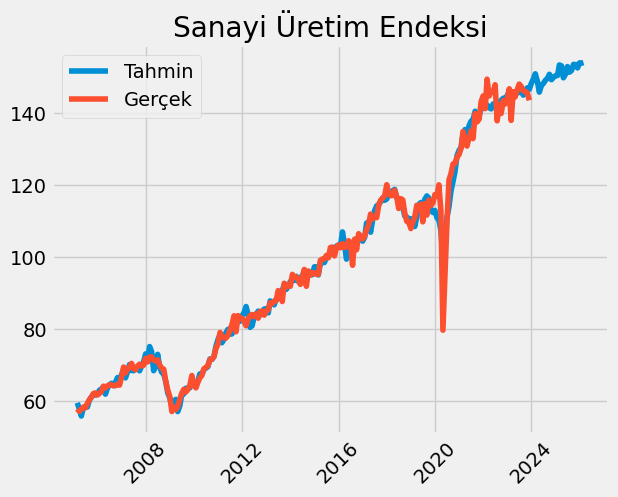

In [326]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [327]:
sanayitahmin=(predictions["yhat"].tail(28).pct_change(periods=1)*100).dropna()
sanayitahmin1 = []
result = df3.iloc[-1,0]
for i in range(len(sanayitahmin)):
    result *= (1 + sanayitahmin[i] / 100)
    sanayitahmin1.append(result)

sanayitahmin1 = np.array(sanayitahmin1).reshape(-1, 1)
sanayitahmin1 = pd.DataFrame(sanayitahmin1)
sanayitahmin1.columns = ["Sanayi"]
sanayitahmin1 = sanayitahmin1.set_index(pd.date_range(start="2023-11-30", periods=len(sanayitahmin1), freq="1M"))
#row=pd.DataFrame({"Sanayi":df3.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
#sanayitahmin1=pd.concat([row,sanayitahmin1],axis=0)
sanayitahmin1

Sanayi
2023-11-30  113.488283
2023-12-31  114.413479
2024-01-31  115.508286
2024-02-29  113.940634
2024-03-31  111.608721
2024-04-30  113.021132
2024-05-31  113.447359
2024-06-30  114.115414
2024-07-31  114.537222
2024-08-31  115.405965
2024-09-30  114.247820
2024-10-31  114.751804
2024-11-30  115.102749
2024-12-31  115.150331
2025-01-31  117.387101
2025-02-28  117.211192
2025-03-31  114.653791
2025-04-30  115.412770
2025-05-31  117.046043
2025-06-30  115.854124
2025-07-31  116.209341
2025-08-31  117.504516
2025-09-30  117.465435
2025-10-31  116.753523
2025-11-30  117.842824
2025-12-31  117.782990
2026-01-31  117.896715

In [328]:
"""
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"][params["m"]:-36].index
    sn["y"]=redkt["REDKT"][params["m"]:-36].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"][-36:],predictions["yhat"][-36:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-01-16 17:21:37,182] A new study created in memory with name: no-name-61dfc5f1-7b41-49e0-910b-56c53e134211
17:21:37 - cmdstanpy - INFO - Chain [1] start processing
17:21:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:21:37,587] Trial 0 finished with value: 47.15236426686978 and parameters: {'changepoint_prior_scale': 4.1222126358051385, 'changepoint_range': 0.29766762807612446, 'growth': 'linear', 'seasonality_prior_scale': 8.508694906726491, 'n_changepoints': 6, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 84, 'cap': 395.17856559380846}. Best is trial 0 with value: 47.15236426686978.
17:21:37 - cmdstanpy - INFO - Chain [1] start processing
17:21:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:21:38,094] Trial 1 finished with value: 87.32336640938148 and parameters: {'changepoint_prior_scale': 3.1870493457833855, 'changepoint_range': 0.4527204237312964, 'growth': 'linear', 'seasonality_prior_scale': 3.5577666009719473, 'n

17:22:03 - cmdstanpy - INFO - Chain [1] start processing
17:22:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:22:04,584] Trial 16 finished with value: 27.49368364989667 and parameters: {'changepoint_prior_scale': 4.060332311060697, 'changepoint_range': 0.1034484958521239, 'growth': 'logistic', 'seasonality_prior_scale': 1.7340388654177823, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 24, 'cap': 285.8804162405828}. Best is trial 16 with value: 27.49368364989667.
17:22:04 - cmdstanpy - INFO - Chain [1] start processing
17:22:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:22:04,982] Trial 17 finished with value: 49.768018798454904 and parameters: {'changepoint_prior_scale': 5.9131086881180215, 'changepoint_range': 0.10686480033697165, 'growth': 'logistic', 'seasonality_prior_scale': 3.655665883150932, 'n_changepoints': 21, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 0, 'cap': 287.0931375571

17:22:17 - cmdstanpy - INFO - Chain [1] start processing
17:22:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:22:17,285] Trial 32 finished with value: 80.90914164907966 and parameters: {'changepoint_prior_scale': 4.090960885276782, 'changepoint_range': 0.769009223032136, 'growth': 'linear', 'seasonality_prior_scale': 7.3951127104890695, 'n_changepoints': 15, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 31, 'cap': 306.02721804496866}. Best is trial 24 with value: 19.87023697365702.
17:22:17 - cmdstanpy - INFO - Chain [1] start processing
17:22:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:22:17,726] Trial 33 finished with value: 40.61218821753288 and parameters: {'changepoint_prior_scale': 4.882286138929133, 'changepoint_range': 0.6530612299545081, 'growth': 'linear', 'seasonality_prior_scale': 8.971135458354986, 'n_changepoints': 18, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 40, 'cap': 374.1325857180823

17:22:42 - cmdstanpy - INFO - Chain [1] start processing
17:22:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:22:43,185] Trial 48 finished with value: 246.9309841963867 and parameters: {'changepoint_prior_scale': 5.171681063516331, 'changepoint_range': 0.804142293424064, 'growth': 'linear', 'seasonality_prior_scale': 1.3303383581651893, 'n_changepoints': 18, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 34, 'cap': 383.03995503514915}. Best is trial 24 with value: 19.87023697365702.
17:22:43 - cmdstanpy - INFO - Chain [1] start processing
17:22:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:22:43,863] Trial 49 finished with value: 762.6144691315088 and parameters: {'changepoint_prior_scale': 9.83597890362404, 'changepoint_range': 0.8531050526554738, 'growth': 'linear', 'seasonality_prior_scale': 3.0556586902876957, 'n_changepoints': 14, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 56, 'cap': 218.22007596082983}. B

17:22:54 - cmdstanpy - INFO - Chain [1] start processing
17:22:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:22:55,024] Trial 64 finished with value: 24.00514292044478 and parameters: {'changepoint_prior_scale': 4.650804659586011, 'changepoint_range': 0.770330395101686, 'growth': 'linear', 'seasonality_prior_scale': 1.001437331572305, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 13, 'cap': 326.1866823611222}. Best is trial 24 with value: 19.87023697365702.
17:22:55 - cmdstanpy - INFO - Chain [1] start processing
17:22:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:22:55,503] Trial 65 finished with value: 21.71353082599893 and parameters: {'changepoint_prior_scale': 4.656838217183841, 'changepoint_range': 0.7706509436170037, 'growth': 'linear', 'seasonality_prior_scale': 1.3631994086980082, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 14, 'cap': 323.3734881173828}. Best

17:23:02 - cmdstanpy - INFO - Chain [1] start processing
17:23:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:03,046] Trial 80 finished with value: 55.67964440622304 and parameters: {'changepoint_prior_scale': 6.114110617491795, 'changepoint_range': 0.8653832415557129, 'growth': 'linear', 'seasonality_prior_scale': 8.807769508369976, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 11, 'cap': 386.1327752558071}. Best is trial 73 with value: 19.752720708594346.
17:23:03 - cmdstanpy - INFO - Chain [1] start processing
17:23:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:03,776] Trial 81 finished with value: 3101.678654802199 and parameters: {'changepoint_prior_scale': 5.072532559570869, 'changepoint_range': 0.7319469786073197, 'growth': 'linear', 'seasonality_prior_scale': 7.635832825215117, 'n_changepoints': 11, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 110, 'cap': 317.6329906349815}. 

17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:15,436] Trial 96 finished with value: 45.596894155416095 and parameters: {'changepoint_prior_scale': 7.958658045887591, 'changepoint_range': 0.8501094028622276, 'growth': 'logistic', 'seasonality_prior_scale': 6.207452482386941, 'n_changepoints': 5, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 16, 'cap': 325.73931152782626}. Best is trial 73 with value: 19.752720708594346.
17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:16,916] Trial 97 finished with value: 62.99098386530457 and parameters: {'changepoint_prior_scale': 5.526518658209213, 'changepoint_range': 0.8246499472763095, 'growth': 'linear', 'seasonality_prior_scale': 4.888503602829114, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 36, 'cap': 336.4337016661009}

17:23:27 - cmdstanpy - INFO - Chain [1] start processing
17:23:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:27,739] Trial 112 finished with value: 19.09482352168877 and parameters: {'changepoint_prior_scale': 4.035439804194805, 'changepoint_range': 0.7123906378408776, 'growth': 'logistic', 'seasonality_prior_scale': 8.384142955392063, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 58, 'cap': 300.29353396529365}. Best is trial 104 with value: 18.292828130425562.
17:23:27 - cmdstanpy - INFO - Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:28,567] Trial 113 finished with value: 19.08808688232104 and parameters: {'changepoint_prior_scale': 3.9359456227566088, 'changepoint_range': 0.7103446680539002, 'growth': 'logistic', 'seasonality_prior_scale': 8.514553252224133, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 58, 'cap': 302.81427071

17:23:36 - cmdstanpy - INFO - Chain [1] start processing
17:23:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:37,073] Trial 128 finished with value: 19.19466398109469 and parameters: {'changepoint_prior_scale': 3.8753159537041517, 'changepoint_range': 0.6500020104707511, 'growth': 'logistic', 'seasonality_prior_scale': 7.526877056466478, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 66, 'cap': 314.6901330414158}. Best is trial 104 with value: 18.292828130425562.
17:23:37 - cmdstanpy - INFO - Chain [1] start processing
17:23:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:37,545] Trial 129 finished with value: 86.5652437634226 and parameters: {'changepoint_prior_scale': 4.761613670469344, 'changepoint_range': 0.7279187420438541, 'growth': 'logistic', 'seasonality_prior_scale': 8.028318364281885, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 60, 'cap': 259.3328017374

17:23:44 - cmdstanpy - INFO - Chain [1] start processing
17:23:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:44,309] Trial 144 finished with value: 22.35113835843029 and parameters: {'changepoint_prior_scale': 3.8752720053121275, 'changepoint_range': 0.6779043569662478, 'growth': 'logistic', 'seasonality_prior_scale': 9.204148336527997, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 57, 'cap': 339.6863552984713}. Best is trial 104 with value: 18.292828130425562.
17:23:44 - cmdstanpy - INFO - Chain [1] start processing
17:23:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:44,795] Trial 145 finished with value: 19.470833431926092 and parameters: {'changepoint_prior_scale': 4.095346329831737, 'changepoint_range': 0.7015459475186516, 'growth': 'logistic', 'seasonality_prior_scale': 7.999080819656177, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 60, 'cap': 320.29197860

17:23:52 - cmdstanpy - INFO - Chain [1] start processing
17:23:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:52,564] Trial 160 finished with value: 21.808189372552473 and parameters: {'changepoint_prior_scale': 4.679691499461702, 'changepoint_range': 0.670151376827733, 'growth': 'logistic', 'seasonality_prior_scale': 9.358404006320395, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 59, 'cap': 305.00537802846156}. Best is trial 104 with value: 18.292828130425562.
17:23:52 - cmdstanpy - INFO - Chain [1] start processing
17:23:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:52,993] Trial 161 finished with value: 19.8080247699838 and parameters: {'changepoint_prior_scale': 4.531588771021438, 'changepoint_range': 0.7071815342238991, 'growth': 'logistic', 'seasonality_prior_scale': 8.448939790010705, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 55, 'cap': 290.9648872847

17:23:59 - cmdstanpy - INFO - Chain [1] start processing
17:23:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:23:59,695] Trial 176 finished with value: 19.680393345934018 and parameters: {'changepoint_prior_scale': 4.825072079781493, 'changepoint_range': 0.42669396650027985, 'growth': 'logistic', 'seasonality_prior_scale': 7.493870922130312, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 60, 'cap': 313.23535271369235}. Best is trial 104 with value: 18.292828130425562.
17:23:59 - cmdstanpy - INFO - Chain [1] start processing
17:24:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:00,105] Trial 177 finished with value: 22.57448848743452 and parameters: {'changepoint_prior_scale': 0.5601215074605062, 'changepoint_range': 0.31443385195770157, 'growth': 'logistic', 'seasonality_prior_scale': 7.207776234881891, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 66, 'cap': 329.49222

17:24:07 - cmdstanpy - INFO - Chain [1] start processing
17:24:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:07,624] Trial 192 finished with value: 18.21499552126455 and parameters: {'changepoint_prior_scale': 5.0097131573555345, 'changepoint_range': 0.6996312916464427, 'growth': 'logistic', 'seasonality_prior_scale': 8.020056383614223, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 64, 'cap': 299.2980677624418}. Best is trial 192 with value: 18.21499552126455.
17:24:07 - cmdstanpy - INFO - Chain [1] start processing
17:24:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:08,056] Trial 193 finished with value: 18.199932244095773 and parameters: {'changepoint_prior_scale': 4.577521215577756, 'changepoint_range': 0.699687459005882, 'growth': 'logistic', 'seasonality_prior_scale': 8.581666095897365, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 64, 'cap': 311.4304437398

17:24:14 - cmdstanpy - INFO - Chain [1] start processing
17:24:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:14,822] Trial 208 finished with value: 22.394441662612724 and parameters: {'changepoint_prior_scale': 4.253728642156911, 'changepoint_range': 0.6805315844339809, 'growth': 'logistic', 'seasonality_prior_scale': 7.953912654892491, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 56, 'cap': 301.7660557627125}. Best is trial 193 with value: 18.199932244095773.
17:24:14 - cmdstanpy - INFO - Chain [1] start processing
17:24:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:15,313] Trial 209 finished with value: 108.26189103556887 and parameters: {'changepoint_prior_scale': 5.065201137735472, 'changepoint_range': 0.7042892048268964, 'growth': 'logistic', 'seasonality_prior_scale': 8.28703420673403, 'n_changepoints': 12, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 60, 'cap': 322.73892183

17:24:21 - cmdstanpy - INFO - Chain [1] start processing
17:24:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:21,499] Trial 224 finished with value: 26.32210090554092 and parameters: {'changepoint_prior_scale': 4.599249588832185, 'changepoint_range': 0.6840754129748139, 'growth': 'logistic', 'seasonality_prior_scale': 9.481616165225685, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 65, 'cap': 347.50931197045395}. Best is trial 193 with value: 18.199932244095773.
17:24:21 - cmdstanpy - INFO - Chain [1] start processing
17:24:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:21,950] Trial 225 finished with value: 206.2815459280644 and parameters: {'changepoint_prior_scale': 4.3201494936016696, 'changepoint_range': 0.7109998768475714, 'growth': 'logistic', 'seasonality_prior_scale': 8.905151748032095, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 83, 'cap': 310.1924739557

17:24:27 - cmdstanpy - INFO - Chain [1] start processing
17:24:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:27,977] Trial 240 finished with value: 16.883031090198145 and parameters: {'changepoint_prior_scale': 4.989959247313019, 'changepoint_range': 0.6503645261838106, 'growth': 'logistic', 'seasonality_prior_scale': 9.30283833916567, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 68, 'cap': 342.70192369307597}. Best is trial 234 with value: 16.545733671280058.
17:24:28 - cmdstanpy - INFO - Chain [1] start processing
17:24:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:28,346] Trial 241 finished with value: 18.443049100554138 and parameters: {'changepoint_prior_scale': 4.903739559510131, 'changepoint_range': 0.6091301690949895, 'growth': 'logistic', 'seasonality_prior_scale': 9.371577859038679, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 67, 'cap': 359.6613634964

17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:34,379] Trial 256 finished with value: 42.950069364744884 and parameters: {'changepoint_prior_scale': 5.34567510374341, 'changepoint_range': 0.6295694138065322, 'growth': 'logistic', 'seasonality_prior_scale': 9.342117039938145, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 79, 'cap': 367.30131199740947}. Best is trial 234 with value: 16.545733671280058.
17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:34,742] Trial 257 finished with value: 36.657018552644416 and parameters: {'changepoint_prior_scale': 5.298635897881617, 'changepoint_range': 0.6386404898643978, 'growth': 'logistic', 'seasonality_prior_scale': 9.761957265439586, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 71, 'cap': 349.1463104582

17:24:40 - cmdstanpy - INFO - Chain [1] start processing
17:24:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:40,541] Trial 272 finished with value: 17.43117297191872 and parameters: {'changepoint_prior_scale': 5.61696652590442, 'changepoint_range': 0.6211395568545817, 'growth': 'logistic', 'seasonality_prior_scale': 9.509112209095816, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 68, 'cap': 371.87496081509244}. Best is trial 234 with value: 16.545733671280058.
17:24:40 - cmdstanpy - INFO - Chain [1] start processing
17:24:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:40,913] Trial 273 finished with value: 18.4402789525593 and parameters: {'changepoint_prior_scale': 6.039641273505213, 'changepoint_range': 0.594274339718671, 'growth': 'logistic', 'seasonality_prior_scale': 9.541241731983598, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 68, 'cap': 369.9654909966123

17:24:46 - cmdstanpy - INFO - Chain [1] start processing
17:24:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:46,846] Trial 288 finished with value: 21.593436235089435 and parameters: {'changepoint_prior_scale': 5.201489133536698, 'changepoint_range': 0.6324408924373621, 'growth': 'logistic', 'seasonality_prior_scale': 9.393443236106263, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 70, 'cap': 335.8802800942254}. Best is trial 234 with value: 16.545733671280058.
17:24:47 - cmdstanpy - INFO - Chain [1] start processing
17:24:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:47,228] Trial 289 finished with value: 16.77490580123006 and parameters: {'changepoint_prior_scale': 5.255367008610166, 'changepoint_range': 0.6108088380971233, 'growth': 'logistic', 'seasonality_prior_scale': 9.241309051504915, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 73, 'cap': 363.99251604961

17:24:52 - cmdstanpy - INFO - Chain [1] start processing
17:24:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:53,162] Trial 304 finished with value: 18.013769794118687 and parameters: {'changepoint_prior_scale': 6.220182442596488, 'changepoint_range': 0.5824091791216862, 'growth': 'logistic', 'seasonality_prior_scale': 9.646704357951636, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 74, 'cap': 364.94522965506167}. Best is trial 234 with value: 16.545733671280058.
17:24:53 - cmdstanpy - INFO - Chain [1] start processing
17:24:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:53,549] Trial 305 finished with value: 21.310527454369524 and parameters: {'changepoint_prior_scale': 6.003339197507081, 'changepoint_range': 0.6434015803580366, 'growth': 'logistic', 'seasonality_prior_scale': 9.832526496150125, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 74, 'cap': 359.8420984

17:24:59 - cmdstanpy - INFO - Chain [1] start processing
17:24:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:59,545] Trial 320 finished with value: 17.517574579316943 and parameters: {'changepoint_prior_scale': 5.612043065044472, 'changepoint_range': 0.6250926106775303, 'growth': 'logistic', 'seasonality_prior_scale': 9.443293997874656, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 74, 'cap': 342.4862617172636}. Best is trial 234 with value: 16.545733671280058.
17:24:59 - cmdstanpy - INFO - Chain [1] start processing
17:24:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:24:59,936] Trial 321 finished with value: 35.19288644255552 and parameters: {'changepoint_prior_scale': 5.70356231281853, 'changepoint_range': 0.6488851396973333, 'growth': 'logistic', 'seasonality_prior_scale': 9.069429735687326, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 70, 'cap': 338.5729690687

17:25:06 - cmdstanpy - INFO - Chain [1] start processing
17:25:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:07,184] Trial 336 finished with value: 19.743509130898577 and parameters: {'changepoint_prior_scale': 6.110876539730362, 'changepoint_range': 0.6522032683992125, 'growth': 'logistic', 'seasonality_prior_scale': 9.112603913835935, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 67, 'cap': 339.4541211657917}. Best is trial 234 with value: 16.545733671280058.
17:25:07 - cmdstanpy - INFO - Chain [1] start processing
17:25:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:07,560] Trial 337 finished with value: 18.841859484656894 and parameters: {'changepoint_prior_scale': 5.735111867299601, 'changepoint_range': 0.6694432519055471, 'growth': 'logistic', 'seasonality_prior_scale': 8.905386551045568, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 69, 'cap': 329.6265029282

17:25:13 - cmdstanpy - INFO - Chain [1] start processing
17:25:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:13,879] Trial 352 finished with value: 18.853925984498566 and parameters: {'changepoint_prior_scale': 5.963252528506374, 'changepoint_range': 0.6558005840552608, 'growth': 'logistic', 'seasonality_prior_scale': 9.129763511473858, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 69, 'cap': 326.1672861906968}. Best is trial 234 with value: 16.545733671280058.
17:25:14 - cmdstanpy - INFO - Chain [1] start processing
17:25:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:14,346] Trial 353 finished with value: 20.857043204505832 and parameters: {'changepoint_prior_scale': 5.925493960100044, 'changepoint_range': 0.6072365786238061, 'growth': 'logistic', 'seasonality_prior_scale': 8.864352389709246, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 72, 'cap': 339.5829788446

17:25:20 - cmdstanpy - INFO - Chain [1] start processing
17:25:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:20,703] Trial 368 finished with value: 17.29985998646636 and parameters: {'changepoint_prior_scale': 6.090703801403501, 'changepoint_range': 0.6099794025765086, 'growth': 'logistic', 'seasonality_prior_scale': 9.107413059942793, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 68, 'cap': 342.2454309142243}. Best is trial 234 with value: 16.545733671280058.
17:25:20 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:21,134] Trial 369 finished with value: 21.12325156536967 and parameters: {'changepoint_prior_scale': 6.062323983808815, 'changepoint_range': 0.5869505965840535, 'growth': 'logistic', 'seasonality_prior_scale': 9.010088569128742, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 68, 'cap': 341.831200959763

17:25:28 - cmdstanpy - INFO - Chain [1] start processing
17:25:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:28,701] Trial 384 finished with value: 24.55375031372349 and parameters: {'changepoint_prior_scale': 1.1870110089711234, 'changepoint_range': 0.6726802806360767, 'growth': 'logistic', 'seasonality_prior_scale': 8.934036114594864, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 71, 'cap': 338.0656291256995}. Best is trial 234 with value: 16.545733671280058.
17:25:28 - cmdstanpy - INFO - Chain [1] start processing
17:25:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:29,141] Trial 385 finished with value: 20.964171438474587 and parameters: {'changepoint_prior_scale': 6.24355747659928, 'changepoint_range': 0.26122560334555595, 'growth': 'logistic', 'seasonality_prior_scale': 9.425546469811126, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 66, 'cap': 346.2448877283

17:25:35 - cmdstanpy - INFO - Chain [1] start processing
17:25:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:36,194] Trial 400 finished with value: 66.70637275407204 and parameters: {'changepoint_prior_scale': 2.415484011330514, 'changepoint_range': 0.678942411868995, 'growth': 'logistic', 'seasonality_prior_scale': 9.339366941608853, 'n_changepoints': 8, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 62, 'cap': 320.37831901121126}. Best is trial 234 with value: 16.545733671280058.
17:25:36 - cmdstanpy - INFO - Chain [1] start processing
17:25:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:36,681] Trial 401 finished with value: 18.385200870611364 and parameters: {'changepoint_prior_scale': 5.821851726829796, 'changepoint_range': 0.6671609236567261, 'growth': 'logistic', 'seasonality_prior_scale': 3.3087134974777452, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 64, 'cap': 317.71682680629

17:25:43 - cmdstanpy - INFO - Chain [1] start processing
17:25:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:45,604] Trial 416 finished with value: 29.282426688735754 and parameters: {'changepoint_prior_scale': 0.05855364676994501, 'changepoint_range': 0.6309309195341111, 'growth': 'logistic', 'seasonality_prior_scale': 9.254161302107452, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 66, 'cap': 318.6864049328275}. Best is trial 234 with value: 16.545733671280058.
17:25:45 - cmdstanpy - INFO - Chain [1] start processing
17:25:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:46,049] Trial 417 finished with value: 17.048306563202406 and parameters: {'changepoint_prior_scale': 5.380835340364977, 'changepoint_range': 0.6420970174210899, 'growth': 'logistic', 'seasonality_prior_scale': 9.139933825940519, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 69, 'cap': 328.14591125

17:25:52 - cmdstanpy - INFO - Chain [1] start processing
17:25:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:52,940] Trial 432 finished with value: 24.589549919946208 and parameters: {'changepoint_prior_scale': 8.574363373511943, 'changepoint_range': 0.15363357438830433, 'growth': 'logistic', 'seasonality_prior_scale': 9.411025432312904, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 65, 'cap': 317.9168398550566}. Best is trial 234 with value: 16.545733671280058.
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:25:53,407] Trial 433 finished with value: 144.8308661024364 and parameters: {'changepoint_prior_scale': 7.686270981507908, 'changepoint_range': 0.6893503482298567, 'growth': 'logistic', 'seasonality_prior_scale': 9.041489282540224, 'n_changepoints': 5, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 67, 'cap': 326.1653718530

17:26:01 - cmdstanpy - INFO - Chain [1] start processing
17:26:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:01,658] Trial 448 finished with value: 39.86485184883406 and parameters: {'changepoint_prior_scale': 4.874412164672161, 'changepoint_range': 0.5965447864539317, 'growth': 'logistic', 'seasonality_prior_scale': 9.685574332569152, 'n_changepoints': 22, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 70, 'cap': 330.53189949166784}. Best is trial 234 with value: 16.545733671280058.
17:26:01 - cmdstanpy - INFO - Chain [1] start processing
17:26:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:03,087] Trial 449 finished with value: 17.929380887739324 and parameters: {'changepoint_prior_scale': 5.404687959851894, 'changepoint_range': 0.6165716149875028, 'growth': 'logistic', 'seasonality_prior_scale': 9.678933612146144, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 68, 'cap': 349.469228453

17:26:10 - cmdstanpy - INFO - Chain [1] start processing
17:26:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:11,208] Trial 464 finished with value: 22.591068329402333 and parameters: {'changepoint_prior_scale': 9.031715944767658, 'changepoint_range': 0.6234843587204855, 'growth': 'linear', 'seasonality_prior_scale': 8.782051165715417, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 72, 'cap': 324.18204870075056}. Best is trial 234 with value: 16.545733671280058.
17:26:11 - cmdstanpy - INFO - Chain [1] start processing
17:26:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:11,733] Trial 465 finished with value: 17.83576885936694 and parameters: {'changepoint_prior_scale': 8.201684590196026, 'changepoint_range': 0.5917437346967771, 'growth': 'logistic', 'seasonality_prior_scale': 8.888100457137602, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 70, 'cap': 338.6096867445478

17:26:18 - cmdstanpy - INFO - Chain [1] start processing
17:26:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:18,731] Trial 480 finished with value: 446.4247062032396 and parameters: {'changepoint_prior_scale': 9.074372390303388, 'changepoint_range': 0.6350916034585465, 'growth': 'logistic', 'seasonality_prior_scale': 9.189344434946085, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 90, 'cap': 348.13332347690044}. Best is trial 234 with value: 16.545733671280058.
17:26:18 - cmdstanpy - INFO - Chain [1] start processing
17:26:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:19,241] Trial 481 finished with value: 148.89970889529286 and parameters: {'changepoint_prior_scale': 8.91632467498586, 'changepoint_range': 0.6864653739878975, 'growth': 'logistic', 'seasonality_prior_scale': 8.705157604158545, 'n_changepoints': 7, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 67, 'cap': 329.93664825805

17:26:27 - cmdstanpy - INFO - Chain [1] start processing
17:26:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:27,991] Trial 496 finished with value: 16.851053259386738 and parameters: {'changepoint_prior_scale': 9.40906720240998, 'changepoint_range': 0.6908667589318348, 'growth': 'logistic', 'seasonality_prior_scale': 9.698366711660933, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 66, 'cap': 350.44283220563443}. Best is trial 234 with value: 16.545733671280058.
17:26:28 - cmdstanpy - INFO - Chain [1] start processing
17:26:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:28,460] Trial 497 finished with value: 17.459507502541616 and parameters: {'changepoint_prior_scale': 9.623053750102796, 'changepoint_range': 0.35361437748622, 'growth': 'logistic', 'seasonality_prior_scale': 9.774400204007309, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 66, 'cap': 353.337397765659

17:26:35 - cmdstanpy - INFO - Chain [1] start processing
17:26:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:35,516] Trial 512 finished with value: 27.221174693473387 and parameters: {'changepoint_prior_scale': 9.800110921207395, 'changepoint_range': 0.6763813066333595, 'growth': 'logistic', 'seasonality_prior_scale': 9.121038206666391, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 73, 'cap': 346.22694260903006}. Best is trial 234 with value: 16.545733671280058.
17:26:35 - cmdstanpy - INFO - Chain [1] start processing
17:26:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:35,936] Trial 513 finished with value: 17.928636237770213 and parameters: {'changepoint_prior_scale': 9.509460481381293, 'changepoint_range': 0.6500869385331183, 'growth': 'logistic', 'seasonality_prior_scale': 9.504036076721798, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 71, 'cap': 342.001311842

17:26:44 - cmdstanpy - INFO - Chain [1] start processing
17:26:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:45,034] Trial 528 finished with value: 18.842550911088804 and parameters: {'changepoint_prior_scale': 9.020878252905156, 'changepoint_range': 0.6828671038389188, 'growth': 'logistic', 'seasonality_prior_scale': 9.68859948230571, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 60, 'cap': 372.34058336863086}. Best is trial 523 with value: 16.498064897237896.
17:26:45 - cmdstanpy - INFO - Chain [1] start processing
17:26:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:45,589] Trial 529 finished with value: 18.767050294883788 and parameters: {'changepoint_prior_scale': 9.617271787845652, 'changepoint_range': 0.724619465321748, 'growth': 'logistic', 'seasonality_prior_scale': 9.890115304434417, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 63, 'cap': 380.625241791194

17:26:52 - cmdstanpy - INFO - Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:52,563] Trial 544 finished with value: 16.496251071126434 and parameters: {'changepoint_prior_scale': 9.173442073155513, 'changepoint_range': 0.712633382851491, 'growth': 'logistic', 'seasonality_prior_scale': 9.408193838412442, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 62, 'cap': 367.21460743345153}. Best is trial 539 with value: 16.49440296487066.
17:26:52 - cmdstanpy - INFO - Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:26:53,028] Trial 545 finished with value: 34.882621779435084 and parameters: {'changepoint_prior_scale': 9.569964958744082, 'changepoint_range': 0.7172331155389879, 'growth': 'logistic', 'seasonality_prior_scale': 9.497173603082127, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 63, 'cap': 370.90804721686

17:27:02 - cmdstanpy - INFO - Chain [1] start processing
17:27:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:02,399] Trial 560 finished with value: 52.5555944671368 and parameters: {'changepoint_prior_scale': 9.981445372805114, 'changepoint_range': 0.7657109747370788, 'growth': 'logistic', 'seasonality_prior_scale': 9.97196998591436, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 53, 'cap': 376.9124620266285}. Best is trial 539 with value: 16.49440296487066.
17:27:02 - cmdstanpy - INFO - Chain [1] start processing
17:27:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:02,910] Trial 561 finished with value: 23.436677156938163 and parameters: {'changepoint_prior_scale': 9.733083200554063, 'changepoint_range': 0.7428361027925767, 'growth': 'linear', 'seasonality_prior_scale': 9.775470793600386, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 54, 'cap': 385.63702720553306}.

17:27:12 - cmdstanpy - INFO - Chain [1] start processing
17:27:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:12,459] Trial 576 finished with value: 18.90037634503173 and parameters: {'changepoint_prior_scale': 9.010033391798043, 'changepoint_range': 0.7020400788568765, 'growth': 'logistic', 'seasonality_prior_scale': 9.328203020269035, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 50, 'cap': 399.8229966171442}. Best is trial 539 with value: 16.49440296487066.
17:27:12 - cmdstanpy - INFO - Chain [1] start processing
17:27:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:12,894] Trial 577 finished with value: 16.492125484407325 and parameters: {'changepoint_prior_scale': 9.34670904313809, 'changepoint_range': 0.7469209610174432, 'growth': 'logistic', 'seasonality_prior_scale': 9.562642076611656, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 51, 'cap': 367.3044475462031

17:27:19 - cmdstanpy - INFO - Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:20,232] Trial 592 finished with value: 17.71762828119359 and parameters: {'changepoint_prior_scale': 0.48286147538454305, 'changepoint_range': 0.7395068321755761, 'growth': 'logistic', 'seasonality_prior_scale': 9.602402829787525, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 51, 'cap': 364.06719358388756}. Best is trial 577 with value: 16.492125484407325.
17:27:20 - cmdstanpy - INFO - Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:20,699] Trial 593 finished with value: 49.24317264537913 and parameters: {'changepoint_prior_scale': 9.998645520245315, 'changepoint_range': 0.7944587121837701, 'growth': 'logistic', 'seasonality_prior_scale': 9.300913957962937, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 62, 'cap': 376.451902181

17:27:27 - cmdstanpy - INFO - Chain [1] start processing
17:27:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:28,225] Trial 608 finished with value: 16.91025298947822 and parameters: {'changepoint_prior_scale': 9.976414046782335, 'changepoint_range': 0.7144886050096205, 'growth': 'logistic', 'seasonality_prior_scale': 9.974477899160835, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 58, 'cap': 390.98062888642926}. Best is trial 605 with value: 16.486241622379602.
17:27:28 - cmdstanpy - INFO - Chain [1] start processing
17:27:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:28,661] Trial 609 finished with value: 56.34831404390176 and parameters: {'changepoint_prior_scale': 9.803009389170612, 'changepoint_range': 0.7403263894448747, 'growth': 'logistic', 'seasonality_prior_scale': 9.810783845793575, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 61, 'cap': 394.627112190045

17:27:37 - cmdstanpy - INFO - Chain [1] start processing
17:27:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:37,857] Trial 624 finished with value: 21.27640245233875 and parameters: {'changepoint_prior_scale': 9.81235900615136, 'changepoint_range': 0.7008643337573386, 'growth': 'logistic', 'seasonality_prior_scale': 9.710820655809252, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 54, 'cap': 390.53316346688746}. Best is trial 610 with value: 16.47604716499042.
17:27:38 - cmdstanpy - INFO - Chain [1] start processing
17:27:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:38,300] Trial 625 finished with value: 17.898892761298903 and parameters: {'changepoint_prior_scale': 9.666806710401032, 'changepoint_range': 0.7406453664233766, 'growth': 'logistic', 'seasonality_prior_scale': 9.8192304889345, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 58, 'cap': 399.6699537932142}

17:27:45 - cmdstanpy - INFO - Chain [1] start processing
17:27:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:45,480] Trial 640 finished with value: 16.63142885468835 and parameters: {'changepoint_prior_scale': 9.604684416653797, 'changepoint_range': 0.7297427872046306, 'growth': 'logistic', 'seasonality_prior_scale': 9.57981112704536, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 58, 'cap': 370.14107869885987}. Best is trial 610 with value: 16.47604716499042.
17:27:45 - cmdstanpy - INFO - Chain [1] start processing
17:27:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:45,923] Trial 641 finished with value: 23.334940573801912 and parameters: {'changepoint_prior_scale': 9.658549080267692, 'changepoint_range': 0.7458405571991553, 'growth': 'logistic', 'seasonality_prior_scale': 9.696410003057188, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 57, 'cap': 369.475932389853

17:27:55 - cmdstanpy - INFO - Chain [1] start processing
17:27:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:55,472] Trial 656 finished with value: 18.924356149725593 and parameters: {'changepoint_prior_scale': 9.994204978890595, 'changepoint_range': 0.7524422511760454, 'growth': 'logistic', 'seasonality_prior_scale': 2.4887313733815786, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 57, 'cap': 377.7740884189082}. Best is trial 610 with value: 16.47604716499042.
17:27:55 - cmdstanpy - INFO - Chain [1] start processing
17:27:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:27:55,977] Trial 657 finished with value: 31.193792349287126 and parameters: {'changepoint_prior_scale': 9.462902875506472, 'changepoint_range': 0.6948560358285272, 'growth': 'logistic', 'seasonality_prior_scale': 9.765790555510451, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 60, 'cap': 368.4710871771

17:28:03 - cmdstanpy - INFO - Chain [1] start processing
17:28:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:03,593] Trial 672 finished with value: 17.46731239732674 and parameters: {'changepoint_prior_scale': 9.42804509585309, 'changepoint_range': 0.37230610898978345, 'growth': 'logistic', 'seasonality_prior_scale': 3.6772867119967243, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 62, 'cap': 389.21994179190017}. Best is trial 610 with value: 16.47604716499042.
17:28:03 - cmdstanpy - INFO - Chain [1] start processing
17:28:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:04,037] Trial 673 finished with value: 90.18356872172566 and parameters: {'changepoint_prior_scale': 9.663801378200331, 'changepoint_range': 0.7465422328450403, 'growth': 'logistic', 'seasonality_prior_scale': 3.009906267636797, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 64, 'cap': 399.47756056230

17:28:11 - cmdstanpy - INFO - Chain [1] start processing
17:28:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:11,263] Trial 688 finished with value: 185.5170173634399 and parameters: {'changepoint_prior_scale': 9.558932904421027, 'changepoint_range': 0.8926679350382574, 'growth': 'logistic', 'seasonality_prior_scale': 3.545108949757245, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 59, 'cap': 399.7372283560834}. Best is trial 610 with value: 16.47604716499042.
17:28:11 - cmdstanpy - INFO - Chain [1] start processing
17:28:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:11,719] Trial 689 finished with value: 34.8525225967954 and parameters: {'changepoint_prior_scale': 9.082796047282288, 'changepoint_range': 0.7170532121485852, 'growth': 'logistic', 'seasonality_prior_scale': 2.9071982388272377, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 64, 'cap': 386.2740535946894

17:28:20 - cmdstanpy - INFO - Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:20,498] Trial 704 finished with value: 18.34299170059393 and parameters: {'changepoint_prior_scale': 8.658469595886253, 'changepoint_range': 0.7193447814434473, 'growth': 'logistic', 'seasonality_prior_scale': 3.8003062350715764, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 60, 'cap': 391.8625992060809}. Best is trial 610 with value: 16.47604716499042.
17:28:20 - cmdstanpy - INFO - Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:20,974] Trial 705 finished with value: 16.48194538813178 and parameters: {'changepoint_prior_scale': 9.02007830376684, 'changepoint_range': 0.7178254325611259, 'growth': 'logistic', 'seasonality_prior_scale': 4.098241694234656, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 60, 'cap': 389.9044018011625}

17:28:28 - cmdstanpy - INFO - Chain [1] start processing
17:28:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:28,896] Trial 720 finished with value: 56.19993301835662 and parameters: {'changepoint_prior_scale': 8.327074738431438, 'changepoint_range': 0.7410598343050995, 'growth': 'logistic', 'seasonality_prior_scale': 5.143691331419454, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 61, 'cap': 391.4354775734481}. Best is trial 610 with value: 16.47604716499042.
17:28:29 - cmdstanpy - INFO - Chain [1] start processing
17:28:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:29,352] Trial 721 finished with value: 17.189514146081088 and parameters: {'changepoint_prior_scale': 9.085909319060065, 'changepoint_range': 0.7107087764079717, 'growth': 'logistic', 'seasonality_prior_scale': 4.02864941053157, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 59, 'cap': 381.41579944053257

17:28:37 - cmdstanpy - INFO - Chain [1] start processing
17:28:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:37,657] Trial 736 finished with value: 26.78952440821651 and parameters: {'changepoint_prior_scale': 8.969876248965733, 'changepoint_range': 0.7403068649060887, 'growth': 'logistic', 'seasonality_prior_scale': 4.280329996887307, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 59, 'cap': 391.7171958088925}. Best is trial 610 with value: 16.47604716499042.
17:28:37 - cmdstanpy - INFO - Chain [1] start processing
17:28:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:38,111] Trial 737 finished with value: 16.48377933427504 and parameters: {'changepoint_prior_scale': 8.49203488195208, 'changepoint_range': 0.7172553887084214, 'growth': 'logistic', 'seasonality_prior_scale': 4.17491113517433, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 60, 'cap': 384.16246193493674}

17:28:47 - cmdstanpy - INFO - Chain [1] start processing
17:28:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:47,795] Trial 752 finished with value: 53.73224633630418 and parameters: {'changepoint_prior_scale': 9.198076307850314, 'changepoint_range': 0.702884347869357, 'growth': 'logistic', 'seasonality_prior_scale': 4.562595614079646, 'n_changepoints': 17, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 106, 'cap': 399.55201749521353}. Best is trial 750 with value: 16.47559310942055.
17:28:48 - cmdstanpy - INFO - Chain [1] start processing
17:28:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:48,252] Trial 753 finished with value: 17.481245640928105 and parameters: {'changepoint_prior_scale': 8.69190826710124, 'changepoint_range': 0.6863313208290382, 'growth': 'logistic', 'seasonality_prior_scale': 4.051158652621603, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 63, 'cap': 393.30562214274

17:28:56 - cmdstanpy - INFO - Chain [1] start processing
17:28:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:56,564] Trial 768 finished with value: 75.4195420926277 and parameters: {'changepoint_prior_scale': 8.255677276582132, 'changepoint_range': 0.7342965758727199, 'growth': 'logistic', 'seasonality_prior_scale': 3.977471413332968, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 58, 'cap': 384.89694639771517}. Best is trial 750 with value: 16.47559310942055.
17:28:56 - cmdstanpy - INFO - Chain [1] start processing
17:28:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:28:57,190] Trial 769 finished with value: 18.403481706629194 and parameters: {'changepoint_prior_scale': 8.054233178091417, 'changepoint_range': 0.7101743471404461, 'growth': 'logistic', 'seasonality_prior_scale': 3.68507849336596, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 61, 'cap': 383.66593912498763

17:29:04 - cmdstanpy - INFO - Chain [1] start processing
17:29:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:04,465] Trial 784 finished with value: 539.4232983584435 and parameters: {'changepoint_prior_scale': 8.557220001557061, 'changepoint_range': 0.6776478841089265, 'growth': 'logistic', 'seasonality_prior_scale': 3.827671668305764, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 92, 'cap': 387.3753769404086}. Best is trial 750 with value: 16.47559310942055.
17:29:04 - cmdstanpy - INFO - Chain [1] start processing
17:29:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:04,930] Trial 785 finished with value: 16.907831715307598 and parameters: {'changepoint_prior_scale': 8.866462141945329, 'changepoint_range': 0.7025365661786493, 'growth': 'logistic', 'seasonality_prior_scale': 4.114480600198236, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 58, 'cap': 380.0221319775851

17:29:13 - cmdstanpy - INFO - Chain [1] start processing
17:29:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:13,857] Trial 800 finished with value: 17.392858884448177 and parameters: {'changepoint_prior_scale': 8.96188539297303, 'changepoint_range': 0.6944522119758894, 'growth': 'logistic', 'seasonality_prior_scale': 3.9372280237377226, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 62, 'cap': 392.5812128602237}. Best is trial 750 with value: 16.47559310942055.
17:29:14 - cmdstanpy - INFO - Chain [1] start processing
17:29:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:14,423] Trial 801 finished with value: 18.624289292397762 and parameters: {'changepoint_prior_scale': 8.592099422227253, 'changepoint_range': 0.6773622785264051, 'growth': 'logistic', 'seasonality_prior_scale': 4.1447977621151395, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 59, 'cap': 373.7634436489

17:29:23 - cmdstanpy - INFO - Chain [1] start processing
17:29:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:23,610] Trial 816 finished with value: 17.995464485295873 and parameters: {'changepoint_prior_scale': 9.397677739686612, 'changepoint_range': 0.6773293711823954, 'growth': 'logistic', 'seasonality_prior_scale': 3.022324784664982, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 57, 'cap': 380.7684290114781}. Best is trial 750 with value: 16.47559310942055.
17:29:23 - cmdstanpy - INFO - Chain [1] start processing
17:29:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:24,131] Trial 817 finished with value: 19.77818335364695 and parameters: {'changepoint_prior_scale': 9.18162264375924, 'changepoint_range': 0.7378160018733375, 'growth': 'logistic', 'seasonality_prior_scale': 2.661027713592562, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 61, 'cap': 392.4944798974288

17:29:33 - cmdstanpy - INFO - Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:33,573] Trial 832 finished with value: 18.266432137411815 and parameters: {'changepoint_prior_scale': 9.301734891790566, 'changepoint_range': 0.6916911938897956, 'growth': 'logistic', 'seasonality_prior_scale': 3.190371546870867, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 63, 'cap': 386.6110616617125}. Best is trial 750 with value: 16.47559310942055.
17:29:33 - cmdstanpy - INFO - Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:34,094] Trial 833 finished with value: 35.652297541199346 and parameters: {'changepoint_prior_scale': 9.98444342439966, 'changepoint_range': 0.7189214021975789, 'growth': 'logistic', 'seasonality_prior_scale': 2.887057821274638, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 33, 'cap': 236.5726593114529

17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:41,682] Trial 848 finished with value: 16.743157768634187 and parameters: {'changepoint_prior_scale': 9.182733993720834, 'changepoint_range': 0.7049668690519592, 'growth': 'logistic', 'seasonality_prior_scale': 3.7200457443829897, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 57, 'cap': 392.07504429253197}. Best is trial 750 with value: 16.47559310942055.
17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:42,165] Trial 849 finished with value: 18.52579017153624 and parameters: {'changepoint_prior_scale': 8.38878815422544, 'changepoint_range': 0.7199022877143125, 'growth': 'logistic', 'seasonality_prior_scale': 3.2397794594812104, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 28, 'cap': 382.5944397791

17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:50,181] Trial 864 finished with value: 17.031285784753795 and parameters: {'changepoint_prior_scale': 9.208546003391604, 'changepoint_range': 0.6751811042833568, 'growth': 'logistic', 'seasonality_prior_scale': 3.140664137602731, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 61, 'cap': 380.01886062645247}. Best is trial 750 with value: 16.47559310942055.
17:29:50 - cmdstanpy - INFO - Chain [1] start processing
17:29:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:50,664] Trial 865 finished with value: 553.9576746876396 and parameters: {'changepoint_prior_scale': 9.789908760341637, 'changepoint_range': 0.7091973074485458, 'growth': 'logistic', 'seasonality_prior_scale': 4.510641891832245, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 99, 'cap': 371.52682327971

17:29:59 - cmdstanpy - INFO - Chain [1] start processing
17:29:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:29:59,996] Trial 880 finished with value: 324.3271838762582 and parameters: {'changepoint_prior_scale': 9.995244763306442, 'changepoint_range': 0.7651827800342762, 'growth': 'logistic', 'seasonality_prior_scale': 3.771662746440943, 'n_changepoints': 7, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 66, 'cap': 393.6784287917841}. Best is trial 750 with value: 16.47559310942055.
17:30:00 - cmdstanpy - INFO - Chain [1] start processing
17:30:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:00,431] Trial 881 finished with value: 19.30631405541977 and parameters: {'changepoint_prior_scale': 9.49843320401275, 'changepoint_range': 0.6792100491200233, 'growth': 'logistic', 'seasonality_prior_scale': 0.17784664599085342, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 56, 'cap': 121.742791778209

17:30:07 - cmdstanpy - INFO - Chain [1] start processing
17:30:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:07,321] Trial 896 finished with value: 18.805402659077615 and parameters: {'changepoint_prior_scale': 9.42796465647057, 'changepoint_range': 0.7162093792675376, 'growth': 'logistic', 'seasonality_prior_scale': 3.874291878050732, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 53, 'cap': 369.9383015248686}. Best is trial 750 with value: 16.47559310942055.
17:30:07 - cmdstanpy - INFO - Chain [1] start processing
17:30:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:07,823] Trial 897 finished with value: 18.603981028965183 and parameters: {'changepoint_prior_scale': 8.731243625469627, 'changepoint_range': 0.7292439823102995, 'growth': 'logistic', 'seasonality_prior_scale': 4.23259336631737, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 57, 'cap': 380.8415115444204

17:30:14 - cmdstanpy - INFO - Chain [1] start processing
17:30:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:14,423] Trial 912 finished with value: 44.37174399358325 and parameters: {'changepoint_prior_scale': 8.29146577014405, 'changepoint_range': 0.702043213399195, 'growth': 'logistic', 'seasonality_prior_scale': 4.728611234244037, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 66, 'cap': 368.43672658410117}. Best is trial 750 with value: 16.47559310942055.
17:30:14 - cmdstanpy - INFO - Chain [1] start processing
17:30:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:14,848] Trial 913 finished with value: 20.288214922212017 and parameters: {'changepoint_prior_scale': 9.633981877095973, 'changepoint_range': 0.7432801274727459, 'growth': 'logistic', 'seasonality_prior_scale': 3.0530349235916154, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 62, 'cap': 385.955357901637

17:30:22 - cmdstanpy - INFO - Chain [1] start processing
17:30:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:22,858] Trial 928 finished with value: 18.755670975416265 and parameters: {'changepoint_prior_scale': 9.61511728052752, 'changepoint_range': 0.7025625539941692, 'growth': 'linear', 'seasonality_prior_scale': 4.504691459695948, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 62, 'cap': 392.479306766524}. Best is trial 750 with value: 16.47559310942055.
17:30:23 - cmdstanpy - INFO - Chain [1] start processing
17:30:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:23,474] Trial 929 finished with value: 17.44047016134591 and parameters: {'changepoint_prior_scale': 9.626051072189696, 'changepoint_range': 0.7171972210808027, 'growth': 'logistic', 'seasonality_prior_scale': 4.225495370870956, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 64, 'cap': 385.18244560388536}

17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:31,381] Trial 944 finished with value: 16.4816051350561 and parameters: {'changepoint_prior_scale': 9.569416906887476, 'changepoint_range': 0.7192310256782695, 'growth': 'logistic', 'seasonality_prior_scale': 4.950074721771193, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 61, 'cap': 399.649944385333}. Best is trial 750 with value: 16.47559310942055.
17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:31,842] Trial 945 finished with value: 18.50105067841557 and parameters: {'changepoint_prior_scale': 9.134096426912807, 'changepoint_range': 0.7239103573310491, 'growth': 'logistic', 'seasonality_prior_scale': 5.212265084099898, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 57, 'cap': 399.26775003405686}

17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:40,496] Trial 960 finished with value: 18.72925696566594 and parameters: {'changepoint_prior_scale': 9.409285393723714, 'changepoint_range': 0.7142053857424779, 'growth': 'logistic', 'seasonality_prior_scale': 5.788291248685037, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 59, 'cap': 392.1766284749001}. Best is trial 750 with value: 16.47559310942055.
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:41,283] Trial 961 finished with value: 262.14331078871567 and parameters: {'changepoint_prior_scale': 9.689234120425079, 'changepoint_range': 0.7513323025738691, 'growth': 'logistic', 'seasonality_prior_scale': 4.835311767450887, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 62, 'cap': 399.4140618857471

17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:49,287] Trial 976 finished with value: 16.77328183742785 and parameters: {'changepoint_prior_scale': 9.384406696192219, 'changepoint_range': 0.6903758552430805, 'growth': 'logistic', 'seasonality_prior_scale': 5.18832379299741, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 66, 'cap': 389.7438195307548}. Best is trial 750 with value: 16.47559310942055.
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:49,785] Trial 977 finished with value: 17.489495935402605 and parameters: {'changepoint_prior_scale': 9.579306598197654, 'changepoint_range': 0.6793918685512973, 'growth': 'logistic', 'seasonality_prior_scale': 5.278090684616174, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 63, 'cap': 387.7079862815510

17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:57,743] Trial 992 finished with value: 25.474409851535825 and parameters: {'changepoint_prior_scale': 9.30174624329784, 'changepoint_range': 0.7070748456317413, 'growth': 'logistic', 'seasonality_prior_scale': 5.919902174750868, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 67, 'cap': 392.3481267398822}. Best is trial 750 with value: 16.47559310942055.
17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-16 17:30:58,229] Trial 993 finished with value: 17.486677824463374 and parameters: {'changepoint_prior_scale': 9.514515327852177, 'changepoint_range': 0.6811762030049062, 'growth': 'logistic', 'seasonality_prior_scale': 5.53399643563796, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'm': 63, 'cap': 385.3650851689515

In [329]:
#study.best_params

{'changepoint_prior_scale': 9.264011685046412,
 'changepoint_range': 0.7027427315386799,
 'growth': 'logistic',
 'seasonality_prior_scale': 4.127922635991604,
 'n_changepoints': 1,
 'yearly_seasonality': False,
 'weekly_seasonality': False,
 'm': 62,
 'cap': 399.5759844637498}

In [330]:
redkt

REDKT
2011-03-31  111.62
2011-04-30  114.17
2011-05-31  112.89
2011-06-30  108.98
2011-07-31  104.82
...            ...
2023-08-31   52.40
2023-09-30   55.53
2023-10-31   56.04
2023-11-30   55.25
2023-12-31   55.15

[154 rows x 1 columns]

In [331]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=399.5759844637498
prophet=Prophet(changepoint_prior_scale=9.264011685046412,
 changepoint_range=0.7027427315386799, seasonality_prior_scale = 4.127922635991604, n_changepoints = 1,
                yearly_seasonality = False, weekly_seasonality=False, growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=399.5759844637498
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

17:32:26 - cmdstanpy - INFO - Chain [1] start processing
17:32:26 - cmdstanpy - INFO - Chain [1] done processing


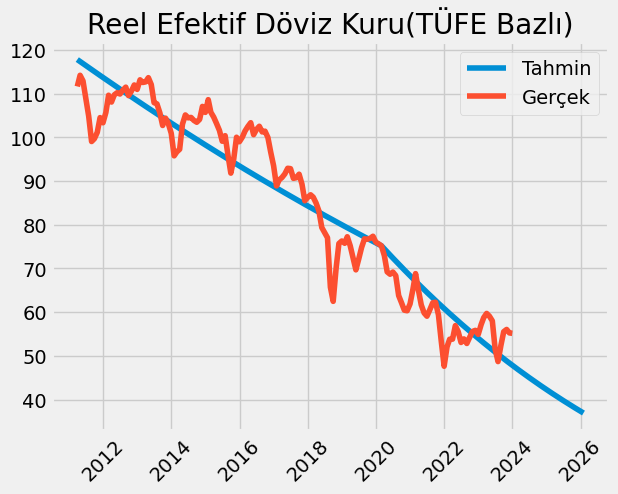

In [334]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [335]:
predictions["yhat"].tail(26)

ds
2023-12-31    47.844992
2024-01-31    47.350795
2024-02-29    46.892488
2024-03-31    46.406831
2024-04-30    45.941006
2024-05-31    45.463934
2024-06-30    45.006368
2024-07-31    44.537778
2024-08-31    44.073462
2024-09-30    43.628166
2024-10-31    43.172178
2024-11-30    42.734894
2024-12-31    42.287134
2025-01-31    41.843515
2025-02-28    41.446364
2025-03-31    41.010553
2025-04-30    40.592670
2025-05-31    40.164829
2025-06-30    39.754608
2025-07-31    39.334632
2025-08-31    38.918613
2025-09-30    38.519756
2025-10-31    38.111443
2025-11-30    37.719993
2025-12-31    37.319282
2026-01-31    36.922394
Name: yhat, dtype: float64

In [336]:
redkttahmin=predictions["yhat"].tail(26)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redkttahmin.iloc[0,0]=redkt.iloc[-1,0]
redkttahmin

REDKT
2023-12-31  55.150000
2024-01-31  47.350795
2024-02-29  46.892488
2024-03-31  46.406831
2024-04-30  45.941006
2024-05-31  45.463934
2024-06-30  45.006368
2024-07-31  44.537778
2024-08-31  44.073462
2024-09-30  43.628166
2024-10-31  43.172178
2024-11-30  42.734894
2024-12-31  42.287134
2025-01-31  41.843515
2025-02-28  41.446364
2025-03-31  41.010553
2025-04-30  40.592670
2025-05-31  40.164829
2025-06-30  39.754608
2025-07-31  39.334632
2025-08-31  38.918613
2025-09-30  38.519756
2025-10-31  38.111443
2025-11-30  37.719993
2025-12-31  37.319282
2026-01-31  36.922394

In [338]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TRY"].rolling(3).mean(),paraarzitahmin1["M2 Para Arzi"].shift(1),sanayitahmin1["Sanayi"],kreditahmin1.rolling(2).mean(),borctahmin1.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Tahmini"]=enf_tahmintahmin1["Enflasyon Tahmini"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["REDKT"]=redkttahmin["REDKT"]
tahmindf["Politika Faizi"]=faiztahmin["Faiz"]




tahmindf["Politika Faizi"]=[42.5,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45]
tahmindf=tahmindf[['USD/TRY', 'Kredi Faizi', 'Sanayi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TRY","Kredi Faizi","Sanayi","Enflasyon Tahmini",'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi','REDKT','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna(axis=0)





#tahmindf.iloc[0,1]=-3.34
#tahmindf.iloc[1,1]=5.76
#tahmindf.iloc[0,9]=2.675
#tahmindf.iloc[-1,4]=25
tahmindf

USD/TRY  Kredi Faizi    Sanayi  Enflasyon Tahmini  M2 Para Arzi  \
2024-01-31  2.368913    62.080000  0.956886          41.532711      4.333376   
2024-02-29  1.921321    62.487036 -1.357177          41.589358      1.742943   
2024-03-31  3.807999    63.739910 -2.046604          40.620016      2.194656   
2024-04-30  5.200808    63.140805  1.265502          40.040023      2.755649   
2024-05-31  6.685346    63.980462  0.377122          40.040366      2.863431   
2024-06-30  5.550955    63.245752  0.588868          42.708126      2.493815   
2024-07-31  4.225942    64.009176  0.369633          43.618352      2.549936   
2024-08-31  3.801167    63.268563  0.758481          43.303038      2.705147   
2024-09-30  4.003090    64.006409 -1.003541          42.686887      2.520250   
2024-10-31  4.471965    63.278946  0.441132          42.302020      2.381551   
2024-11-30  4.377099    63.999098  0.305830          44.413303      1.892465   
2024-12-31  4.583017    63.287318  0.041339          45.091588      1.647509   
2025-01-31  3.680898    63.991261  1.942478          44.755840      1.837237   
2025-02-28  3.019526    63.295238 -0.149854          44.186582      1.831110   
2025-03-31  0.000000    63.983495 -2.181874          43.833745      2.415642   
2025-04-30  0.000000    63.302943  0.661975          45.660181      1.665644   
2025-05-31  0.000000    63.975887  1.415158          46.244782      2.345872   
2025-06-30  0.000000    63.310469 -1.018333          45.949879      2.207873   
2025-07-31  0.000000    63.968446  0.306607          45.453205      2.181381   
2025-08-31  0.000000    63.317828  1.114519          45.145479      1.550620   
2025-09-30  0.000000    63.961170 -0.033259          46.733536      1.776525   
2025-10-31  0.000000    63.325023 -0.606060          47.241734      1.721710   
2025-11-30  0.000000    63.954056  0.932992          46.985110      1.685024   
2025-12-31  0.000000    63.332057 -0.050775          46.553061      1.515789   
2026-01-31  0.000000    63.947100  0.096555          46.285381      1.682348   

                Borç  Kredi Hacmi  Mevduat Faizi      REDKT  İşsizlik  \
2024-01-31  6.359560     3.441692      51.290000  47.350795  8.756800   
2024-02-29  4.789370     4.245115      50.758418  46.892488  8.901400   
2024-03-31  2.466437     3.912687      52.269808  46.406831  8.952587   
2024-04-30  5.568672     3.693591      52.226070  45.941006  8.965938   
2024-05-31  3.810680     3.346566      51.606011  45.463934  9.061040   
2024-06-30  3.824920     1.566834      51.962263  45.006368  9.105634   
2024-07-31  3.710144     2.168037      52.032439  44.537778  9.136871   
2024-08-31  3.779894     2.752301      51.842460  44.073462  9.192203   
2024-09-30  2.884047     2.042429      51.916006  43.628166  9.230379   
2024-10-31  3.621177     2.222578      51.956895  43.172178  9.263083   
2024-11-30  2.238208     2.037496      50.605823  42.734894  9.365130   
2024-12-31  3.709421     2.261768      49.320110  42.287134  9.460653   
2025-01-31  3.351894     2.235658      49.336537  41.843515  9.490318   
2025-02-28  2.929813     1.814085      49.322581  41.446364  9.520910   
2025-03-31  2.598385     1.893219      49.323182  41.010553  9.548476   
2025-04-30  2.872640     1.715211      49.328800  40.592670  9.574230   
2025-05-31  2.793279     2.033464      49.325485  40.164829  9.599389   
2025-06-30  2.210597     1.238827      49.324897  39.754608  9.622767   
2025-07-31  2.793889     1.109212      49.326629  39.334632  9.644787   
2025-08-31  1.740769     1.266640      49.325937  38.918613  9.665872   
2025-09-30  3.260525     1.449766      49.325576  38.519756  9.685691   
2025-10-31  2.281072     1.473077      48.028591  38.111443  9.767461   
2025-11-30  2.323837     0.809133      46.731000  37.719993  9.848303   
2025-12-31  2.287172     0.877315      46.730853  37.319282  9.865104   
2026-01-31  2.362587     1.057357      46.730982  36.922394  9.880995   

            Politika Faizi  
2024

In [365]:
features=['USD/TRY','Kredi Faizi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi']


In [374]:
import keras
import keras.optimizers
prediction_list=[]
for i in range(10):
   keras.utils.set_random_seed(i)
   X = data.drop(['TÜFE'], axis=1).values
   y = data['TÜFE'].values
   X=data[features].values

   X_scaled = scaler.fit_transform(X)
   y_scaled = scaler.fit_transform(y.reshape(-1, 1))

   model = tf.keras.Sequential()
   model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(7,1)))
   model.add(tf.keras.layers.Dense(64,activation='selu'))
   model.add(tf.keras.layers.Dense(64,activation='elu'))
   model.add(tf.keras.layers.Dense(1))
   rms = keras.optimizers.RMSprop(learning_rate=0.01)
   model.compile(optimizer=rms, loss='mean_squared_error')
   model.fit(X_scaled, y_scaled, epochs=100, batch_size=32)
   tahmin=tahmindf[features].values
   X_scaled = scaler.fit_transform(X)
   tahmin_scaled = scaler.transform(tahmin)
   pred = model.predict(tahmin_scaled)
   y_scaled = scaler.fit_transform(y.reshape(-1, 1))
   pred = scaler.inverse_transform(pred)
   prediction_list.append(pred)
columns = [f'Prediction_{i+1}' for i in range(10)]
predictions_df = pd.DataFrame(np.column_stack(prediction_list), columns=columns)

Epoch 1/100
4/4 [==============================] - 1s 7ms/step - loss: 4.3100
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 0.4117
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0399
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0277
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0242
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0335
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1265
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0259
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0299
Epoch 11/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0275
Epoch 12/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 13/100
4/4 [==============================] - 0s 5ms/st

4/4 [==============================] - 0s 6ms/step - loss: 0.0798
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0532
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0252
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 11/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0327
Epoch 12/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0926
Epoch 13/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 14/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0147
Epoch 15/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 16/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1059
Epoch 17/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0205
Epoch 18/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0231
Epoch 19/100
4/4 [==============================] - 0s 7ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 0.0174
Epoch 12/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0153
Epoch 13/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0439
Epoch 14/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0191
Epoch 15/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0237
Epoch 16/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0301
Epoch 17/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0246
Epoch 18/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0142
Epoch 19/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0336
Epoch 20/100
4/4 [==============================] - 0s 10ms/step - loss: 0.5834
Epoch 21/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0198
Epoch 22/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0168
Epoch 23/100
4/4 [==============================] - 0s 9ms/s

4/4 [==============================] - 0s 11ms/step - loss: 0.0185
Epoch 16/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0670
Epoch 17/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0292
Epoch 18/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0224
Epoch 19/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0224
Epoch 20/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0184
Epoch 21/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1777
Epoch 22/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1940
Epoch 23/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0376
Epoch 24/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0207
Epoch 25/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0190
Epoch 26/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0205
Epoch 27/100
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 21/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 22/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0298
Epoch 23/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0150
Epoch 24/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0283
Epoch 25/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0425
Epoch 26/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0304
Epoch 27/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 28/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0174
Epoch 29/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0248
Epoch 30/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0200
Epoch 31/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0167
Epoch 32/100
4/4 [==============================] - 0s 7ms/step -

In [375]:
pred=predictions_df.iloc[:,:11].mean(axis=1).values
pred

array([6.1179795, 5.7503366, 5.79713  , 6.2758303, 6.360694 , 6.185231 ,
       6.100139 , 6.039647 , 5.9375396, 6.017135 , 5.9916277, 6.182973 ,
       6.0541563, 5.834739 , 5.41932  , 5.4332237, 5.570349 , 5.406334 ,
       5.467805 , 5.250323 , 5.5645213, 5.484371 , 5.505611 , 5.4322824,
       5.48352  ], dtype=float32)

In [403]:
corr=data.corr()["TÜFE"].sort_values(ascending=False)
np.abs(corr).sort_values(ascending=False)

TÜFE                 1.000000
USD/TRY              0.720002
M2 Para Arzi         0.678249
REDKT                0.580310
Enflasyon Tahmini    0.562694
Kredi Hacmi          0.521658
Kredi Faizi          0.505576
Borç                 0.453026
Mevduat Faizi        0.416199
Politika Faizi       0.230164
İşsizlik             0.200390
BRENT                0.077997
Sanayi               0.053535
Name: TÜFE, dtype: float64

### TÜFE Tahminlerimizi yapıyoruz.

In [404]:
features=['USD/TRY','Kredi Faizi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi']

X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1806.50
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin1

SGD Regressor
2024-01-31    1887.255885
2024-02-29    1959.813767
2024-03-31    2046.688270
2024-04-30    2147.450061
2024-05-31    2263.512151
2024-06-30    2379.114906
2024-07-31    2493.431150
2024-08-31    2609.995241
2024-09-30    2732.096310
2024-10-31    2861.826756
2024-11-30    2998.493114
2024-12-31    3143.442950
2025-01-31    3288.326398
2025-02-28    3431.529671
2025-03-31    3554.578132
2025-04-30    3679.553746
2025-05-31    3815.896325
2025-06-30    3954.509197
2025-07-31    4097.897568
2025-08-31    4239.507243
2025-09-30    4392.994159
2025-10-31    4552.498832
2025-11-30    4718.686997
2025-12-31    4887.266742
2026-01-31    5063.829530

In [405]:
data.columns

Index(['USD/TRY', 'BRENT', 'Kredi Faizi', 'Sanayi', 'Enflasyon Tahmini',
       'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi', 'REDKT',
       'İşsizlik', 'Politika Faizi', 'TÜFE'],
      dtype='object')

In [406]:
features=['USD/TRY','Kredi Faizi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi']


X= data[features]
y=data[["TÜFE"]]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1806.50
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin2


Linear Regression
2024-01-31        1885.531568
2024-02-29        1956.703289
2024-03-31        2041.641002
2024-04-30        2140.011004
2024-05-31        2253.697010
2024-06-30        2366.858312
2024-07-31        2478.805063
2024-08-31        2592.675966
2024-09-30        2712.011032
2024-10-31        2838.487097
2024-11-30        2972.680971
2024-12-31        3115.420504
2025-01-31        3258.210399
2025-02-28        3399.101659
2025-03-31        3520.297286
2025-04-30        3643.501918
2025-05-31        3778.050159
2025-06-30        3914.649491
2025-07-31        4056.118573
2025-08-31        4195.638985
2025-09-30        4347.261287
2025-10-31        4505.499209
2025-11-30        4671.560209
2025-12-31        4839.812436
2026-01-31        5016.227516

In [407]:
features=['USD/TRY','Kredi Faizi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi']


X = data[features]
reg = linear_model.Lasso(alpha=0.001)
reg.fit(X,y)


tüfetahmin5 = []
result = 1806.50
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin5

Lasso Regression
2024-01-31       1885.510548
2024-02-29       1956.644070
2024-03-31       2041.558868
2024-04-30       2139.900531
2024-05-31       2253.559948
2024-06-30       2366.725120
2024-07-31       2478.662155
2024-08-31       2592.518000
2024-09-30       2711.844318
2024-10-31       2838.311677
2024-11-30       2972.490020
2024-12-31       3115.195625
2025-01-31       3257.940846
2025-02-28       3398.798789
2025-03-31       3519.942943
2025-04-30       3643.105872
2025-05-31       3777.599540
2025-06-30       3914.169807
2025-07-31       4055.595121
2025-08-31       4195.080751
2025-09-30       4346.645464
2025-10-31       4504.822339
2025-11-30       4670.802286
2025-12-31       4838.975246
2026-01-31       5015.289445

In [408]:
features=['USD/TRY','Kredi Faizi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi']




X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1806.50
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin6


Lars Regression
2024-01-31      1885.531568
2024-02-29      1956.703289
2024-03-31      2041.641002
2024-04-30      2140.011004
2024-05-31      2253.697010
2024-06-30      2366.858312
2024-07-31      2478.805063
2024-08-31      2592.675966
2024-09-30      2712.011032
2024-10-31      2838.487097
2024-11-30      2972.680971
2024-12-31      3115.420504
2025-01-31      3258.210399
2025-02-28      3399.101659
2025-03-31      3520.297286
2025-04-30      3643.501918
2025-05-31      3778.050159
2025-06-30      3914.649491
2025-07-31      4056.118573
2025-08-31      4195.638985
2025-09-30      4347.261287
2025-10-31      4505.499209
2025-11-30      4671.560209
2025-12-31      4839.812436
2026-01-31      5016.227516

In [409]:
features=['USD/TRY','Kredi Faizi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi']




X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1806.50
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin7

Kernel Regression
2024-01-31        1870.675175
2024-02-29        1923.471472
2024-03-31        1989.022371
2024-04-30        2067.797447
2024-05-31        2160.172433
2024-06-30        2255.207065
2024-07-31        2345.614527
2024-08-31        2435.666921
2024-09-30        2529.798483
2024-10-31        2629.679169
2024-11-30        2735.061359
2024-12-31        2847.003768
2025-01-31        2955.642651
2025-02-28        3062.003919
2025-03-31        3145.467984
2025-04-30        3231.707867
2025-05-31        3325.176776
2025-06-30        3421.876490
2025-07-31        3520.281192
2025-08-31        3615.566257
2025-09-30        3719.370241
2025-10-31        3827.699651
2025-11-30        3940.899718
2025-12-31        4054.665914
2026-01-31        4171.467405

In [410]:
features=['USD/TRY','Kredi Faizi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi']





X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1806.50  
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2024-01-31",periods=len(tüfetahmin1),freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

Gaussian Regression
2024-01-31          1879.044084
2024-02-29          1942.184823
2024-03-31          2018.582540
2024-04-30          2108.275496
2024-05-31          2212.472018
2024-06-30          2317.515696
2024-07-31          2419.808888
2024-08-31          2522.980630
2024-09-30          2630.948453
2024-10-31          2745.397170
2024-11-30          2866.529209
2024-12-31          2995.284068
2025-01-31          3122.521859
2025-02-28          3247.638560
2025-03-31          3351.539170
2025-04-30          3457.760171
2025-05-31          3573.379033
2025-06-30          3691.536516
2025-07-31          3813.046145
2025-08-31          3932.006577
2025-09-30          4061.365206
2025-10-31          4196.313839
2025-11-30          4337.644325
2025-12-31          4480.344470
2026-01-31          4628.721401

In [411]:
features=['USD/TRY','Kredi Faizi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi']

X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1806.50 
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2024-01-31",periods=len(tüfetahmin1),freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

Bayessian Regression
2024-01-31           1888.068462
2024-02-29           1963.294110
2024-03-31           2051.271634
2024-04-30           2152.553287
2024-05-31           2268.420387
2024-06-30           2383.082517
2024-07-31           2497.683321
2024-08-31           2614.897503
2024-09-30           2737.255171
2024-10-31           2867.002967
2024-11-30           3004.666785
2024-12-31           3151.666746
2025-01-31           3299.519955
2025-02-28           3445.565375
2025-03-31           3573.894427
2025-04-30           3704.659746
2025-05-31           3847.366941
2025-06-30           3991.445628
2025-07-31           4141.156831
2025-08-31           4289.390569
2025-09-30           4451.025089
2025-10-31           4619.555368
2025-11-30           4796.179491
2025-12-31           4975.585410
2026-01-31           5164.275185

In [412]:
pred1=pd.DataFrame(pred,index=pd.date_range(start="2023-12-30",periods=25,freq="1M"))
pred1=pred1[0]

In [413]:
tüfetahmin19 = []
result = 1806.50
lstmtahmin=pred1
for i in range(len(lstmtahmin)):
    result *= (1 + lstmtahmin[i] / 100)
    tüfetahmin19.append(result)

tüfetahmin19 = np.array(tüfetahmin19).reshape(-1, 1)
tüfetahmin19 = pd.DataFrame(tüfetahmin19)
tüfetahmin19.columns = ["LSTM"]
tüfetahmin19 = tüfetahmin19.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin19), freq="1M"))
tüfetahmin19

LSTM
2024-01-31  1917.021300
2024-02-29  2027.256479
2024-03-31  2144.779174
2024-04-30  2279.381875
2024-05-31  2424.366379
2024-06-30  2574.319045
2024-07-31  2731.356089
2024-08-31  2896.320358
2024-09-30  3068.290525
2024-10-31  3252.913713
2024-11-30  3447.816192
2024-12-31  3660.993733
2025-01-31  3882.636016
2025-02-28  4109.177702
2025-03-31  4331.867195
2025-04-30  4567.227231
2025-05-31  4821.637737
2025-06-30  5082.311574
2025-07-31  5360.202456
2025-08-31  5641.630388
2025-09-30  5955.560114
2025-10-31  6282.185137
2025-11-30  6628.057809
2025-12-31  6988.112630
2026-01-31  7371.307186

In [414]:
features=['USD/TRY','Kredi Faizi',
       'Enflasyon Tahmini', 'M2 Para Arzi', 'Borç', 'Kredi Hacmi', 'Mevduat Faizi']

X = data[features]
y=data[["TÜFE"]]
model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
# Modeli uydurun
results = model.fit()

robusttahmin=results.predict(tahmindf[features])

tüfetahmin21 = []
result = 1806.50
for i in range(len(robusttahmin)):
    result *= (1 + robusttahmin[i] / 100)
    tüfetahmin21.append(result)

tüfetahmin21 = np.array(tüfetahmin21).reshape(-1, 1)
tüfetahmin21 = pd.DataFrame(tüfetahmin21)
tüfetahmin21.columns = ["Robust Regression"]
tüfetahmin21 = tüfetahmin21.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin21

Robust Regression
2024-01-31        1871.946377
2024-02-29        1928.619526
2024-03-31        1997.087081
2024-04-30        2074.422611
2024-05-31        2163.750889
2024-06-30        2258.074495
2024-07-31        2350.067243
2024-08-31        2442.318310
2024-09-30        2539.498370
2024-10-31        2641.116791
2024-11-30        2749.497880
2024-12-31        2862.385942
2025-01-31        2974.394972
2025-02-28        3086.572180
2025-03-31        3183.754077
2025-04-30        3284.689249
2025-05-31        3393.155260
2025-06-30        3506.839934
2025-07-31        3622.634474
2025-08-31        3737.915095
2025-09-30        3860.670127
2025-10-31        3989.595662
2025-11-30        4124.171771
2025-12-31        4260.609675
2026-01-31        4400.968295

In [415]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["LSTM"]=tüfetahmin19["LSTM"]
tüfetahmin["Robust Regression"]=tüfetahmin21["Robust Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

SGD Regressor  Linear Regression  Lasso Regression  \
2024-01-31    1887.255885        1885.531568       1885.510548   
2024-02-29    1959.813767        1956.703289       1956.644070   
2024-03-31    2046.688270        2041.641002       2041.558868   
2024-04-30    2147.450061        2140.011004       2139.900531   
2024-05-31    2263.512151        2253.697010       2253.559948   
2024-06-30    2379.114906        2366.858312       2366.725120   
2024-07-31    2493.431150        2478.805063       2478.662155   
2024-08-31    2609.995241        2592.675966       2592.518000   
2024-09-30    2732.096310        2712.011032       2711.844318   
2024-10-31    2861.826756        2838.487097       2838.311677   
2024-11-30    2998.493114        2972.680971       2972.490020   
2024-12-31    3143.442950        3115.420504       3115.195625   
2025-01-31    3288.326398        3258.210399       3257.940846   
2025-02-28    3431.529671        3399.101659       3398.798789   
2025-03-31    3554.578132        3520.297286       3519.942943   
2025-04-30    3679.553746        3643.501918       3643.105872   
2025-05-31    3815.896325        3778.050159       3777.599540   
2025-06-30    3954.509197        3914.649491       3914.169807   
2025-07-31    4097.897568        4056.118573       4055.595121   
2025-08-31    4239.507243        4195.638985       4195.080751   
2025-09-30    4392.994159        4347.261287       4346.645464   
2025-10-31    4552.498832        4505.499209       4504.822339   
2025-11-30    4718.686997        4671.560209       4670.802286   
2025-12-31    4887.266742        4839.812436       4838.975246   
2026-01-31    5063.829530        5016.227516       5015.289445   

            Lars Regression  Kernel Regression  Gaussian Regression  \
2024-01-31      1885.531568        1870.675175          1879.044084   
2024-02-29      1956.703289        1923.471472          1942.184823   
2024-03-31      2041.641002        1989.022371          2018.582540   
2024-04-30      2140.011004        2067.797447          2108.275496   
2024-05-31      2253.697010        2160.172433          2212.472018   
2024-06-30      2366.858312        2255.207065          2317.515696   
2024-07-31      2478.805063        2345.614527          2419.808888   
2024-08-31      2592.675966        2435.666921          2522.980630   
2024-09-30      2712.011032        2529.798483          2630.948453   
2024-10-31      2838.487097        2629.679169          2745.397170   
2024-11-30      2972.680971        2735.061359          2866.529209   
2024-12-31      3115.420504        2847.003768          2995.284068   
2025-01-31      3258.210399        2955.642651          3122.521859   
2025-02-28      3399.101659        3062.003919          3247.638560   
2025-03-31      3520.297286        3145.467984          3351.539170   
2025-04-30      3643.501918        3231.707867          3457.760171   
2025-05-31      3778.050159        3325.176776          3573.379033   
2025-06-30      3914.649491        3421.876490          3691.536516   
2025-07-31      4056.118573        3520.281192          3813.046145   
2025-08-31      4195.638985        3615.566257          3932.006577   
2025-09-30      4347.261287        3719.370241          4061.365206   
2025-10-31      4505.499209        3827.699651          4196.313839   
2025-11-30      4671.560209        3940.899718          4337.644325   
2025-12-31      4839.812436        4054.665914          4480.344470   
2026-01-31      5016.227516        4171.467405          4628.721401   

            Bayessian Regression         LSTM  Robust Regression     Ortalama  
2024-01-31           1888.068462  1917.021300        1871.946377  1885.620552  
2024-02-29           1963.294110  2027.256479        1928.619526  1957.187870  
2024-03-31           2051.271634  2144.779174        1997.087081  2041.363549  
2024-04-30           2152.553287  2279.381875        2074.422611  2138.867035  
2024-05-31           2268.420387  2424.366379   

In [416]:
dates=pd.date_range('2006-02-01','2024-01-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9,dfas10],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [417]:

tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

SGD Regressor  Linear Regression  Lasso Regression  \
2024-01-31    1887.255885        1885.531568       1885.510548   
2024-02-29    1959.813767        1956.703289       1956.644070   
2024-03-31    2046.688270        2041.641002       2041.558868   
2024-04-30    2147.450061        2140.011004       2139.900531   
2024-05-31    2263.512151        2253.697010       2253.559948   
2024-06-30    2379.114906        2366.858312       2366.725120   
2024-07-31    2493.431150        2478.805063       2478.662155   
2024-08-31    2609.995241        2592.675966       2592.518000   
2024-09-30    2732.096310        2712.011032       2711.844318   
2024-10-31    2861.826756        2838.487097       2838.311677   
2024-11-30    2998.493114        2972.680971       2972.490020   
2024-12-31    3143.442950        3115.420504       3115.195625   
2025-01-31    3288.326398        3258.210399       3257.940846   
2025-02-28    3431.529671        3399.101659       3398.798789   
2025-03-31    3554.578132        3520.297286       3519.942943   
2025-04-30    3679.553746        3643.501918       3643.105872   
2025-05-31    3815.896325        3778.050159       3777.599540   
2025-06-30    3954.509197        3914.649491       3914.169807   
2025-07-31    4097.897568        4056.118573       4055.595121   
2025-08-31    4239.507243        4195.638985       4195.080751   
2025-09-30    4392.994159        4347.261287       4346.645464   
2025-10-31    4552.498832        4505.499209       4504.822339   
2025-11-30    4718.686997        4671.560209       4670.802286   
2025-12-31    4887.266742        4839.812436       4838.975246   
2026-01-31    5063.829530        5016.227516       5015.289445   

            Lars Regression  Kernel Regression  Gaussian Regression  \
2024-01-31      1885.531568        1870.675175          1879.044084   
2024-02-29      1956.703289        1923.471472          1942.184823   
2024-03-31      2041.641002        1989.022371          2018.582540   
2024-04-30      2140.011004        2067.797447          2108.275496   
2024-05-31      2253.697010        2160.172433          2212.472018   
2024-06-30      2366.858312        2255.207065          2317.515696   
2024-07-31      2478.805063        2345.614527          2419.808888   
2024-08-31      2592.675966        2435.666921          2522.980630   
2024-09-30      2712.011032        2529.798483          2630.948453   
2024-10-31      2838.487097        2629.679169          2745.397170   
2024-11-30      2972.680971        2735.061359          2866.529209   
2024-12-31      3115.420504        2847.003768          2995.284068   
2025-01-31      3258.210399        2955.642651          3122.521859   
2025-02-28      3399.101659        3062.003919          3247.638560   
2025-03-31      3520.297286        3145.467984          3351.539170   
2025-04-30      3643.501918        3231.707867          3457.760171   
2025-05-31      3778.050159        3325.176776          3573.379033   
2025-06-30      3914.649491        3421.876490          3691.536516   
2025-07-31      4056.118573        3520.281192          3813.046145   
2025-08-31      4195.638985        3615.566257          3932.006577   
2025-09-30      4347.261287        3719.370241          4061.365206   
2025-10-31      4505.499209        3827.699651          4196.313839   
2025-11-30      4671.560209        3940.899718          4337.644325   
2025-12-31      4839.812436        4054.665914          4480.344470   
2026-01-31      5016.227516        4171.467405          4628.721401   

            Bayessian Regression         LSTM  Robust Regression     Ortalama  
2024-01-31           1888.068462  1917.021300        1871.946377  1885.620552  
2024-02-29           1963.294110  2027.256479        1928.619526  1957.187870  
2024-03-31           2051.271634  2144.779174        1997.087081  2041.363549  
2024-04-30           2152.553287  2279.381875        2074.422611  2138.867035  
2024-05-31           2268.420387  2424.366379   

In [418]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin.iloc[4,:]=aylıktahmin.iloc[4,:]+0.50
aylıktahmin

SGD Regressor  Linear Regression  Lasso Regression  \
2024-02-29       3.844623           3.774624          3.772640   
2024-03-31       4.432794           4.340858          4.339818   
2024-04-30       4.923163           4.818183          4.816989   
2024-05-31       5.404647           5.312403          5.311435   
2024-06-30       5.607229           5.521141          5.521618   
2024-07-31       4.804990           4.729761          4.729617   
2024-08-31       4.674847           4.593782          4.593439   
2024-09-30       4.678210           4.602776          4.602719   
2024-10-31       4.748385           4.663553          4.663518   
2024-11-30       4.775494           4.727655          4.727400   
2024-12-31       4.834089           4.801710          4.800878   
2025-01-31       4.609069           4.583327          4.582223   
2025-02-28       4.354898           4.324192          4.323527   
2025-03-31       3.585820           3.565519          3.564323   
2025-04-30       3.515906           3.499836          3.499004   
2025-05-31       3.705411           3.692828          3.691731   
2025-06-30       3.632511           3.615604          3.615266   
2025-07-31       3.625946           3.613838          3.613162   
2025-08-31       3.455667           3.439752          3.439338   
2025-09-30       3.620395           3.613807          3.612915   
2025-10-31       3.630887           3.639945          3.639056   
2025-11-30       3.650482           3.685740          3.684495   
2025-12-31       3.572599           3.601628          3.600515   
2026-01-31       3.612710           3.645081          3.643627   

            Lars Regression  Kernel Regression  Gaussian Regression  \
2024-02-29         3.774624           2.822312             3.360259   
2024-03-31         4.340858           3.407948             3.933597   
2024-04-30         4.818183           3.960492             4.443363   
2024-05-31         5.312403           4.467313             4.942263   
2024-06-30         5.521141           4.899400             5.247797   
2024-07-31         4.729761           4.008832             4.413916   
2024-08-31         4.593782           3.839181             4.263632   
2024-09-30         4.602776           3.864714             4.279376   
2024-10-31         4.663553           3.948168             4.350093   
2024-11-30         4.727655           4.007416             4.412186   
2024-12-31         4.801710           4.092866             4.491664   
2025-01-31         4.583327           3.815902             4.247937   
2025-02-28         4.324192           3.598583             4.006912   
2025-03-31         3.565519           2.725799             3.199266   
2025-04-30         3.499836           2.741719             3.169320   
2025-05-31         3.692828           2.892245             3.343750   
2025-06-30         3.615604           2.908107             3.306604   
2025-07-31         3.613838           2.875753             3.291573   
2025-08-31         3.439752           2.706746             3.119827   
2025-09-30         3.613807           2.871030             3.289888   
2025-10-31         3.639945           2.912574             3.322741   
2025-11-30         3.685740           2.957392             3.367967   
2025-12-31         3.601628           2.886808             3.289807   
2026-01-31         3.645081           2.880669             3.311730   

            Bayessian Regression      LSTM  Robust Regression  Ortalama  
2024-02-29              3.984265  5.750337           3.027499  3.795425  
2024-03-31              4.481118  5.797130           3.550081  4.300848  
2024-04-30              4.937506  6.275830           3.872416  4.776390  
2024-05-31              5.382775  6.360694           4.306175  5.214832  
2024-06-30              5.554713  6.685231           4.859264  5.507035  
2024-07-31              4.808931  6.100139           4.073947  4.732413  
2024-08-31              4.692916  6.039647           3.925465  4.60

In [419]:
aylıktahmin.to_csv('modelaylık.csv')

In [420]:
std=aylıktahmin.std(axis=1)
std

2024-02-29    0.787891
2024-03-31    0.648810
2024-04-30    0.657711
2024-05-31    0.563970
2024-06-30    0.500553
2024-07-31    0.571229
2024-08-31    0.599147
2024-09-30    0.560539
2024-10-31    0.566763
2024-11-30    0.538071
2024-12-31    0.577005
2025-01-31    0.607797
2025-02-28    0.598846
2025-03-31    0.703951
2025-04-30    0.707654
2025-05-31    0.702508
2025-06-30    0.653768
2025-07-31    0.680132
2025-08-31    0.663490
2025-09-30    0.710664
2025-10-31    0.675456
2025-11-30    0.669545
2025-12-31    0.669368
2026-01-31    0.683439
Freq: M, dtype: float64

In [421]:
aylıktahmin["Maksimum"]=aylıktahmin["Bayessian Regression"]+std
aylıktahmin["Minimum"]=aylıktahmin["LSTM"]-std
aylıktahmin

SGD Regressor  Linear Regression  Lasso Regression  \
2024-02-29       3.844623           3.774624          3.772640   
2024-03-31       4.432794           4.340858          4.339818   
2024-04-30       4.923163           4.818183          4.816989   
2024-05-31       5.404647           5.312403          5.311435   
2024-06-30       5.607229           5.521141          5.521618   
2024-07-31       4.804990           4.729761          4.729617   
2024-08-31       4.674847           4.593782          4.593439   
2024-09-30       4.678210           4.602776          4.602719   
2024-10-31       4.748385           4.663553          4.663518   
2024-11-30       4.775494           4.727655          4.727400   
2024-12-31       4.834089           4.801710          4.800878   
2025-01-31       4.609069           4.583327          4.582223   
2025-02-28       4.354898           4.324192          4.323527   
2025-03-31       3.585820           3.565519          3.564323   
2025-04-30       3.515906           3.499836          3.499004   
2025-05-31       3.705411           3.692828          3.691731   
2025-06-30       3.632511           3.615604          3.615266   
2025-07-31       3.625946           3.613838          3.613162   
2025-08-31       3.455667           3.439752          3.439338   
2025-09-30       3.620395           3.613807          3.612915   
2025-10-31       3.630887           3.639945          3.639056   
2025-11-30       3.650482           3.685740          3.684495   
2025-12-31       3.572599           3.601628          3.600515   
2026-01-31       3.612710           3.645081          3.643627   

            Lars Regression  Kernel Regression  Gaussian Regression  \
2024-02-29         3.774624           2.822312             3.360259   
2024-03-31         4.340858           3.407948             3.933597   
2024-04-30         4.818183           3.960492             4.443363   
2024-05-31         5.312403           4.467313             4.942263   
2024-06-30         5.521141           4.899400             5.247797   
2024-07-31         4.729761           4.008832             4.413916   
2024-08-31         4.593782           3.839181             4.263632   
2024-09-30         4.602776           3.864714             4.279376   
2024-10-31         4.663553           3.948168             4.350093   
2024-11-30         4.727655           4.007416             4.412186   
2024-12-31         4.801710           4.092866             4.491664   
2025-01-31         4.583327           3.815902             4.247937   
2025-02-28         4.324192           3.598583             4.006912   
2025-03-31         3.565519           2.725799             3.199266   
2025-04-30         3.499836           2.741719             3.169320   
2025-05-31         3.692828           2.892245             3.343750   
2025-06-30         3.615604           2.908107             3.306604   
2025-07-31         3.613838           2.875753             3.291573   
2025-08-31         3.439752           2.706746             3.119827   
2025-09-30         3.613807           2.871030             3.289888   
2025-10-31         3.639945           2.912574             3.322741   
2025-11-30         3.685740           2.957392             3.367967   
2025-12-31         3.601628           2.886808             3.289807   
2026-01-31         3.645081           2.880669             3.311730   

            Bayessian Regression      LSTM  Robust Regression  Ortalama  \
2024-02-29              3.984265  5.750337           3.027499  3.795425   
2024-03-31              4.481118  5.797130           3.550081  4.300848   
2024-04-30              4.937506  6.275830           3.872416  4.776390   
2024-05-31              5.382775  6.360694           4.306175  5.214832   
2024-06-30              5.554713  6.685231           4.859264  5.507035   
2024-07-31              4.808931  6.100139           4.073947  4.732413   
2024-08-31              4.692916  6.039647           3.92546

In [422]:
tüfe = 1859.38# İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin10),freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [423]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin12),freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [425]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin13),freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [426]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin14),freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [427]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin15),freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [428]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin16),freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [429]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin17),freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [430]:
tüfe = 1859.38# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin18),freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [431]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin20),freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [432]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin22 = []
robusttahmin=aylıktahmin["Robust Regression"]
robusttahmin=1+(robusttahmin/100)
for elem in robusttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin22.append(tüfe)
tüfetahmin22=pd.DataFrame(tüfetahmin22)
tüfetahmin22=tüfetahmin22.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin22),freq="1M"))
tüfetahmin22.columns=["CPI"]
tüfetahmin22=pd.concat([df["CPI"],tüfetahmin22["CPI"]],axis=0)
tüfetahmin22=pd.DataFrame((tüfetahmin22.pct_change(periods=12)*100).tail(38))


In [433]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin23 = []
maxtahmin=aylıktahmin["Maksimum"]
maxtahmin=1+(maxtahmin/100)
for elem in maxtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin23.append(tüfe)
tüfetahmin23=pd.DataFrame(tüfetahmin23)
tüfetahmin23=tüfetahmin23.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin23),freq="1M"))
tüfetahmin23.columns=["CPI"]
tüfetahmin23=pd.concat([df["CPI"],tüfetahmin23["CPI"]],axis=0)
tüfetahmin23=pd.DataFrame((tüfetahmin23.pct_change(periods=12)*100).tail(38))


In [434]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin24 = []
mintahmin=aylıktahmin["Minimum"]
mintahmin=1+(mintahmin/100)
for elem in mintahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin24.append(tüfe)
tüfetahmin24=pd.DataFrame(tüfetahmin24)
tüfetahmin24=tüfetahmin24.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin24),freq="1M"))
tüfetahmin24.columns=["CPI"]
tüfetahmin24=pd.concat([df["CPI"],tüfetahmin24["CPI"]],axis=0)
tüfetahmin24=pd.DataFrame((tüfetahmin24.pct_change(periods=12)*100).tail(38))
tüfetahmin24

CPI
2022-11-30  84.389260
2022-12-31  64.269597
2023-01-31  57.682481
2023-02-28  55.179828
2023-03-31  50.508511
2023-04-30  43.684170
2023-05-31  39.585301
2023-06-30  38.213519
2023-07-31  47.831733
2023-08-31  58.943534
2023-09-30  61.529865
2023-10-31  61.357011
2023-11-30  61.980166
2023-12-31  64.772919
2024-01-31  62.167275
2024-02-29  65.316874
2024-03-31  70.696511
2024-04-30  76.383668
2024-05-31  87.211789
2024-06-30  90.109327
2024-07-31  83.080079
2024-08-31  76.853943
2024-09-30  78.031118
2024-10-31  81.507221
2024-11-30  85.592971
2024-12-31  90.135374
2025-01-31  90.630713
2025-02-28  89.845786
2025-03-31  88.241452
2025-04-30  86.588714
2025-05-31  84.072192
2025-06-30  82.779266
2025-07-31  81.299449
2025-08-31  80.399390
2025-09-30  79.302016
2025-10-31  78.252101
2025-11-30  76.829113
2025-12-31  75.745333

In [435]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)
ekim=pd.DataFrame({"TÜFE":[3.28,2.93]},index=pd.date_range(start="2023-11-30",periods=2,freq="1M"))
aylık=pd.concat([aylık,ekim],axis=0)

In [442]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]])
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.head(132).to_csv('aylik.csv')

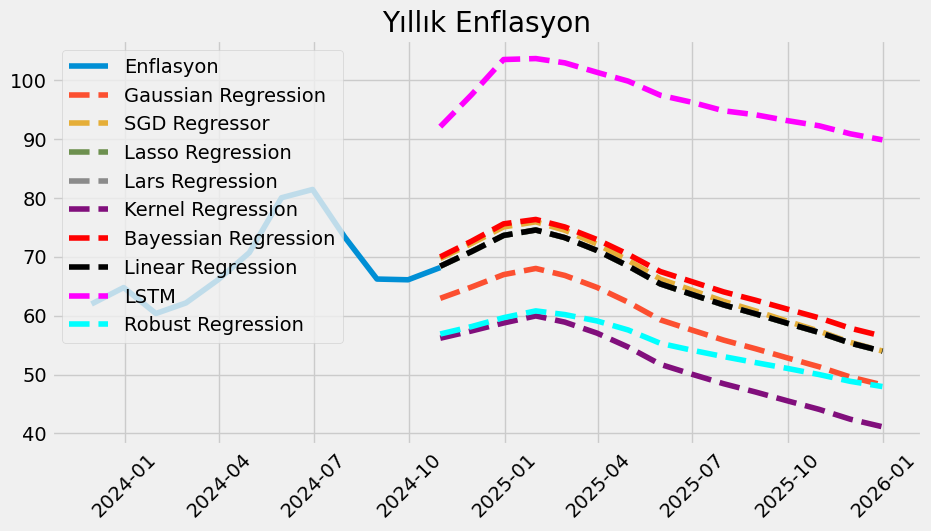

In [443]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
yıllıktahmin["Robust Regression"]=tüfetahmin22["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:],'--',label="Bayessian Regression",color="red")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["LSTM"].iloc[23:],'--',label="LSTM",color="magenta")
plt.plot(yıllıktahmin["Robust Regression"].iloc[23:],'--',label="Robust Regression",color="cyan")
plt.legend(loc=0)
plt.xticks(rotation=45)
#plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [444]:
yıllıktahmin["Maksimum"]=tüfetahmin23["CPI"]
yıllıktahmin["Minimum"]=tüfetahmin24["CPI"]
yıllıktahmin

Ortalama  SGD Regressor  Gaussian Regression  Lasso Regression  \
2022-11-30  84.389260      84.389260            84.389260         84.389260   
2022-12-31  64.269597      64.269597            64.269597         64.269597   
2023-01-31  57.682481      57.682481            57.682481         57.682481   
2023-02-28  55.179828      55.179828            55.179828         55.179828   
2023-03-31  50.508511      50.508511            50.508511         50.508511   
2023-04-30  43.684170      43.684170            43.684170         43.684170   
2023-05-31  39.585301      39.585301            39.585301         39.585301   
2023-06-30  38.213519      38.213519            38.213519         38.213519   
2023-07-31  47.831733      47.831733            47.831733         47.831733   
2023-08-31  58.943534      58.943534            58.943534         58.943534   
2023-09-30  61.529865      61.529865            61.529865         61.529865   
2023-10-31  61.357011      61.357011            61.357011         61.357011   
2023-11-30  61.980166      61.980166            61.980166         61.980166   
2023-12-31  64.772919      64.772919            64.772919         64.772919   
2024-01-31  60.364225      60.440237            59.691891         60.329022   
2024-02-29  62.161203      62.443305            60.912746         62.186180   
2024-03-31  66.103743      66.625789            64.301045         66.193699   
2024-04-30  70.693856      71.539240            68.403944         70.943105   
2024-05-31  80.016484      81.079838            77.165126         80.304264   
2024-06-30  81.422925      82.621051            78.006311         81.708102   
2024-07-31  73.331077      74.591615            69.511223         73.583701   
2024-08-31  66.214859      67.535750            62.040922         66.448445   
2024-09-30  66.090885      67.528186            61.417495         66.306081   
2024-10-31  68.171477      69.700984            62.944067         68.385701   
2024-11-30  70.671146      72.252703            64.853948         70.863494   
2024-12-31  73.458403      75.067364            66.969303         73.610891   
2025-01-31  74.428814      75.927615            68.013914         74.532521   
2025-02-28  73.373161      74.500801            66.826832         73.235324   
2025-03-31  71.493456      72.160351            64.791810         71.057036   
2025-04-30  69.217569      69.384941            62.281650         68.426157   
2025-05-31  66.411487      66.217663            59.288523         65.383372   
2025-06-30  64.867855      64.347733            57.576334         63.620327   
2025-07-31  63.271652      62.433524            55.847672         61.814913   
2025-08-31  61.986346      60.792068            54.368863         60.283739   
2025-09-30  60.636977      59.076674            52.849063         58.714858   
2025-10-31  59.280299      57.368612            51.320430         57.134330   
2025-11-30  57.694428      55.474962            49.579952         55.334555   
2025-12-31  56.492754      53.994127            48.236637         53.940470   

            Lars Regression  Kernel Regression  Bayessian Regression  \
2022-11-30        84.389260          84.389260             84.389260   
2022-12-31        64.269597          64.269597             64.269597   
2023-01-31        57.682481          57.682481             57.682481   
2023-02-28        55.179828          55.179828             55.179828   
2023-03-31        50.508511          50.508511             50.508511   
2023-04-30        43.684170          43.684170             43.684170   
2023-05-31        39.585301          39.585301             39.585301   
2023-06-30        38.213519          38.213519             38.213519   
2023-07-31        47.831733          47.831733             47.831733   
2023-08-31        58.943534          58.943534             58.943534   
2023-09-30        61.529865          61.529865             61.529865   
2023-10-31        61.357011          61.357011             61.35701

In [445]:
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:10].mean(axis=1)
yıllıktahmin.to_csv('modelyilliktahmin.csv')
yıllıktahmin


Ortalama  SGD Regressor  Gaussian Regression  Lasso Regression  \
2022-11-30  84.389260      84.389260            84.389260         84.389260   
2022-12-31  64.269597      64.269597            64.269597         64.269597   
2023-01-31  57.682481      57.682481            57.682481         57.682481   
2023-02-28  55.179828      55.179828            55.179828         55.179828   
2023-03-31  50.508511      50.508511            50.508511         50.508511   
2023-04-30  43.684170      43.684170            43.684170         43.684170   
2023-05-31  39.585301      39.585301            39.585301         39.585301   
2023-06-30  38.213519      38.213519            38.213519         38.213519   
2023-07-31  47.831733      47.831733            47.831733         47.831733   
2023-08-31  58.943534      58.943534            58.943534         58.943534   
2023-09-30  61.529865      61.529865            61.529865         61.529865   
2023-10-31  61.357011      61.357011            61.357011         61.357011   
2023-11-30  61.980166      61.980166            61.980166         61.980166   
2023-12-31  64.772919      64.772919            64.772919         64.772919   
2024-01-31  60.356046      60.440237            59.691891         60.329022   
2024-02-29  62.146122      62.443305            60.912746         62.186180   
2024-03-31  66.081232      66.625789            64.301045         66.193699   
2024-04-30  70.664681      71.539240            68.403944         70.943105   
2024-05-31  79.979830      81.079838            77.165126         80.304264   
2024-06-30  81.379076      82.621051            78.006311         81.708102   
2024-07-31  73.282203      74.591615            69.511223         73.583701   
2024-08-31  66.161693      67.535750            62.040922         66.448445   
2024-09-30  66.031355      67.528186            61.417495         66.306081   
2024-10-31  68.105017      69.700984            62.944067         68.385701   
2024-11-30  70.596919      72.252703            64.853948         70.863494   
2024-12-31  73.375634      75.067364            66.969303         73.610891   
2025-01-31  74.256253      75.927615            68.013914         74.532521   
2025-02-28  73.124243      74.500801            66.826832         73.235324   
2025-03-31  71.168781      72.160351            64.791810         71.057036   
2025-04-30  68.826029      69.384941            62.281650         68.426157   
2025-05-31  65.958567      66.217663            59.288523         65.383372   
2025-06-30  64.342753      64.347733            57.576334         63.620327   
2025-07-31  62.673606      62.433524            55.847672         61.814913   
2025-08-31  61.310499      60.792068            54.368863         60.283739   
2025-09-30  59.885160      59.076674            52.849063         58.714858   
2025-10-31  58.452435      57.368612            51.320430         57.134330   
2025-11-30  56.789841      55.474962            49.579952         55.334555   
2025-12-31  55.505657      53.994127            48.236637         53.940470   

            Lars Regression  Kernel Regression  Bayessian Regression  \
2022-11-30        84.389260          84.389260             84.389260   
2022-12-31        64.269597          64.269597             64.269597   
2023-01-31        57.682481          57.682481             57.682481   
2023-02-28        55.179828          55.179828             55.179828   
2023-03-31        50.508511          50.508511             50.508511   
2023-04-30        43.684170          43.684170             43.684170   
2023-05-31        39.585301          39.585301             39.585301   
2023-06-30        38.213519          38.213519             38.213519   
2023-07-31        47.831733          47.831733             47.831733   
2023-08-31        58.943534          58.943534             58.943534   
2023-09-30        61.529865          61.529865             61.529865   
2023-10-31        61.357011          61.357011             61.35701